In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Target column: mature

In [3]:
import pandas as pd
import json
import numpy as np

edges_path = '/content/gdrive/My Drive/STAT8306/Project/musae_ENGB_edges.csv'
targets_path = '/content/gdrive/My Drive/STAT8306/Project/musae_ENGB_target.csv'
features_path = '/content/gdrive/My Drive/STAT8306/Project/musae_ENGB_features.json'

edges = pd.read_csv(edges_path)
display(edges.head())

targets = pd.read_csv(targets_path)
targets.index = targets.new_id
display(targets.head())

# Reading the json as a dict
with open(features_path) as json_data:
    features = json.load(json_data)

#number of columns in features matrix
max_feature = np.max([v for v_list in features.values() for v in v_list])

#create empty array 
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))
print(features_matrix.shape)
#Expected: (7126, 3170)

i = 0
for k, vs in features.items():
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

#Get the targets in correct order
y = targets.loc[[int(i) for i in list(features.keys())], 'mature']

,from,to
0,6194,255
1,6194,980
2,6194,2992
3,6194,2507
4,6194,986


,id,days,mature,views,partner,new_id
new_id,,,,,,
2299,73045350,1459,False,9528,False,2299
153,61573865,1629,True,3615,False,153
397,171688860,411,True,46546,False,397
5623,117338954,953,True,5863,False,5623
5875,135804217,741,True,5594,False,5875


(7126, 3170)


### 1. Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rf_aucs = []
rf_accuracy = []
rf_f1 = []
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(features_matrix, y, test_size=0.3)
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_preds = rf.predict_proba(X_test)
    y_pred = rf.predict(X_test)
    rf_aucs.append(roc_auc_score(y_test, y_preds[:, 1]))
    rf_accuracy.append(accuracy_score(y_test, y_pred)) #accuracy score
    rf_f1.append(f1_score(y_test, y_pred)) #f1 score

100%|██████████| 100/100 [07:27<00:00,  4.48s/it]


In [14]:
print('test accuracy is', np.mean(rf_accuracy))
print(np.std(rf_accuracy))
print('test f1-score is',np.mean(rf_f1))
print(np.std(rf_f1))
print('test auc score is', np.mean(rf_aucs))
print(np.std(rf_aucs))

test accuracy is 0.592600561272217
0.009097492789392652
test f1-score is 0.6551670767338642
0.00905748316941744
test auc score is 0.6202634049268719
0.01097699910297395


### 2. Label Propagation

In [2]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The actual algorithm can be described in these 6 steps:

1. Order your nodes in a way, that the nodes with known   
2. labels are first  
3. Calculate the adjacency matrix  
4. Calculate transition matrix  
5. Make known nodes absorbing:  
  Set probability of going from known node to the same known node as 1  
  Set all the other probabilities as 0  
  This way, the probability of going from e.g. node 1 to node 1 is 100%  
6. Update the labels by multiplying the known labels with the resulting transition matrix  
7. Repeat until the labels stop changing  

In [4]:
import networkx as nx
#read in the graph
graph = nx.convert_matrix.from_pandas_edgelist(edges, "from", "to")

In [8]:
def label_propagation(G, Y_init, known_nodes, unknown_nodes, threshold=0.0001):
    # Step 1: order nodes
    ordered_nodes = list(known_nodes) + list(unknown_nodes) 
    
    # Step 2: adjacency matrix
    A = nx.adj_matrix(G, nodelist=ordered_nodes) 
    A = A.todense()
    A = np.array(A, dtype = np.float64)
    
    # Step 3: transition matrix
    T = A / A.sum(axis=1, keepdims=True)
    
    # Step 4: absorbing nodes
    T[:len(known_nodes), :] = 0
    T[:len(known_nodes), :len(known_nodes)] = np.identity(len(known_nodes)) 
    
    #Step 5 & 6: update labels until convergence
    labels = [Y_init] #stores the label progression for the animation
    Y1 = Y_init 
    for i in tqdm(range(1000)):
        Y0 = Y1
        Y1 = np.dot(T, Y0) #The actual probability update is happening here. 
        diff = np.abs(Y0 - Y1).sum() #calculate the difference between Y(t-1) and Y(t)
        Y1[:len(known_nodes)] = Y_init[:len(known_nodes)] #set the known labels back to their initial values
        labels.append(Y1)
        if i % 10 == 0:
            print('Total difference:', diff)
        if diff < threshold: #stopping criterion
            break
    
    return labels

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from tqdm import tqdm

aucs = []
accuracy = []
f1 = []

for i in range(1000):
    known = y.sample(n=int(0.7 * len(y))) # indices of known nodes
    known_nodes = known.index.values # and their values

    unknown = y[~y.index.isin(known.index)] # indices of unknown nodes
    unknown_nodes = unknown.index.values # and their values

    Y_init = [1 if y == True else 0 for y in known] + [0 for y in unknown] # ordered labels
    labels = label_propagation(graph, Y_init, known_nodes, unknown_nodes) # results of label propagation
    unknow_pred = [1 if p > 0.5 else 0 for p in labels[-1][len(known_nodes):]]

    aucs.append(roc_auc_score(unknown.values, labels[-1][len(known_nodes):])) #auc score
    accuracy.append(accuracy_score(unknown.values, unknow_pred)) #accuracy score
    f1.append(f1_score(unknown.values, unknow_pred)) #f1 score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:47, 20.79it/s]

Total difference: 817.711155799792


  1%|▏         | 14/1000 [00:00<00:44, 22.06it/s]

Total difference: 0.1427245058602549


  2%|▏         | 23/1000 [00:01<00:47, 20.41it/s]

Total difference: 0.0016047247169542547


  3%|▎         | 28/1000 [00:01<00:48, 20.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:42, 23.73it/s]

Total difference: 773.3037244215382


  2%|▏         | 15/1000 [00:00<00:45, 21.76it/s]

Total difference: 0.18733388830601833


  2%|▏         | 24/1000 [00:01<00:44, 22.16it/s]

Total difference: 0.003157567259644202


  3%|▎         | 32/1000 [00:01<00:45, 21.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013955414067719912


  0%|          | 3/1000 [00:00<00:45, 21.69it/s]

Total difference: 805.8294636190699


  1%|          | 12/1000 [00:00<00:59, 16.55it/s]

Total difference: 0.31337154946970314


  2%|▏         | 24/1000 [00:01<01:05, 14.91it/s]

Total difference: 0.03206862706211944


  3%|▎         | 33/1000 [00:02<01:01, 15.75it/s]

Total difference: 0.006807467716310571


  4%|▍         | 44/1000 [00:02<00:54, 17.67it/s]

Total difference: 0.001589917070825543


  5%|▌         | 54/1000 [00:03<00:53, 17.78it/s]

Total difference: 0.0003764259341277193


  6%|▌         | 57/1000 [00:03<00:58, 16.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:47, 21.13it/s]

Total difference: 794.8675750949593


  1%|▏         | 14/1000 [00:00<00:48, 20.24it/s]

Total difference: 0.14191396968052164


  2%|▏         | 23/1000 [00:01<00:46, 21.05it/s]

Total difference: 0.0014681938584991672


  3%|▎         | 28/1000 [00:01<00:49, 19.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:44, 22.63it/s]

Total difference: 791.8110826588045


  2%|▏         | 15/1000 [00:00<00:47, 20.61it/s]

Total difference: 0.2680174724817366


  2%|▏         | 24/1000 [00:01<00:48, 20.27it/s]

Total difference: 0.008105078623866876


  3%|▎         | 33/1000 [00:01<00:46, 20.79it/s]

Total difference: 0.0005224242692096794


  4%|▎         | 37/1000 [00:01<00:48, 19.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:43, 22.82it/s]

Total difference: 838.1545294857569


  2%|▏         | 15/1000 [00:00<00:46, 21.41it/s]

Total difference: 0.3017043639278032


  2%|▏         | 24/1000 [00:01<00:46, 21.04it/s]

Total difference: 0.012981629062580158


  3%|▎         | 33/1000 [00:01<00:45, 21.31it/s]

Total difference: 0.00115955338303457


  4%|▍         | 42/1000 [00:01<00:44, 21.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012663423007208685


  0%|          | 3/1000 [00:00<00:47, 21.12it/s]

Total difference: 792.5238684603978


  1%|          | 12/1000 [00:00<00:45, 21.67it/s]

Total difference: 0.19307341264660763


  2%|▏         | 24/1000 [00:01<00:44, 22.13it/s]

Total difference: 0.009448357637789982


  3%|▎         | 33/1000 [00:01<00:43, 22.03it/s]

Total difference: 0.00109452605330463


  4%|▍         | 42/1000 [00:01<00:45, 21.06it/s]


Total difference: 0.00013436867866451624


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:46, 21.67it/s]

Total difference: 824.0217074463908


  1%|▏         | 14/1000 [00:00<00:47, 20.84it/s]

Total difference: 0.2064627958252226


  2%|▏         | 23/1000 [00:01<00:46, 21.17it/s]

Total difference: 0.0044348654418786895


  3%|▎         | 32/1000 [00:01<00:47, 20.52it/s]


Total difference: 0.00015407537880296474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:45, 21.85it/s]

Total difference: 819.0013001573325


  1%|          | 12/1000 [00:00<01:19, 12.48it/s]

Total difference: 0.1657757666721292


  2%|▎         | 25/1000 [00:01<01:02, 15.66it/s]

Total difference: 0.0031068931368257793


  3%|▎         | 30/1000 [00:02<01:07, 14.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.3565877993005e-05


  0%|          | 3/1000 [00:00<00:45, 21.77it/s]

Total difference: 833.4153798239893


  2%|▏         | 15/1000 [00:00<00:42, 22.94it/s]

Total difference: 0.12203083073069253


  2%|▏         | 24/1000 [00:01<00:43, 22.65it/s]

Total difference: 0.001633081602793001


  3%|▎         | 28/1000 [00:01<00:43, 22.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 31.12it/s]

Total difference: 834.181807498608


  2%|▏         | 16/1000 [00:00<00:32, 30.42it/s]

Total difference: 0.12872651392417817


  2%|▏         | 24/1000 [00:00<00:31, 30.68it/s]

Total difference: 0.0012211487174064867


  3%|▎         | 28/1000 [00:00<00:33, 29.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:32, 30.65it/s]

Total difference: 809.6865117489518


  2%|▏         | 15/1000 [00:00<00:32, 30.59it/s]

Total difference: 0.17787138258715343


  2%|▏         | 23/1000 [00:00<00:32, 30.04it/s]

Total difference: 0.002447502573835327


  3%|▎         | 30/1000 [00:01<00:33, 29.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.541954875934758e-05


  0%|          | 3/1000 [00:00<00:38, 26.19it/s]

Total difference: 825.9511400866323


  2%|▏         | 15/1000 [00:00<00:32, 30.19it/s]

Total difference: 0.1299060994327657


  3%|▎         | 27/1000 [00:00<00:31, 30.50it/s]

Total difference: 0.001748692907598659


  3%|▎         | 29/1000 [00:00<00:33, 29.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:36, 27.27it/s]

Total difference: 800.2061692566234


  2%|▏         | 15/1000 [00:00<00:33, 29.40it/s]

Total difference: 0.16865672253597092


  2%|▎         | 25/1000 [00:00<00:32, 29.85it/s]

Total difference: 0.002740185605448895


  3%|▎         | 32/1000 [00:01<00:33, 28.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001378827424555057


  1%|          | 6/1000 [00:00<00:33, 29.54it/s]

Total difference: 819.3830589921159


  2%|▏         | 17/1000 [00:00<00:32, 30.36it/s]

Total difference: 0.22844016393284722


  2%|▎         | 25/1000 [00:00<00:32, 30.20it/s]

Total difference: 0.004864839923410129


  3%|▎         | 32/1000 [00:01<00:33, 28.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016906606407376956


  1%|          | 6/1000 [00:00<00:34, 28.74it/s]

Total difference: 840.4225338615281


  2%|▏         | 16/1000 [00:00<00:32, 29.98it/s]

Total difference: 0.15451588452462509


  2%|▏         | 24/1000 [00:00<00:32, 30.49it/s]

Total difference: 0.003417653530985318


  3%|▎         | 32/1000 [00:01<00:33, 29.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015575506174535236


  0%|          | 4/1000 [00:00<00:32, 30.98it/s]

Total difference: 823.0867838582031


  2%|▏         | 16/1000 [00:00<00:31, 31.51it/s]

Total difference: 0.25839900289832884


  2%|▏         | 24/1000 [00:00<00:31, 30.79it/s]

Total difference: 0.005031570879513777


  3%|▎         | 32/1000 [00:01<00:32, 29.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016624776069581234


  1%|          | 7/1000 [00:00<00:32, 30.45it/s]

Total difference: 874.5886709426643


  2%|▏         | 15/1000 [00:00<00:32, 30.18it/s]

Total difference: 0.1940920626760218


  2%|▎         | 25/1000 [00:00<00:33, 29.31it/s]

Total difference: 0.002767886782654605


  3%|▎         | 30/1000 [00:01<00:34, 28.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.867694890968668e-05


  1%|          | 7/1000 [00:00<00:32, 30.87it/s]

Total difference: 810.926832790308


  2%|▏         | 15/1000 [00:00<00:32, 30.02it/s]

Total difference: 0.2144727093745707


  3%|▎         | 27/1000 [00:00<00:31, 30.67it/s]

Total difference: 0.0056260462796195


  3%|▎         | 33/1000 [00:01<00:32, 29.31it/s]

Total difference: 0.0002374302029230571



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.98it/s]

Total difference: 821.2997335819462


  2%|▏         | 16/1000 [00:00<00:31, 30.90it/s]

Total difference: 0.31242544720969756


  2%|▏         | 24/1000 [00:00<00:32, 29.96it/s]

Total difference: 0.0133927422449759


  4%|▎         | 36/1000 [00:01<00:31, 30.52it/s]

Total difference: 0.001309095543188199


  4%|▍         | 43/1000 [00:01<00:32, 29.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015419931696744604


  0%|          | 4/1000 [00:00<00:32, 30.71it/s]

Total difference: 840.0962163316265


  2%|▏         | 16/1000 [00:00<00:32, 30.30it/s]

Total difference: 0.25651246835371677


  3%|▎         | 26/1000 [00:00<00:33, 28.95it/s]

Total difference: 0.014364694571675801


  4%|▎         | 35/1000 [00:01<00:32, 29.33it/s]

Total difference: 0.001606425590228014


  4%|▍         | 43/1000 [00:01<00:33, 28.45it/s]

Total difference: 0.0002032453944076501



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.76it/s]

Total difference: 820.7357081980781


  2%|▏         | 16/1000 [00:00<00:32, 30.40it/s]

Total difference: 0.19476544466493745


  3%|▎         | 27/1000 [00:00<00:32, 29.63it/s]

Total difference: 0.006020989117993196


  4%|▎         | 35/1000 [00:01<00:33, 28.98it/s]

Total difference: 0.00033113612872792686



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.48it/s]

Total difference: 811.2933896047148


  2%|▏         | 15/1000 [00:00<00:32, 30.21it/s]

Total difference: 0.2837470024881332


  3%|▎         | 27/1000 [00:00<00:31, 30.75it/s]

Total difference: 0.006135944773847053


  4%|▎         | 35/1000 [00:01<00:32, 29.42it/s]

Total difference: 0.0003305219569701076



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.69it/s]

Total difference: 845.7252111092702


  2%|▏         | 17/1000 [00:00<00:32, 30.48it/s]

Total difference: 0.23081310531306565


  2%|▎         | 25/1000 [00:00<00:32, 29.84it/s]

Total difference: 0.010197157650540939


  3%|▎         | 34/1000 [00:01<00:32, 29.29it/s]

Total difference: 0.0009327893435023202


  4%|▍         | 40/1000 [00:01<00:33, 28.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.51890325669863e-05


  1%|          | 6/1000 [00:00<00:33, 29.58it/s]

Total difference: 849.0983539337468


  2%|▏         | 15/1000 [00:00<00:34, 28.82it/s]

Total difference: 0.246006152385077


  2%|▏         | 24/1000 [00:00<00:33, 29.09it/s]

Total difference: 0.003856222910801524


  3%|▎         | 32/1000 [00:01<00:34, 27.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011022572821667298


  0%|          | 4/1000 [00:00<00:32, 30.69it/s]

Total difference: 843.0693910614274


  1%|▏         | 14/1000 [00:00<00:33, 29.51it/s]

Total difference: 0.22367404293512738


  2%|▏         | 24/1000 [00:00<00:33, 29.29it/s]

Total difference: 0.01207016990498113


  3%|▎         | 34/1000 [00:01<00:32, 29.97it/s]

Total difference: 0.0022999662302123774


  4%|▍         | 45/1000 [00:01<00:31, 30.39it/s]

Total difference: 0.0005942521091686082


  5%|▌         | 54/1000 [00:01<00:32, 29.27it/s]


Total difference: 0.00016179661774435097


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.87it/s]

Total difference: 805.3396416804449


  1%|▏         | 14/1000 [00:00<00:34, 28.18it/s]

Total difference: 0.2708041331113502


  2%|▎         | 25/1000 [00:00<00:32, 29.85it/s]

Total difference: 0.03264571098979404


  3%|▎         | 34/1000 [00:01<00:32, 29.46it/s]

Total difference: 0.006958428052732949


  4%|▍         | 45/1000 [00:01<00:31, 29.99it/s]

Total difference: 0.0016042554329631087


  6%|▌         | 55/1000 [00:01<00:31, 30.02it/s]

Total difference: 0.0003775658437729125


  6%|▌         | 57/1000 [00:01<00:32, 28.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:32, 30.30it/s]

Total difference: 809.5979194441691


  2%|▏         | 15/1000 [00:00<00:32, 30.57it/s]

Total difference: 0.2103145458883992


  3%|▎         | 27/1000 [00:00<00:32, 30.25it/s]

Total difference: 0.003556136118420525


  3%|▎         | 31/1000 [00:01<00:33, 28.93it/s]


Total difference: 0.0001016002525411619


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.11it/s]

Total difference: 811.4986209948951


  2%|▏         | 15/1000 [00:00<00:34, 28.95it/s]

Total difference: 0.22198185733587383


  2%|▏         | 24/1000 [00:00<00:33, 28.86it/s]

Total difference: 0.0029111040716917197


  3%|▎         | 30/1000 [00:01<00:34, 27.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.876095112339555e-05


  0%|          | 4/1000 [00:00<00:32, 31.00it/s]

Total difference: 817.5278114934882


  2%|▏         | 16/1000 [00:00<00:32, 30.08it/s]

Total difference: 0.25244153684952736


  2%|▏         | 24/1000 [00:00<00:32, 30.22it/s]

Total difference: 0.01509673997112499


  4%|▎         | 36/1000 [00:01<00:31, 30.46it/s]

Total difference: 0.0016849311382906365


  4%|▍         | 43/1000 [00:01<00:32, 29.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00020866788187563073


  1%|          | 7/1000 [00:00<00:32, 30.46it/s]

Total difference: 824.2680833767919


  2%|▏         | 15/1000 [00:00<00:32, 30.00it/s]

Total difference: 0.2192277894373337


  3%|▎         | 26/1000 [00:00<00:31, 30.49it/s]

Total difference: 0.003915222906285966


  3%|▎         | 31/1000 [00:01<00:33, 29.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011522220588620208


  1%|          | 7/1000 [00:00<00:32, 30.41it/s]

Total difference: 827.935550801323


  2%|▏         | 15/1000 [00:00<00:32, 30.14it/s]

Total difference: 0.1897237537857494


  3%|▎         | 26/1000 [00:00<00:32, 29.93it/s]

Total difference: 0.00448092668150514


  3%|▎         | 33/1000 [00:01<00:33, 28.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.000188716303368551


  1%|          | 6/1000 [00:00<00:35, 27.81it/s]

Total difference: 814.0422947313973


  2%|▏         | 15/1000 [00:00<00:33, 28.99it/s]

Total difference: 0.18047466197152867


  2%|▎         | 25/1000 [00:00<00:32, 29.71it/s]

Total difference: 0.00212250136870816


  3%|▎         | 29/1000 [00:01<00:34, 28.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.60it/s]

Total difference: 834.8235633164909


  2%|▏         | 16/1000 [00:00<00:32, 30.53it/s]

Total difference: 0.19751924905977017


  2%|▏         | 24/1000 [00:00<00:32, 29.89it/s]

Total difference: 0.0042213325526560125


  3%|▎         | 32/1000 [00:01<00:33, 29.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016834218713522586


  1%|          | 7/1000 [00:00<00:33, 29.66it/s]

Total difference: 835.7721878737777


  1%|▏         | 14/1000 [00:00<00:32, 30.12it/s]

Total difference: 0.19031612855937263


  3%|▎         | 26/1000 [00:00<00:31, 30.48it/s]

Total difference: 0.0034439111175343443


  3%|▎         | 32/1000 [00:01<00:33, 28.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013646734722409098


  1%|          | 6/1000 [00:00<00:33, 29.43it/s]

Total difference: 858.2407483270963


  2%|▏         | 16/1000 [00:00<00:33, 29.12it/s]

Total difference: 0.16572572987558398


  2%|▎         | 25/1000 [00:00<00:34, 28.53it/s]

Total difference: 0.003222508436059736


  3%|▎         | 31/1000 [00:01<00:34, 27.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011360189155124739


  0%|          | 4/1000 [00:00<00:32, 30.53it/s]

Total difference: 857.4110985657863


  2%|▏         | 16/1000 [00:00<00:32, 30.66it/s]

Total difference: 0.16958795183600694


  3%|▎         | 26/1000 [00:00<00:33, 29.31it/s]

Total difference: 0.004242628896793103


  3%|▎         | 32/1000 [00:01<00:33, 28.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017798318402337948


  0%|          | 4/1000 [00:00<00:32, 30.19it/s]

Total difference: 815.5696019948499


  2%|▏         | 16/1000 [00:00<00:31, 30.85it/s]

Total difference: 0.17133810259618465


  2%|▏         | 24/1000 [00:00<00:31, 30.82it/s]

Total difference: 0.0026185785360126404


  3%|▎         | 30/1000 [00:01<00:33, 29.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.470994161656169e-05


  0%|          | 4/1000 [00:00<00:31, 31.26it/s]

Total difference: 888.1398912121491


  2%|▏         | 15/1000 [00:00<00:33, 29.43it/s]

Total difference: 0.1474409673983723


  2%|▏         | 24/1000 [00:00<00:34, 28.29it/s]

Total difference: 0.002625679296942851


  3%|▎         | 30/1000 [00:01<00:34, 28.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.093324483761377e-05


  0%|          | 4/1000 [00:00<00:33, 29.90it/s]

Total difference: 850.4528412466491


  2%|▏         | 16/1000 [00:00<00:32, 30.45it/s]

Total difference: 0.19971488882522406


  2%|▏         | 24/1000 [00:00<00:33, 29.42it/s]

Total difference: 0.007706058113998165


  4%|▎         | 35/1000 [00:01<00:31, 30.34it/s]

Total difference: 0.0005990823080921498


  4%|▍         | 38/1000 [00:01<00:32, 29.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.29it/s]

Total difference: 833.42106403602


  2%|▏         | 17/1000 [00:00<00:32, 30.38it/s]

Total difference: 0.1808669981672829


  2%|▎         | 25/1000 [00:00<00:31, 30.83it/s]

Total difference: 0.0041711261045182255


  3%|▎         | 32/1000 [00:01<00:33, 28.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001694433397908951


  0%|          | 4/1000 [00:00<00:32, 30.69it/s]

Total difference: 841.7417644358236


  2%|▏         | 15/1000 [00:00<00:33, 29.57it/s]

Total difference: 0.17909287800057272


  3%|▎         | 26/1000 [00:00<00:32, 30.16it/s]

Total difference: 0.0029844378798437945


  3%|▎         | 30/1000 [00:01<00:34, 28.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.575815925910418e-05


  1%|          | 7/1000 [00:00<00:32, 30.47it/s]

Total difference: 809.5258164432784


  2%|▏         | 15/1000 [00:00<00:32, 30.15it/s]

Total difference: 0.19548156732770983


  2%|▏         | 23/1000 [00:00<00:33, 29.49it/s]

Total difference: 0.006516353477631898


  4%|▎         | 35/1000 [00:01<00:31, 30.28it/s]

Total difference: 0.0004354380222676389


  4%|▎         | 36/1000 [00:01<00:33, 29.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.63it/s]

Total difference: 861.2276023135083


  2%|▏         | 16/1000 [00:00<00:31, 30.76it/s]

Total difference: 0.1397595518256866


  2%|▏         | 24/1000 [00:00<00:32, 30.30it/s]

Total difference: 0.0012709694202415259


  3%|▎         | 27/1000 [00:00<00:33, 29.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 31.05it/s]

Total difference: 800.1185874465618


  2%|▏         | 16/1000 [00:00<00:33, 29.63it/s]

Total difference: 0.19000618860424223


  3%|▎         | 27/1000 [00:00<00:31, 30.43it/s]

Total difference: 0.004406838174588701


  3%|▎         | 32/1000 [00:01<00:32, 29.39it/s]


Total difference: 0.00017495920958547628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:31, 31.53it/s]

Total difference: 823.7925205997535


  2%|▏         | 16/1000 [00:00<00:32, 30.40it/s]

Total difference: 0.10296152000778709


  2%|▏         | 24/1000 [00:00<00:31, 30.78it/s]

Total difference: 0.0010101673129746247


  3%|▎         | 28/1000 [00:00<00:33, 29.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.63it/s]

Total difference: 809.830137577547


  2%|▏         | 16/1000 [00:00<00:32, 30.28it/s]

Total difference: 0.1627329576005893


  3%|▎         | 26/1000 [00:00<00:33, 29.51it/s]

Total difference: 0.002869889515961184


  3%|▎         | 31/1000 [00:01<00:33, 28.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001051562356135724


  0%|          | 4/1000 [00:00<00:32, 30.68it/s]

Total difference: 820.2538646045216


  1%|▏         | 14/1000 [00:00<00:34, 28.32it/s]

Total difference: 0.1256837919913381


  2%|▏         | 24/1000 [00:00<00:33, 29.44it/s]

Total difference: 0.0020553745822240004


  3%|▎         | 29/1000 [00:01<00:34, 27.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.98it/s]

Total difference: 799.1487502143873


  2%|▏         | 16/1000 [00:00<00:32, 29.94it/s]

Total difference: 0.2813083436821499


  3%|▎         | 26/1000 [00:00<00:32, 29.96it/s]

Total difference: 0.010609347534213429


  4%|▎         | 36/1000 [00:01<00:32, 29.57it/s]

Total difference: 0.0006013360625627823


  4%|▎         | 37/1000 [00:01<00:33, 28.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.91it/s]

Total difference: 797.2820251512785


  2%|▏         | 15/1000 [00:00<00:32, 30.33it/s]

Total difference: 0.09221259847524524


  2%|▎         | 25/1000 [00:00<00:33, 29.24it/s]

Total difference: 0.0005966344018369756


  3%|▎         | 26/1000 [00:00<00:34, 28.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:31, 32.12it/s]

Total difference: 814.1375819887714


  2%|▏         | 16/1000 [00:00<00:31, 30.90it/s]

Total difference: 0.3624912019109584


  2%|▏         | 24/1000 [00:00<00:31, 30.90it/s]

Total difference: 0.03292097884568346


  4%|▎         | 35/1000 [00:01<00:32, 29.83it/s]

Total difference: 0.006852183767769748


  4%|▍         | 45/1000 [00:01<00:32, 29.36it/s]

Total difference: 0.0015922607827568575


  6%|▌         | 55/1000 [00:01<00:31, 29.72it/s]

Total difference: 0.0003765431635937011


  6%|▌         | 57/1000 [00:01<00:32, 29.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.88it/s]

Total difference: 869.1290097709575


  2%|▏         | 15/1000 [00:00<00:33, 29.08it/s]

Total difference: 0.19806743470033714


  2%|▏         | 24/1000 [00:00<00:33, 29.28it/s]

Total difference: 0.010495742954539436


  4%|▎         | 36/1000 [00:01<00:33, 28.74it/s]

Total difference: 0.0012608716216071028


  4%|▍         | 43/1000 [00:01<00:34, 28.12it/s]


Total difference: 0.00016816958255743558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.68it/s]

Total difference: 818.4649602257579


  1%|▏         | 14/1000 [00:00<00:34, 28.70it/s]

Total difference: 0.16270808235571224


  3%|▎         | 26/1000 [00:00<00:33, 28.73it/s]

Total difference: 0.0017555650367445247


  3%|▎         | 28/1000 [00:01<00:35, 27.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.82it/s]

Total difference: 805.6281202422465


  2%|▏         | 16/1000 [00:00<00:32, 30.38it/s]

Total difference: 0.23701142354922122


  2%|▏         | 24/1000 [00:00<00:32, 29.93it/s]

Total difference: 0.005860414075288541


  4%|▎         | 36/1000 [00:01<00:32, 29.93it/s]

Total difference: 0.00037115918141302634


  4%|▎         | 36/1000 [00:01<00:33, 29.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:32, 30.35it/s]

Total difference: 820.0152544559426


  1%|▏         | 14/1000 [00:00<00:33, 29.44it/s]

Total difference: 0.09445720515074474


  2%|▎         | 25/1000 [00:00<00:34, 28.20it/s]

Total difference: 0.0006752564152525398



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.92it/s]

Total difference: 807.6674987982144


  2%|▏         | 16/1000 [00:00<00:32, 30.03it/s]

Total difference: 0.2811847517205911


  3%|▎         | 26/1000 [00:00<00:33, 29.46it/s]

Total difference: 0.00665320700999926


  4%|▎         | 35/1000 [00:01<00:33, 28.67it/s]

Total difference: 0.00033201574778595616



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:32, 30.51it/s]

Total difference: 824.7090690822793


  2%|▏         | 15/1000 [00:00<00:31, 30.92it/s]

Total difference: 0.16637384641036718


  2%|▏         | 23/1000 [00:00<00:31, 30.55it/s]

Total difference: 0.004263618815289541


  3%|▎         | 34/1000 [00:01<00:32, 29.40it/s]

Total difference: 0.0002682519977316028



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.89it/s]

Total difference: 836.1343163155057


  2%|▏         | 16/1000 [00:00<00:35, 27.88it/s]

Total difference: 0.24900391486918128


  3%|▎         | 26/1000 [00:00<00:33, 29.29it/s]

Total difference: 0.010808818783697088


  4%|▎         | 36/1000 [00:01<00:32, 29.68it/s]

Total difference: 0.0009201178688178213


  4%|▍         | 40/1000 [00:01<00:33, 28.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.062188919498754e-05


  1%|          | 6/1000 [00:00<00:34, 28.75it/s]

Total difference: 852.1159306674098


  2%|▏         | 15/1000 [00:00<00:33, 29.12it/s]

Total difference: 0.2718235894521747


  2%|▏         | 24/1000 [00:00<00:33, 28.83it/s]

Total difference: 0.019188276000618374


  3%|▎         | 34/1000 [00:01<00:32, 29.30it/s]

Total difference: 0.0023313125433067072


  4%|▍         | 45/1000 [00:01<00:33, 28.43it/s]

Total difference: 0.000302070373765749



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.06it/s]

Total difference: 806.0136525376398


  2%|▏         | 15/1000 [00:00<00:34, 28.80it/s]

Total difference: 0.2023453546770017


  2%|▎         | 25/1000 [00:00<00:33, 29.34it/s]

Total difference: 0.004408896571768621


  3%|▎         | 32/1000 [00:01<00:35, 27.64it/s]


Total difference: 0.0001715198463802317


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 31.01it/s]

Total difference: 808.572330004207


  1%|▏         | 14/1000 [00:00<00:33, 29.48it/s]

Total difference: 0.0971371986665373


  2%|▏         | 22/1000 [00:00<00:35, 27.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00020587263479352608


  1%|          | 6/1000 [00:00<00:33, 29.66it/s]

Total difference: 818.5423733970714


  2%|▏         | 15/1000 [00:00<00:33, 29.02it/s]

Total difference: 0.12694011932529656


  3%|▎         | 26/1000 [00:00<00:34, 28.40it/s]

Total difference: 0.0009510940187159103



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.77it/s]

Total difference: 824.6130614914701


  2%|▏         | 15/1000 [00:00<00:34, 28.54it/s]

Total difference: 0.34158421046298165


  2%|▎         | 25/1000 [00:00<00:32, 29.59it/s]

Total difference: 0.022949612060212156


  4%|▎         | 37/1000 [00:01<00:31, 30.60it/s]

Total difference: 0.004009936042775851


  4%|▍         | 45/1000 [00:01<00:31, 30.15it/s]

Total difference: 0.0008453546425354619


  6%|▌         | 56/1000 [00:01<00:32, 29.44it/s]

Total difference: 0.0001890012706899681



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:36, 27.17it/s]

Total difference: 817.1917997376958


  2%|▏         | 15/1000 [00:00<00:32, 30.26it/s]

Total difference: 0.1060157201113236


  3%|▎         | 26/1000 [00:00<00:32, 30.19it/s]

Total difference: 0.0010905491671787185


  3%|▎         | 28/1000 [00:00<00:33, 28.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.72it/s]

Total difference: 823.3887813877361


  2%|▏         | 16/1000 [00:00<00:33, 29.23it/s]

Total difference: 0.19970177822154794


  3%|▎         | 26/1000 [00:00<00:32, 29.80it/s]

Total difference: 0.006044639934844245


  4%|▎         | 35/1000 [00:01<00:33, 29.02it/s]

Total difference: 0.0003449642402817872



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 31.11it/s]

Total difference: 824.540381117333


  2%|▏         | 16/1000 [00:00<00:32, 30.51it/s]

Total difference: 0.1473389489195986


  3%|▎         | 27/1000 [00:00<00:32, 29.95it/s]

Total difference: 0.0012034025688515346


  3%|▎         | 27/1000 [00:00<00:33, 28.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.11it/s]

Total difference: 852.3210193646547


  2%|▏         | 15/1000 [00:00<00:34, 28.41it/s]

Total difference: 0.20917464752499615


  2%|▎         | 25/1000 [00:00<00:33, 29.03it/s]

Total difference: 0.003909233599501773


  3%|▎         | 32/1000 [00:01<00:35, 27.56it/s]


Total difference: 0.00013692322968308218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:31, 31.35it/s]

Total difference: 778.6461452129327


  2%|▏         | 16/1000 [00:00<00:32, 30.11it/s]

Total difference: 0.2106073915296765


  3%|▎         | 26/1000 [00:00<00:33, 29.44it/s]

Total difference: 0.011664854334285416


  4%|▎         | 35/1000 [00:01<00:33, 28.47it/s]

Total difference: 0.001257266894791111


  4%|▍         | 42/1000 [00:01<00:33, 28.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014458295144543012


  0%|          | 4/1000 [00:00<00:32, 30.98it/s]

Total difference: 873.0253105572297


  1%|▏         | 14/1000 [00:00<00:33, 29.17it/s]

Total difference: 0.12973513753727126


  2%|▏         | 24/1000 [00:00<00:33, 29.37it/s]

Total difference: 0.0014371087806273313


  3%|▎         | 28/1000 [00:00<00:34, 28.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 2/1000 [00:00<01:14, 13.44it/s]

Total difference: 848.8490428466278


  2%|▏         | 16/1000 [00:00<00:40, 24.23it/s]

Total difference: 0.16675864652219957


  2%|▎         | 25/1000 [00:01<00:35, 27.43it/s]

Total difference: 0.0027553375081702663


  3%|▎         | 30/1000 [00:01<00:42, 22.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.311816973519126e-05


  1%|          | 7/1000 [00:00<00:32, 30.16it/s]

Total difference: 821.3190759744842


  2%|▏         | 15/1000 [00:00<00:32, 30.25it/s]

Total difference: 0.2628760128310939


  3%|▎         | 26/1000 [00:00<00:33, 28.99it/s]

Total difference: 0.009880267147894792


  4%|▎         | 35/1000 [00:01<00:33, 29.09it/s]

Total difference: 0.0005265311182372848


  4%|▎         | 36/1000 [00:01<00:33, 28.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.60it/s]

Total difference: 861.2640285431157


  2%|▏         | 16/1000 [00:00<00:32, 30.46it/s]

Total difference: 0.20057031843389114


  3%|▎         | 26/1000 [00:00<00:33, 29.45it/s]

Total difference: 0.0038799735968772647


  3%|▎         | 32/1000 [00:01<00:34, 28.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012775696330016156


  0%|          | 4/1000 [00:00<00:32, 30.86it/s]

Total difference: 842.4744054002714


  1%|▏         | 14/1000 [00:00<00:33, 29.14it/s]

Total difference: 0.43046791604777107


  3%|▎         | 26/1000 [00:00<00:33, 28.87it/s]

Total difference: 0.03941463843511925


  4%|▎         | 37/1000 [00:01<00:32, 29.82it/s]

Total difference: 0.007551209757295063


  5%|▍         | 47/1000 [00:01<00:31, 30.06it/s]

Total difference: 0.0016810974353715369


  6%|▌         | 57/1000 [00:01<00:31, 30.15it/s]

Total difference: 0.00038844465131840367


  6%|▌         | 57/1000 [00:01<00:32, 28.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.96it/s]

Total difference: 839.76734199573


  2%|▏         | 16/1000 [00:00<00:33, 29.68it/s]

Total difference: 0.23306104507703373


  3%|▎         | 26/1000 [00:00<00:32, 29.84it/s]

Total difference: 0.004922940573987893


  3%|▎         | 32/1000 [00:01<00:34, 28.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015726139972720848


  1%|          | 7/1000 [00:00<00:33, 30.02it/s]

Total difference: 834.4412316045774


  2%|▏         | 16/1000 [00:00<00:33, 29.06it/s]

Total difference: 0.2475237555181452


  2%|▎         | 25/1000 [00:00<00:35, 27.44it/s]

Total difference: 0.00908890838275088


  3%|▎         | 34/1000 [00:01<00:34, 27.62it/s]

Total difference: 0.0005835073438134955


  4%|▎         | 37/1000 [00:01<00:35, 27.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.78it/s]

Total difference: 800.8777337704628


  2%|▏         | 15/1000 [00:00<00:34, 28.93it/s]

Total difference: 0.21466920207125942


  2%|▎         | 25/1000 [00:00<00:32, 29.66it/s]

Total difference: 0.004629444888608794


  3%|▎         | 32/1000 [00:01<00:34, 27.81it/s]


Total difference: 0.00017064410843996292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.57it/s]

Total difference: 845.0949543402132


  2%|▏         | 16/1000 [00:00<00:32, 30.09it/s]

Total difference: 0.2828026266129431


  3%|▎         | 27/1000 [00:00<00:32, 29.83it/s]

Total difference: 0.021066149699191572


  4%|▎         | 37/1000 [00:01<00:32, 30.07it/s]

Total difference: 0.0031371918570467436


  4%|▍         | 45/1000 [00:01<00:32, 29.00it/s]

Total difference: 0.0005078373385032919



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.66it/s]

Total difference: 830.6801186650794


  1%|▏         | 14/1000 [00:00<00:33, 29.39it/s]

Total difference: 0.11820464543972056


  3%|▎         | 26/1000 [00:00<00:32, 30.19it/s]

Total difference: 0.0016342674598932502


  3%|▎         | 28/1000 [00:00<00:33, 28.60it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.59it/s]

Total difference: 846.5827936301768


  2%|▏         | 16/1000 [00:00<00:33, 29.67it/s]

Total difference: 0.3157631103525193


  2%|▏         | 24/1000 [00:00<00:31, 30.69it/s]

Total difference: 0.020922509135815226


  3%|▎         | 34/1000 [00:01<00:32, 29.60it/s]

Total difference: 0.003025088788357437


  4%|▍         | 45/1000 [00:01<00:31, 30.44it/s]

Total difference: 0.0004874489439787716


  5%|▍         | 49/1000 [00:01<00:32, 29.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.34it/s]

Total difference: 866.1699104146996


  2%|▏         | 16/1000 [00:00<00:32, 30.45it/s]

Total difference: 0.16715558296303382


  3%|▎         | 26/1000 [00:00<00:33, 29.09it/s]

Total difference: 0.011668513100694888


  4%|▎         | 35/1000 [00:01<00:33, 28.99it/s]

Total difference: 0.001585300777472834


  4%|▍         | 45/1000 [00:01<00:33, 28.43it/s]

Total difference: 0.00022338442259392521



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:31, 31.34it/s]

Total difference: 807.3615109811219


  2%|▏         | 15/1000 [00:00<00:33, 29.27it/s]

Total difference: 0.21417793525249804


  2%|▎         | 25/1000 [00:00<00:32, 29.58it/s]

Total difference: 0.009072439323644405


  4%|▎         | 36/1000 [00:01<00:32, 29.94it/s]

Total difference: 0.0008459341934966419


  4%|▍         | 40/1000 [00:01<00:33, 28.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.325244705524205e-05


  1%|          | 7/1000 [00:00<00:32, 30.40it/s]

Total difference: 814.174663257353


  2%|▏         | 15/1000 [00:00<00:32, 30.17it/s]

Total difference: 0.2778904525516446


  2%|▎         | 25/1000 [00:00<00:33, 28.95it/s]

Total difference: 0.011744652634767774


  3%|▎         | 34/1000 [00:01<00:33, 28.51it/s]

Total difference: 0.0012724424801242931


  4%|▍         | 43/1000 [00:01<00:33, 28.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017081975635952623


  1%|          | 6/1000 [00:00<00:34, 29.17it/s]

Total difference: 823.3683201399002


  2%|▏         | 16/1000 [00:00<00:33, 29.30it/s]

Total difference: 0.18426893942901407


  2%|▎         | 25/1000 [00:00<00:34, 28.60it/s]

Total difference: 0.010159243867649728


  3%|▎         | 34/1000 [00:01<00:34, 28.28it/s]

Total difference: 0.001122541063915898


  4%|▍         | 42/1000 [00:01<00:34, 27.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013335467222324454


  0%|          | 4/1000 [00:00<00:32, 30.78it/s]

Total difference: 789.5003116313034


  1%|▏         | 14/1000 [00:00<00:34, 28.64it/s]

Total difference: 0.13343147969415817


  3%|▎         | 27/1000 [00:00<00:33, 29.42it/s]

Total difference: 0.001214165667558803


  3%|▎         | 28/1000 [00:00<00:34, 28.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:31, 31.39it/s]

Total difference: 798.1723473017797


  2%|▏         | 16/1000 [00:00<00:32, 30.32it/s]

Total difference: 0.13975710366997562


  2%|▏         | 24/1000 [00:00<00:32, 29.95it/s]

Total difference: 0.0014622927184778298


  3%|▎         | 28/1000 [00:00<00:33, 28.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:32, 30.41it/s]

Total difference: 818.0150179224902


  2%|▏         | 15/1000 [00:00<00:32, 29.97it/s]

Total difference: 0.276579701535115


  2%|▏         | 24/1000 [00:00<00:33, 29.43it/s]

Total difference: 0.007465782669392004


  3%|▎         | 34/1000 [00:01<00:34, 28.03it/s]

Total difference: 0.00032414271945354484



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.80it/s]

Total difference: 815.5972145395679


  1%|▏         | 14/1000 [00:00<00:34, 28.86it/s]

Total difference: 0.26745055906602805


  3%|▎         | 27/1000 [00:00<00:32, 29.54it/s]

Total difference: 0.0066200413690821885


  4%|▎         | 35/1000 [00:01<00:34, 28.34it/s]

Total difference: 0.0003605395563955338



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.96it/s]

Total difference: 848.8649546849651


  2%|▏         | 16/1000 [00:00<00:32, 29.90it/s]

Total difference: 0.2506385136292453


  2%|▎         | 25/1000 [00:00<00:33, 28.70it/s]

Total difference: 0.006224246250479258


  3%|▎         | 33/1000 [00:01<00:33, 28.53it/s]

Total difference: 0.00024402064453603323



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.38it/s]

Total difference: 822.9046408847028


  2%|▏         | 15/1000 [00:00<00:34, 28.49it/s]

Total difference: 0.2938181610619222


  2%|▏         | 24/1000 [00:00<00:34, 28.26it/s]

Total difference: 0.013413716362953916


  3%|▎         | 34/1000 [00:01<00:34, 27.91it/s]

Total difference: 0.001204901000543851


  4%|▍         | 42/1000 [00:01<00:35, 27.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012994228463131252


  1%|          | 6/1000 [00:00<00:34, 28.87it/s]

Total difference: 788.3296605426572


  2%|▏         | 15/1000 [00:00<00:34, 28.40it/s]

Total difference: 0.23196673191040185


  2%|▏         | 24/1000 [00:00<00:33, 28.80it/s]

Total difference: 0.008729718419699863


  4%|▎         | 35/1000 [00:01<00:32, 29.56it/s]

Total difference: 0.0006811993897928928


  4%|▍         | 38/1000 [00:01<00:34, 28.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.89it/s]

Total difference: 861.8339325611192


  2%|▏         | 17/1000 [00:00<00:32, 30.70it/s]

Total difference: 0.2242110981922632


  2%|▎         | 25/1000 [00:00<00:31, 30.64it/s]

Total difference: 0.00860705461000839


  3%|▎         | 33/1000 [00:01<00:31, 30.53it/s]

Total difference: 0.0006042930571507309


  4%|▎         | 37/1000 [00:01<00:33, 29.06it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.68it/s]

Total difference: 797.9469113009335


  2%|▏         | 15/1000 [00:00<00:33, 29.09it/s]

Total difference: 0.11932628146822499


  2%|▏         | 24/1000 [00:00<00:34, 28.52it/s]

Total difference: 0.001327930336809259


  3%|▎         | 28/1000 [00:01<00:36, 26.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.20it/s]

Total difference: 774.4405059545936


  2%|▏         | 16/1000 [00:00<00:32, 30.07it/s]

Total difference: 0.2530390151185705


  2%|▏         | 24/1000 [00:00<00:32, 30.14it/s]

Total difference: 0.005565795920529427


  3%|▎         | 33/1000 [00:01<00:33, 28.94it/s]

Total difference: 0.00020243193484844463



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:34, 29.14it/s]

Total difference: 838.9168733139966


  2%|▏         | 16/1000 [00:00<00:33, 28.99it/s]

Total difference: 0.35950970083575445


  3%|▎         | 26/1000 [00:00<00:33, 29.42it/s]

Total difference: 0.032595324087765915


  4%|▎         | 36/1000 [00:01<00:32, 29.45it/s]

Total difference: 0.006836154004268374


  4%|▍         | 45/1000 [00:01<00:32, 29.48it/s]

Total difference: 0.0015914631757713016


  6%|▌         | 56/1000 [00:01<00:31, 30.43it/s]

Total difference: 0.00037650645921041836


  6%|▌         | 57/1000 [00:01<00:32, 28.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.38it/s]

Total difference: 815.5688876485854


  2%|▏         | 16/1000 [00:00<00:32, 30.51it/s]

Total difference: 0.22866667218775735


  3%|▎         | 27/1000 [00:00<00:32, 29.59it/s]

Total difference: 0.010363872782239339


  4%|▎         | 37/1000 [00:01<00:32, 29.74it/s]

Total difference: 0.0008495277336398981


  4%|▍         | 39/1000 [00:01<00:33, 28.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.54it/s]

Total difference: 810.3158227346227


  2%|▏         | 17/1000 [00:00<00:32, 30.28it/s]

Total difference: 0.339803048495027


  2%|▏         | 24/1000 [00:00<00:33, 29.34it/s]

Total difference: 0.017735463970360486


  4%|▎         | 36/1000 [00:01<00:32, 30.12it/s]

Total difference: 0.003288280859302696


  4%|▍         | 44/1000 [00:01<00:31, 30.11it/s]

Total difference: 0.0007517582262035472


  5%|▌         | 54/1000 [00:01<00:32, 29.39it/s]

Total difference: 0.00017765429758314494



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:32, 30.88it/s]

Total difference: 821.8980714902711


  1%|▏         | 14/1000 [00:00<00:33, 29.08it/s]

Total difference: 0.310927914888067


  2%|▎         | 25/1000 [00:00<00:32, 29.76it/s]

Total difference: 0.017445272669402434


  3%|▎         | 34/1000 [00:01<00:32, 29.63it/s]

Total difference: 0.0019580800869976184


  4%|▍         | 45/1000 [00:01<00:33, 28.60it/s]

Total difference: 0.0002598602051089166



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.74it/s]

Total difference: 848.5885174700632


  2%|▏         | 16/1000 [00:00<00:33, 29.66it/s]

Total difference: 0.18303202266762647


  2%|▎         | 25/1000 [00:00<00:33, 29.18it/s]

Total difference: 0.003234865012942005


  3%|▎         | 30/1000 [00:01<00:34, 28.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.708828576267953e-05


  0%|          | 4/1000 [00:00<00:32, 30.56it/s]

Total difference: 823.9784707675951


  2%|▏         | 16/1000 [00:00<00:32, 30.55it/s]

Total difference: 0.20877489867110083


  2%|▏         | 24/1000 [00:00<00:32, 29.77it/s]

Total difference: 0.0030873445110600473


  3%|▎         | 30/1000 [00:01<00:33, 28.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.905081033977469e-05


  1%|          | 6/1000 [00:00<00:34, 28.93it/s]

Total difference: 798.2256071409965


  2%|▏         | 17/1000 [00:00<00:32, 30.18it/s]

Total difference: 0.2189693013145262


  2%|▎         | 25/1000 [00:00<00:32, 30.06it/s]

Total difference: 0.004662515463971388


  3%|▎         | 32/1000 [00:01<00:34, 28.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016957628565815452


  0%|          | 4/1000 [00:00<00:32, 30.34it/s]

Total difference: 850.2402758800922


  1%|▏         | 14/1000 [00:00<00:34, 28.89it/s]

Total difference: 0.251714241601223


  2%|▏         | 24/1000 [00:00<00:33, 29.49it/s]

Total difference: 0.005519065911589793


  3%|▎         | 32/1000 [00:01<00:34, 28.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017794694383262838


  0%|          | 4/1000 [00:00<00:32, 30.89it/s]

Total difference: 861.9264248935774


  2%|▏         | 16/1000 [00:00<00:32, 29.99it/s]

Total difference: 0.2723735456172003


  3%|▎         | 26/1000 [00:00<00:33, 29.50it/s]

Total difference: 0.014400594287183613


  4%|▎         | 36/1000 [00:01<00:32, 29.84it/s]

Total difference: 0.0016059285110369692


  4%|▍         | 43/1000 [00:01<00:33, 28.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00020308441519485687


  0%|          | 4/1000 [00:00<00:32, 30.35it/s]

Total difference: 821.6938486840008


  1%|▏         | 14/1000 [00:00<00:33, 29.16it/s]

Total difference: 0.13072247556584454


  3%|▎         | 26/1000 [00:00<00:34, 28.56it/s]

Total difference: 0.0007643703217579539


  3%|▎         | 26/1000 [00:00<00:35, 27.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:38, 26.08it/s]

Total difference: 847.5028560934269


  2%|▏         | 16/1000 [00:00<00:34, 28.69it/s]

Total difference: 0.11473183171384237


  2%|▎         | 25/1000 [00:00<00:34, 28.05it/s]

Total difference: 0.0010126864820788894


  3%|▎         | 27/1000 [00:01<00:36, 26.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.81it/s]

Total difference: 829.4950962816974


  2%|▏         | 16/1000 [00:00<00:32, 29.84it/s]

Total difference: 0.12254910433134601


  3%|▎         | 26/1000 [00:00<00:33, 29.44it/s]

Total difference: 0.0011531691544007794


  3%|▎         | 28/1000 [00:01<00:35, 27.60it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.67it/s]

Total difference: 837.4210394204038


  1%|▏         | 14/1000 [00:00<00:33, 29.39it/s]

Total difference: 0.18147049110605706


  3%|▎         | 26/1000 [00:00<00:33, 29.10it/s]

Total difference: 0.004070312166849568


  3%|▎         | 33/1000 [00:01<00:34, 28.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00020196323478867406


  1%|          | 6/1000 [00:00<00:33, 29.74it/s]

Total difference: 846.954634190803


  2%|▏         | 15/1000 [00:00<00:34, 28.65it/s]

Total difference: 0.12567695771176704


  2%|▎         | 25/1000 [00:00<00:32, 29.78it/s]

Total difference: 0.0017305032444530771


  3%|▎         | 28/1000 [00:01<00:35, 27.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.77it/s]

Total difference: 833.5830330522138


  2%|▏         | 15/1000 [00:00<00:34, 28.59it/s]

Total difference: 0.15425157832728836


  2%|▏         | 24/1000 [00:00<00:35, 27.86it/s]

Total difference: 0.0011894238026553539


  3%|▎         | 27/1000 [00:01<00:36, 26.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:36, 27.45it/s]

Total difference: 823.3853629450574


  2%|▏         | 17/1000 [00:00<00:33, 29.73it/s]

Total difference: 0.220455554371428


  2%|▏         | 24/1000 [00:00<00:32, 30.39it/s]

Total difference: 0.009376607210097357


  3%|▎         | 34/1000 [00:01<00:33, 29.13it/s]

Total difference: 0.0007273175675604725


  4%|▍         | 40/1000 [00:01<00:33, 28.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.442547671223903e-05


  1%|          | 6/1000 [00:00<00:33, 29.39it/s]

Total difference: 819.9883681335148


  2%|▏         | 16/1000 [00:00<00:34, 28.73it/s]

Total difference: 0.21375844088892876


  3%|▎         | 26/1000 [00:00<00:32, 29.66it/s]

Total difference: 0.0035136149497381926


  3%|▎         | 31/1000 [00:01<00:34, 28.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010377686299936975


  1%|          | 6/1000 [00:00<00:34, 28.45it/s]

Total difference: 844.4038699628002


  2%|▏         | 16/1000 [00:00<00:33, 29.01it/s]

Total difference: 0.157309146644397


  2%|▎         | 25/1000 [00:00<00:34, 28.18it/s]

Total difference: 0.003507899266029412


  3%|▎         | 31/1000 [00:01<00:35, 27.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015692497964801995


  0%|          | 4/1000 [00:00<00:32, 30.47it/s]

Total difference: 810.662222509078


  2%|▏         | 16/1000 [00:00<00:32, 30.36it/s]

Total difference: 0.17452856358610228


  3%|▎         | 26/1000 [00:00<00:33, 29.16it/s]

Total difference: 0.003246402133640868


  3%|▎         | 31/1000 [00:01<00:34, 28.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013313160375855865


  0%|          | 4/1000 [00:00<00:32, 30.88it/s]

Total difference: 840.6343550894834


  1%|▏         | 14/1000 [00:00<00:34, 28.75it/s]

Total difference: 0.18326568988631625


  2%|▏         | 24/1000 [00:00<00:33, 29.36it/s]

Total difference: 0.005991619462680939


  4%|▎         | 35/1000 [00:01<00:34, 28.34it/s]

Total difference: 0.0004692019508034523



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:33, 30.02it/s]

Total difference: 862.489494056098


  2%|▏         | 16/1000 [00:00<00:35, 27.95it/s]

Total difference: 0.13157123628106168


  2%|▎         | 25/1000 [00:00<00:34, 28.49it/s]

Total difference: 0.002322704733052048


  3%|▎         | 30/1000 [00:01<00:35, 27.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.372078571286176e-05


  0%|          | 4/1000 [00:00<00:32, 30.87it/s]

Total difference: 784.4481936918886


  2%|▏         | 15/1000 [00:00<00:32, 30.31it/s]

Total difference: 0.16712854722212


  2%|▎         | 25/1000 [00:00<00:33, 28.71it/s]

Total difference: 0.001574179942166673


  3%|▎         | 28/1000 [00:01<00:35, 27.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.86it/s]

Total difference: 794.197584204918


  1%|          | 12/1000 [00:00<00:34, 28.84it/s]

Total difference: 0.28306788066502525


  2%|▏         | 24/1000 [00:00<00:38, 25.26it/s]

Total difference: 0.019175888518102403


  4%|▎         | 35/1000 [00:01<00:34, 28.28it/s]

Total difference: 0.0027738001426065653


  4%|▍         | 45/1000 [00:01<00:32, 29.24it/s]

Total difference: 0.0004408024674536909


  5%|▍         | 49/1000 [00:01<00:36, 26.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.72it/s]

Total difference: 821.4928453487883


  1%|▏         | 14/1000 [00:00<00:33, 29.07it/s]

Total difference: 0.19246966523378692


  3%|▎         | 26/1000 [00:00<00:34, 28.54it/s]

Total difference: 0.0023111483058749632


  3%|▎         | 30/1000 [00:01<00:35, 27.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.765669132806657e-05


  0%|          | 4/1000 [00:00<00:32, 30.83it/s]

Total difference: 849.7182255583011


  2%|▏         | 15/1000 [00:00<00:33, 29.10it/s]

Total difference: 0.20789137326697937


  2%|▎         | 25/1000 [00:00<00:33, 29.42it/s]

Total difference: 0.004803671096758909


  3%|▎         | 33/1000 [00:01<00:34, 28.15it/s]


Total difference: 0.00019324671897656687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.52it/s]

Total difference: 858.863468748906


  2%|▏         | 16/1000 [00:00<00:33, 29.00it/s]

Total difference: 0.19084764844091912


  2%|▎         | 25/1000 [00:00<00:34, 28.36it/s]

Total difference: 0.005902173723904551


  4%|▎         | 35/1000 [00:01<00:34, 28.14it/s]

Total difference: 0.0003320011534776804



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.77it/s]

Total difference: 847.8627437532846


  2%|▏         | 16/1000 [00:00<00:32, 30.30it/s]

Total difference: 0.1270917251987379


  2%|▏         | 24/1000 [00:00<00:32, 29.87it/s]

Total difference: 0.0016918079073474437


  3%|▎         | 28/1000 [00:00<00:34, 28.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:37, 26.89it/s]

Total difference: 805.7397906199153


  2%|▏         | 16/1000 [00:00<00:34, 28.34it/s]

Total difference: 0.12271061835287006


  3%|▎         | 26/1000 [00:00<00:33, 28.87it/s]

Total difference: 0.0011856937713492985


  3%|▎         | 28/1000 [00:01<00:35, 27.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.97it/s]

Total difference: 841.7007193120212


  2%|▏         | 15/1000 [00:00<00:35, 27.94it/s]

Total difference: 0.09452901226334859


  2%|▏         | 24/1000 [00:00<00:35, 27.80it/s]

Total difference: 0.0005578394448865973


  3%|▎         | 26/1000 [00:00<00:36, 26.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.88it/s]

Total difference: 815.4227564351609


  2%|▏         | 16/1000 [00:00<00:33, 29.00it/s]

Total difference: 0.4480645329764854


  3%|▎         | 26/1000 [00:00<00:32, 29.69it/s]

Total difference: 0.04465902594618521


  4%|▎         | 35/1000 [00:01<00:33, 28.88it/s]

Total difference: 0.008361856032111484


  4%|▍         | 44/1000 [00:01<00:33, 28.43it/s]

Total difference: 0.001794678829666177


  5%|▌         | 54/1000 [00:01<00:32, 28.79it/s]

Total difference: 0.0004050884953055861


  6%|▌         | 57/1000 [00:02<00:33, 28.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.67it/s]

Total difference: 813.6382018074576


  2%|▏         | 16/1000 [00:00<00:33, 29.71it/s]

Total difference: 0.14534207746927386


  3%|▎         | 26/1000 [00:00<00:33, 29.38it/s]

Total difference: 0.002013624692364182


  3%|▎         | 29/1000 [00:01<00:34, 27.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:32, 30.18it/s]

Total difference: 811.4391156395689


  1%|▏         | 14/1000 [00:00<00:33, 29.03it/s]

Total difference: 0.11386082807213696


  3%|▎         | 26/1000 [00:00<00:33, 28.89it/s]

Total difference: 0.0007207256890982248


  3%|▎         | 26/1000 [00:00<00:35, 27.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.06it/s]

Total difference: 858.2598678540865


  2%|▏         | 15/1000 [00:00<00:34, 28.33it/s]

Total difference: 0.27218200793386926


  3%|▎         | 26/1000 [00:00<00:32, 29.60it/s]

Total difference: 0.03025858019894724


  4%|▎         | 35/1000 [00:01<00:32, 29.34it/s]

Total difference: 0.006742736823081172


  4%|▍         | 44/1000 [00:01<00:33, 28.36it/s]

Total difference: 0.0015875411738019707


  6%|▌         | 56/1000 [00:01<00:32, 28.95it/s]

Total difference: 0.0003763341348895777


  6%|▌         | 57/1000 [00:02<00:33, 28.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.03it/s]

Total difference: 868.4705304493851


  2%|▏         | 16/1000 [00:00<00:33, 29.13it/s]

Total difference: 0.0739153212703329


  2%|▏         | 22/1000 [00:00<00:36, 27.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001890751050319002


  0%|          | 4/1000 [00:00<00:32, 30.95it/s]

Total difference: 857.4390837509108


  1%|▏         | 14/1000 [00:00<00:37, 26.59it/s]

Total difference: 0.13319766527752097


  3%|▎         | 26/1000 [00:00<00:34, 28.47it/s]

Total difference: 0.0022301405179646003


  3%|▎         | 29/1000 [00:01<00:36, 26.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.52it/s]

Total difference: 835.6801975019619


  2%|▏         | 16/1000 [00:00<00:32, 30.00it/s]

Total difference: 0.18448502086407192


  2%|▎         | 25/1000 [00:00<00:35, 27.81it/s]

Total difference: 0.007474413610404729


  3%|▎         | 34/1000 [00:01<00:34, 28.19it/s]

Total difference: 0.0008233321079603208


  4%|▍         | 42/1000 [00:01<00:34, 27.60it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010292276713453133


  1%|          | 6/1000 [00:00<00:35, 28.38it/s]

Total difference: 813.2835022977515


  2%|▏         | 15/1000 [00:00<00:36, 27.26it/s]

Total difference: 0.1679800488472093


  2%|▏         | 24/1000 [00:00<00:36, 27.07it/s]

Total difference: 0.00288144252351559


  3%|▎         | 30/1000 [00:01<00:37, 26.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.576954983309127e-05


  1%|          | 6/1000 [00:00<00:36, 26.87it/s]

Total difference: 801.4399635210939


  2%|▏         | 16/1000 [00:00<00:34, 28.50it/s]

Total difference: 0.23665805062018247


  2%|▎         | 25/1000 [00:00<00:33, 28.73it/s]

Total difference: 0.0034641111982104678


  3%|▎         | 30/1000 [00:01<00:35, 27.06it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.436460221074304e-05


  1%|          | 6/1000 [00:00<00:34, 28.73it/s]

Total difference: 854.3409851929422


  2%|▏         | 15/1000 [00:00<00:35, 27.46it/s]

Total difference: 0.16834694657275945


  2%|▏         | 24/1000 [00:00<00:34, 28.13it/s]

Total difference: 0.006535378222147253


  4%|▎         | 36/1000 [00:01<00:33, 28.61it/s]

Total difference: 0.000515741309849051


  4%|▎         | 37/1000 [00:01<00:35, 27.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:33, 29.61it/s]

Total difference: 866.8995031169967


  1%|▏         | 14/1000 [00:00<00:32, 29.90it/s]

Total difference: 0.2008766428061296


  3%|▎         | 27/1000 [00:00<00:33, 29.03it/s]

Total difference: 0.004951544443111163


  3%|▎         | 33/1000 [00:01<00:34, 28.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0002060536986910038


  1%|          | 6/1000 [00:00<00:35, 27.93it/s]

Total difference: 824.843158015215


  2%|▏         | 15/1000 [00:00<00:34, 28.46it/s]

Total difference: 0.16697168966823073


  2%|▎         | 25/1000 [00:00<00:34, 28.36it/s]

Total difference: 0.0013058245847516192


  3%|▎         | 27/1000 [00:00<00:35, 27.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.15it/s]

Total difference: 860.3430843506437


  2%|▏         | 15/1000 [00:00<00:35, 28.14it/s]

Total difference: 0.17811926822025156


  2%|▎         | 25/1000 [00:00<00:34, 28.52it/s]

Total difference: 0.002126473117897272


  3%|▎         | 30/1000 [00:01<00:35, 27.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.1772509163959535e-05


  1%|          | 6/1000 [00:00<00:33, 29.24it/s]

Total difference: 799.0774715043481


  2%|▏         | 16/1000 [00:00<00:33, 29.55it/s]

Total difference: 0.13381613131141062


  2%|▎         | 25/1000 [00:00<00:33, 28.93it/s]

Total difference: 0.0020627935458564436


  3%|▎         | 30/1000 [00:01<00:35, 27.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.28069067409548e-05


  1%|          | 7/1000 [00:00<00:32, 30.45it/s]

Total difference: 798.938120925345


  1%|▏         | 14/1000 [00:00<00:33, 29.30it/s]

Total difference: 0.12578627551070687


  3%|▎         | 26/1000 [00:00<00:32, 30.37it/s]

Total difference: 0.0017026990549859188


  3%|▎         | 29/1000 [00:01<00:33, 28.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.80it/s]

Total difference: 836.6744458564509


  2%|▏         | 15/1000 [00:00<00:34, 28.47it/s]

Total difference: 0.20678219268331172


  2%|▏         | 24/1000 [00:00<00:33, 28.75it/s]

Total difference: 0.003762485656095195


  3%|▎         | 32/1000 [00:01<00:34, 27.93it/s]

Total difference: 0.00014490473459482373



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.91it/s]

Total difference: 859.1858151416243


  2%|▏         | 17/1000 [00:00<00:32, 30.10it/s]

Total difference: 0.12063680460400603


  3%|▎         | 26/1000 [00:00<00:34, 28.11it/s]

Total difference: 0.0017938187164556751


  3%|▎         | 30/1000 [00:01<00:35, 27.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.866921908770586e-05


  1%|          | 6/1000 [00:00<00:35, 28.22it/s]

Total difference: 797.0236845985826


  2%|▏         | 16/1000 [00:00<00:34, 28.88it/s]

Total difference: 0.2874932512034649


  2%|▎         | 25/1000 [00:00<00:34, 27.98it/s]

Total difference: 0.00672714080848074


  3%|▎         | 33/1000 [00:01<00:35, 27.01it/s]

Total difference: 0.00024723623208479373



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.40it/s]

Total difference: 817.4413560950343


  2%|▏         | 15/1000 [00:00<00:34, 28.93it/s]

Total difference: 0.19879501599268645


  3%|▎         | 26/1000 [00:00<00:32, 30.21it/s]

Total difference: 0.004280506806580944


  3%|▎         | 31/1000 [00:01<00:33, 28.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001571135354466388


  1%|          | 6/1000 [00:00<00:33, 29.57it/s]

Total difference: 819.8689049042555


  2%|▏         | 16/1000 [00:00<00:34, 28.83it/s]

Total difference: 0.13957012516847536


  2%|▎         | 25/1000 [00:00<00:35, 27.45it/s]

Total difference: 0.0018727964903198441


  3%|▎         | 29/1000 [00:01<00:36, 26.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.14it/s]

Total difference: 864.7283617694762


  2%|▏         | 16/1000 [00:00<00:34, 28.54it/s]

Total difference: 0.284550494556404


  3%|▎         | 26/1000 [00:00<00:33, 29.23it/s]

Total difference: 0.006496599718320686


  3%|▎         | 33/1000 [00:01<00:35, 27.42it/s]


Total difference: 0.00021988321379495107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.53it/s]

Total difference: 757.4220874214351


  2%|▏         | 15/1000 [00:00<00:35, 27.47it/s]

Total difference: 0.12217684436126691


  2%|▏         | 24/1000 [00:00<00:35, 27.84it/s]

Total difference: 0.0006933962591467863


  3%|▎         | 26/1000 [00:00<00:37, 26.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:33, 30.05it/s]

Total difference: 833.2032602195709


  2%|▏         | 17/1000 [00:00<00:33, 29.66it/s]

Total difference: 0.18440187787681858


  3%|▎         | 26/1000 [00:00<00:33, 29.05it/s]

Total difference: 0.0033838963695522056


  3%|▎         | 32/1000 [00:01<00:35, 27.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012527444619468697


  1%|          | 6/1000 [00:00<00:34, 28.99it/s]

Total difference: 857.7847012031137


  2%|▏         | 15/1000 [00:00<00:34, 28.38it/s]

Total difference: 0.2950727261292302


  2%|▏         | 24/1000 [00:00<00:34, 28.43it/s]

Total difference: 0.015355174705836777


  4%|▎         | 36/1000 [00:01<00:34, 27.67it/s]

Total difference: 0.0014715717521777694


  4%|▍         | 43/1000 [00:01<00:35, 27.12it/s]


Total difference: 0.00016209153653239106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.68it/s]

Total difference: 780.5896532459715


  1%|▏         | 14/1000 [00:00<00:33, 29.20it/s]

Total difference: 0.17033651219785848


  2%|▎         | 25/1000 [00:00<00:32, 29.61it/s]

Total difference: 0.004171453646494228


  3%|▎         | 34/1000 [00:01<00:33, 28.46it/s]

Total difference: 0.0002596584200266136



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:34, 28.52it/s]

Total difference: 802.1213758126942


  2%|▏         | 17/1000 [00:00<00:33, 29.60it/s]

Total difference: 0.16968667292572406


  3%|▎         | 27/1000 [00:00<00:32, 30.12it/s]

Total difference: 0.0016433031515016919


  3%|▎         | 28/1000 [00:00<00:34, 28.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.70it/s]

Total difference: 867.9055702661491


  2%|▏         | 15/1000 [00:00<00:33, 29.05it/s]

Total difference: 0.18720066842603633


  2%|▏         | 24/1000 [00:00<00:33, 28.94it/s]

Total difference: 0.01111188127040437


  4%|▎         | 36/1000 [00:01<00:31, 30.24it/s]

Total difference: 0.0013287581719571284


  4%|▍         | 43/1000 [00:01<00:33, 28.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017935835902262165


  1%|          | 6/1000 [00:00<00:35, 27.91it/s]

Total difference: 830.1998453766577


  2%|▏         | 15/1000 [00:00<00:35, 27.81it/s]

Total difference: 0.2155380882665922


  2%|▏         | 24/1000 [00:00<00:35, 27.64it/s]

Total difference: 0.004093033120013828


  3%|▎         | 31/1000 [00:01<00:36, 26.79it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001269544730862146


  1%|          | 7/1000 [00:00<00:32, 30.38it/s]

Total difference: 828.3510446169672


  2%|▏         | 15/1000 [00:00<00:33, 29.82it/s]

Total difference: 0.1922108935425127


  2%|▎         | 25/1000 [00:00<00:32, 29.60it/s]

Total difference: 0.004718844682896441


  3%|▎         | 33/1000 [00:01<00:34, 28.37it/s]

Total difference: 0.00020774670213278418



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:33, 29.90it/s]

Total difference: 809.4118495425828


  2%|▏         | 16/1000 [00:00<00:34, 28.53it/s]

Total difference: 0.20626445878207683


  2%|▎         | 25/1000 [00:00<00:34, 27.90it/s]

Total difference: 0.005821233689415863


  3%|▎         | 34/1000 [00:01<00:34, 27.80it/s]

Total difference: 0.000277358407210538



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.13it/s]

Total difference: 846.4419207920416


  2%|▏         | 15/1000 [00:00<00:34, 28.80it/s]

Total difference: 0.18356113590448236


  2%|▏         | 24/1000 [00:00<00:34, 28.33it/s]

Total difference: 0.00351652768787096


  3%|▎         | 31/1000 [00:01<00:35, 27.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011542966013618206


  1%|          | 7/1000 [00:00<00:32, 30.37it/s]

Total difference: 837.5006821111485


  1%|▏         | 14/1000 [00:00<00:34, 28.35it/s]

Total difference: 0.1934426010824205


  3%|▎         | 26/1000 [00:00<00:35, 27.08it/s]

Total difference: 0.0030174559981745452


  3%|▎         | 30/1000 [00:01<00:36, 26.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.253552735412728e-05


  1%|          | 6/1000 [00:00<00:34, 29.22it/s]

Total difference: 871.236123379163


  2%|▏         | 16/1000 [00:00<00:33, 29.18it/s]

Total difference: 0.18655871976094618


  2%|▎         | 25/1000 [00:00<00:33, 29.07it/s]

Total difference: 0.003971789526475374


  3%|▎         | 31/1000 [00:01<00:35, 27.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012241734220862222


  1%|          | 6/1000 [00:00<00:33, 29.24it/s]

Total difference: 831.1001294763354


  2%|▏         | 15/1000 [00:00<00:35, 27.46it/s]

Total difference: 0.13316457540305837


  2%|▏         | 24/1000 [00:00<00:34, 27.90it/s]

Total difference: 0.0018260513300539308


  3%|▎         | 29/1000 [00:01<00:36, 26.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.60it/s]

Total difference: 832.9181330818786


  2%|▏         | 15/1000 [00:00<00:34, 28.85it/s]

Total difference: 0.13883696471454304


  2%|▎         | 25/1000 [00:00<00:32, 29.66it/s]

Total difference: 0.0020284809124849895


  3%|▎         | 29/1000 [00:01<00:34, 27.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:31, 31.30it/s]

Total difference: 817.8287386107048


  2%|▏         | 16/1000 [00:00<00:32, 30.43it/s]

Total difference: 0.1384707559542177


  3%|▎         | 26/1000 [00:00<00:32, 29.55it/s]

Total difference: 0.001626272957844576


  3%|▎         | 28/1000 [00:00<00:33, 28.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.94it/s]

Total difference: 838.1454922155361


  2%|▏         | 15/1000 [00:00<00:34, 28.79it/s]

Total difference: 0.2739345685964872


  2%|▎         | 25/1000 [00:00<00:34, 28.50it/s]

Total difference: 0.0114795889122798


  4%|▎         | 36/1000 [00:01<00:32, 29.92it/s]

Total difference: 0.0008719136132316133


  4%|▍         | 40/1000 [00:01<00:34, 27.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.580600772020413e-05


  1%|          | 6/1000 [00:00<00:33, 29.26it/s]

Total difference: 809.6426372842443


  2%|▏         | 16/1000 [00:00<00:33, 29.25it/s]

Total difference: 0.3429599185854547


  2%|▎         | 25/1000 [00:00<00:34, 28.14it/s]

Total difference: 0.021644271607194072


  3%|▎         | 34/1000 [00:01<00:33, 28.85it/s]

Total difference: 0.0025561902087398794


  5%|▍         | 46/1000 [00:01<00:33, 28.14it/s]

Total difference: 0.00032668506019804117



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.65it/s]

Total difference: 837.327612009583


  2%|▏         | 15/1000 [00:00<00:34, 28.34it/s]

Total difference: 0.21643093980757433


  2%|▏         | 24/1000 [00:00<00:36, 27.05it/s]

Total difference: 0.0036418021079469634


  3%|▎         | 32/1000 [00:01<00:36, 26.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011095342944103526


  1%|          | 6/1000 [00:00<00:33, 29.28it/s]

Total difference: 806.4045964281698


  2%|▏         | 16/1000 [00:00<00:34, 28.87it/s]

Total difference: 0.12907001410509755


  2%|▎         | 25/1000 [00:00<00:34, 28.46it/s]

Total difference: 0.0012117996019008759


  3%|▎         | 28/1000 [00:01<00:35, 27.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:33, 29.99it/s]

Total difference: 749.4902036283239


  2%|▏         | 16/1000 [00:00<00:34, 28.61it/s]

Total difference: 0.18596998899535894


  2%|▎         | 25/1000 [00:00<00:34, 28.35it/s]

Total difference: 0.0026740349945167385


  3%|▎         | 30/1000 [00:01<00:35, 27.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.34118651563301e-05


  1%|          | 7/1000 [00:00<00:33, 30.02it/s]

Total difference: 844.7862973932581


  2%|▏         | 16/1000 [00:00<00:34, 28.24it/s]

Total difference: 0.16022683736389015


  2%|▎         | 25/1000 [00:00<00:35, 27.82it/s]

Total difference: 0.005593879766388553


  4%|▎         | 35/1000 [00:01<00:34, 27.81it/s]

Total difference: 0.00032402920342830197



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.81it/s]

Total difference: 863.5287170886645


  2%|▏         | 17/1000 [00:00<00:32, 30.02it/s]

Total difference: 0.12415276100725395


  3%|▎         | 26/1000 [00:00<00:34, 28.31it/s]

Total difference: 0.0022902463712002157


  3%|▎         | 30/1000 [00:01<00:35, 27.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.438733341655958e-05


  1%|          | 6/1000 [00:00<00:36, 26.87it/s]

Total difference: 847.6907753809219


  2%|▏         | 16/1000 [00:00<00:34, 28.73it/s]

Total difference: 0.21966188221098126


  2%|▎         | 25/1000 [00:00<00:34, 28.67it/s]

Total difference: 0.00391659069452412


  3%|▎         | 31/1000 [00:01<00:35, 27.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013046172173163811


  1%|          | 6/1000 [00:00<00:34, 28.65it/s]

Total difference: 810.2324573492825


  2%|▏         | 15/1000 [00:00<00:36, 27.25it/s]

Total difference: 0.3012436870664656


  2%|▏         | 24/1000 [00:00<00:34, 28.70it/s]

Total difference: 0.01667461963384216


  4%|▎         | 36/1000 [00:01<00:34, 28.01it/s]

Total difference: 0.0017553403167654413


  4%|▍         | 44/1000 [00:01<00:35, 27.23it/s]

Total difference: 0.00021180530804910946



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.85it/s]

Total difference: 773.1630874894731


  2%|▏         | 15/1000 [00:00<00:35, 27.92it/s]

Total difference: 0.29194182720712214


  2%|▎         | 25/1000 [00:00<00:33, 29.27it/s]

Total difference: 0.011639238662543142


  4%|▎         | 35/1000 [00:01<00:32, 29.35it/s]

Total difference: 0.0008280016057115383


  4%|▍         | 39/1000 [00:01<00:34, 27.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.08it/s]

Total difference: 787.5171824974631


  2%|▏         | 15/1000 [00:00<00:35, 27.68it/s]

Total difference: 0.16828033764685818


  2%|▏         | 24/1000 [00:00<00:35, 27.56it/s]

Total difference: 0.01316612073392176


  4%|▎         | 36/1000 [00:01<00:34, 27.90it/s]

Total difference: 0.002981736988565173


  4%|▍         | 45/1000 [00:01<00:35, 27.23it/s]

Total difference: 0.0007054000434622287


  5%|▌         | 54/1000 [00:01<00:34, 27.04it/s]

Total difference: 0.00016758056456402798



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:37, 26.51it/s]

Total difference: 851.0011967586499


  2%|▏         | 16/1000 [00:00<00:34, 28.13it/s]

Total difference: 0.22523047441016136


  2%|▎         | 25/1000 [00:00<00:35, 27.71it/s]

Total difference: 0.0038826425637475473


  3%|▎         | 31/1000 [00:01<00:36, 26.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012517077793264275


  1%|          | 6/1000 [00:00<00:35, 27.99it/s]

Total difference: 818.6628677889398


  2%|▏         | 15/1000 [00:00<00:34, 28.61it/s]

Total difference: 0.1289248755280708


  2%|▏         | 23/1000 [00:00<00:36, 26.99it/s]

Total difference: 0.0003220364899862785



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.52it/s]

Total difference: 842.3290350805506


  2%|▏         | 15/1000 [00:00<00:35, 28.05it/s]

Total difference: 0.1654475424359328


  2%|▏         | 24/1000 [00:00<00:34, 28.20it/s]

Total difference: 0.0032759411789225895


  3%|▎         | 31/1000 [00:01<00:35, 27.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012932288886643994


  1%|          | 6/1000 [00:00<00:35, 27.68it/s]

Total difference: 858.0868125269808


  2%|▏         | 15/1000 [00:00<00:35, 27.61it/s]

Total difference: 0.20895321300736674


  2%|▏         | 24/1000 [00:00<00:34, 27.92it/s]

Total difference: 0.0037814316361906436


  3%|▎         | 32/1000 [00:01<00:36, 26.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011560402564773226


  1%|          | 6/1000 [00:00<00:33, 29.35it/s]

Total difference: 856.9100771815795


  2%|▏         | 15/1000 [00:00<00:35, 27.59it/s]

Total difference: 0.17083049158614574


  2%|▏         | 24/1000 [00:00<00:35, 27.23it/s]

Total difference: 0.0025014246329530115


  3%|▎         | 30/1000 [00:01<00:36, 26.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.72685161851447e-05


  1%|          | 6/1000 [00:00<00:35, 28.16it/s]

Total difference: 808.0219166039791


  2%|▏         | 16/1000 [00:00<00:33, 29.22it/s]

Total difference: 0.30895734456937785


  2%|▎         | 25/1000 [00:00<00:34, 27.94it/s]

Total difference: 0.028430454708478013


  3%|▎         | 34/1000 [00:01<00:33, 28.45it/s]

Total difference: 0.005781910002967815


  5%|▍         | 46/1000 [00:01<00:32, 28.93it/s]

Total difference: 0.0014230144870959957


  6%|▌         | 56/1000 [00:01<00:31, 29.60it/s]

Total difference: 0.0003727729961798751


  6%|▌         | 60/1000 [00:02<00:33, 28.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.961062449717617e-05


  1%|          | 6/1000 [00:00<00:35, 28.31it/s]

Total difference: 814.5131458632918


  2%|▏         | 15/1000 [00:00<00:35, 27.97it/s]

Total difference: 0.14481482178244284


  3%|▎         | 26/1000 [00:00<00:33, 29.30it/s]

Total difference: 0.0022009709887747184


  3%|▎         | 30/1000 [00:01<00:35, 27.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.238753512639473e-05


  1%|          | 6/1000 [00:00<00:35, 27.96it/s]

Total difference: 806.412507809549


  2%|▏         | 16/1000 [00:00<00:34, 28.50it/s]

Total difference: 0.22333564948729012


  3%|▎         | 26/1000 [00:00<00:34, 28.28it/s]

Total difference: 0.005874156380805615


  4%|▎         | 35/1000 [00:01<00:35, 27.43it/s]

Total difference: 0.00037936878483224926


  4%|▎         | 36/1000 [00:01<00:36, 26.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.14it/s]

Total difference: 819.7334619736769


  2%|▏         | 15/1000 [00:00<00:36, 27.34it/s]

Total difference: 0.1987450118630344


  2%|▏         | 24/1000 [00:00<00:35, 27.51it/s]

Total difference: 0.0034080883728256836


  3%|▎         | 32/1000 [00:01<00:36, 26.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012599920540105197


  1%|          | 6/1000 [00:00<00:35, 27.68it/s]

Total difference: 800.8913685003237


  2%|▏         | 15/1000 [00:00<00:34, 28.46it/s]

Total difference: 0.2266229336171468


  2%|▏         | 24/1000 [00:00<00:34, 28.44it/s]

Total difference: 0.00841609181841519


  4%|▎         | 36/1000 [00:01<00:33, 28.77it/s]

Total difference: 0.0008554013096236796


  4%|▍         | 42/1000 [00:01<00:34, 27.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010389862012893936


  1%|          | 6/1000 [00:00<00:33, 29.33it/s]

Total difference: 806.4745589587168


  2%|▏         | 15/1000 [00:00<00:34, 28.43it/s]

Total difference: 0.238251698050603


  2%|▎         | 25/1000 [00:00<00:33, 28.80it/s]

Total difference: 0.010081363066153953


  4%|▎         | 36/1000 [00:01<00:32, 29.76it/s]

Total difference: 0.0009534669271662813


  4%|▍         | 41/1000 [00:01<00:34, 28.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010878033321631841


  1%|          | 6/1000 [00:00<00:34, 29.13it/s]

Total difference: 843.5638956487603


  2%|▏         | 15/1000 [00:00<00:34, 28.69it/s]

Total difference: 0.1010697558344193


  2%|▏         | 24/1000 [00:00<00:36, 27.08it/s]

Total difference: 0.0006248459613533916


  3%|▎         | 26/1000 [00:00<00:36, 26.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.95it/s]

Total difference: 816.8374108877125


  2%|▏         | 15/1000 [00:00<00:33, 29.07it/s]

Total difference: 0.18572711547462803


  2%|▏         | 24/1000 [00:00<00:34, 28.53it/s]

Total difference: 0.004612935558983289


  3%|▎         | 33/1000 [00:01<00:35, 27.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00019723895100240418


  1%|          | 6/1000 [00:00<00:33, 29.56it/s]

Total difference: 845.9998700309498


  2%|▏         | 15/1000 [00:00<00:34, 28.67it/s]

Total difference: 0.15494009303585426


  2%|▎         | 25/1000 [00:00<00:33, 28.96it/s]

Total difference: 0.0031888165898072696


  3%|▎         | 31/1000 [00:01<00:35, 27.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010772740794766367


  1%|          | 7/1000 [00:00<00:32, 30.10it/s]

Total difference: 859.9695103392977


  2%|▏         | 17/1000 [00:00<00:33, 29.27it/s]

Total difference: 0.24493010878513855


  3%|▎         | 27/1000 [00:00<00:33, 29.09it/s]

Total difference: 0.004773542045543019


  3%|▎         | 32/1000 [00:01<00:34, 28.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014754386905384276


  1%|          | 7/1000 [00:00<00:33, 30.05it/s]

Total difference: 806.382407546493


  2%|▏         | 16/1000 [00:00<00:33, 29.05it/s]

Total difference: 0.22262160956147253


  2%|▎         | 25/1000 [00:00<00:33, 28.71it/s]

Total difference: 0.0042071174932397926


  3%|▎         | 33/1000 [00:01<00:34, 27.75it/s]

Total difference: 0.0001974434622313767



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.20it/s]

Total difference: 828.7939215191147


  2%|▏         | 15/1000 [00:00<00:36, 27.21it/s]

Total difference: 0.23045510741365532


  2%|▏         | 24/1000 [00:00<00:35, 27.55it/s]

Total difference: 0.004543779505926167


  3%|▎         | 32/1000 [00:01<00:36, 26.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016888196733429867


  0%|          | 4/1000 [00:00<00:34, 28.66it/s]

Total difference: 817.9006453535453


  2%|▏         | 17/1000 [00:00<00:33, 29.19it/s]

Total difference: 0.16998308512644467


  3%|▎         | 26/1000 [00:00<00:34, 28.55it/s]

Total difference: 0.0027426571664854356


  3%|▎         | 30/1000 [00:01<00:36, 26.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.062431331863935e-05


  1%|          | 7/1000 [00:00<00:33, 29.31it/s]

Total difference: 836.7574848091609


  2%|▏         | 17/1000 [00:00<00:34, 28.85it/s]

Total difference: 0.2347954867936123


  3%|▎         | 26/1000 [00:00<00:34, 28.65it/s]

Total difference: 0.00628231165623383


  4%|▎         | 35/1000 [00:01<00:34, 28.30it/s]

Total difference: 0.0005381765949461007


  4%|▍         | 38/1000 [00:01<00:35, 27.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.55it/s]

Total difference: 826.8295066117034


  2%|▏         | 15/1000 [00:00<00:35, 27.79it/s]

Total difference: 0.19583727460893766


  2%|▏         | 24/1000 [00:00<00:35, 27.25it/s]

Total difference: 0.0026361419180847313


  3%|▎         | 30/1000 [00:01<00:36, 26.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.694233287488736e-05


  0%|          | 4/1000 [00:00<00:32, 30.89it/s]

Total difference: 828.1220503184388


  1%|▏         | 14/1000 [00:00<00:34, 28.38it/s]

Total difference: 0.21126320221567252


  3%|▎         | 26/1000 [00:00<00:34, 28.52it/s]

Total difference: 0.004434870915627588


  3%|▎         | 32/1000 [00:01<00:35, 27.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001414615145936271


  1%|          | 6/1000 [00:00<00:34, 28.42it/s]

Total difference: 848.7041819731542


  2%|▏         | 15/1000 [00:00<00:36, 27.23it/s]

Total difference: 0.22850040203628413


  2%|▏         | 24/1000 [00:00<00:34, 28.17it/s]

Total difference: 0.0056493160664849405


  3%|▎         | 33/1000 [00:01<00:35, 27.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00020404034519933348


  1%|          | 7/1000 [00:00<00:32, 30.22it/s]

Total difference: 872.6727583343799


  1%|▏         | 14/1000 [00:00<00:35, 28.12it/s]

Total difference: 0.1114919188032408


  2%|▏         | 24/1000 [00:00<00:33, 28.73it/s]

Total difference: 0.001144097686623033


  3%|▎         | 27/1000 [00:00<00:35, 27.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:35, 28.38it/s]

Total difference: 858.4720078094836


  2%|▏         | 17/1000 [00:00<00:34, 28.84it/s]

Total difference: 0.1508895189774201


  3%|▎         | 27/1000 [00:00<00:33, 28.99it/s]

Total difference: 0.0023504114002654494


  3%|▎         | 30/1000 [00:01<00:35, 27.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.825271267073274e-05


  1%|          | 6/1000 [00:00<00:34, 28.66it/s]

Total difference: 835.8619272089422


  2%|▏         | 15/1000 [00:00<00:35, 28.08it/s]

Total difference: 0.2405399360246035


  2%|▏         | 24/1000 [00:00<00:35, 27.45it/s]

Total difference: 0.005341393842775696


  3%|▎         | 32/1000 [00:01<00:36, 26.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001800810408684808


  1%|          | 6/1000 [00:00<00:34, 28.79it/s]

Total difference: 808.0315643739671


  2%|▏         | 15/1000 [00:00<00:34, 28.51it/s]

Total difference: 0.23358049277170018


  2%|▏         | 24/1000 [00:00<00:34, 27.94it/s]

Total difference: 0.0029079840667005953


  3%|▎         | 30/1000 [00:01<00:35, 27.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.699768377147573e-05


  1%|          | 6/1000 [00:00<00:35, 27.75it/s]

Total difference: 803.867259593109


  2%|▏         | 16/1000 [00:00<00:34, 28.54it/s]

Total difference: 0.28725748322389977


  3%|▎         | 26/1000 [00:00<00:33, 29.33it/s]

Total difference: 0.02969122663381915


  4%|▎         | 35/1000 [00:01<00:33, 28.83it/s]

Total difference: 0.0075742130407284725


  4%|▍         | 45/1000 [00:01<00:32, 29.11it/s]

Total difference: 0.0021281171524188264


  5%|▌         | 54/1000 [00:01<00:33, 28.15it/s]

Total difference: 0.0006121848616419123


  7%|▋         | 66/1000 [00:02<00:33, 27.80it/s]

Total difference: 0.000177593159549419



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.10it/s]

Total difference: 816.0992738179363


  2%|▏         | 16/1000 [00:00<00:33, 29.36it/s]

Total difference: 0.21595147186490943


  2%|▎         | 25/1000 [00:00<00:33, 29.13it/s]

Total difference: 0.00482341089042608


  3%|▎         | 33/1000 [00:01<00:34, 27.83it/s]

Total difference: 0.00019939863759887988



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.62it/s]

Total difference: 845.5780722380514


  1%|▏         | 14/1000 [00:00<00:34, 28.68it/s]

Total difference: 0.1992320820910521


  3%|▎         | 26/1000 [00:00<00:35, 27.62it/s]

Total difference: 0.0039013134451130263


  3%|▎         | 32/1000 [00:01<00:36, 26.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016192305308284152


  1%|          | 6/1000 [00:00<00:34, 29.01it/s]

Total difference: 867.3397219350115


  2%|▏         | 16/1000 [00:00<00:34, 28.57it/s]

Total difference: 0.23567080846249178


  2%|▎         | 25/1000 [00:00<00:34, 28.65it/s]

Total difference: 0.004442184388083789


  3%|▎         | 32/1000 [00:01<00:35, 27.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014224012618328785


  1%|          | 6/1000 [00:00<00:33, 29.76it/s]

Total difference: 816.6401232483323


  2%|▏         | 15/1000 [00:00<00:35, 28.12it/s]

Total difference: 0.19373593053799065


  2%|▏         | 24/1000 [00:00<00:34, 28.53it/s]

Total difference: 0.008421817432087142


  4%|▎         | 36/1000 [00:01<00:33, 28.72it/s]

Total difference: 0.000751753832239993


  4%|▍         | 39/1000 [00:01<00:34, 27.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.40it/s]

Total difference: 838.0693225180654


  2%|▏         | 16/1000 [00:00<00:35, 27.61it/s]

Total difference: 0.17615608614023648


  2%|▎         | 25/1000 [00:00<00:34, 27.96it/s]

Total difference: 0.0028747528680978032


  3%|▎         | 30/1000 [00:01<00:36, 26.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.445372325298003e-05


  1%|          | 6/1000 [00:00<00:34, 28.64it/s]

Total difference: 821.5929357445009


  2%|▏         | 15/1000 [00:00<00:37, 26.56it/s]

Total difference: 0.0968740895460887


  2%|▏         | 24/1000 [00:00<00:35, 27.51it/s]

Total difference: 0.0010830985659277814


  3%|▎         | 28/1000 [00:01<00:36, 26.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.36it/s]

Total difference: 863.2765726446921


  2%|▏         | 15/1000 [00:00<00:34, 28.81it/s]

Total difference: 0.25781533823716307


  2%|▏         | 24/1000 [00:00<00:36, 26.48it/s]

Total difference: 0.011479352926591635


  4%|▎         | 36/1000 [00:01<00:34, 28.01it/s]

Total difference: 0.0013162161465570324


  4%|▍         | 43/1000 [00:01<00:35, 27.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017236935551511595


  1%|          | 6/1000 [00:00<00:34, 28.98it/s]

Total difference: 831.3006572982558


  2%|▏         | 15/1000 [00:00<00:35, 28.13it/s]

Total difference: 0.10615416036266512


  3%|▎         | 26/1000 [00:00<00:36, 26.85it/s]

Total difference: 0.0006090934565976744



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.22it/s]

Total difference: 834.2272839587126


  2%|▏         | 15/1000 [00:00<00:34, 28.32it/s]

Total difference: 0.16743516399955582


  2%|▏         | 24/1000 [00:00<00:33, 28.76it/s]

Total difference: 0.003386156659002073


  3%|▎         | 31/1000 [00:01<00:35, 27.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010805280316477511


  1%|          | 6/1000 [00:00<00:34, 28.66it/s]

Total difference: 803.7419481318898


  2%|▏         | 15/1000 [00:00<00:36, 27.03it/s]

Total difference: 0.11293577297616211


  2%|▏         | 24/1000 [00:00<00:35, 27.17it/s]

Total difference: 0.0011576057214909424


  3%|▎         | 27/1000 [00:01<00:37, 25.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.47it/s]

Total difference: 855.7994562768516


  2%|▏         | 15/1000 [00:00<00:34, 28.31it/s]

Total difference: 0.1962995268671116


  2%|▏         | 24/1000 [00:00<00:33, 28.75it/s]

Total difference: 0.011092729588012187


  4%|▎         | 36/1000 [00:01<00:33, 28.85it/s]

Total difference: 0.0013510465341405632


  4%|▍         | 43/1000 [00:01<00:34, 27.67it/s]


Total difference: 0.00018132761452234816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:32, 30.32it/s]

Total difference: 836.9032351275571


  2%|▏         | 15/1000 [00:00<00:32, 29.99it/s]

Total difference: 0.17511727050338566


  3%|▎         | 26/1000 [00:00<00:33, 29.01it/s]

Total difference: 0.003844221000555259


  3%|▎         | 32/1000 [00:01<00:34, 27.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001455598133659336


  1%|          | 6/1000 [00:00<00:38, 26.06it/s]

Total difference: 853.7823574705925


  2%|▏         | 15/1000 [00:00<00:35, 27.40it/s]

Total difference: 0.24508485134641345


  2%|▏         | 24/1000 [00:00<00:35, 27.24it/s]

Total difference: 0.00880085396890496


  4%|▎         | 36/1000 [00:01<00:34, 27.68it/s]

Total difference: 0.000618718381756457


  4%|▎         | 37/1000 [00:01<00:36, 26.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.69it/s]

Total difference: 794.5640084722769


  2%|▏         | 15/1000 [00:00<00:34, 28.64it/s]

Total difference: 0.3764631436288529


  2%|▏         | 24/1000 [00:00<00:35, 27.39it/s]

Total difference: 0.019475403456092263


  4%|▎         | 36/1000 [00:01<00:37, 25.82it/s]

Total difference: 0.0018757843098124033


  4%|▍         | 43/1000 [00:01<00:36, 26.06it/s]


Total difference: 0.0002174698979980766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.66it/s]

Total difference: 793.3332815652321


  2%|▏         | 15/1000 [00:00<00:35, 27.66it/s]

Total difference: 0.1355774626603604


  2%|▏         | 24/1000 [00:00<00:37, 26.35it/s]

Total difference: 0.0006426621899404891


  3%|▎         | 26/1000 [00:00<00:37, 26.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.91it/s]

Total difference: 786.3630806832261


  2%|▏         | 16/1000 [00:00<00:35, 27.95it/s]

Total difference: 0.3574486262107245


  2%|▎         | 25/1000 [00:00<00:34, 28.10it/s]

Total difference: 0.01795444197131626


  4%|▎         | 35/1000 [00:01<00:33, 28.96it/s]

Total difference: 0.0016185969885450686


  4%|▍         | 44/1000 [00:01<00:35, 27.00it/s]

Total difference: 0.00017137517670638355



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.63it/s]

Total difference: 789.102576230412


  2%|▏         | 16/1000 [00:00<00:34, 28.74it/s]

Total difference: 0.2002548017271138


  2%|▎         | 25/1000 [00:00<00:35, 27.68it/s]

Total difference: 0.0036918431119141587


  3%|▎         | 31/1000 [00:01<00:37, 26.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001314852802572486


  1%|          | 6/1000 [00:00<00:34, 28.57it/s]

Total difference: 834.3556055966837


  2%|▏         | 15/1000 [00:00<00:34, 28.44it/s]

Total difference: 0.15289840301369423


  2%|▏         | 24/1000 [00:00<00:34, 27.90it/s]

Total difference: 0.001162070957906658


  3%|▎         | 28/1000 [00:01<00:36, 26.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.51it/s]

Total difference: 825.0222229945209


  2%|▏         | 15/1000 [00:00<00:35, 27.72it/s]

Total difference: 0.30735010743003904


  2%|▏         | 24/1000 [00:00<00:36, 26.87it/s]

Total difference: 0.007858408878767688


  3%|▎         | 34/1000 [00:01<00:36, 26.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00033274227060715866


  1%|          | 6/1000 [00:00<00:35, 28.21it/s]

Total difference: 794.2191784120578


  2%|▏         | 15/1000 [00:00<00:35, 28.07it/s]

Total difference: 0.25568892451752784


  2%|▏         | 24/1000 [00:00<00:35, 27.72it/s]

Total difference: 0.004791429029157114


  3%|▎         | 33/1000 [00:01<00:36, 26.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00019312743506108565


  1%|          | 6/1000 [00:00<00:36, 27.60it/s]

Total difference: 844.3009474646078


  2%|▏         | 17/1000 [00:00<00:33, 29.38it/s]

Total difference: 0.13656311669162946


  3%|▎         | 26/1000 [00:00<00:34, 28.49it/s]

Total difference: 0.0012929128937486933


  3%|▎         | 28/1000 [00:01<00:36, 26.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.85it/s]

Total difference: 842.4144341780458


  2%|▏         | 15/1000 [00:00<00:34, 28.43it/s]

Total difference: 0.26328355257694835


  2%|▏         | 24/1000 [00:00<00:35, 27.80it/s]

Total difference: 0.018971435091701315


  4%|▎         | 35/1000 [00:01<00:32, 29.45it/s]

Total difference: 0.00271342837010332


  4%|▍         | 44/1000 [00:01<00:32, 29.25it/s]

Total difference: 0.00043672080956809467


  5%|▍         | 49/1000 [00:01<00:34, 27.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.20it/s]

Total difference: 839.3967327001021


  2%|▏         | 15/1000 [00:00<00:37, 26.60it/s]

Total difference: 0.2050232304131637


  2%|▏         | 24/1000 [00:00<00:34, 28.04it/s]

Total difference: 0.0029856989653185145


  3%|▎         | 30/1000 [00:01<00:36, 26.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.644990691593357e-05


  0%|          | 4/1000 [00:00<00:32, 30.89it/s]

Total difference: 827.7232046412059


  1%|▏         | 14/1000 [00:00<00:34, 28.74it/s]

Total difference: 0.22926030583748364


  3%|▎         | 26/1000 [00:00<00:35, 27.79it/s]

Total difference: 0.009014205342796289


  4%|▎         | 35/1000 [00:01<00:34, 27.86it/s]

Total difference: 0.0006548571664719283


  4%|▎         | 37/1000 [00:01<00:35, 27.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.18it/s]

Total difference: 843.8763294078409


  2%|▏         | 15/1000 [00:00<00:33, 29.16it/s]

Total difference: 0.15742343741630882


  2%|▏         | 24/1000 [00:00<00:34, 28.59it/s]

Total difference: 0.0022677307032004865


  3%|▎         | 30/1000 [00:01<00:35, 27.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.332508459628433e-05


  1%|          | 6/1000 [00:00<00:36, 26.94it/s]

Total difference: 802.102980057652


  2%|▏         | 16/1000 [00:00<00:33, 28.97it/s]

Total difference: 0.26008889569021915


  3%|▎         | 26/1000 [00:00<00:33, 29.35it/s]

Total difference: 0.021431883845660308


  4%|▎         | 35/1000 [00:01<00:35, 27.46it/s]

Total difference: 0.003358484997347009


  4%|▍         | 45/1000 [00:01<00:35, 26.85it/s]

Total difference: 0.0005663729815142023


  5%|▌         | 50/1000 [00:01<00:34, 27.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.704735142717844e-05


  1%|          | 6/1000 [00:00<00:33, 29.58it/s]

Total difference: 809.977241590725


  2%|▏         | 15/1000 [00:00<00:34, 28.71it/s]

Total difference: 0.26503980860082343


  2%|▏         | 24/1000 [00:00<00:34, 28.11it/s]

Total difference: 0.005355124574388848


  3%|▎         | 32/1000 [00:01<00:35, 27.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016250650091916355


  1%|          | 6/1000 [00:00<00:37, 26.71it/s]

Total difference: 797.5784965136445


  2%|▏         | 16/1000 [00:00<00:33, 29.09it/s]

Total difference: 0.2860387581521321


  2%|▎         | 25/1000 [00:00<00:34, 28.33it/s]

Total difference: 0.01563712987700764


  3%|▎         | 34/1000 [00:01<00:34, 27.93it/s]

Total difference: 0.001789223992176417


  4%|▍         | 45/1000 [00:01<00:34, 27.43it/s]

Total difference: 0.00023677159408804632



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.80it/s]

Total difference: 815.9928733404315


  2%|▏         | 15/1000 [00:00<00:34, 28.24it/s]

Total difference: 0.19725244283127782


  2%|▏         | 24/1000 [00:00<00:34, 28.59it/s]

Total difference: 0.005923920720272403


  4%|▎         | 36/1000 [00:01<00:34, 28.34it/s]

Total difference: 0.0006509961944051023


  4%|▍         | 40/1000 [00:01<00:35, 27.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.542340329591863e-05


  1%|          | 6/1000 [00:00<00:34, 28.44it/s]

Total difference: 823.3802869496417


  2%|▏         | 15/1000 [00:00<00:35, 27.97it/s]

Total difference: 0.14840389574580415


  2%|▏         | 24/1000 [00:00<00:34, 28.12it/s]

Total difference: 0.0026460008335757942


  3%|▎         | 30/1000 [00:01<00:36, 26.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.981465986902804e-05


  1%|          | 6/1000 [00:00<00:36, 26.95it/s]

Total difference: 816.0226884191615


  2%|▏         | 16/1000 [00:00<00:34, 28.64it/s]

Total difference: 0.1970781191853107


  2%|▎         | 25/1000 [00:00<00:34, 27.98it/s]

Total difference: 0.003432495040875321


  3%|▎         | 31/1000 [00:01<00:36, 26.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010921809026970264


  1%|          | 6/1000 [00:00<00:37, 26.29it/s]

Total difference: 873.2854166542547


  2%|▏         | 15/1000 [00:00<00:36, 26.94it/s]

Total difference: 0.2088797810900208


  2%|▏         | 24/1000 [00:00<00:34, 28.14it/s]

Total difference: 0.021264499402375202


  4%|▎         | 36/1000 [00:01<00:34, 28.35it/s]

Total difference: 0.00598017078377324


  4%|▍         | 45/1000 [00:01<00:35, 27.15it/s]

Total difference: 0.0018599956618603301


  5%|▌         | 54/1000 [00:01<00:33, 28.43it/s]

Total difference: 0.0005846931689575934


  7%|▋         | 66/1000 [00:02<00:33, 28.12it/s]

Total difference: 0.00018400468137920283


  7%|▋         | 66/1000 [00:02<00:34, 26.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.23it/s]

Total difference: 904.0416874939154


  2%|▏         | 15/1000 [00:00<00:36, 27.25it/s]

Total difference: 0.3657519203331394


  2%|▏         | 24/1000 [00:00<00:35, 27.58it/s]

Total difference: 0.03651249273751178


  4%|▎         | 36/1000 [00:01<00:34, 28.09it/s]

Total difference: 0.007105871523912274


  4%|▍         | 45/1000 [00:01<00:34, 27.30it/s]

Total difference: 0.0016099478693669539


  5%|▌         | 54/1000 [00:01<00:34, 27.54it/s]

Total difference: 0.0003777916003225787


  6%|▌         | 57/1000 [00:02<00:35, 26.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.54it/s]

Total difference: 774.4024908814042


  2%|▏         | 15/1000 [00:00<00:35, 27.70it/s]

Total difference: 0.23712688367694212


  2%|▎         | 25/1000 [00:00<00:35, 27.48it/s]

Total difference: 0.0036201205110445445


  3%|▎         | 31/1000 [00:01<00:36, 26.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001031544102983728


  1%|          | 6/1000 [00:00<00:35, 27.70it/s]

Total difference: 871.6412696793731


  2%|▏         | 16/1000 [00:00<00:34, 28.53it/s]

Total difference: 0.2384110190012817


  3%|▎         | 26/1000 [00:00<00:33, 29.18it/s]

Total difference: 0.008416357003342142


  4%|▎         | 35/1000 [00:01<00:34, 27.97it/s]

Total difference: 0.0005205835471797718


  4%|▍         | 38/1000 [00:01<00:35, 27.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.16it/s]

Total difference: 811.6428423654477


  2%|▏         | 15/1000 [00:00<00:36, 27.26it/s]

Total difference: 0.1415641707357578


  2%|▏         | 24/1000 [00:00<00:35, 27.44it/s]

Total difference: 0.0026203125140519465


  3%|▎         | 30/1000 [00:01<00:36, 26.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.58237147244273e-05


  1%|          | 6/1000 [00:00<00:34, 28.88it/s]

Total difference: 813.5323054481784


  2%|▏         | 15/1000 [00:00<00:36, 27.13it/s]

Total difference: 0.21391094572863534


  2%|▏         | 24/1000 [00:00<00:36, 27.01it/s]

Total difference: 0.0038777361462057278


  3%|▎         | 32/1000 [00:01<00:36, 26.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012328388933512818


  1%|          | 6/1000 [00:00<00:36, 27.54it/s]

Total difference: 824.8831568820073


  2%|▏         | 15/1000 [00:00<00:34, 28.64it/s]

Total difference: 0.17360142787025876


  2%|▏         | 24/1000 [00:00<00:34, 27.92it/s]

Total difference: 0.007302183566013969


  4%|▎         | 36/1000 [00:01<00:34, 27.96it/s]

Total difference: 0.0006463234750845662


  4%|▎         | 37/1000 [00:01<00:35, 26.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:33, 29.92it/s]

Total difference: 838.612135647086


  2%|▏         | 17/1000 [00:00<00:32, 29.90it/s]

Total difference: 0.31333040560073094


  3%|▎         | 26/1000 [00:00<00:36, 26.80it/s]

Total difference: 0.009282983238378353


  4%|▎         | 35/1000 [00:01<00:35, 27.01it/s]

Total difference: 0.00040217636872372925



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.46it/s]

Total difference: 771.7175082479675


  2%|▏         | 15/1000 [00:00<00:36, 26.97it/s]

Total difference: 0.3717738882947339


  2%|▏         | 24/1000 [00:00<00:35, 27.39it/s]

Total difference: 0.018814451696809235


  4%|▎         | 36/1000 [00:01<00:35, 27.43it/s]

Total difference: 0.0017106094587571383


  4%|▍         | 44/1000 [00:01<00:35, 26.64it/s]

Total difference: 0.0001969368634454731



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.92it/s]

Total difference: 857.1911088695872


  2%|▏         | 15/1000 [00:00<00:36, 27.14it/s]

Total difference: 0.1358954558899062


  2%|▏         | 24/1000 [00:00<00:34, 28.23it/s]

Total difference: 0.0018697264469354005


  3%|▎         | 29/1000 [00:01<00:37, 26.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.99it/s]

Total difference: 784.9751647322678


  2%|▏         | 16/1000 [00:00<00:34, 28.94it/s]

Total difference: 0.11578483816046652


  2%|▏         | 21/1000 [00:00<00:36, 26.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010664588718807544


  1%|          | 6/1000 [00:00<00:35, 27.90it/s]

Total difference: 841.4081730899017


  2%|▏         | 15/1000 [00:00<00:36, 27.13it/s]

Total difference: 0.17078179800720658


  2%|▏         | 24/1000 [00:00<00:35, 27.54it/s]

Total difference: 0.0021772077675556167


  3%|▎         | 30/1000 [00:01<00:36, 26.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.688461076706509e-05


  1%|          | 6/1000 [00:00<00:36, 27.03it/s]

Total difference: 808.7613110654149


  2%|▏         | 15/1000 [00:00<00:37, 26.18it/s]

Total difference: 0.23746242381597882


  2%|▏         | 24/1000 [00:00<00:35, 27.13it/s]

Total difference: 0.005739445244512101


  3%|▎         | 33/1000 [00:01<00:37, 25.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00020434118365291604


  1%|          | 6/1000 [00:00<00:35, 28.01it/s]

Total difference: 826.1430985054353


  2%|▏         | 15/1000 [00:00<00:36, 27.03it/s]

Total difference: 0.22533722714415572


  2%|▏         | 24/1000 [00:00<00:35, 27.31it/s]

Total difference: 0.0037346179740038107


  3%|▎         | 31/1000 [00:01<00:37, 25.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010655248943838846


  1%|          | 6/1000 [00:00<00:36, 27.50it/s]

Total difference: 855.2877299773656


  2%|▏         | 15/1000 [00:00<00:36, 26.80it/s]

Total difference: 0.2140464932406207


  2%|▏         | 24/1000 [00:00<00:35, 27.72it/s]

Total difference: 0.008233669431559208


  4%|▎         | 36/1000 [00:01<00:33, 28.64it/s]

Total difference: 0.0006887554078250958


  4%|▍         | 39/1000 [00:01<00:36, 26.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.42it/s]

Total difference: 820.6721547645307


  2%|▏         | 15/1000 [00:00<00:35, 27.60it/s]

Total difference: 0.24582086387457552


  2%|▏         | 24/1000 [00:00<00:34, 28.42it/s]

Total difference: 0.012870843681169301


  4%|▎         | 36/1000 [00:01<00:33, 28.56it/s]

Total difference: 0.0012771354261077172


  4%|▍         | 42/1000 [00:01<00:35, 27.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014843823052078375


  1%|          | 6/1000 [00:00<00:36, 27.29it/s]

Total difference: 843.3011272698574


  2%|▏         | 15/1000 [00:00<00:36, 26.83it/s]

Total difference: 0.27301765189107285


  2%|▏         | 24/1000 [00:00<00:35, 27.23it/s]

Total difference: 0.005186933825454029


  3%|▎         | 32/1000 [00:01<00:37, 26.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015772437375430326


  1%|          | 6/1000 [00:00<00:38, 25.84it/s]

Total difference: 828.8513435373851


  2%|▏         | 15/1000 [00:00<00:36, 27.16it/s]

Total difference: 0.17621328838861844


  2%|▏         | 24/1000 [00:00<00:36, 26.47it/s]

Total difference: 0.001906223558683473


  3%|▎         | 29/1000 [00:01<00:38, 25.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.47it/s]

Total difference: 858.4829322664359


  2%|▏         | 15/1000 [00:00<00:38, 25.81it/s]

Total difference: 0.15521604800146171


  2%|▏         | 24/1000 [00:00<00:38, 25.33it/s]

Total difference: 0.0026868949948180287


  3%|▎         | 30/1000 [00:01<00:39, 24.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.351305744913606e-05


  1%|          | 6/1000 [00:00<00:36, 27.61it/s]

Total difference: 825.2630308389311


  2%|▏         | 15/1000 [00:00<00:35, 27.66it/s]

Total difference: 0.15254170267728562


  2%|▎         | 25/1000 [00:00<00:34, 28.60it/s]

Total difference: 0.0021510257879851294


  3%|▎         | 30/1000 [00:01<00:35, 27.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.951147230201127e-05


  1%|          | 6/1000 [00:00<00:34, 29.05it/s]

Total difference: 812.6726607393952


  2%|▏         | 15/1000 [00:00<00:35, 27.38it/s]

Total difference: 0.23260561266503732


  2%|▏         | 24/1000 [00:00<00:36, 26.59it/s]

Total difference: 0.006004624139118373


  4%|▎         | 35/1000 [00:01<00:36, 26.17it/s]

Total difference: 0.00031846451586704794



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.31it/s]

Total difference: 798.403010014766


  2%|▏         | 16/1000 [00:00<00:34, 28.53it/s]

Total difference: 0.18649737990791626


  2%|▎         | 25/1000 [00:00<00:35, 27.27it/s]

Total difference: 0.007778402265309486


  3%|▎         | 34/1000 [00:01<00:34, 27.76it/s]

Total difference: 0.0013391786444852255


  5%|▍         | 46/1000 [00:01<00:34, 27.76it/s]

Total difference: 0.0003361947475813698


  5%|▌         | 50/1000 [00:01<00:35, 26.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.13013192447576e-05


  1%|          | 6/1000 [00:00<00:35, 28.14it/s]

Total difference: 815.2968554293874


  2%|▏         | 15/1000 [00:00<00:35, 28.01it/s]

Total difference: 0.1384453373669456


  2%|▏         | 24/1000 [00:00<00:35, 27.41it/s]

Total difference: 0.0021285223211909635


  3%|▎         | 30/1000 [00:01<00:37, 26.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.363339666595746e-05


  1%|          | 6/1000 [00:00<00:33, 29.71it/s]

Total difference: 825.0879184522248


  2%|▏         | 15/1000 [00:00<00:34, 28.40it/s]

Total difference: 0.3584397256592232


  2%|▏         | 24/1000 [00:00<00:35, 27.83it/s]

Total difference: 0.029222235982690248


  4%|▎         | 36/1000 [00:01<00:35, 26.92it/s]

Total difference: 0.004765929563952942


  4%|▍         | 45/1000 [00:01<00:36, 26.21it/s]

Total difference: 0.00102254128782997


  5%|▌         | 54/1000 [00:01<00:35, 26.70it/s]

Total difference: 0.0002541949364528312


  6%|▌         | 57/1000 [00:02<00:35, 26.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.28it/s]

Total difference: 798.0370313952812


  2%|▏         | 15/1000 [00:00<00:35, 27.71it/s]

Total difference: 0.18215130016574005


  2%|▏         | 24/1000 [00:00<00:34, 28.02it/s]

Total difference: 0.0032140699720492813


  3%|▎         | 30/1000 [00:01<00:37, 25.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.132249241142892e-05


  1%|          | 6/1000 [00:00<00:36, 27.58it/s]

Total difference: 847.7980421882551


  2%|▏         | 15/1000 [00:00<00:37, 26.35it/s]

Total difference: 0.2593004149895545


  2%|▏         | 24/1000 [00:00<00:36, 27.02it/s]

Total difference: 0.011271895003854816


  4%|▎         | 36/1000 [00:01<00:36, 26.74it/s]

Total difference: 0.001057891602013132


  4%|▍         | 42/1000 [00:01<00:37, 25.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012088193227479532


  1%|          | 6/1000 [00:00<00:36, 27.22it/s]

Total difference: 783.0740513154224


  2%|▏         | 15/1000 [00:00<00:36, 26.71it/s]

Total difference: 0.19404463004995867


  2%|▏         | 24/1000 [00:00<00:34, 28.03it/s]

Total difference: 0.0026713384276179156


  3%|▎         | 30/1000 [00:01<00:37, 26.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.859513852509492e-05


  1%|          | 6/1000 [00:00<00:34, 28.42it/s]

Total difference: 808.4185433382145


  2%|▏         | 15/1000 [00:00<00:36, 26.69it/s]

Total difference: 0.30188886927115205


  2%|▏         | 24/1000 [00:00<00:36, 26.53it/s]

Total difference: 0.011838679842033767


  4%|▎         | 36/1000 [00:01<00:35, 26.82it/s]

Total difference: 0.0008423398732839843


  4%|▎         | 37/1000 [00:01<00:37, 25.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.49it/s]

Total difference: 838.8369867065707


  2%|▏         | 16/1000 [00:00<00:33, 29.37it/s]

Total difference: 0.31984706167281407


  2%|▎         | 25/1000 [00:00<00:35, 27.26it/s]

Total difference: 0.03199371567261627


  3%|▎         | 34/1000 [00:01<00:36, 26.28it/s]

Total difference: 0.006842199460115658


  5%|▍         | 46/1000 [00:01<00:36, 26.41it/s]

Total difference: 0.0015931573710367339


  6%|▌         | 55/1000 [00:02<00:35, 26.59it/s]

Total difference: 0.00037664573418351097


  6%|▌         | 57/1000 [00:02<00:36, 26.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.06it/s]

Total difference: 834.5473851980764


  2%|▏         | 16/1000 [00:00<00:35, 28.06it/s]

Total difference: 0.15665941761288937


  2%|▎         | 25/1000 [00:00<00:36, 26.80it/s]

Total difference: 0.003050978931897874


  3%|▎         | 31/1000 [00:01<00:37, 25.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010748802041320171


  0%|          | 4/1000 [00:00<00:32, 30.60it/s]

Total difference: 817.0005707870123


  1%|▏         | 14/1000 [00:00<00:35, 27.98it/s]

Total difference: 0.15733157391742972


  3%|▎         | 26/1000 [00:00<00:36, 26.81it/s]

Total difference: 0.002456198201045437


  3%|▎         | 30/1000 [00:01<00:37, 26.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.472463547145107e-05


  1%|          | 6/1000 [00:00<00:36, 27.11it/s]

Total difference: 809.5647202360942


  2%|▏         | 15/1000 [00:00<00:35, 27.70it/s]

Total difference: 0.3696856535822123


  2%|▏         | 24/1000 [00:00<00:34, 27.95it/s]

Total difference: 0.020309130937540228


  4%|▎         | 36/1000 [00:01<00:34, 28.04it/s]

Total difference: 0.0019824875915195883


  4%|▍         | 44/1000 [00:01<00:35, 27.01it/s]

Total difference: 0.0002265098266148874



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:37, 26.75it/s]

Total difference: 797.6516662110312


  2%|▏         | 16/1000 [00:00<00:34, 28.61it/s]

Total difference: 0.16631498110439852


  2%|▎         | 25/1000 [00:00<00:34, 28.37it/s]

Total difference: 0.0020715858528835215


  3%|▎         | 29/1000 [00:01<00:35, 27.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.70it/s]

Total difference: 809.5032706346948


  2%|▏         | 16/1000 [00:00<00:36, 26.87it/s]

Total difference: 0.17369230499459243


  2%|▎         | 25/1000 [00:00<00:36, 26.95it/s]

Total difference: 0.00309180229066975


  3%|▎         | 31/1000 [00:01<00:37, 25.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010804792015909823


  1%|          | 6/1000 [00:00<00:35, 27.62it/s]

Total difference: 841.0984934492618


  2%|▏         | 16/1000 [00:00<00:34, 28.41it/s]

Total difference: 0.41523348844408825


  2%|▎         | 25/1000 [00:00<00:36, 26.65it/s]

Total difference: 0.023298584873612874


  3%|▎         | 34/1000 [00:01<00:35, 27.17it/s]

Total difference: 0.002221333062117664


  5%|▍         | 46/1000 [00:01<00:33, 28.13it/s]

Total difference: 0.0002552109407739228


  5%|▍         | 46/1000 [00:01<00:36, 26.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.21it/s]

Total difference: 800.2971121768172


  2%|▏         | 15/1000 [00:00<00:37, 26.23it/s]

Total difference: 0.16009762641524228


  2%|▏         | 24/1000 [00:00<00:35, 27.56it/s]

Total difference: 0.001637794377897607


  3%|▎         | 28/1000 [00:01<00:37, 26.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.60it/s]

Total difference: 792.6804274520854


  1%|▏         | 14/1000 [00:00<00:34, 28.51it/s]

Total difference: 0.18002253718278657


  3%|▎         | 26/1000 [00:00<00:35, 27.23it/s]

Total difference: 0.0024521588538030173


  3%|▎         | 29/1000 [00:01<00:36, 26.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.15it/s]

Total difference: 857.9702989633918


  2%|▏         | 15/1000 [00:00<00:35, 27.50it/s]

Total difference: 0.18399903331509482


  2%|▏         | 24/1000 [00:00<00:35, 27.76it/s]

Total difference: 0.002301858997023086


  3%|▎         | 29/1000 [00:01<00:36, 26.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.50it/s]

Total difference: 845.2632875600921


  2%|▏         | 15/1000 [00:00<00:38, 25.62it/s]

Total difference: 0.212093609567979


  2%|▏         | 24/1000 [00:00<00:35, 27.48it/s]

Total difference: 0.004009266059953692


  3%|▎         | 32/1000 [00:01<00:37, 25.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013088014679121102


  1%|          | 6/1000 [00:00<00:33, 29.46it/s]

Total difference: 821.0955143383287


  2%|▏         | 16/1000 [00:00<00:34, 28.90it/s]

Total difference: 0.18674452950771153


  2%|▎         | 25/1000 [00:00<00:36, 26.67it/s]

Total difference: 0.0025458429914910832


  3%|▎         | 30/1000 [00:01<00:36, 26.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.501655112722438e-05


  1%|          | 6/1000 [00:00<00:37, 26.50it/s]

Total difference: 825.0987363898312


  2%|▏         | 15/1000 [00:00<00:35, 27.61it/s]

Total difference: 0.13445324085690305


  2%|▏         | 24/1000 [00:00<00:36, 27.02it/s]

Total difference: 0.0023801681387900925


  3%|▎         | 31/1000 [00:01<00:37, 25.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011950951373314311


  1%|          | 6/1000 [00:00<00:35, 28.14it/s]

Total difference: 816.6723819049652


  2%|▏         | 15/1000 [00:00<00:37, 26.24it/s]

Total difference: 0.30591942167022373


  2%|▏         | 24/1000 [00:00<00:36, 26.66it/s]

Total difference: 0.01505823436803759


  4%|▎         | 36/1000 [00:01<00:35, 27.03it/s]

Total difference: 0.0016242672622131596


  4%|▍         | 43/1000 [00:01<00:36, 25.98it/s]


Total difference: 0.0002036344299541082


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.89it/s]

Total difference: 792.6061282987573


  2%|▏         | 16/1000 [00:00<00:34, 28.82it/s]

Total difference: 0.20931688681189842


  3%|▎         | 26/1000 [00:00<00:34, 28.18it/s]

Total difference: 0.009034391026633407


  4%|▎         | 35/1000 [00:01<00:34, 27.84it/s]

Total difference: 0.0008281534397542589


  4%|▍         | 40/1000 [00:01<00:35, 26.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.285971411319676e-05


  1%|          | 6/1000 [00:00<00:36, 27.56it/s]

Total difference: 885.423726153231


  2%|▏         | 15/1000 [00:00<00:36, 27.24it/s]

Total difference: 0.13411998133784464


  2%|▏         | 24/1000 [00:00<00:34, 28.06it/s]

Total difference: 0.0024304658605458357


  3%|▎         | 30/1000 [00:01<00:36, 26.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.961577775504909e-05


  1%|          | 6/1000 [00:00<00:36, 27.47it/s]

Total difference: 840.133671065736


  2%|▏         | 15/1000 [00:00<00:36, 26.99it/s]

Total difference: 0.18872615490782296


  2%|▏         | 24/1000 [00:00<00:37, 26.01it/s]

Total difference: 0.003664895639403469


  3%|▎         | 32/1000 [00:01<00:37, 25.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017883356095747122


  1%|          | 6/1000 [00:00<00:34, 28.41it/s]

Total difference: 838.3309838537855


  2%|▏         | 15/1000 [00:00<00:34, 28.48it/s]

Total difference: 0.2188609384700075


  2%|▏         | 24/1000 [00:00<00:34, 27.94it/s]

Total difference: 0.018755990597133766


  3%|▎         | 34/1000 [00:01<00:35, 27.21it/s]

Total difference: 0.0030318781025027736


  5%|▍         | 46/1000 [00:01<00:35, 27.24it/s]

Total difference: 0.0005114535341064208


  5%|▌         | 50/1000 [00:01<00:35, 26.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.68749974269889e-05


  1%|          | 6/1000 [00:00<00:34, 28.58it/s]

Total difference: 864.191671388273


  2%|▏         | 15/1000 [00:00<00:36, 26.87it/s]

Total difference: 0.1664392363194525


  2%|▏         | 24/1000 [00:00<00:35, 27.47it/s]

Total difference: 0.0022062039937993452


  3%|▎         | 29/1000 [00:01<00:37, 26.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.00it/s]

Total difference: 800.141189550002


  2%|▏         | 15/1000 [00:00<00:36, 27.25it/s]

Total difference: 0.09599834658506282


  2%|▎         | 25/1000 [00:00<00:37, 26.14it/s]

Total difference: 0.0007552528522603921



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.33it/s]

Total difference: 835.344262031658


  2%|▏         | 15/1000 [00:00<00:35, 27.70it/s]

Total difference: 0.3448290981027978


  2%|▏         | 24/1000 [00:00<00:35, 27.39it/s]

Total difference: 0.033534145870533855


  4%|▎         | 36/1000 [00:01<00:34, 27.88it/s]

Total difference: 0.006900237278527971


  4%|▍         | 45/1000 [00:01<00:34, 27.87it/s]

Total difference: 0.0015953752216638023


  5%|▌         | 54/1000 [00:01<00:34, 27.39it/s]

Total difference: 0.00037673350663093574


  6%|▌         | 57/1000 [00:02<00:35, 26.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.11it/s]

Total difference: 878.0421698750245


  2%|▏         | 15/1000 [00:00<00:35, 27.94it/s]

Total difference: 0.1551553982328616


  2%|▏         | 24/1000 [00:00<00:34, 28.28it/s]

Total difference: 0.003606640766711508


  3%|▎         | 32/1000 [00:01<00:36, 26.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014352054769164319


  0%|          | 4/1000 [00:00<00:32, 30.69it/s]

Total difference: 805.6944208309221


  1%|▏         | 14/1000 [00:00<00:33, 29.12it/s]

Total difference: 0.11281221988055323


  2%|▎         | 25/1000 [00:00<00:35, 27.42it/s]


Total difference: 0.0007175943337957985


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.46it/s]

Total difference: 801.9540009311847


  2%|▏         | 15/1000 [00:00<00:36, 27.23it/s]

Total difference: 0.20194151493205403


  2%|▏         | 24/1000 [00:00<00:35, 27.31it/s]

Total difference: 0.0035567213826771873


  3%|▎         | 32/1000 [00:01<00:37, 25.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014323803812191227


  1%|          | 7/1000 [00:00<00:33, 29.69it/s]

Total difference: 838.7531614014885


  2%|▏         | 16/1000 [00:00<00:36, 27.03it/s]

Total difference: 0.09439014608443044


  2%|▎         | 25/1000 [00:00<00:35, 27.34it/s]

Total difference: 0.0005452121152745293


  3%|▎         | 26/1000 [00:01<00:37, 25.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.04it/s]

Total difference: 865.2441810587057


  2%|▏         | 15/1000 [00:00<00:36, 26.71it/s]

Total difference: 0.23494713977225545


  2%|▏         | 24/1000 [00:00<00:35, 27.29it/s]

Total difference: 0.00802532808533624


  4%|▎         | 36/1000 [00:01<00:35, 27.27it/s]

Total difference: 0.000497328019044372


  4%|▎         | 36/1000 [00:01<00:37, 25.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.45it/s]

Total difference: 854.2794601834541


  2%|▏         | 15/1000 [00:00<00:36, 27.07it/s]

Total difference: 0.18442821804390735


  2%|▏         | 24/1000 [00:00<00:36, 26.80it/s]

Total difference: 0.003292112869303504


  3%|▎         | 31/1000 [00:01<00:37, 25.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011301027821040976


  1%|          | 6/1000 [00:00<00:36, 27.13it/s]

Total difference: 804.0270689094114


  2%|▏         | 16/1000 [00:00<00:34, 28.88it/s]

Total difference: 0.19889339799057698


  2%|▎         | 25/1000 [00:00<00:35, 27.18it/s]

Total difference: 0.00797970875969151


  3%|▎         | 34/1000 [00:01<00:34, 27.64it/s]

Total difference: 0.0008237497019299572


  4%|▍         | 39/1000 [00:01<00:36, 26.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.24it/s]

Total difference: 808.570745836555


  2%|▏         | 15/1000 [00:00<00:35, 27.48it/s]

Total difference: 0.31115488875948405


  2%|▏         | 24/1000 [00:00<00:35, 27.44it/s]

Total difference: 0.008569411550989073


  4%|▎         | 36/1000 [00:01<00:35, 27.24it/s]

Total difference: 0.0005223228791352563


  4%|▎         | 37/1000 [00:01<00:36, 26.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.42it/s]

Total difference: 837.8099018448746


  2%|▏         | 15/1000 [00:00<00:34, 28.15it/s]

Total difference: 0.14652815599968028


  2%|▏         | 24/1000 [00:00<00:36, 27.11it/s]

Total difference: 0.0023491890994074144


  3%|▎         | 30/1000 [00:01<00:36, 26.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.146717364139854e-05


  1%|          | 6/1000 [00:00<00:35, 28.36it/s]

Total difference: 850.3283226370867


  2%|▏         | 15/1000 [00:00<00:37, 26.62it/s]

Total difference: 0.19626179403610447


  2%|▏         | 24/1000 [00:00<00:34, 28.42it/s]

Total difference: 0.0035743017537428895


  3%|▎         | 31/1000 [00:01<00:36, 26.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.000104701637612295


  1%|          | 6/1000 [00:00<00:36, 27.59it/s]

Total difference: 819.2544038669889


  2%|▏         | 15/1000 [00:00<00:35, 27.94it/s]

Total difference: 0.12991604901078913


  2%|▏         | 24/1000 [00:00<00:36, 26.53it/s]

Total difference: 0.0038039415218965675


  4%|▎         | 35/1000 [00:01<00:36, 26.21it/s]

Total difference: 0.0002985744981241871



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.63it/s]

Total difference: 854.3933486661577


  2%|▏         | 15/1000 [00:00<00:35, 27.54it/s]

Total difference: 0.1503886469232638


  2%|▏         | 24/1000 [00:00<00:35, 27.30it/s]

Total difference: 0.0023393921979029536


  3%|▎         | 30/1000 [00:01<00:36, 26.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.802247936859353e-05


  1%|          | 6/1000 [00:00<00:36, 27.54it/s]

Total difference: 850.1822703238847


  2%|▏         | 15/1000 [00:00<00:36, 27.20it/s]

Total difference: 0.23411403509564122


  2%|▏         | 24/1000 [00:00<00:35, 27.85it/s]

Total difference: 0.0074617976099274445


  4%|▎         | 35/1000 [00:01<00:37, 25.88it/s]

Total difference: 0.00035184641957579366



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.58it/s]

Total difference: 851.8168134341713


  1%|▏         | 14/1000 [00:00<00:36, 27.28it/s]

Total difference: 0.26804397007870395


  3%|▎         | 26/1000 [00:00<00:35, 27.31it/s]

Total difference: 0.030123814167594888


  4%|▎         | 36/1000 [00:01<00:33, 28.49it/s]

Total difference: 0.008121868381877569


  4%|▍         | 45/1000 [00:01<00:36, 26.51it/s]

Total difference: 0.002335785075557019


  5%|▌         | 54/1000 [00:02<00:34, 27.12it/s]

Total difference: 0.000675843456818731


  7%|▋         | 66/1000 [00:02<00:34, 27.05it/s]

Total difference: 0.00019567272202451746


  7%|▋         | 66/1000 [00:02<00:35, 26.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.59it/s]

Total difference: 852.7281550875592


  2%|▏         | 15/1000 [00:00<00:37, 25.92it/s]

Total difference: 0.15933151973323448


  2%|▏         | 24/1000 [00:00<00:36, 26.48it/s]

Total difference: 0.0020589188758024166


  3%|▎         | 29/1000 [00:01<00:38, 25.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.61it/s]

Total difference: 793.6220158403361


  2%|▏         | 15/1000 [00:00<00:35, 27.44it/s]

Total difference: 0.22508602039451925


  2%|▏         | 24/1000 [00:00<00:37, 26.20it/s]

Total difference: 0.008789655082362518


  4%|▎         | 36/1000 [00:01<00:35, 27.50it/s]

Total difference: 0.0006540992671061809


  4%|▍         | 38/1000 [00:01<00:36, 26.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.32it/s]

Total difference: 809.4235394710195


  2%|▏         | 15/1000 [00:00<00:37, 26.28it/s]

Total difference: 0.18677250732587308


  2%|▏         | 24/1000 [00:00<00:35, 27.45it/s]

Total difference: 0.002553975779374485


  3%|▎         | 30/1000 [00:01<00:37, 25.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.446625323039759e-05


  1%|          | 6/1000 [00:00<00:34, 28.71it/s]

Total difference: 810.3512944443158


  2%|▏         | 15/1000 [00:00<00:36, 27.31it/s]

Total difference: 0.142053290017262


  2%|▏         | 24/1000 [00:00<00:36, 26.74it/s]

Total difference: 0.004454535084130996


  4%|▎         | 36/1000 [00:01<00:36, 26.70it/s]

Total difference: 0.0004732071184149131


  4%|▍         | 38/1000 [00:01<00:37, 25.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.79it/s]

Total difference: 810.6687834048358


  2%|▏         | 15/1000 [00:00<00:35, 27.69it/s]

Total difference: 0.25567432629588427


  2%|▏         | 24/1000 [00:00<00:36, 27.09it/s]

Total difference: 0.012619985439348329


  4%|▎         | 36/1000 [00:01<00:35, 27.26it/s]

Total difference: 0.0013746588985461689


  4%|▍         | 43/1000 [00:01<00:36, 26.50it/s]


Total difference: 0.00017894686536002596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.98it/s]

Total difference: 815.8000013050249


  2%|▏         | 15/1000 [00:00<00:36, 26.98it/s]

Total difference: 0.17071008229603954


  2%|▏         | 24/1000 [00:00<00:36, 26.63it/s]

Total difference: 0.0039032730455928755


  3%|▎         | 33/1000 [00:01<00:37, 25.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001903106652376696


  1%|          | 6/1000 [00:00<00:35, 27.79it/s]

Total difference: 791.5095896797386


  2%|▏         | 16/1000 [00:00<00:34, 28.23it/s]

Total difference: 0.23721077388508596


  2%|▎         | 25/1000 [00:00<00:36, 26.63it/s]

Total difference: 0.004382478095512843


  3%|▎         | 32/1000 [00:01<00:37, 25.67it/s]


Total difference: 0.00014362153079330864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.02it/s]

Total difference: 812.0916564123447


  2%|▏         | 15/1000 [00:00<00:35, 27.75it/s]

Total difference: 0.3110512629155581


  2%|▏         | 24/1000 [00:00<00:35, 27.45it/s]

Total difference: 0.012326006583510563


  4%|▎         | 36/1000 [00:01<00:35, 27.32it/s]

Total difference: 0.0008388848520298892


  4%|▎         | 37/1000 [00:01<00:37, 25.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.52it/s]

Total difference: 791.6513900042809


  2%|▏         | 15/1000 [00:00<00:37, 26.59it/s]

Total difference: 0.11584615921731824


  2%|▎         | 25/1000 [00:00<00:35, 27.59it/s]

Total difference: 0.0011338351250338337


  3%|▎         | 28/1000 [00:01<00:38, 25.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.34it/s]

Total difference: 816.3557849296036


  2%|▏         | 16/1000 [00:00<00:35, 27.78it/s]

Total difference: 0.22590082985700882


  2%|▎         | 25/1000 [00:00<00:35, 27.55it/s]

Total difference: 0.01104098862077401


  3%|▎         | 34/1000 [00:01<00:35, 27.03it/s]

Total difference: 0.0010926081657234715


  4%|▍         | 42/1000 [00:01<00:36, 26.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001244160504018446


  1%|          | 6/1000 [00:00<00:36, 26.99it/s]

Total difference: 893.5350911151464


  2%|▏         | 16/1000 [00:00<00:34, 28.29it/s]

Total difference: 0.20322550618911678


  2%|▎         | 25/1000 [00:00<00:37, 26.27it/s]

Total difference: 0.004831374158852375


  3%|▎         | 34/1000 [00:01<00:37, 25.73it/s]

Total difference: 0.00023861081116573202



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.89it/s]

Total difference: 837.5268644943691


  1%|          | 12/1000 [00:00<00:44, 22.06it/s]

Total difference: 0.25514532716526483


  2%|▏         | 24/1000 [00:01<00:39, 24.59it/s]

Total difference: 0.00975695724892258


  4%|▎         | 36/1000 [00:01<00:35, 26.92it/s]

Total difference: 0.0007327555895623103


  4%|▍         | 39/1000 [00:01<00:39, 24.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.68it/s]

Total difference: 847.2990466533779


  2%|▏         | 15/1000 [00:00<00:36, 26.73it/s]

Total difference: 0.17507331293348544


  2%|▏         | 24/1000 [00:00<00:35, 27.35it/s]

Total difference: 0.002407991871838565


  3%|▎         | 30/1000 [00:01<00:37, 25.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.079260685505934e-05


  1%|          | 6/1000 [00:00<00:34, 28.80it/s]

Total difference: 763.8728397909537


  2%|▏         | 15/1000 [00:00<00:35, 27.39it/s]

Total difference: 0.2760836531215022


  2%|▏         | 24/1000 [00:00<00:37, 25.99it/s]

Total difference: 0.010010689988403265


  4%|▎         | 36/1000 [00:01<00:34, 27.58it/s]

Total difference: 0.0007354773982623866


  4%|▍         | 40/1000 [00:01<00:37, 25.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.628802699268355e-05


  1%|          | 6/1000 [00:00<00:34, 28.54it/s]

Total difference: 801.6917222409132


  2%|▏         | 15/1000 [00:00<00:38, 25.55it/s]

Total difference: 0.10741327706667211


  2%|▏         | 24/1000 [00:00<00:35, 27.37it/s]

Total difference: 0.001075332685872947


  3%|▎         | 28/1000 [00:01<00:37, 25.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.91it/s]

Total difference: 809.3692585249299


  2%|▏         | 15/1000 [00:00<00:35, 27.47it/s]

Total difference: 0.194526075238108


  2%|▏         | 24/1000 [00:00<00:36, 26.94it/s]

Total difference: 0.004334697403533885


  3%|▎         | 32/1000 [00:01<00:37, 25.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017083467876607972


  1%|          | 6/1000 [00:00<00:39, 25.42it/s]

Total difference: 828.3575527064853


  2%|▏         | 15/1000 [00:00<00:36, 26.87it/s]

Total difference: 0.14429606107165313


  2%|▏         | 24/1000 [00:00<00:36, 26.88it/s]

Total difference: 0.0042601235253179465


  4%|▎         | 36/1000 [00:01<00:38, 25.33it/s]

Total difference: 0.00045061573306841296


  4%|▍         | 38/1000 [00:01<00:38, 25.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 29.18it/s]

Total difference: 801.0386157537462


  2%|▏         | 15/1000 [00:00<00:34, 28.31it/s]

Total difference: 0.12896276384292443


  2%|▏         | 24/1000 [00:00<00:36, 26.85it/s]

Total difference: 0.0014709980408552786


  3%|▎         | 28/1000 [00:01<00:38, 25.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.25it/s]

Total difference: 784.1373353048787


  2%|▏         | 16/1000 [00:00<00:34, 28.56it/s]

Total difference: 0.1314871331165106


  2%|▎         | 25/1000 [00:00<00:35, 27.49it/s]

Total difference: 0.0016845750724852997


  3%|▎         | 28/1000 [00:01<00:37, 25.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.82it/s]

Total difference: 858.4527295021315


  2%|▏         | 15/1000 [00:00<00:36, 26.75it/s]

Total difference: 0.35135375593983137


  2%|▏         | 24/1000 [00:00<00:36, 26.49it/s]

Total difference: 0.03390882063861661


  4%|▎         | 36/1000 [00:01<00:34, 27.84it/s]

Total difference: 0.006925291025477089


  4%|▍         | 45/1000 [00:01<00:36, 26.29it/s]

Total difference: 0.0015972953254632452


  5%|▌         | 54/1000 [00:02<00:35, 26.43it/s]

Total difference: 0.0003768652628032658


  6%|▌         | 57/1000 [00:02<00:36, 25.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.60it/s]

Total difference: 825.3374155886593


  2%|▏         | 15/1000 [00:00<00:37, 25.94it/s]

Total difference: 0.18810678265301223


  2%|▏         | 24/1000 [00:00<00:37, 26.33it/s]

Total difference: 0.0046653026005549735


  4%|▎         | 35/1000 [00:01<00:38, 25.19it/s]

Total difference: 0.00029910855565333863



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.78it/s]

Total difference: 850.48975591982


  2%|▏         | 15/1000 [00:00<00:35, 27.39it/s]

Total difference: 0.16471178997743466


  2%|▏         | 24/1000 [00:00<00:35, 27.29it/s]

Total difference: 0.0019144108050955233


  3%|▎         | 28/1000 [00:01<00:37, 25.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.71it/s]

Total difference: 800.836754350425


  2%|▏         | 15/1000 [00:00<00:38, 25.91it/s]

Total difference: 0.16892140631205196


  2%|▏         | 24/1000 [00:00<00:36, 26.76it/s]

Total difference: 0.003041174336901542


  3%|▎         | 31/1000 [00:01<00:38, 25.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011492747241011181


  1%|          | 6/1000 [00:00<00:36, 26.87it/s]

Total difference: 810.1258108959165


  2%|▏         | 15/1000 [00:00<00:36, 27.31it/s]

Total difference: 0.1702610406021215


  2%|▏         | 24/1000 [00:00<00:37, 25.94it/s]

Total difference: 0.0033250104900414412


  3%|▎         | 31/1000 [00:01<00:38, 25.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011848537356707808


  1%|          | 6/1000 [00:00<00:36, 27.38it/s]

Total difference: 812.5535808573143


  2%|▏         | 15/1000 [00:00<00:36, 26.99it/s]

Total difference: 0.23764359490902484


  2%|▏         | 24/1000 [00:00<00:35, 27.21it/s]

Total difference: 0.00816831525839513


  4%|▎         | 36/1000 [00:01<00:35, 26.85it/s]

Total difference: 0.0008617488401058172


  4%|▍         | 41/1000 [00:01<00:36, 26.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011602057991615469


  1%|          | 6/1000 [00:00<00:38, 25.99it/s]

Total difference: 748.5909904689127


  2%|▏         | 15/1000 [00:00<00:37, 26.35it/s]

Total difference: 0.2126202119942822


  2%|▏         | 24/1000 [00:00<00:35, 27.14it/s]

Total difference: 0.002402520434742088


  3%|▎         | 30/1000 [00:01<00:38, 25.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.077985050955166e-05


  1%|          | 6/1000 [00:00<00:36, 27.01it/s]

Total difference: 862.6209237988079


  2%|▏         | 15/1000 [00:00<00:36, 26.77it/s]

Total difference: 0.1415164788749689


  2%|▏         | 24/1000 [00:00<00:36, 26.68it/s]

Total difference: 0.0012506399286092984


  3%|▎         | 28/1000 [00:01<00:38, 25.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.18it/s]

Total difference: 878.2236577030438


  2%|▏         | 15/1000 [00:00<00:35, 27.57it/s]

Total difference: 0.14086739647855245


  2%|▏         | 24/1000 [00:00<00:35, 27.76it/s]

Total difference: 0.0015351103998335752


  3%|▎         | 28/1000 [00:01<00:37, 26.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.32it/s]

Total difference: 838.6301971856434


  2%|▏         | 16/1000 [00:00<00:36, 27.27it/s]

Total difference: 0.13986989779557008


  2%|▎         | 25/1000 [00:00<00:36, 26.79it/s]

Total difference: 0.0014495633509074846


  3%|▎         | 28/1000 [00:01<00:39, 24.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.12it/s]

Total difference: 883.1878851972441


  2%|▏         | 15/1000 [00:00<00:37, 26.44it/s]

Total difference: 0.110863115198466


  2%|▏         | 24/1000 [00:00<00:36, 27.00it/s]

Total difference: 0.001049355186716866


  3%|▎         | 27/1000 [00:01<00:38, 25.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.97it/s]

Total difference: 801.8713545829002


  2%|▏         | 15/1000 [00:00<00:35, 27.46it/s]

Total difference: 0.1767343484752204


  2%|▏         | 24/1000 [00:00<00:37, 25.79it/s]

Total difference: 0.003122646180085023


  3%|▎         | 31/1000 [00:01<00:38, 25.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010954188270102111


  1%|          | 6/1000 [00:00<00:36, 26.97it/s]

Total difference: 768.6072414278677


  2%|▏         | 15/1000 [00:00<00:35, 27.55it/s]

Total difference: 0.22483992164079145


  2%|▎         | 25/1000 [00:00<00:34, 27.98it/s]

Total difference: 0.0033601520983404867


  3%|▎         | 30/1000 [00:01<00:36, 26.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.431414519949638e-05


  1%|          | 6/1000 [00:00<00:38, 25.76it/s]

Total difference: 806.4832744610862


  2%|▏         | 15/1000 [00:00<00:38, 25.35it/s]

Total difference: 0.1298691309374232


  2%|▏         | 24/1000 [00:00<00:35, 27.36it/s]

Total difference: 0.0017482356504686242


  3%|▎         | 28/1000 [00:01<00:39, 24.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.62it/s]

Total difference: 856.7574646779469


  2%|▏         | 15/1000 [00:00<00:35, 28.05it/s]

Total difference: 0.1296287944499011


  2%|▏         | 24/1000 [00:00<00:35, 27.63it/s]

Total difference: 0.0012547101191300244


  3%|▎         | 28/1000 [00:01<00:36, 26.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.61it/s]

Total difference: 820.6626586095074


  2%|▏         | 15/1000 [00:00<00:36, 27.34it/s]

Total difference: 0.19084194119991066


  2%|▏         | 24/1000 [00:00<00:35, 27.34it/s]

Total difference: 0.002011418505413344


  3%|▎         | 29/1000 [00:01<00:36, 26.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.09it/s]

Total difference: 782.457582134557


  2%|▏         | 15/1000 [00:00<00:37, 26.57it/s]

Total difference: 0.1963569470295587


  2%|▏         | 24/1000 [00:00<00:36, 26.85it/s]

Total difference: 0.003550653908128606


  3%|▎         | 31/1000 [00:01<00:38, 25.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014679593762770456


  0%|          | 4/1000 [00:00<00:32, 30.57it/s]

Total difference: 841.6911206421928


  1%|▏         | 14/1000 [00:00<00:35, 27.96it/s]

Total difference: 0.3113550421560324


  3%|▎         | 26/1000 [00:00<00:35, 27.15it/s]

Total difference: 0.026266512699726297


  4%|▎         | 35/1000 [00:01<00:35, 27.42it/s]

Total difference: 0.006550702848628631


  4%|▍         | 44/1000 [00:01<00:35, 26.81it/s]

Total difference: 0.001996195722485744


  6%|▌         | 56/1000 [00:02<00:35, 26.94it/s]

Total difference: 0.0006257376097402456


  6%|▋         | 65/1000 [00:02<00:34, 27.08it/s]

Total difference: 0.0001968801130483866


  7%|▋         | 66/1000 [00:02<00:35, 26.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.92it/s]

Total difference: 858.1048881552427


  2%|▏         | 15/1000 [00:00<00:37, 26.04it/s]

Total difference: 0.16989915576507708


  2%|▏         | 24/1000 [00:00<00:36, 26.65it/s]

Total difference: 0.0031043784749287887


  3%|▎         | 31/1000 [00:01<00:37, 25.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010075552905815244


  1%|          | 7/1000 [00:00<00:33, 29.57it/s]

Total difference: 824.0214824064388


  2%|▏         | 16/1000 [00:00<00:34, 28.25it/s]

Total difference: 0.19819471563440233


  2%|▎         | 25/1000 [00:00<00:34, 28.12it/s]

Total difference: 0.008181691942023596


  3%|▎         | 34/1000 [00:01<00:35, 27.33it/s]

Total difference: 0.0006858836636446861


  4%|▎         | 37/1000 [00:01<00:36, 26.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.75it/s]

Total difference: 772.5370513401313


  2%|▏         | 15/1000 [00:00<00:35, 27.41it/s]

Total difference: 0.3762284971397398


  2%|▏         | 24/1000 [00:00<00:36, 26.88it/s]

Total difference: 0.061416191792225


  4%|▎         | 36/1000 [00:01<00:35, 26.97it/s]

Total difference: 0.014026640290782842


  4%|▍         | 45/1000 [00:01<00:35, 26.77it/s]

Total difference: 0.0032615678564811117


  5%|▌         | 54/1000 [00:02<00:35, 26.93it/s]

Total difference: 0.0007648836439918261


  6%|▌         | 61/1000 [00:02<00:35, 26.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00018026768234893908


  1%|          | 6/1000 [00:00<00:36, 27.44it/s]

Total difference: 843.9557257799597


  2%|▏         | 15/1000 [00:00<00:37, 26.39it/s]

Total difference: 0.22737497411544236


  2%|▏         | 24/1000 [00:00<00:35, 27.83it/s]

Total difference: 0.004947505866072066


  3%|▎         | 33/1000 [00:01<00:37, 25.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00019569494016913325


  1%|          | 6/1000 [00:00<00:35, 28.17it/s]

Total difference: 834.9515107946215


  2%|▏         | 15/1000 [00:00<00:36, 26.68it/s]

Total difference: 0.3457385016357255


  2%|▏         | 24/1000 [00:00<00:36, 27.10it/s]

Total difference: 0.024544393424255066


  4%|▎         | 36/1000 [00:01<00:35, 27.03it/s]

Total difference: 0.004170145414894334


  4%|▍         | 45/1000 [00:01<00:35, 27.07it/s]

Total difference: 0.0008479080642438408


  5%|▌         | 54/1000 [00:02<00:36, 26.24it/s]

Total difference: 0.00018550502622888265


  6%|▌         | 56/1000 [00:02<00:36, 25.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.54it/s]

Total difference: 824.1407725543756


  2%|▏         | 16/1000 [00:00<00:35, 27.97it/s]

Total difference: 0.11428784519382051


  2%|▎         | 25/1000 [00:00<00:34, 27.98it/s]

Total difference: 0.0011836787175486183


  3%|▎         | 28/1000 [00:01<00:37, 25.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.23it/s]

Total difference: 901.617709792062


  2%|▏         | 15/1000 [00:00<00:36, 26.70it/s]

Total difference: 0.20713834228838018


  2%|▏         | 24/1000 [00:00<00:35, 27.40it/s]

Total difference: 0.008403862010762916


  4%|▎         | 37/1000 [00:01<00:34, 27.71it/s]

Total difference: 0.000690044950323418


  4%|▎         | 37/1000 [00:01<00:36, 26.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.69it/s]

Total difference: 864.1335621227402


  2%|▏         | 15/1000 [00:00<00:36, 27.07it/s]

Total difference: 0.14439289471572925


  2%|▏         | 24/1000 [00:00<00:36, 26.75it/s]

Total difference: 0.002206586085320872


  3%|▎         | 30/1000 [00:01<00:38, 25.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.836167055935706e-05


  1%|          | 7/1000 [00:00<00:33, 30.04it/s]

Total difference: 863.7680957443666


  2%|▏         | 16/1000 [00:00<00:33, 29.47it/s]

Total difference: 0.18686688538032217


  2%|▎         | 25/1000 [00:00<00:35, 27.85it/s]

Total difference: 0.004468256032678385


  3%|▎         | 33/1000 [00:01<00:35, 27.34it/s]

Total difference: 0.00020340352463343522



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.57it/s]

Total difference: 790.5588051075705


  2%|▏         | 15/1000 [00:00<00:36, 26.72it/s]

Total difference: 0.14416385172056367


  2%|▏         | 24/1000 [00:00<00:36, 26.71it/s]

Total difference: 0.002643022940657068


  3%|▎         | 31/1000 [00:01<00:37, 25.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012103287747333713


  1%|          | 6/1000 [00:00<00:36, 26.99it/s]

Total difference: 811.0465129901099


  2%|▏         | 15/1000 [00:00<00:36, 27.02it/s]

Total difference: 0.13476767156396346


  2%|▏         | 24/1000 [00:00<00:38, 25.38it/s]

Total difference: 0.0005651424917531359



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.54it/s]

Total difference: 870.855281124289


  2%|▏         | 15/1000 [00:00<00:36, 26.80it/s]

Total difference: 0.22255052582146043


  2%|▏         | 24/1000 [00:00<00:35, 27.21it/s]

Total difference: 0.016654859493339766


  4%|▎         | 36/1000 [00:01<00:35, 26.78it/s]

Total difference: 0.0021168966816478424


  4%|▍         | 45/1000 [00:01<00:36, 26.09it/s]

Total difference: 0.00028343516542002345


  5%|▍         | 46/1000 [00:01<00:37, 25.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.46it/s]

Total difference: 814.8812474356919


  2%|▏         | 16/1000 [00:00<00:34, 28.20it/s]

Total difference: 0.10166533727003181


  2%|▎         | 25/1000 [00:00<00:37, 26.33it/s]

Total difference: 0.0009435355770438109


  3%|▎         | 27/1000 [00:01<00:38, 25.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.76it/s]

Total difference: 826.0249777800018


  2%|▏         | 15/1000 [00:00<00:35, 27.85it/s]

Total difference: 0.19230892877182476


  2%|▏         | 24/1000 [00:00<00:36, 26.72it/s]

Total difference: 0.007569023461248471


  4%|▎         | 36/1000 [00:01<00:36, 26.36it/s]

Total difference: 0.0008063437724526723


  4%|▍         | 42/1000 [00:01<00:37, 25.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010148429358143411


  1%|          | 6/1000 [00:00<00:36, 27.59it/s]

Total difference: 849.4469341240095


  2%|▏         | 15/1000 [00:00<00:35, 27.65it/s]

Total difference: 0.13574831702949086


  2%|▏         | 24/1000 [00:00<00:36, 27.06it/s]

Total difference: 0.0012300894196380918


  3%|▎         | 27/1000 [00:01<00:38, 25.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.06it/s]

Total difference: 842.7787713387522


  2%|▏         | 15/1000 [00:00<00:38, 25.71it/s]

Total difference: 0.3102331486438014


  2%|▏         | 24/1000 [00:00<00:38, 25.34it/s]

Total difference: 0.030716229721554123


  4%|▎         | 36/1000 [00:01<00:36, 26.52it/s]

Total difference: 0.006758757859961478


  4%|▍         | 45/1000 [00:01<00:36, 26.18it/s]

Total difference: 0.0015881605217619894


  5%|▌         | 54/1000 [00:02<00:36, 26.10it/s]

Total difference: 0.0003763585212058114


  6%|▌         | 57/1000 [00:02<00:37, 25.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 31.06it/s]

Total difference: 845.6880747627849


  2%|▏         | 15/1000 [00:00<00:34, 28.26it/s]

Total difference: 0.14988221383037845


  2%|▏         | 24/1000 [00:00<00:37, 26.27it/s]

Total difference: 0.003887680855052103


  3%|▎         | 33/1000 [00:01<00:36, 26.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00020740399297534962


  0%|          | 4/1000 [00:00<00:32, 30.72it/s]

Total difference: 820.0127274153189


  2%|▏         | 15/1000 [00:00<00:33, 29.01it/s]

Total difference: 0.13213083067312464


  2%|▏         | 24/1000 [00:00<00:37, 26.36it/s]

Total difference: 0.001647817776987165


  3%|▎         | 28/1000 [00:01<00:37, 25.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.62it/s]

Total difference: 831.2472259972061


  2%|▏         | 15/1000 [00:00<00:35, 27.49it/s]

Total difference: 0.15932597676063942


  2%|▏         | 24/1000 [00:00<00:34, 27.96it/s]

Total difference: 0.0030902862835752096


  3%|▎         | 32/1000 [00:01<00:37, 25.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017004689894670189


  0%|          | 4/1000 [00:00<00:32, 30.88it/s]

Total difference: 829.4671928719404


  1%|▏         | 14/1000 [00:00<00:35, 27.67it/s]

Total difference: 0.1791808870175684


  3%|▎         | 26/1000 [00:00<00:36, 26.67it/s]

Total difference: 0.0034680189653444604


  3%|▎         | 31/1000 [00:01<00:37, 25.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012650463249289784


  1%|          | 6/1000 [00:00<00:35, 28.38it/s]

Total difference: 816.7045112010615


  2%|▏         | 15/1000 [00:00<00:38, 25.88it/s]

Total difference: 0.21865237733487783


  2%|▏         | 24/1000 [00:00<00:35, 27.22it/s]

Total difference: 0.0034915760224958


  3%|▎         | 30/1000 [00:01<00:38, 25.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.757255142596149e-05


  1%|          | 6/1000 [00:00<00:35, 28.02it/s]

Total difference: 849.4049394994431


  2%|▏         | 15/1000 [00:00<00:36, 27.34it/s]

Total difference: 0.1465804485457607


  2%|▏         | 24/1000 [00:00<00:36, 26.95it/s]

Total difference: 0.004779060038945085


  4%|▎         | 35/1000 [00:01<00:36, 26.18it/s]

Total difference: 0.00043500815089538014



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.67it/s]

Total difference: 802.9008884793442


  2%|▏         | 15/1000 [00:00<00:36, 26.91it/s]

Total difference: 0.13222000061347153


  2%|▏         | 24/1000 [00:00<00:37, 26.16it/s]

Total difference: 0.0011766430473416703


  3%|▎         | 28/1000 [00:01<00:39, 24.79it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.86it/s]

Total difference: 835.3007385079909


  2%|▏         | 15/1000 [00:00<00:37, 26.25it/s]

Total difference: 0.15161307918007846


  2%|▏         | 24/1000 [00:00<00:35, 27.88it/s]

Total difference: 0.005693291311386434


  4%|▎         | 36/1000 [00:01<00:34, 28.28it/s]

Total difference: 0.0006472944502100564


  4%|▍         | 40/1000 [00:01<00:36, 26.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.5049554082825e-05


  1%|          | 6/1000 [00:00<00:37, 26.68it/s]

Total difference: 824.5375279163446


  2%|▏         | 15/1000 [00:00<00:36, 27.33it/s]

Total difference: 0.3435004477285243


  2%|▏         | 24/1000 [00:00<00:36, 26.77it/s]

Total difference: 0.01641059132212125


  4%|▎         | 36/1000 [00:01<00:34, 27.94it/s]

Total difference: 0.001561956545891044


  4%|▍         | 43/1000 [00:01<00:36, 26.36it/s]


Total difference: 0.0001838576435530398


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.42it/s]

Total difference: 834.6684024854387


  2%|▏         | 15/1000 [00:00<00:38, 25.45it/s]

Total difference: 0.11792590092736724


  2%|▏         | 24/1000 [00:00<00:39, 25.01it/s]

Total difference: 0.0010607946829647857


  3%|▎         | 28/1000 [00:01<00:40, 24.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.52it/s]

Total difference: 822.0745061644417


  1%|▏         | 14/1000 [00:00<00:37, 26.36it/s]

Total difference: 0.10805348880774683


  3%|▎         | 26/1000 [00:00<00:36, 27.04it/s]

Total difference: 0.0009809379277106178


  3%|▎         | 27/1000 [00:01<00:37, 25.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.48it/s]

Total difference: 840.9432378441804


  2%|▏         | 15/1000 [00:00<00:36, 26.76it/s]

Total difference: 0.15524802151596556


  2%|▏         | 24/1000 [00:00<00:38, 25.22it/s]

Total difference: 0.015105511596888246


  4%|▎         | 36/1000 [00:01<00:38, 25.31it/s]

Total difference: 0.0024875400523315175


  4%|▍         | 45/1000 [00:01<00:38, 25.00it/s]

Total difference: 0.00041291102820331313


  5%|▍         | 47/1000 [00:01<00:38, 24.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.37it/s]

Total difference: 850.7652914324349


  2%|▏         | 15/1000 [00:00<00:36, 26.88it/s]

Total difference: 0.2251203018209808


  2%|▏         | 24/1000 [00:00<00:36, 26.68it/s]

Total difference: 0.029063254457078913


  4%|▎         | 36/1000 [00:01<00:37, 25.65it/s]

Total difference: 0.007560782823638805


  4%|▍         | 45/1000 [00:01<00:36, 26.33it/s]

Total difference: 0.0020348506985900516


  5%|▌         | 54/1000 [00:02<00:35, 26.76it/s]

Total difference: 0.0005494643115908499


  6%|▋         | 64/1000 [00:02<00:36, 25.50it/s]

Total difference: 0.00014842511567825928



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.09it/s]

Total difference: 799.5270380684613


  2%|▏         | 15/1000 [00:00<00:38, 25.48it/s]

Total difference: 0.23057336144121232


  2%|▏         | 24/1000 [00:00<00:36, 26.64it/s]

Total difference: 0.004647861020425852


  3%|▎         | 34/1000 [00:01<00:37, 25.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0002463643834467559


  1%|          | 6/1000 [00:00<00:39, 25.45it/s]

Total difference: 831.967220674622


  2%|▏         | 16/1000 [00:00<00:36, 26.86it/s]

Total difference: 0.18657045093660873


  2%|▎         | 25/1000 [00:00<00:36, 26.77it/s]

Total difference: 0.0030562896445467252


  3%|▎         | 30/1000 [00:01<00:37, 25.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.818671019358848e-05


  1%|          | 6/1000 [00:00<00:38, 26.06it/s]

Total difference: 821.7885178815694


  2%|▏         | 15/1000 [00:00<00:35, 27.55it/s]

Total difference: 0.22943661248641145


  2%|▏         | 24/1000 [00:00<00:34, 28.04it/s]

Total difference: 0.004944527487720361


  3%|▎         | 32/1000 [00:01<00:36, 26.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017279338555390572


  1%|          | 6/1000 [00:00<00:41, 23.76it/s]

Total difference: 837.6424868796618


  2%|▏         | 15/1000 [00:00<00:39, 25.25it/s]

Total difference: 0.22228354098447445


  2%|▏         | 24/1000 [00:00<00:37, 25.83it/s]

Total difference: 0.008972447159065406


  4%|▎         | 36/1000 [00:01<00:36, 26.23it/s]

Total difference: 0.0007751299744940317


  4%|▍         | 39/1000 [00:01<00:38, 24.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.24it/s]

Total difference: 823.7953204833917


  2%|▏         | 15/1000 [00:00<00:37, 26.59it/s]

Total difference: 0.23779575576819229


  2%|▏         | 24/1000 [00:00<00:36, 27.06it/s]

Total difference: 0.005205391749503692


  3%|▎         | 32/1000 [00:01<00:37, 25.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00018034321137356743


  1%|          | 6/1000 [00:00<00:40, 24.69it/s]

Total difference: 830.5052998199797


  2%|▏         | 16/1000 [00:00<00:35, 27.78it/s]

Total difference: 0.3220682790926942


  2%|▎         | 25/1000 [00:00<00:37, 25.92it/s]

Total difference: 0.01438306777073093


  3%|▎         | 34/1000 [00:01<00:37, 25.45it/s]

Total difference: 0.0013971217488667684


  4%|▍         | 43/1000 [00:01<00:37, 25.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015802080719649197


  1%|          | 6/1000 [00:00<00:36, 27.33it/s]

Total difference: 832.2617836847944


  2%|▏         | 15/1000 [00:00<00:36, 26.88it/s]

Total difference: 0.1964479329281325


  2%|▏         | 24/1000 [00:00<00:36, 26.54it/s]

Total difference: 0.00331745406253868


  3%|▎         | 31/1000 [00:01<00:38, 25.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010425581654310845


  1%|          | 6/1000 [00:00<00:36, 27.42it/s]

Total difference: 845.5949401132204


  2%|▏         | 15/1000 [00:00<00:38, 25.35it/s]

Total difference: 0.23593611300787765


  2%|▏         | 24/1000 [00:00<00:38, 25.47it/s]

Total difference: 0.009263897713186121


  4%|▎         | 36/1000 [00:01<00:34, 27.60it/s]

Total difference: 0.0006968560556837172


  4%|▍         | 38/1000 [00:01<00:37, 25.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.04it/s]

Total difference: 845.4290207104681


  2%|▏         | 15/1000 [00:00<00:38, 25.69it/s]

Total difference: 0.1506757119475597


  2%|▏         | 24/1000 [00:00<00:38, 25.37it/s]

Total difference: 0.002085582631562201


  3%|▎         | 30/1000 [00:01<00:40, 24.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.536970660065786e-05


  1%|          | 6/1000 [00:00<00:34, 28.53it/s]

Total difference: 791.3739769026389


  2%|▏         | 15/1000 [00:00<00:35, 27.54it/s]

Total difference: 0.2160974530784086


  2%|▏         | 24/1000 [00:00<00:36, 26.74it/s]

Total difference: 0.004426330002856707


  3%|▎         | 32/1000 [00:01<00:38, 25.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015975293278111535


  1%|          | 6/1000 [00:00<00:36, 27.11it/s]

Total difference: 812.6361198169147


  2%|▏         | 15/1000 [00:00<00:37, 26.07it/s]

Total difference: 0.21168697738700124


  2%|▏         | 24/1000 [00:00<00:37, 26.29it/s]

Total difference: 0.004850724370357953


  3%|▎         | 33/1000 [00:01<00:37, 25.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0002142192981378771


  1%|          | 6/1000 [00:00<00:37, 26.73it/s]

Total difference: 793.0781759672409


  2%|▏         | 15/1000 [00:00<00:37, 26.58it/s]

Total difference: 0.2254127574231368


  2%|▏         | 24/1000 [00:00<00:36, 26.95it/s]

Total difference: 0.003532088617614393


  3%|▎         | 31/1000 [00:01<00:37, 25.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011734551940092292


  0%|          | 4/1000 [00:00<00:35, 28.03it/s]

Total difference: 843.9439843088566


  2%|▏         | 16/1000 [00:00<00:36, 27.07it/s]

Total difference: 0.17579969472900367


  2%|▎         | 25/1000 [00:00<00:35, 27.25it/s]

Total difference: 0.0019775721347263728


  3%|▎         | 28/1000 [00:01<00:37, 25.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.39it/s]

Total difference: 828.914533371443


  2%|▏         | 15/1000 [00:00<00:36, 26.79it/s]

Total difference: 0.15852642299422026


  2%|▏         | 24/1000 [00:00<00:37, 25.91it/s]

Total difference: 0.0018554051214202255


  3%|▎         | 28/1000 [00:01<00:40, 24.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.42it/s]

Total difference: 844.8490396085856


  2%|▏         | 15/1000 [00:00<00:39, 24.83it/s]

Total difference: 0.16639096255897315


  2%|▏         | 24/1000 [00:00<00:38, 25.29it/s]

Total difference: 0.009256376743817386


  4%|▎         | 36/1000 [00:01<00:37, 25.95it/s]

Total difference: 0.0011090366046076008


  4%|▍         | 42/1000 [00:01<00:38, 24.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014768825481786818


  1%|          | 6/1000 [00:00<00:36, 27.10it/s]

Total difference: 824.9191927014697


  2%|▏         | 15/1000 [00:00<00:36, 26.71it/s]

Total difference: 0.15502787248912236


  2%|▎         | 25/1000 [00:00<00:35, 27.53it/s]

Total difference: 0.002152253925816937


  3%|▎         | 29/1000 [00:01<00:37, 26.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:33, 29.59it/s]

Total difference: 862.1501984540341


  2%|▏         | 17/1000 [00:00<00:34, 28.50it/s]

Total difference: 0.20536126416784836


  3%|▎         | 26/1000 [00:00<00:37, 25.70it/s]

Total difference: 0.007829018667124876


  4%|▎         | 35/1000 [00:01<00:36, 26.30it/s]

Total difference: 0.0006777496718298956


  4%|▍         | 40/1000 [00:01<00:37, 25.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.474156154541056e-05


  1%|          | 6/1000 [00:00<00:38, 25.79it/s]

Total difference: 804.4812483890446


  2%|▏         | 15/1000 [00:00<00:37, 26.27it/s]

Total difference: 0.149890467358812


  2%|▏         | 24/1000 [00:00<00:37, 25.74it/s]

Total difference: 0.0016112640077009244


  3%|▎         | 28/1000 [00:01<00:39, 24.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.48it/s]

Total difference: 829.5313307051479


  2%|▏         | 15/1000 [00:00<00:36, 26.82it/s]

Total difference: 0.12862613313691967


  2%|▏         | 24/1000 [00:00<00:35, 27.49it/s]

Total difference: 0.0013738409699506002


  3%|▎         | 27/1000 [00:01<00:38, 25.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.11it/s]

Total difference: 851.1818934068788


  2%|▏         | 15/1000 [00:00<00:37, 25.98it/s]

Total difference: 0.1902486952519608


  2%|▏         | 24/1000 [00:00<00:37, 26.25it/s]

Total difference: 0.007802654818176741


  4%|▎         | 36/1000 [00:01<00:35, 27.31it/s]

Total difference: 0.0008462086723063922


  4%|▍         | 42/1000 [00:01<00:37, 25.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001041829150758844


  1%|          | 6/1000 [00:00<00:38, 26.13it/s]

Total difference: 865.6015636529055


  2%|▏         | 15/1000 [00:00<00:38, 25.54it/s]

Total difference: 0.2541445334181088


  2%|▏         | 24/1000 [00:00<00:37, 26.37it/s]

Total difference: 0.007068683574700342


  3%|▎         | 33/1000 [00:01<00:40, 24.13it/s]


Total difference: 0.00026057193588860383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.89it/s]

Total difference: 819.7409265950893


  2%|▏         | 15/1000 [00:00<00:38, 25.54it/s]

Total difference: 0.2290330574127939


  2%|▏         | 24/1000 [00:00<00:37, 26.34it/s]

Total difference: 0.00426158495613755


  3%|▎         | 32/1000 [00:01<00:39, 24.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016560207516838968


  1%|          | 6/1000 [00:00<00:36, 26.88it/s]

Total difference: 814.2713817337922


  2%|▏         | 15/1000 [00:00<00:36, 26.95it/s]

Total difference: 0.34602540303867585


  2%|▏         | 24/1000 [00:00<00:36, 26.76it/s]

Total difference: 0.013204834762198733


  4%|▎         | 36/1000 [00:01<00:36, 26.52it/s]

Total difference: 0.0009092777867865352


  4%|▍         | 39/1000 [00:01<00:38, 25.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.00it/s]

Total difference: 862.7968430464


  2%|▏         | 15/1000 [00:00<00:38, 25.84it/s]

Total difference: 0.12496319076648733


  2%|▏         | 24/1000 [00:00<00:36, 26.78it/s]

Total difference: 0.001237156859943106


  3%|▎         | 28/1000 [00:01<00:38, 25.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.77it/s]

Total difference: 821.1265649720901


  2%|▏         | 15/1000 [00:00<00:38, 25.51it/s]

Total difference: 0.20737140349335786


  2%|▏         | 24/1000 [00:00<00:37, 25.84it/s]

Total difference: 0.004065982102827069


  3%|▎         | 32/1000 [00:01<00:38, 24.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015646571198586756


  1%|          | 6/1000 [00:00<00:36, 26.96it/s]

Total difference: 848.2681724262363


  2%|▏         | 15/1000 [00:00<00:36, 26.95it/s]

Total difference: 0.1880223198471103


  2%|▏         | 24/1000 [00:00<00:35, 27.41it/s]

Total difference: 0.003026810510859297


  3%|▎         | 32/1000 [00:01<00:37, 25.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001235111318362847


  1%|          | 6/1000 [00:00<00:39, 25.17it/s]

Total difference: 855.7955803601961


  2%|▏         | 15/1000 [00:00<00:38, 25.43it/s]

Total difference: 0.15129162084998588


  2%|▏         | 24/1000 [00:00<00:36, 26.87it/s]

Total difference: 0.0017586689904848657


  3%|▎         | 28/1000 [00:01<00:39, 24.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.10it/s]

Total difference: 806.0220998058459


  2%|▏         | 15/1000 [00:00<00:38, 25.37it/s]

Total difference: 0.3058938885800132


  2%|▏         | 24/1000 [00:00<00:38, 25.30it/s]

Total difference: 0.007414458861992594


  4%|▎         | 35/1000 [00:01<00:39, 24.66it/s]

Total difference: 0.0003790833373563396



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.10it/s]

Total difference: 806.0507264197097


  2%|▏         | 15/1000 [00:00<00:36, 26.80it/s]

Total difference: 0.19926249475710367


  2%|▏         | 24/1000 [00:00<00:36, 26.80it/s]

Total difference: 0.0026615177797501763


  3%|▎         | 30/1000 [00:01<00:38, 25.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.932553619203724e-05


  1%|          | 6/1000 [00:00<00:35, 27.65it/s]

Total difference: 814.5959953539015


  2%|▏         | 15/1000 [00:00<00:36, 26.68it/s]

Total difference: 0.14157497856124396


  2%|▏         | 24/1000 [00:00<00:36, 26.43it/s]

Total difference: 0.0028559551601631955


  3%|▎         | 31/1000 [00:01<00:38, 25.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011928048858558804


  1%|          | 6/1000 [00:00<00:38, 25.62it/s]

Total difference: 806.2444325800648


  2%|▏         | 15/1000 [00:00<00:36, 26.74it/s]

Total difference: 0.21770071251382397


  2%|▏         | 24/1000 [00:00<00:35, 27.16it/s]

Total difference: 0.005785684809838813


  3%|▎         | 33/1000 [00:01<00:38, 25.36it/s]


Total difference: 0.00021489178099364306


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.03it/s]

Total difference: 829.2434650566813


  2%|▏         | 15/1000 [00:00<00:37, 26.38it/s]

Total difference: 0.22855777514412232


  2%|▏         | 24/1000 [00:00<00:38, 25.15it/s]

Total difference: 0.006525478227776327


  4%|▎         | 35/1000 [00:01<00:38, 24.81it/s]

Total difference: 0.0003582648574455005



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 7/1000 [00:00<00:32, 30.41it/s]

Total difference: 830.285276396681


  1%|▏         | 14/1000 [00:00<00:34, 28.25it/s]

Total difference: 0.23135016128516667


  3%|▎         | 26/1000 [00:00<00:36, 26.51it/s]

Total difference: 0.003831206585463043


  3%|▎         | 31/1000 [00:01<00:37, 26.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012506300427209127


  1%|          | 6/1000 [00:00<00:37, 26.31it/s]

Total difference: 820.8890934832484


  2%|▏         | 15/1000 [00:00<00:36, 26.99it/s]

Total difference: 0.11478161025190645


  2%|▏         | 24/1000 [00:00<00:36, 26.66it/s]

Total difference: 0.0011174882492818103


  3%|▎         | 28/1000 [00:01<00:38, 25.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.10it/s]

Total difference: 871.5978567170007


  2%|▏         | 15/1000 [00:00<00:37, 26.03it/s]

Total difference: 0.22543895190492028


  2%|▏         | 24/1000 [00:00<00:37, 26.18it/s]

Total difference: 0.005037189671179172


  3%|▎         | 33/1000 [00:01<00:39, 24.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001930720131243166


  1%|          | 6/1000 [00:00<00:38, 25.62it/s]

Total difference: 820.0062813390563


  2%|▏         | 15/1000 [00:00<00:39, 25.17it/s]

Total difference: 0.2467035948560485


  2%|▏         | 24/1000 [00:00<00:37, 25.99it/s]

Total difference: 0.0301311939125913


  4%|▎         | 36/1000 [00:01<00:37, 25.70it/s]

Total difference: 0.007497927132205616


  4%|▍         | 45/1000 [00:01<00:36, 25.83it/s]

Total difference: 0.002014702128744973


  5%|▌         | 54/1000 [00:02<00:36, 26.14it/s]

Total difference: 0.0005470129803460955


  6%|▋         | 64/1000 [00:02<00:37, 25.03it/s]

Total difference: 0.0001487480762584481



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.73it/s]

Total difference: 850.5312861857481


  2%|▏         | 15/1000 [00:00<00:36, 27.20it/s]

Total difference: 0.15376674695509845


  2%|▏         | 24/1000 [00:00<00:36, 26.98it/s]

Total difference: 0.0054850905996123855


  4%|▎         | 36/1000 [00:01<00:36, 26.66it/s]

Total difference: 0.00045175992138375004


  4%|▎         | 37/1000 [00:01<00:37, 25.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.64it/s]

Total difference: 822.6509757804874


  2%|▏         | 15/1000 [00:00<00:37, 26.52it/s]

Total difference: 0.23643659850757734


  2%|▏         | 24/1000 [00:00<00:36, 26.95it/s]

Total difference: 0.004948389463005312


  3%|▎         | 32/1000 [00:01<00:37, 25.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001890966634452776


  1%|          | 6/1000 [00:00<00:38, 25.60it/s]

Total difference: 875.9080744826631


  2%|▏         | 15/1000 [00:00<00:39, 24.77it/s]

Total difference: 0.20806924769822266


  2%|▏         | 24/1000 [00:00<00:38, 25.31it/s]

Total difference: 0.005936325560452961


  3%|▎         | 34/1000 [00:01<00:39, 24.66it/s]


Total difference: 0.00027518793346837517


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.23it/s]

Total difference: 800.3140115151248


  2%|▏         | 15/1000 [00:00<00:37, 26.25it/s]

Total difference: 0.24292119733410392


  2%|▏         | 24/1000 [00:00<00:36, 26.44it/s]

Total difference: 0.0077643932401113384


  4%|▎         | 36/1000 [00:01<00:35, 26.92it/s]

Total difference: 0.0005511485311605613


  4%|▎         | 37/1000 [00:01<00:38, 25.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.88it/s]

Total difference: 818.4444958963807


  2%|▏         | 15/1000 [00:00<00:38, 25.54it/s]

Total difference: 0.15955638020378482


  2%|▏         | 24/1000 [00:00<00:36, 26.52it/s]

Total difference: 0.0027817220602484524


  3%|▎         | 30/1000 [00:01<00:38, 25.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.89764996206896e-05


  1%|          | 6/1000 [00:00<00:37, 26.47it/s]

Total difference: 777.1248907502048


  2%|▏         | 15/1000 [00:00<00:38, 25.69it/s]

Total difference: 0.1869751499765538


  2%|▏         | 24/1000 [00:00<00:37, 25.93it/s]

Total difference: 0.0027820723730911656


  3%|▎         | 30/1000 [00:01<00:39, 24.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.799448829343096e-05


  1%|          | 6/1000 [00:00<00:36, 27.45it/s]

Total difference: 817.4084229388001


  2%|▏         | 15/1000 [00:00<00:39, 25.20it/s]

Total difference: 0.2648661881980148


  2%|▏         | 24/1000 [00:00<00:36, 26.44it/s]

Total difference: 0.01946525263317024


  4%|▎         | 36/1000 [00:01<00:35, 27.04it/s]

Total difference: 0.004567480871513124


  4%|▍         | 45/1000 [00:01<00:36, 26.49it/s]

Total difference: 0.001215662104330953


  5%|▌         | 54/1000 [00:02<00:35, 26.61it/s]

Total difference: 0.00032809293355375024


  6%|▌         | 60/1000 [00:02<00:37, 25.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.869118131332732e-05


  1%|          | 6/1000 [00:00<00:37, 26.60it/s]

Total difference: 841.8135470388897


  2%|▏         | 15/1000 [00:00<00:36, 26.89it/s]

Total difference: 0.15474608324795153


  2%|▏         | 24/1000 [00:00<00:37, 26.19it/s]

Total difference: 0.0023986764127961677


  3%|▎         | 30/1000 [00:01<00:39, 24.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.618296304378157e-05


  1%|          | 6/1000 [00:00<00:38, 25.57it/s]

Total difference: 822.8434547684283


  2%|▏         | 15/1000 [00:00<00:37, 26.40it/s]

Total difference: 0.2260162205549293


  2%|▏         | 24/1000 [00:00<00:36, 26.85it/s]

Total difference: 0.007376685795307515


  4%|▎         | 35/1000 [00:01<00:37, 25.63it/s]

Total difference: 0.0004006271835890543



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.25it/s]

Total difference: 854.7197209338541


  2%|▏         | 15/1000 [00:00<00:38, 25.60it/s]

Total difference: 0.16211256823238962


  2%|▏         | 24/1000 [00:00<00:36, 26.93it/s]

Total difference: 0.003098684419492178


  3%|▎         | 31/1000 [00:01<00:38, 25.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012325898287918538


  1%|          | 6/1000 [00:00<00:35, 27.70it/s]

Total difference: 850.262814959364


  2%|▏         | 15/1000 [00:00<00:38, 25.81it/s]

Total difference: 0.14382501848127893


  2%|▏         | 24/1000 [00:00<00:39, 24.81it/s]

Total difference: 0.0026104065800402754


  3%|▎         | 30/1000 [00:01<00:40, 24.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.992732897323413e-05


  1%|          | 6/1000 [00:00<00:39, 25.23it/s]

Total difference: 836.3302787543475


  2%|▏         | 15/1000 [00:00<00:36, 27.04it/s]

Total difference: 0.19397661397668817


  2%|▏         | 24/1000 [00:00<00:38, 25.25it/s]

Total difference: 0.00433077954130371


  3%|▎         | 32/1000 [00:01<00:40, 24.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00018390166557441523


  1%|          | 6/1000 [00:00<00:37, 26.20it/s]

Total difference: 818.5389935671534


  2%|▏         | 15/1000 [00:00<00:39, 24.92it/s]

Total difference: 0.13763245285014325


  2%|▏         | 24/1000 [00:00<00:37, 25.80it/s]

Total difference: 0.001760220447557248


  3%|▎         | 28/1000 [00:01<00:39, 24.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.17it/s]

Total difference: 850.6197370792163


  2%|▏         | 15/1000 [00:00<00:41, 23.82it/s]

Total difference: 0.2475821118560702


  2%|▏         | 24/1000 [00:00<00:40, 23.93it/s]

Total difference: 0.008409529104522473


  4%|▎         | 36/1000 [00:01<00:36, 26.32it/s]

Total difference: 0.0005660088183533467


  4%|▎         | 37/1000 [00:01<00:40, 23.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.81it/s]

Total difference: 869.0524249963242


  2%|▏         | 15/1000 [00:00<00:39, 24.89it/s]

Total difference: 0.22201482404758927


  2%|▏         | 24/1000 [00:00<00:37, 25.80it/s]

Total difference: 0.006158089802087902


  4%|▎         | 35/1000 [00:01<00:38, 24.99it/s]

Total difference: 0.0003175526452141447



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.37it/s]

Total difference: 860.8753112326899


  2%|▏         | 15/1000 [00:00<00:39, 25.16it/s]

Total difference: 0.4335635355469196


  2%|▏         | 24/1000 [00:00<00:39, 24.64it/s]

Total difference: 0.03994214737582236


  4%|▎         | 36/1000 [00:01<00:37, 25.94it/s]

Total difference: 0.007786892221084182


  4%|▍         | 45/1000 [00:01<00:38, 24.81it/s]

Total difference: 0.001710166813556055


  5%|▌         | 54/1000 [00:02<00:37, 25.26it/s]

Total difference: 0.00039098927822120433


  6%|▌         | 57/1000 [00:02<00:38, 24.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.65it/s]

Total difference: 843.5208506064561


  2%|▏         | 15/1000 [00:00<00:37, 26.05it/s]

Total difference: 0.08817209665172836


  2%|▏         | 24/1000 [00:00<00:38, 25.42it/s]

Total difference: 0.001126505921314691


  3%|▎         | 28/1000 [00:01<00:40, 23.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.27it/s]

Total difference: 795.2897575796533


  2%|▏         | 15/1000 [00:00<00:35, 27.68it/s]

Total difference: 0.23387855499917568


  2%|▏         | 24/1000 [00:00<00:36, 26.74it/s]

Total difference: 0.0034029128805117617


  3%|▎         | 31/1000 [00:01<00:37, 25.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011292345491042272


  1%|          | 6/1000 [00:00<00:35, 27.81it/s]

Total difference: 816.7840333520674


  2%|▏         | 15/1000 [00:00<00:36, 26.95it/s]

Total difference: 0.2934420759355984


  2%|▏         | 24/1000 [00:00<00:38, 25.15it/s]

Total difference: 0.03375964914399124


  4%|▎         | 36/1000 [00:01<00:38, 25.14it/s]

Total difference: 0.0072467966365433595


  4%|▍         | 45/1000 [00:01<00:36, 25.91it/s]

Total difference: 0.0016548262560442742


  5%|▌         | 54/1000 [00:02<00:36, 25.97it/s]

Total difference: 0.0003852228113868164


  6%|▌         | 57/1000 [00:02<00:37, 25.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.54it/s]

Total difference: 852.6813109546555


  2%|▏         | 15/1000 [00:00<00:36, 26.68it/s]

Total difference: 0.1981434371336639


  2%|▏         | 24/1000 [00:00<00:37, 25.92it/s]

Total difference: 0.0042427594515271755


  3%|▎         | 32/1000 [00:01<00:38, 25.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001546579759172939


  1%|          | 6/1000 [00:00<00:35, 27.67it/s]

Total difference: 854.4318432444877


  2%|▏         | 15/1000 [00:00<00:36, 26.65it/s]

Total difference: 0.10377700484969311


  2%|▏         | 24/1000 [00:00<00:37, 25.75it/s]

Total difference: 0.001330524786604552


  3%|▎         | 28/1000 [00:01<00:38, 25.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.45it/s]

Total difference: 843.6494455223838


  2%|▏         | 15/1000 [00:00<00:37, 25.98it/s]

Total difference: 0.23248818676483804


  2%|▏         | 24/1000 [00:00<00:37, 25.89it/s]

Total difference: 0.01429439421292928


  4%|▎         | 36/1000 [00:01<00:37, 25.55it/s]

Total difference: 0.001771263200945311


  4%|▍         | 45/1000 [00:01<00:38, 24.88it/s]

Total difference: 0.00024227742277947717


  4%|▍         | 45/1000 [00:01<00:38, 24.60it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.98it/s]

Total difference: 839.2483654703404


  2%|▏         | 15/1000 [00:00<00:36, 26.71it/s]

Total difference: 0.3297831104590955


  2%|▏         | 24/1000 [00:00<00:38, 25.25it/s]

Total difference: 0.011621663976796766


  4%|▎         | 36/1000 [00:01<00:38, 25.09it/s]

Total difference: 0.0007265884754926663


  4%|▍         | 38/1000 [00:01<00:38, 24.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.38it/s]

Total difference: 797.710802950701


  2%|▏         | 15/1000 [00:00<00:37, 26.50it/s]

Total difference: 0.1516726129082572


  2%|▏         | 24/1000 [00:00<00:37, 26.02it/s]

Total difference: 0.0021221322516367866


  3%|▎         | 30/1000 [00:01<00:39, 24.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.143992157828156e-05


  1%|          | 6/1000 [00:00<00:35, 27.88it/s]

Total difference: 823.5122842206079


  2%|▏         | 15/1000 [00:00<00:37, 26.16it/s]

Total difference: 0.10823475483487278


  2%|▏         | 24/1000 [00:00<00:38, 25.43it/s]

Total difference: 0.0009614858853183583


  3%|▎         | 27/1000 [00:01<00:39, 24.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.19it/s]

Total difference: 868.0510227671709


  2%|▏         | 15/1000 [00:00<00:37, 26.52it/s]

Total difference: 0.17322360672375964


  2%|▏         | 24/1000 [00:00<00:37, 26.23it/s]

Total difference: 0.0036120409266391512


  3%|▎         | 31/1000 [00:01<00:38, 25.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001308745353309805


  1%|          | 6/1000 [00:00<00:37, 26.83it/s]

Total difference: 798.3670235933209


  2%|▏         | 15/1000 [00:00<00:39, 24.89it/s]

Total difference: 0.262433228439775


  2%|▏         | 24/1000 [00:00<00:38, 25.50it/s]

Total difference: 0.009252608316440376


  4%|▎         | 36/1000 [00:01<00:36, 26.62it/s]

Total difference: 0.0007200072885807929


  4%|▎         | 37/1000 [00:01<00:39, 24.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.00it/s]

Total difference: 809.1371051095608


  2%|▏         | 15/1000 [00:00<00:37, 26.18it/s]

Total difference: 0.238573527076678


  2%|▏         | 24/1000 [00:00<00:37, 25.98it/s]

Total difference: 0.007801779989305688


  4%|▎         | 36/1000 [00:01<00:35, 26.95it/s]

Total difference: 0.0004870613504637331


  4%|▎         | 36/1000 [00:01<00:38, 24.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.17it/s]

Total difference: 819.6756013048428


  2%|▏         | 15/1000 [00:00<00:39, 25.10it/s]

Total difference: 0.13036287303681043


  2%|▏         | 24/1000 [00:00<00:38, 25.50it/s]

Total difference: 0.0009272956507799385


  3%|▎         | 26/1000 [00:01<00:40, 24.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.70it/s]

Total difference: 852.016029351032


  2%|▏         | 15/1000 [00:00<00:40, 24.60it/s]

Total difference: 0.11268495794156286


  2%|▏         | 24/1000 [00:00<00:38, 25.58it/s]

Total difference: 0.00147562455888324


  3%|▎         | 28/1000 [00:01<00:40, 23.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 23.99it/s]

Total difference: 848.1344455371869


  2%|▏         | 15/1000 [00:00<00:40, 24.57it/s]

Total difference: 0.156266063760507


  2%|▏         | 24/1000 [00:00<00:38, 25.30it/s]

Total difference: 0.001550652365574532


  3%|▎         | 28/1000 [00:01<00:40, 23.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.19it/s]

Total difference: 802.4760345149177


  2%|▏         | 15/1000 [00:00<00:40, 24.55it/s]

Total difference: 0.14219084112147398


  2%|▏         | 24/1000 [00:00<00:38, 25.22it/s]

Total difference: 0.0019365953212608991


  3%|▎         | 29/1000 [00:01<00:40, 23.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.08it/s]

Total difference: 866.3677867877308


  2%|▏         | 15/1000 [00:00<00:37, 26.40it/s]

Total difference: 0.38575100897215103


  2%|▏         | 24/1000 [00:00<00:36, 26.59it/s]

Total difference: 0.02359028032315351


  4%|▎         | 36/1000 [00:01<00:36, 26.71it/s]

Total difference: 0.0025116110683497117


  4%|▍         | 45/1000 [00:01<00:37, 25.28it/s]

Total difference: 0.0003061533037293507



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.19it/s]

Total difference: 834.7953643371616


  2%|▏         | 15/1000 [00:00<00:37, 26.55it/s]

Total difference: 0.2380532332614791


  2%|▏         | 24/1000 [00:00<00:38, 25.61it/s]

Total difference: 0.012574476135891847


  4%|▎         | 36/1000 [00:01<00:36, 26.49it/s]

Total difference: 0.0009971878135896436


  4%|▍         | 40/1000 [00:01<00:38, 24.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.49112968362431e-05


  1%|          | 6/1000 [00:00<00:38, 25.62it/s]

Total difference: 879.472145454689


  2%|▏         | 15/1000 [00:00<00:38, 25.68it/s]

Total difference: 0.2727002332125559


  2%|▏         | 24/1000 [00:00<00:37, 25.78it/s]

Total difference: 0.008871651156814209


  4%|▎         | 36/1000 [00:01<00:38, 25.12it/s]

Total difference: 0.0008378838466010022


  4%|▍         | 39/1000 [00:01<00:39, 24.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.98it/s]

Total difference: 838.0047175834479


  2%|▏         | 15/1000 [00:00<00:37, 26.05it/s]

Total difference: 0.24196924338094708


  2%|▏         | 24/1000 [00:00<00:39, 24.91it/s]

Total difference: 0.009243925102410504


  4%|▎         | 36/1000 [00:01<00:38, 25.31it/s]

Total difference: 0.0007612803771988724


  4%|▍         | 39/1000 [00:01<00:39, 24.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.16it/s]

Total difference: 850.8683049341353


  2%|▏         | 15/1000 [00:00<00:38, 25.76it/s]

Total difference: 0.32924064112497503


  2%|▏         | 24/1000 [00:00<00:37, 26.06it/s]

Total difference: 0.033895277284131005


  4%|▎         | 36/1000 [00:01<00:38, 24.93it/s]

Total difference: 0.008303184014144656


  4%|▍         | 45/1000 [00:01<00:38, 24.62it/s]

Total difference: 0.002321531135666778


  5%|▌         | 54/1000 [00:02<00:38, 24.77it/s]

Total difference: 0.0006698416174331229


  7%|▋         | 66/1000 [00:02<00:34, 27.08it/s]

Total difference: 0.0001950027340923144


  7%|▋         | 66/1000 [00:02<00:38, 24.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.18it/s]

Total difference: 818.4794738596602


  2%|▏         | 15/1000 [00:00<00:39, 24.84it/s]

Total difference: 0.19159382690208537


  2%|▏         | 24/1000 [00:00<00:40, 24.02it/s]

Total difference: 0.002601910561411812


  3%|▎         | 29/1000 [00:01<00:42, 23.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.37it/s]

Total difference: 836.7270923420441


  2%|▏         | 15/1000 [00:00<00:39, 24.70it/s]

Total difference: 0.19442768088873527


  2%|▏         | 24/1000 [00:00<00:39, 24.76it/s]

Total difference: 0.003371661104705298


  3%|▎         | 32/1000 [00:01<00:41, 23.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013160941688521166


  1%|          | 6/1000 [00:00<00:34, 28.76it/s]

Total difference: 858.5931919512984


  2%|▏         | 15/1000 [00:00<00:36, 27.30it/s]

Total difference: 0.26386219228491997


  2%|▏         | 24/1000 [00:00<00:35, 27.67it/s]

Total difference: 0.030592552013280074


  4%|▎         | 36/1000 [00:01<00:37, 25.79it/s]

Total difference: 0.007337618427695543


  4%|▍         | 45/1000 [00:01<00:36, 26.29it/s]

Total difference: 0.0020838687228551464


  5%|▌         | 54/1000 [00:02<00:36, 26.00it/s]

Total difference: 0.0006314569815718332


  7%|▋         | 66/1000 [00:02<00:35, 26.35it/s]

Total difference: 0.00019610738305451264


  7%|▋         | 66/1000 [00:02<00:36, 25.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.58it/s]

Total difference: 874.6022692341061


  2%|▏         | 15/1000 [00:00<00:37, 26.10it/s]

Total difference: 0.19242292426077728


  2%|▏         | 24/1000 [00:00<00:36, 26.88it/s]

Total difference: 0.0068793235328563004


  4%|▎         | 36/1000 [00:01<00:36, 26.23it/s]

Total difference: 0.0004887210003421058


  4%|▍         | 38/1000 [00:01<00:37, 25.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.54it/s]

Total difference: 799.3515527839768


  2%|▏         | 15/1000 [00:00<00:36, 26.63it/s]

Total difference: 0.24243363639805204


  2%|▏         | 24/1000 [00:00<00:37, 25.98it/s]

Total difference: 0.004856044442956328


  3%|▎         | 32/1000 [00:01<00:39, 24.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00018447235610402624


  1%|          | 6/1000 [00:00<00:40, 24.85it/s]

Total difference: 825.381640553106


  2%|▏         | 15/1000 [00:00<00:39, 25.25it/s]

Total difference: 0.2787392746657187


  2%|▏         | 24/1000 [00:00<00:37, 26.00it/s]

Total difference: 0.016968666349350223


  4%|▎         | 36/1000 [00:01<00:36, 26.43it/s]

Total difference: 0.0030412980437707765


  4%|▍         | 45/1000 [00:01<00:37, 25.56it/s]

Total difference: 0.0007308198929745768


  5%|▌         | 54/1000 [00:02<00:36, 25.97it/s]

Total difference: 0.0001927010005129473


  6%|▌         | 56/1000 [00:02<00:37, 24.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.52it/s]

Total difference: 798.4626747005966


  2%|▏         | 15/1000 [00:00<00:35, 27.42it/s]

Total difference: 0.18766992353421166


  2%|▏         | 24/1000 [00:00<00:38, 25.39it/s]

Total difference: 0.004457819840596998


  3%|▎         | 33/1000 [00:01<00:39, 24.60it/s]


Total difference: 0.00022690572115577866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.06it/s]

Total difference: 846.8756384564639


  2%|▏         | 15/1000 [00:00<00:37, 26.58it/s]

Total difference: 0.23243366652184988


  2%|▏         | 24/1000 [00:00<00:38, 25.31it/s]

Total difference: 0.005117831630200784


  3%|▎         | 33/1000 [00:01<00:39, 24.47it/s]


Total difference: 0.00019750068158945477


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:34, 29.21it/s]

Total difference: 857.9031654407438


  2%|▏         | 15/1000 [00:00<00:37, 25.99it/s]

Total difference: 0.1958216984071058


  2%|▏         | 24/1000 [00:00<00:38, 25.39it/s]

Total difference: 0.0035096890616542753


  3%|▎         | 31/1000 [00:01<00:40, 23.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010492266607682599


  1%|          | 6/1000 [00:00<00:36, 27.03it/s]

Total difference: 847.6755295080081


  2%|▏         | 15/1000 [00:00<00:37, 26.60it/s]

Total difference: 0.19894172938925403


  2%|▏         | 24/1000 [00:00<00:37, 25.72it/s]

Total difference: 0.005235539086902788


  4%|▎         | 35/1000 [00:01<00:39, 24.70it/s]

Total difference: 0.0003120501842454951



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.24it/s]

Total difference: 802.31643149509


  2%|▏         | 15/1000 [00:00<00:36, 26.99it/s]

Total difference: 0.232089709440694


  2%|▏         | 24/1000 [00:00<00:36, 26.51it/s]

Total difference: 0.003572943709613169


  3%|▎         | 31/1000 [00:01<00:38, 24.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010383464304113826


  1%|          | 6/1000 [00:00<00:39, 25.39it/s]

Total difference: 845.8634472657416


  2%|▏         | 15/1000 [00:00<00:37, 25.97it/s]

Total difference: 0.1804484426272673


  2%|▏         | 24/1000 [00:00<00:38, 25.11it/s]

Total difference: 0.005908357997230402


  4%|▎         | 35/1000 [00:01<00:39, 24.32it/s]

Total difference: 0.0003539102458850821



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.51it/s]

Total difference: 808.727645190314


  2%|▏         | 15/1000 [00:00<00:39, 25.11it/s]

Total difference: 0.29477943346785423


  2%|▏         | 24/1000 [00:00<00:38, 25.19it/s]

Total difference: 0.006228236800192008


  3%|▎         | 33/1000 [00:01<00:39, 24.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00023158552028984536


  1%|          | 6/1000 [00:00<00:36, 27.14it/s]

Total difference: 807.6167622569935


  2%|▏         | 15/1000 [00:00<00:38, 25.83it/s]

Total difference: 0.24888101713278488


  2%|▏         | 24/1000 [00:00<00:37, 26.27it/s]

Total difference: 0.0037463612163159826


  3%|▎         | 31/1000 [00:01<00:38, 25.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010868879562429823


  1%|          | 6/1000 [00:00<00:35, 28.38it/s]

Total difference: 841.5340753437092


  2%|▏         | 15/1000 [00:00<00:40, 24.36it/s]

Total difference: 0.3202144331060533


  2%|▏         | 24/1000 [00:00<00:38, 25.34it/s]

Total difference: 0.031514749503917694


  4%|▎         | 36/1000 [00:01<00:37, 25.58it/s]

Total difference: 0.00679273350324063


  4%|▍         | 45/1000 [00:01<00:37, 25.41it/s]

Total difference: 0.0015897348510511312


  5%|▌         | 54/1000 [00:02<00:37, 25.49it/s]

Total difference: 0.00037643322706780273


  6%|▌         | 57/1000 [00:02<00:38, 24.60it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.55it/s]

Total difference: 807.2750559228468


  2%|▏         | 15/1000 [00:00<00:39, 25.10it/s]

Total difference: 0.10050651732627426


  2%|▏         | 23/1000 [00:00<00:41, 23.53it/s]

Total difference: 0.00032030611097142586



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.35it/s]

Total difference: 793.0539324343129


  2%|▏         | 15/1000 [00:00<00:38, 25.83it/s]

Total difference: 0.20133402026904867


  2%|▏         | 24/1000 [00:00<00:36, 26.56it/s]

Total difference: 0.005017055347008553


  3%|▎         | 34/1000 [00:01<00:38, 25.35it/s]


Total difference: 0.0002682739329805256


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.86it/s]

Total difference: 831.1633152857921


  2%|▏         | 15/1000 [00:00<00:39, 24.68it/s]

Total difference: 0.27087400039507037


  2%|▏         | 24/1000 [00:00<00:39, 24.89it/s]

Total difference: 0.009125730489867472


  4%|▎         | 36/1000 [00:01<00:36, 26.37it/s]

Total difference: 0.0005424989080540579


  4%|▎         | 37/1000 [00:01<00:39, 24.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.42it/s]

Total difference: 868.4007649597274


  2%|▏         | 15/1000 [00:00<00:40, 24.26it/s]

Total difference: 0.2487347719938347


  2%|▏         | 24/1000 [00:00<00:38, 25.53it/s]

Total difference: 0.005437219976654459


  3%|▎         | 33/1000 [00:01<00:39, 24.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00020925899139530302


  1%|          | 6/1000 [00:00<00:36, 27.39it/s]

Total difference: 787.3549164561693


  2%|▏         | 15/1000 [00:00<00:37, 26.21it/s]

Total difference: 0.12179845033367065


  2%|▏         | 24/1000 [00:00<00:37, 26.37it/s]

Total difference: 0.0009239511698533633


  3%|▎         | 27/1000 [00:01<00:38, 25.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.80it/s]

Total difference: 826.4098735930352


  2%|▏         | 15/1000 [00:00<00:37, 25.99it/s]

Total difference: 0.13386986938606005


  2%|▏         | 24/1000 [00:00<00:37, 25.70it/s]

Total difference: 0.0021495622870332295


  3%|▎         | 30/1000 [00:01<00:38, 24.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.45433963554088e-05


  1%|          | 6/1000 [00:00<00:37, 26.53it/s]

Total difference: 790.8544721743533


  2%|▏         | 15/1000 [00:00<00:37, 26.08it/s]

Total difference: 0.21330108687913368


  2%|▏         | 24/1000 [00:00<00:40, 24.34it/s]

Total difference: 0.0035179562371970147


  3%|▎         | 31/1000 [00:01<00:40, 24.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010240750615730931


  1%|          | 6/1000 [00:00<00:36, 27.49it/s]

Total difference: 814.2761107132636


  2%|▏         | 15/1000 [00:00<00:36, 26.77it/s]

Total difference: 0.14771185701363904


  2%|▏         | 24/1000 [00:00<00:37, 25.72it/s]

Total difference: 0.0018355070967055673


  3%|▎         | 28/1000 [00:01<00:39, 24.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.97it/s]

Total difference: 814.3446428383244


  2%|▏         | 15/1000 [00:00<00:38, 25.53it/s]

Total difference: 0.204939884554371


  2%|▏         | 24/1000 [00:00<00:38, 25.52it/s]

Total difference: 0.006440230601469012


  4%|▎         | 35/1000 [00:01<00:39, 24.26it/s]

Total difference: 0.0003481626432794496



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.50it/s]

Total difference: 851.5197282842129


  2%|▏         | 15/1000 [00:00<00:37, 26.47it/s]

Total difference: 0.25368040536135483


  2%|▏         | 24/1000 [00:00<00:36, 26.71it/s]

Total difference: 0.008620951237074306


  4%|▎         | 36/1000 [00:01<00:36, 26.71it/s]

Total difference: 0.0005951497386407767


  4%|▎         | 37/1000 [00:01<00:38, 25.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.35it/s]

Total difference: 830.6077465088392


  2%|▏         | 15/1000 [00:00<00:40, 24.41it/s]

Total difference: 0.1723607259615857


  2%|▏         | 24/1000 [00:00<00:39, 24.84it/s]

Total difference: 0.0033734494213556246


  3%|▎         | 32/1000 [00:01<00:40, 24.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017321634598514886


  1%|          | 6/1000 [00:00<00:38, 26.06it/s]

Total difference: 825.836367601147


  2%|▏         | 15/1000 [00:00<00:39, 24.76it/s]

Total difference: 0.13921353229193625


  2%|▏         | 24/1000 [00:00<00:39, 24.82it/s]

Total difference: 0.001976902253012877


  3%|▎         | 29/1000 [00:01<00:40, 24.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.22it/s]

Total difference: 859.0862598655672


  2%|▏         | 15/1000 [00:00<00:35, 27.36it/s]

Total difference: 0.1862750201475761


  2%|▏         | 24/1000 [00:00<00:39, 24.62it/s]

Total difference: 0.0034660008903701772


  3%|▎         | 31/1000 [00:01<00:39, 24.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001329277873872714


  1%|          | 6/1000 [00:00<00:37, 26.18it/s]

Total difference: 856.9792457758765


  2%|▏         | 15/1000 [00:00<00:38, 25.62it/s]

Total difference: 0.19451681170876695


  2%|▏         | 24/1000 [00:00<00:39, 24.71it/s]

Total difference: 0.005027895149711213


  3%|▎         | 34/1000 [00:01<00:39, 24.27it/s]

Total difference: 0.0002877426572822431



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.92it/s]

Total difference: 851.4339889518358


  2%|▏         | 15/1000 [00:00<00:39, 24.71it/s]

Total difference: 0.09925065641618272


  2%|▏         | 24/1000 [00:00<00:37, 25.75it/s]

Total difference: 0.001084344890466958


  3%|▎         | 28/1000 [00:01<00:40, 24.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.77it/s]

Total difference: 839.0625098271929


  2%|▏         | 15/1000 [00:00<00:39, 25.16it/s]

Total difference: 0.13100785077084243


  2%|▏         | 24/1000 [00:00<00:38, 25.31it/s]

Total difference: 0.0014974552183606993


  3%|▎         | 28/1000 [00:01<00:40, 23.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.54it/s]

Total difference: 828.9140523386568


  2%|▏         | 15/1000 [00:00<00:38, 25.90it/s]

Total difference: 0.17053785274817962


  2%|▏         | 24/1000 [00:00<00:39, 25.02it/s]

Total difference: 0.0022457369492826437


  3%|▎         | 30/1000 [00:01<00:40, 23.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.6627428008000635e-05


  1%|          | 6/1000 [00:00<00:40, 24.62it/s]

Total difference: 844.814295326295


  2%|▏         | 15/1000 [00:00<00:38, 25.67it/s]

Total difference: 0.1354982409383


  2%|▏         | 24/1000 [00:00<00:38, 25.05it/s]

Total difference: 0.0018764807977491166


  3%|▎         | 29/1000 [00:01<00:40, 24.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.95it/s]

Total difference: 821.6315097663293


  2%|▏         | 15/1000 [00:00<00:39, 25.09it/s]

Total difference: 0.20876072755096553


  2%|▏         | 24/1000 [00:00<00:39, 24.75it/s]

Total difference: 0.0041724530258006945


  3%|▎         | 32/1000 [00:01<00:40, 24.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001571999685922032


  1%|          | 6/1000 [00:00<00:38, 25.80it/s]

Total difference: 856.459091208188


  2%|▏         | 15/1000 [00:00<00:39, 24.76it/s]

Total difference: 0.2616562068288006


  2%|▏         | 24/1000 [00:00<00:39, 24.79it/s]

Total difference: 0.019589356038874114


  4%|▎         | 36/1000 [00:01<00:37, 25.54it/s]

Total difference: 0.0029907246952117494


  4%|▍         | 45/1000 [00:01<00:38, 24.75it/s]

Total difference: 0.00048799283042047503


  5%|▍         | 47/1000 [00:01<00:39, 24.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.17it/s]

Total difference: 769.4193935478177


  2%|▏         | 15/1000 [00:00<00:39, 25.25it/s]

Total difference: 0.13546408426257522


  2%|▏         | 24/1000 [00:00<00:38, 25.08it/s]

Total difference: 0.0008381051263226594


  3%|▎         | 26/1000 [00:01<00:41, 23.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.91it/s]

Total difference: 840.083709620128


  2%|▏         | 15/1000 [00:00<00:37, 26.05it/s]

Total difference: 0.1392078307412407


  2%|▏         | 24/1000 [00:00<00:36, 26.49it/s]

Total difference: 0.002071130186638334


  3%|▎         | 29/1000 [00:01<00:38, 25.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.44it/s]

Total difference: 841.337777255846


  2%|▏         | 15/1000 [00:00<00:37, 26.17it/s]

Total difference: 0.20652117900842548


  2%|▏         | 24/1000 [00:00<00:37, 25.96it/s]

Total difference: 0.004892918270067756


  3%|▎         | 32/1000 [00:01<00:39, 24.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016857656318421121


  1%|          | 6/1000 [00:00<00:37, 26.76it/s]

Total difference: 769.0287467467093


  2%|▏         | 15/1000 [00:00<00:39, 25.06it/s]

Total difference: 0.18318405169840563


  2%|▏         | 24/1000 [00:00<00:38, 25.56it/s]

Total difference: 0.0045401651430700685


  4%|▎         | 36/1000 [00:01<00:38, 24.79it/s]

Total difference: 0.0005002989229795467


  4%|▍         | 38/1000 [00:01<00:40, 23.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.59it/s]

Total difference: 820.9304142056521


  2%|▏         | 15/1000 [00:00<00:39, 24.86it/s]

Total difference: 0.143982870838476


  2%|▏         | 24/1000 [00:00<00:36, 26.49it/s]

Total difference: 0.0019032110552750087


  3%|▎         | 29/1000 [00:01<00:39, 24.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.40it/s]

Total difference: 852.4653105978595


  2%|▏         | 15/1000 [00:00<00:38, 25.27it/s]

Total difference: 0.1299886233044037


  2%|▏         | 24/1000 [00:00<00:39, 24.91it/s]

Total difference: 0.0019373728336563858


  3%|▎         | 29/1000 [00:01<00:39, 24.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.60it/s]

Total difference: 781.4349489417016


  2%|▏         | 15/1000 [00:00<00:37, 26.37it/s]

Total difference: 0.1786636430892449


  2%|▏         | 24/1000 [00:00<00:39, 24.72it/s]

Total difference: 0.003065025007761707


  3%|▎         | 31/1000 [00:01<00:40, 23.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012435785796751503


  1%|          | 6/1000 [00:00<00:39, 25.04it/s]

Total difference: 842.570949436209


  2%|▏         | 15/1000 [00:00<00:39, 24.76it/s]

Total difference: 0.1269128880698708


  2%|▏         | 24/1000 [00:00<00:39, 24.85it/s]

Total difference: 0.0013507178237276013


  3%|▎         | 28/1000 [00:01<00:41, 23.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.62it/s]

Total difference: 875.8978565055902


  2%|▏         | 15/1000 [00:00<00:40, 24.57it/s]

Total difference: 0.10594880214783717


  2%|▏         | 24/1000 [00:00<00:39, 24.56it/s]

Total difference: 0.001395987195976181


  3%|▎         | 28/1000 [00:01<00:41, 23.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.97it/s]

Total difference: 796.1579921875807


  2%|▏         | 15/1000 [00:00<00:39, 25.21it/s]

Total difference: 0.2461876646695966


  2%|▏         | 24/1000 [00:00<00:37, 26.17it/s]

Total difference: 0.0032463117788666326


  3%|▎         | 31/1000 [00:01<00:39, 24.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010348199796480356


  1%|          | 6/1000 [00:00<00:37, 26.58it/s]

Total difference: 828.0110361145853


  2%|▏         | 15/1000 [00:00<00:36, 26.77it/s]

Total difference: 0.10766822872394356


  2%|▏         | 24/1000 [00:00<00:35, 27.20it/s]

Total difference: 0.0007342805745895395


  3%|▎         | 26/1000 [00:01<00:37, 25.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.40it/s]

Total difference: 818.6098023411255


  2%|▏         | 15/1000 [00:00<00:36, 26.73it/s]

Total difference: 0.1682344293816009


  2%|▏         | 24/1000 [00:00<00:37, 26.17it/s]

Total difference: 0.0015446643519056308


  3%|▎         | 28/1000 [00:01<00:39, 24.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:33, 29.31it/s]

Total difference: 823.627467162026


  2%|▏         | 15/1000 [00:00<00:36, 27.13it/s]

Total difference: 0.3326090899208906


  2%|▏         | 24/1000 [00:00<00:37, 26.06it/s]

Total difference: 0.031278096717684944


  4%|▎         | 36/1000 [00:01<00:38, 25.24it/s]

Total difference: 0.005003342688742699


  4%|▍         | 45/1000 [00:01<00:37, 25.79it/s]

Total difference: 0.0008610668192634043


  5%|▍         | 47/1000 [00:01<00:38, 24.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.03it/s]

Total difference: 872.5702226933372


  2%|▏         | 15/1000 [00:00<00:38, 25.82it/s]

Total difference: 0.15040544056400834


  2%|▏         | 24/1000 [00:00<00:38, 25.35it/s]

Total difference: 0.002762628305645186


  3%|▎         | 30/1000 [00:01<00:40, 23.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.537229845659994e-05


  1%|          | 6/1000 [00:00<00:39, 25.34it/s]

Total difference: 805.436156200903


  2%|▏         | 15/1000 [00:00<00:37, 25.92it/s]

Total difference: 0.13795627035993407


  2%|▏         | 24/1000 [00:00<00:38, 25.59it/s]

Total difference: 0.0018876960469963247


  3%|▎         | 29/1000 [00:01<00:39, 24.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.20it/s]

Total difference: 779.8216534469606


  2%|▏         | 15/1000 [00:00<00:38, 25.81it/s]

Total difference: 0.23293645653020834


  2%|▏         | 24/1000 [00:00<00:35, 27.24it/s]

Total difference: 0.003930973964079087


  3%|▎         | 31/1000 [00:01<00:38, 25.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001259800677923975


  1%|          | 6/1000 [00:00<00:35, 28.00it/s]

Total difference: 799.7934317897306


  2%|▏         | 15/1000 [00:00<00:36, 26.83it/s]

Total difference: 0.24927780995423382


  2%|▏         | 24/1000 [00:00<00:36, 26.47it/s]

Total difference: 0.006614220110980985


  3%|▎         | 33/1000 [00:01<00:38, 25.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0002418207460455693


  1%|          | 6/1000 [00:00<00:38, 25.79it/s]

Total difference: 850.668010514119


  2%|▏         | 15/1000 [00:00<00:36, 26.69it/s]

Total difference: 0.10864573082194434


  2%|▏         | 24/1000 [00:00<00:35, 27.29it/s]

Total difference: 0.002079036354179234


  3%|▎         | 30/1000 [00:01<00:37, 25.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.058062721407217e-05


  1%|          | 6/1000 [00:00<00:41, 24.22it/s]

Total difference: 809.8858843732278


  2%|▏         | 15/1000 [00:00<00:39, 25.24it/s]

Total difference: 0.11296793451711959


  2%|▏         | 24/1000 [00:00<00:37, 26.28it/s]

Total difference: 0.00070733085473745


  3%|▎         | 26/1000 [00:01<00:40, 24.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.83it/s]

Total difference: 792.0846463728383


  2%|▏         | 15/1000 [00:00<00:38, 25.91it/s]

Total difference: 0.1571156870575809


  2%|▏         | 24/1000 [00:00<00:37, 26.00it/s]

Total difference: 0.0022879744005327614


  3%|▎         | 30/1000 [00:01<00:38, 25.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.917232743951923e-05


  1%|          | 6/1000 [00:00<00:39, 25.32it/s]

Total difference: 853.96602281754


  2%|▏         | 15/1000 [00:00<00:40, 24.43it/s]

Total difference: 0.15402676193851983


  2%|▏         | 24/1000 [00:00<00:38, 25.17it/s]

Total difference: 0.0015428070829588275


  3%|▎         | 28/1000 [00:01<00:41, 23.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.17it/s]

Total difference: 783.2683511998345


  2%|▏         | 15/1000 [00:00<00:38, 25.41it/s]

Total difference: 0.3025794479057266


  2%|▏         | 24/1000 [00:00<00:37, 25.69it/s]

Total difference: 0.02851683920627849


  4%|▎         | 36/1000 [00:01<00:38, 25.17it/s]

Total difference: 0.007834800784211053


  4%|▍         | 45/1000 [00:01<00:36, 26.04it/s]

Total difference: 0.002434909546824314


  5%|▌         | 54/1000 [00:02<00:36, 25.89it/s]

Total difference: 0.0007674569030607231


  7%|▋         | 66/1000 [00:02<00:36, 25.43it/s]

Total difference: 0.00024228716219388408


  7%|▋         | 68/1000 [00:02<00:37, 24.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.76it/s]

Total difference: 840.4114256769572


  2%|▏         | 15/1000 [00:00<00:37, 26.15it/s]

Total difference: 0.14931965213755252


  2%|▏         | 24/1000 [00:00<00:40, 24.34it/s]

Total difference: 0.0032151116096906587


  3%|▎         | 32/1000 [00:01<00:39, 24.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015933703260215953


  1%|          | 6/1000 [00:00<00:36, 27.40it/s]

Total difference: 867.9316641803166


  2%|▏         | 15/1000 [00:00<00:37, 26.32it/s]

Total difference: 0.14846038077816714


  2%|▏         | 24/1000 [00:00<00:36, 26.92it/s]

Total difference: 0.002171215246200127


  3%|▎         | 30/1000 [00:01<00:39, 24.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.474462218684224e-05


  1%|          | 6/1000 [00:00<00:35, 28.12it/s]

Total difference: 867.2105712973994


  2%|▏         | 15/1000 [00:00<00:37, 26.16it/s]

Total difference: 0.18672423825624845


  2%|▏         | 24/1000 [00:00<00:39, 24.77it/s]

Total difference: 0.0041215148057554


  3%|▎         | 32/1000 [00:01<00:39, 24.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017730143614372307


  1%|          | 7/1000 [00:00<00:34, 28.97it/s]

Total difference: 818.189652058566


  2%|▏         | 16/1000 [00:00<00:38, 25.52it/s]

Total difference: 0.15906772332156444


  3%|▎         | 26/1000 [00:00<00:35, 27.79it/s]

Total difference: 0.0022460100119771065


  3%|▎         | 30/1000 [00:01<00:38, 25.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.302658492739199e-05


  1%|          | 6/1000 [00:00<00:35, 27.72it/s]

Total difference: 863.2608373911789


  2%|▏         | 15/1000 [00:00<00:36, 26.97it/s]

Total difference: 0.1668828304143134


  2%|▏         | 24/1000 [00:00<00:38, 25.38it/s]

Total difference: 0.0029869421592742668


  3%|▎         | 31/1000 [00:01<00:39, 24.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011090545944547614


  1%|          | 6/1000 [00:00<00:36, 27.19it/s]

Total difference: 844.5110607257981


  2%|▏         | 15/1000 [00:00<00:37, 26.30it/s]

Total difference: 0.08187811764067222


  2%|▏         | 23/1000 [00:00<00:39, 24.54it/s]

Total difference: 0.00029952682935233815



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.35it/s]

Total difference: 789.6464093440975


  2%|▏         | 15/1000 [00:00<00:38, 25.74it/s]

Total difference: 0.13680944055376298


  2%|▏         | 24/1000 [00:00<00:38, 25.62it/s]

Total difference: 0.0023979343102159267


  3%|▎         | 30/1000 [00:01<00:40, 24.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.940285676762056e-05


  1%|          | 6/1000 [00:00<00:38, 25.61it/s]

Total difference: 827.0046677480912


  2%|▏         | 15/1000 [00:00<00:36, 26.69it/s]

Total difference: 0.1475627079742545


  2%|▏         | 24/1000 [00:00<00:38, 25.37it/s]

Total difference: 0.001508887289368526


  3%|▎         | 28/1000 [00:01<00:40, 23.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.24it/s]

Total difference: 747.2086380612697


  2%|▏         | 15/1000 [00:00<00:38, 25.27it/s]

Total difference: 0.27885172852121826


  2%|▏         | 24/1000 [00:00<00:38, 25.12it/s]

Total difference: 0.00872697680591768


  4%|▎         | 36/1000 [00:01<00:38, 25.27it/s]

Total difference: 0.0005639588433527278


  4%|▎         | 37/1000 [00:01<00:39, 24.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.10it/s]

Total difference: 810.4255164185555


  2%|▏         | 15/1000 [00:00<00:37, 26.52it/s]

Total difference: 0.27531649425913657


  2%|▏         | 24/1000 [00:00<00:39, 24.86it/s]

Total difference: 0.010636352932072868


  4%|▎         | 36/1000 [00:01<00:36, 26.12it/s]

Total difference: 0.0009494686635897788


  4%|▍         | 42/1000 [00:01<00:38, 24.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010978961773190979


  1%|          | 6/1000 [00:00<00:37, 26.29it/s]

Total difference: 812.569084439654


  2%|▏         | 15/1000 [00:00<00:37, 26.55it/s]

Total difference: 0.34589042100546097


  2%|▏         | 24/1000 [00:00<00:37, 25.84it/s]

Total difference: 0.0324503847467816


  4%|▎         | 36/1000 [00:01<00:38, 25.07it/s]

Total difference: 0.006839940283436319


  4%|▍         | 45/1000 [00:01<00:37, 25.47it/s]

Total difference: 0.0015920261759955132


  5%|▌         | 54/1000 [00:02<00:36, 25.95it/s]

Total difference: 0.00037654293012946705


  6%|▌         | 57/1000 [00:02<00:37, 24.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.41it/s]

Total difference: 821.1354385198533


  2%|▏         | 15/1000 [00:00<00:37, 26.16it/s]

Total difference: 0.151313656974227


  2%|▏         | 24/1000 [00:00<00:36, 27.03it/s]

Total difference: 0.0029642518723314473


  3%|▎         | 31/1000 [00:01<00:39, 24.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010477738223057956


  1%|          | 6/1000 [00:00<00:41, 24.07it/s]

Total difference: 808.482110140775


  2%|▏         | 15/1000 [00:00<00:37, 26.25it/s]

Total difference: 0.22914000654721706


  2%|▏         | 24/1000 [00:00<00:37, 26.16it/s]

Total difference: 0.006278093432618384


  4%|▎         | 35/1000 [00:01<00:38, 25.12it/s]

Total difference: 0.00032576593945333326



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.02it/s]

Total difference: 806.1666516624924


  2%|▏         | 15/1000 [00:00<00:39, 25.06it/s]

Total difference: 0.20946105768899734


  2%|▏         | 24/1000 [00:00<00:39, 24.92it/s]

Total difference: 0.01210204386879788


  4%|▎         | 36/1000 [00:01<00:39, 24.28it/s]

Total difference: 0.0014222354499782083


  4%|▍         | 43/1000 [00:01<00:40, 23.85it/s]


Total difference: 0.00018763705550858822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.94it/s]

Total difference: 805.4822371087075


  2%|▏         | 15/1000 [00:00<00:38, 25.66it/s]

Total difference: 0.2021484271031656


  2%|▏         | 24/1000 [00:00<00:37, 26.35it/s]

Total difference: 0.004765031593386773


  3%|▎         | 33/1000 [00:01<00:39, 24.30it/s]


Total difference: 0.0002029733743993123


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.76it/s]

Total difference: 853.4208248741301


  2%|▏         | 15/1000 [00:00<00:38, 25.36it/s]

Total difference: 0.24225648903427993


  2%|▏         | 24/1000 [00:00<00:38, 25.40it/s]

Total difference: 0.007587169370322049


  4%|▎         | 36/1000 [00:01<00:37, 25.61it/s]

Total difference: 0.0006612679353004622


  4%|▍         | 40/1000 [00:01<00:39, 24.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.751434179729261e-05


  1%|          | 6/1000 [00:00<00:35, 27.76it/s]

Total difference: 817.319428623784


  2%|▏         | 15/1000 [00:00<00:40, 24.37it/s]

Total difference: 0.2514344655743545


  2%|▏         | 24/1000 [00:00<00:39, 24.74it/s]

Total difference: 0.006162115634367728


  4%|▎         | 35/1000 [00:01<00:39, 24.63it/s]

Total difference: 0.0003127443035988303



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.14it/s]

Total difference: 866.8400975906708


  2%|▏         | 15/1000 [00:00<00:35, 27.64it/s]

Total difference: 0.09423142765630582


  2%|▏         | 24/1000 [00:00<00:36, 26.97it/s]

Total difference: 0.0008474838463914947


  3%|▎         | 26/1000 [00:01<00:38, 25.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.22it/s]

Total difference: 797.4596809973829


  2%|▏         | 15/1000 [00:00<00:38, 25.62it/s]

Total difference: 0.4461846923086722


  2%|▏         | 24/1000 [00:00<00:38, 25.33it/s]

Total difference: 0.0582487962370832


  4%|▎         | 36/1000 [00:01<00:36, 26.67it/s]

Total difference: 0.013859992660128662


  4%|▍         | 45/1000 [00:01<00:37, 25.57it/s]

Total difference: 0.0036809427862975197


  5%|▌         | 54/1000 [00:02<00:37, 25.10it/s]

Total difference: 0.0010216497409170772


  7%|▋         | 66/1000 [00:02<00:37, 25.16it/s]

Total difference: 0.0002911496011066897


  7%|▋         | 69/1000 [00:02<00:37, 24.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.49it/s]

Total difference: 849.7529228759116


  2%|▏         | 15/1000 [00:00<00:37, 26.02it/s]

Total difference: 0.12111983089026503


  2%|▏         | 24/1000 [00:00<00:37, 25.79it/s]

Total difference: 0.0011604439460298488


  3%|▎         | 28/1000 [00:01<00:40, 24.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.51it/s]

Total difference: 833.4808578618818


  2%|▏         | 15/1000 [00:00<00:38, 25.72it/s]

Total difference: 0.21590533345718016


  2%|▏         | 24/1000 [00:00<00:38, 25.41it/s]

Total difference: 0.004257315415797424


  3%|▎         | 31/1000 [00:01<00:39, 24.67it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001524221780845169


  1%|          | 6/1000 [00:00<00:38, 25.72it/s]

Total difference: 809.1817758110469


  2%|▏         | 15/1000 [00:00<00:37, 26.43it/s]

Total difference: 0.21689886900044295


  2%|▏         | 24/1000 [00:00<00:38, 25.64it/s]

Total difference: 0.0053594865915912865


  3%|▎         | 34/1000 [00:01<00:38, 24.86it/s]

Total difference: 0.0002997962479034458



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.84it/s]

Total difference: 821.1896858940235


  2%|▏         | 15/1000 [00:00<00:37, 25.98it/s]

Total difference: 0.297191841886397


  2%|▏         | 24/1000 [00:00<00:38, 25.06it/s]

Total difference: 0.014061101484529874


  4%|▎         | 36/1000 [00:01<00:36, 26.12it/s]

Total difference: 0.0015929299943440098


  4%|▍         | 44/1000 [00:01<00:38, 24.92it/s]

Total difference: 0.00021500333960100537



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.54it/s]

Total difference: 775.1467413250634


  2%|▏         | 15/1000 [00:00<00:37, 25.98it/s]

Total difference: 0.1749666157761948


  2%|▏         | 24/1000 [00:00<00:37, 26.36it/s]

Total difference: 0.002412297549468853


  3%|▎         | 30/1000 [00:01<00:40, 24.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.664982685456594e-05


  0%|          | 4/1000 [00:00<00:32, 30.63it/s]

Total difference: 800.8244862471623


  1%|▏         | 14/1000 [00:00<00:36, 27.38it/s]

Total difference: 0.28823611863671794


  3%|▎         | 26/1000 [00:00<00:37, 26.23it/s]

Total difference: 0.011124555884874307


  4%|▎         | 35/1000 [00:01<00:37, 25.66it/s]

Total difference: 0.000798134597933868


  4%|▍         | 39/1000 [00:01<00:38, 24.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.97it/s]

Total difference: 821.7840942611155


  2%|▏         | 15/1000 [00:00<00:38, 25.72it/s]

Total difference: 0.18843072397191132


  2%|▏         | 24/1000 [00:00<00:40, 24.01it/s]

Total difference: 0.003508039340580013


  3%|▎         | 31/1000 [00:01<00:40, 24.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011176923858461502


  1%|          | 6/1000 [00:00<00:41, 23.85it/s]

Total difference: 842.4564330698272


  2%|▏         | 15/1000 [00:00<00:38, 25.48it/s]

Total difference: 0.18180056595860364


  2%|▏         | 24/1000 [00:00<00:39, 24.57it/s]

Total difference: 0.003942829264465913


  3%|▎         | 32/1000 [00:01<00:40, 23.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014556587520522107


  1%|          | 6/1000 [00:00<00:36, 27.60it/s]

Total difference: 839.7081737382719


  2%|▏         | 15/1000 [00:00<00:37, 26.41it/s]

Total difference: 0.21898027887743507


  2%|▏         | 24/1000 [00:00<00:36, 26.41it/s]

Total difference: 0.012691043628429252


  4%|▎         | 36/1000 [00:01<00:38, 24.89it/s]

Total difference: 0.0013067357594385293


  4%|▍         | 42/1000 [00:01<00:39, 24.38it/s]


Total difference: 0.0001460697948837547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.53it/s]

Total difference: 841.4931061559685


  2%|▏         | 15/1000 [00:00<00:39, 24.90it/s]

Total difference: 0.20706862415070276


  2%|▏         | 24/1000 [00:00<00:39, 24.90it/s]

Total difference: 0.00720806994318441


  4%|▎         | 36/1000 [00:01<00:38, 25.19it/s]

Total difference: 0.00047107779387116355


  4%|▎         | 36/1000 [00:01<00:39, 24.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.77it/s]

Total difference: 848.2048117849696


  2%|▏         | 15/1000 [00:00<00:37, 26.45it/s]

Total difference: 0.1821989220697438


  2%|▏         | 24/1000 [00:00<00:37, 26.14it/s]

Total difference: 0.0039006866688717848


  3%|▎         | 32/1000 [00:01<00:38, 25.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.000172093924951211


  1%|          | 6/1000 [00:00<00:38, 25.84it/s]

Total difference: 792.4172538995617


  2%|▏         | 15/1000 [00:00<00:37, 26.01it/s]

Total difference: 0.30150893929351835


  2%|▏         | 24/1000 [00:00<00:41, 23.38it/s]

Total difference: 0.011076380226628572


  4%|▎         | 36/1000 [00:01<00:38, 24.87it/s]

Total difference: 0.0009313178954257362


  4%|▍         | 39/1000 [00:01<00:41, 23.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.25it/s]

Total difference: 875.5584067949025


  2%|▏         | 15/1000 [00:00<00:38, 25.28it/s]

Total difference: 0.14307835641307828


  2%|▏         | 24/1000 [00:00<00:37, 25.78it/s]

Total difference: 0.002283649081025324


  3%|▎         | 29/1000 [00:01<00:41, 23.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.80it/s]

Total difference: 821.057602741049


  2%|▏         | 15/1000 [00:00<00:37, 26.41it/s]

Total difference: 0.14016681594818609


  2%|▏         | 24/1000 [00:00<00:35, 27.34it/s]

Total difference: 0.001096549037273506


  3%|▎         | 27/1000 [00:01<00:39, 24.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.30it/s]

Total difference: 842.6833184474974


  2%|▏         | 15/1000 [00:00<00:39, 25.18it/s]

Total difference: 0.18293184190832967


  2%|▏         | 24/1000 [00:00<00:38, 25.50it/s]

Total difference: 0.008878442349452828


  4%|▎         | 36/1000 [00:01<00:38, 25.16it/s]

Total difference: 0.0007606239546408267


  4%|▍         | 39/1000 [00:01<00:39, 24.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.98it/s]

Total difference: 857.2563493835137


  2%|▏         | 15/1000 [00:00<00:38, 25.48it/s]

Total difference: 0.26122995694510903


  2%|▏         | 24/1000 [00:00<00:37, 26.04it/s]

Total difference: 0.0054847619346358595


  3%|▎         | 33/1000 [00:01<00:39, 24.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00020732378862667322


  1%|          | 6/1000 [00:00<00:40, 24.69it/s]

Total difference: 835.6836132977888


  2%|▏         | 15/1000 [00:00<00:38, 25.57it/s]

Total difference: 0.14983949758068213


  2%|▏         | 21/1000 [00:00<00:37, 25.86it/s]

Total difference: 0.002086421650788345


  3%|▎         | 30/1000 [00:01<00:42, 22.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.426996300288145e-05


  1%|          | 6/1000 [00:00<00:37, 26.33it/s]

Total difference: 808.8459977033278


  2%|▏         | 15/1000 [00:00<00:40, 24.18it/s]

Total difference: 0.27637342171308843


  2%|▏         | 24/1000 [00:00<00:40, 24.31it/s]

Total difference: 0.005908660850692145


  3%|▎         | 32/1000 [00:01<00:40, 23.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00018284993979259673


  1%|          | 6/1000 [00:00<00:36, 27.36it/s]

Total difference: 833.9738893437077


  2%|▏         | 15/1000 [00:00<00:39, 25.01it/s]

Total difference: 0.21110034894626972


  2%|▏         | 24/1000 [00:00<00:41, 23.47it/s]

Total difference: 0.0074934216741693455


  3%|▎         | 34/1000 [00:01<00:38, 24.98it/s]

Total difference: 0.000812464709565898


  4%|▍         | 42/1000 [00:01<00:40, 23.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010197965083469027


  1%|          | 6/1000 [00:00<00:39, 24.88it/s]

Total difference: 806.1812489580789


  2%|▏         | 15/1000 [00:00<00:41, 23.89it/s]

Total difference: 0.22210782686920427


  2%|▏         | 24/1000 [00:00<00:38, 25.21it/s]

Total difference: 0.010797801479379844


  4%|▎         | 36/1000 [00:01<00:37, 25.88it/s]

Total difference: 0.0010936587124334377


  4%|▍         | 42/1000 [00:01<00:39, 24.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012473105455396843


  1%|          | 6/1000 [00:00<00:39, 25.08it/s]

Total difference: 789.0638460358505


  2%|▏         | 15/1000 [00:00<00:39, 24.88it/s]

Total difference: 0.27995017151544127


  2%|▏         | 24/1000 [00:00<00:36, 26.59it/s]

Total difference: 0.005853471334657634


  3%|▎         | 32/1000 [00:01<00:40, 24.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00019142521573226046


  1%|          | 6/1000 [00:00<00:38, 26.15it/s]

Total difference: 817.6009565553998


  2%|▏         | 15/1000 [00:00<00:39, 25.24it/s]

Total difference: 0.25480803596743906


  2%|▏         | 24/1000 [00:00<00:37, 26.29it/s]

Total difference: 0.013578960498447354


  4%|▎         | 36/1000 [00:01<00:38, 25.22it/s]

Total difference: 0.00115912119092694


  4%|▍         | 41/1000 [00:01<00:39, 24.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010574176683261077


  1%|          | 6/1000 [00:00<00:37, 26.44it/s]

Total difference: 811.131242515095


  2%|▏         | 15/1000 [00:00<00:38, 25.85it/s]

Total difference: 0.15743641428420524


  2%|▎         | 25/1000 [00:00<00:34, 28.04it/s]

Total difference: 0.002299822903359186


  3%|▎         | 30/1000 [00:01<00:39, 24.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.379896630347853e-05


  1%|          | 6/1000 [00:00<00:38, 25.89it/s]

Total difference: 874.7461147163531


  2%|▏         | 15/1000 [00:00<00:38, 25.39it/s]

Total difference: 0.2577419598784789


  2%|▏         | 24/1000 [00:00<00:38, 25.26it/s]

Total difference: 0.014504008890502552


  4%|▎         | 36/1000 [00:01<00:37, 25.44it/s]

Total difference: 0.00222129729919307


  4%|▍         | 45/1000 [00:01<00:38, 24.91it/s]

Total difference: 0.0004762442229748823


  5%|▌         | 51/1000 [00:02<00:39, 24.17it/s]


Total difference: 0.00011634883823737063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.09it/s]

Total difference: 786.9749384747312


  2%|▏         | 15/1000 [00:00<00:41, 23.59it/s]

Total difference: 0.22040370496450723


  2%|▏         | 24/1000 [00:01<00:40, 24.35it/s]

Total difference: 0.0044689570207842935


  3%|▎         | 32/1000 [00:01<00:41, 23.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001516521588601511


  1%|          | 6/1000 [00:00<00:39, 25.36it/s]

Total difference: 823.8265145474945


  2%|▏         | 15/1000 [00:00<00:40, 24.38it/s]

Total difference: 0.12673119823067236


  2%|▏         | 24/1000 [00:00<00:39, 24.86it/s]

Total difference: 0.0007705174927143087


  3%|▎         | 26/1000 [00:01<00:42, 23.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.63it/s]

Total difference: 796.2523194308593


  2%|▏         | 15/1000 [00:00<00:41, 23.53it/s]

Total difference: 0.2191676138209004


  2%|▏         | 24/1000 [00:00<00:38, 25.16it/s]

Total difference: 0.005084283345687189


  3%|▎         | 34/1000 [00:01<00:41, 23.31it/s]

Total difference: 0.000251049207661877



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.43it/s]

Total difference: 820.8882544364375


  2%|▏         | 15/1000 [00:00<00:41, 23.92it/s]

Total difference: 0.21179074742034526


  2%|▏         | 24/1000 [00:00<00:39, 24.46it/s]

Total difference: 0.005572140372683727


  4%|▎         | 35/1000 [00:01<00:40, 23.70it/s]

Total difference: 0.0003057451108228054



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.41it/s]

Total difference: 814.3799087096507


  2%|▏         | 15/1000 [00:00<00:40, 24.18it/s]

Total difference: 0.3289344853558106


  2%|▏         | 24/1000 [00:00<00:38, 25.56it/s]

Total difference: 0.015876699209934772


  4%|▎         | 36/1000 [00:01<00:38, 25.08it/s]

Total difference: 0.001479184284266001


  4%|▍         | 43/1000 [00:01<00:40, 23.36it/s]

Total difference: 0.00016195212772865397



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.31it/s]

Total difference: 859.7049483246567


  2%|▏         | 15/1000 [00:00<00:39, 25.00it/s]

Total difference: 0.26983704125623165


  2%|▏         | 24/1000 [00:00<00:39, 24.81it/s]

Total difference: 0.010153089960092891


  4%|▎         | 36/1000 [00:01<00:37, 25.48it/s]

Total difference: 0.0007259779491049848


  4%|▍         | 39/1000 [00:01<00:40, 23.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.65it/s]

Total difference: 900.6225866183645


  2%|▏         | 15/1000 [00:00<00:41, 23.87it/s]

Total difference: 0.25166745987018335


  2%|▏         | 24/1000 [00:01<00:40, 24.02it/s]

Total difference: 0.011005165110524379


  4%|▎         | 36/1000 [00:01<00:37, 25.55it/s]

Total difference: 0.0008123221985290724


  4%|▎         | 37/1000 [00:01<00:41, 23.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.43it/s]

Total difference: 808.6295325304856


  2%|▏         | 15/1000 [00:00<00:39, 25.18it/s]

Total difference: 0.19003109892432057


  2%|▏         | 24/1000 [00:00<00:37, 25.80it/s]

Total difference: 0.0026228849003895917


  3%|▎         | 30/1000 [00:01<00:40, 24.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.236071530601629e-05


  1%|          | 6/1000 [00:00<00:39, 24.86it/s]

Total difference: 810.4007570108699


  2%|▏         | 15/1000 [00:00<00:39, 25.13it/s]

Total difference: 0.1516214339342938


  2%|▏         | 24/1000 [00:00<00:40, 24.13it/s]

Total difference: 0.0012094966035756105


  3%|▎         | 28/1000 [00:01<00:42, 23.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.48it/s]

Total difference: 855.267090029794


  2%|▏         | 15/1000 [00:00<00:40, 24.62it/s]

Total difference: 0.2541988130093438


  2%|▏         | 24/1000 [00:00<00:38, 25.67it/s]

Total difference: 0.00445728613356567


  3%|▎         | 32/1000 [00:01<00:40, 24.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001344229724974319


  1%|          | 6/1000 [00:00<00:40, 24.35it/s]

Total difference: 844.375904335013


  2%|▏         | 15/1000 [00:00<00:38, 25.31it/s]

Total difference: 0.29143904689476396


  2%|▏         | 24/1000 [00:00<00:38, 25.50it/s]

Total difference: 0.009898320043426362


  4%|▎         | 36/1000 [00:01<00:37, 25.80it/s]

Total difference: 0.0006218379372010113


  4%|▎         | 37/1000 [00:01<00:40, 24.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.96it/s]

Total difference: 868.3056437679946


  2%|▏         | 15/1000 [00:00<00:36, 26.90it/s]

Total difference: 0.2044769602591692


  2%|▏         | 24/1000 [00:00<00:37, 25.71it/s]

Total difference: 0.006712255448020746


  4%|▎         | 36/1000 [00:01<00:40, 24.09it/s]

Total difference: 0.0005676005981384777


  4%|▍         | 40/1000 [00:01<00:40, 23.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.638783774180063e-05


  1%|          | 6/1000 [00:00<00:36, 27.39it/s]

Total difference: 795.649685899941


  2%|▏         | 15/1000 [00:00<00:39, 25.08it/s]

Total difference: 0.1979559402565721


  2%|▏         | 24/1000 [00:00<00:37, 25.70it/s]

Total difference: 0.002746429648079505


  3%|▎         | 30/1000 [00:01<00:39, 24.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.2779404309518e-05


  1%|          | 6/1000 [00:00<00:38, 25.79it/s]

Total difference: 852.2564228983351


  2%|▏         | 15/1000 [00:00<00:39, 24.68it/s]

Total difference: 0.3204204158252713


  2%|▏         | 24/1000 [00:00<00:38, 25.48it/s]

Total difference: 0.012745275279579752


  4%|▎         | 36/1000 [00:01<00:37, 25.97it/s]

Total difference: 0.001075708623601887


  4%|▍         | 41/1000 [00:01<00:38, 24.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001250981797177829


  1%|          | 6/1000 [00:00<00:34, 28.49it/s]

Total difference: 816.3216481565235


  2%|▏         | 15/1000 [00:00<00:36, 26.99it/s]

Total difference: 0.23939678416034813


  2%|▏         | 24/1000 [00:00<00:38, 25.16it/s]

Total difference: 0.020002391667435376


  4%|▎         | 36/1000 [00:01<00:37, 25.58it/s]

Total difference: 0.0052758813975551655


  4%|▍         | 45/1000 [00:01<00:38, 25.04it/s]

Total difference: 0.0016316579669811981


  5%|▌         | 54/1000 [00:02<00:38, 24.68it/s]

Total difference: 0.0005137486063628363


  6%|▋         | 65/1000 [00:02<00:37, 24.79it/s]

Total difference: 0.00016208365244435585



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.59it/s]

Total difference: 822.2370986890774


  2%|▏         | 15/1000 [00:00<00:40, 24.51it/s]

Total difference: 0.28357487118283137


  2%|▏         | 24/1000 [00:00<00:40, 24.09it/s]

Total difference: 0.0082458831025258


  4%|▎         | 36/1000 [00:01<00:37, 25.39it/s]

Total difference: 0.0005516961117414815


  4%|▎         | 37/1000 [00:01<00:40, 23.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.84it/s]

Total difference: 833.6110108794624


  2%|▏         | 15/1000 [00:00<00:38, 25.26it/s]

Total difference: 0.19696069482824974


  2%|▏         | 24/1000 [00:00<00:39, 24.60it/s]

Total difference: 0.004379398219872897


  3%|▎         | 33/1000 [00:01<00:40, 23.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.000205525930737388


  1%|          | 6/1000 [00:00<00:38, 25.92it/s]

Total difference: 830.2761686362726


  2%|▏         | 15/1000 [00:00<00:37, 26.15it/s]

Total difference: 0.1951668643981735


  2%|▏         | 24/1000 [00:00<00:39, 24.61it/s]

Total difference: 0.013389625499583922


  4%|▎         | 36/1000 [00:01<00:37, 25.65it/s]

Total difference: 0.001733757656892411


  4%|▍         | 45/1000 [00:01<00:39, 24.13it/s]

Total difference: 0.0002363556323606384



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.58it/s]

Total difference: 788.8084545322877


  2%|▏         | 15/1000 [00:00<00:39, 24.83it/s]

Total difference: 0.16520211949054045


  2%|▎         | 25/1000 [00:00<00:38, 25.34it/s]

Total difference: 0.0026539716659001386


  3%|▎         | 30/1000 [00:01<00:39, 24.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.351532879677075e-05


  0%|          | 5/1000 [00:00<00:40, 24.67it/s]

Total difference: 828.6186332360191


  1%|▏         | 14/1000 [00:00<00:40, 24.22it/s]

Total difference: 0.1462331585589497


  3%|▎         | 26/1000 [00:01<00:38, 25.24it/s]

Total difference: 0.0013128122055077879


  3%|▎         | 27/1000 [00:01<00:41, 23.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.57it/s]

Total difference: 819.2254586582108


  2%|▏         | 15/1000 [00:00<00:38, 25.28it/s]

Total difference: 0.2475198702682596


  2%|▏         | 24/1000 [00:00<00:37, 26.05it/s]

Total difference: 0.005486694516063855


  3%|▎         | 32/1000 [00:01<00:39, 24.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001908123402169712


  1%|          | 6/1000 [00:00<00:34, 28.53it/s]

Total difference: 839.0802395937787


  2%|▏         | 15/1000 [00:00<00:39, 25.17it/s]

Total difference: 0.1900024315315118


  2%|▏         | 24/1000 [00:00<00:40, 24.32it/s]

Total difference: 0.01145199806780417


  4%|▎         | 36/1000 [00:01<00:38, 25.11it/s]

Total difference: 0.0015457321174620793


  4%|▍         | 44/1000 [00:01<00:39, 24.24it/s]

Total difference: 0.0002156661189049655



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:32, 30.68it/s]

Total difference: 763.9860005080156


  1%|▏         | 14/1000 [00:00<00:36, 26.73it/s]

Total difference: 0.22603167092317217


  3%|▎         | 26/1000 [00:01<00:37, 25.71it/s]

Total difference: 0.003507345984515225


  3%|▎         | 31/1000 [00:01<00:39, 24.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011047412112781888


  1%|          | 6/1000 [00:00<00:38, 25.98it/s]

Total difference: 848.2492829942951


  2%|▏         | 16/1000 [00:00<00:36, 26.75it/s]

Total difference: 0.13966044022296875


  2%|▎         | 25/1000 [00:00<00:39, 24.65it/s]

Total difference: 0.0024046876420161095


  3%|▎         | 30/1000 [00:01<00:40, 23.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.010360408674782e-05


  1%|          | 6/1000 [00:00<00:35, 28.05it/s]

Total difference: 836.8911911936555


  2%|▏         | 15/1000 [00:00<00:39, 24.87it/s]

Total difference: 0.19192273114843605


  2%|▏         | 24/1000 [00:00<00:37, 26.17it/s]

Total difference: 0.0016703720355127766


  3%|▎         | 28/1000 [00:01<00:40, 24.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.85it/s]

Total difference: 837.0064288583035


  2%|▏         | 15/1000 [00:00<00:40, 24.19it/s]

Total difference: 0.11639747275573087


  2%|▏         | 24/1000 [00:01<00:41, 23.24it/s]

Total difference: 0.000477297869758031



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.30it/s]

Total difference: 814.2261964107894


  2%|▏         | 15/1000 [00:00<00:39, 24.71it/s]

Total difference: 0.38428266754518786


  2%|▏         | 24/1000 [00:00<00:39, 24.51it/s]

Total difference: 0.015461784047407862


  4%|▎         | 36/1000 [00:01<00:37, 25.39it/s]

Total difference: 0.0012959814852887969


  4%|▍         | 42/1000 [00:01<00:40, 23.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013551405611290923


  1%|          | 6/1000 [00:00<00:40, 24.51it/s]

Total difference: 814.0545091334633


  2%|▏         | 15/1000 [00:00<00:38, 25.52it/s]

Total difference: 0.1586341246905758


  2%|▏         | 24/1000 [00:00<00:36, 26.88it/s]

Total difference: 0.0027275438676449774


  3%|▎         | 30/1000 [00:01<00:40, 23.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.836309950034475e-05


  1%|          | 6/1000 [00:00<00:39, 24.99it/s]

Total difference: 819.1112206612592


  2%|▏         | 15/1000 [00:00<00:40, 24.42it/s]

Total difference: 0.20665185028673155


  2%|▏         | 24/1000 [00:00<00:40, 23.95it/s]

Total difference: 0.004114448172264383


  3%|▎         | 32/1000 [00:01<00:40, 23.85it/s]

Total difference: 0.00013578558210870784



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.12it/s]

Total difference: 843.4063768804385


  2%|▏         | 15/1000 [00:00<00:39, 24.66it/s]

Total difference: 0.19225911871358492


  2%|▏         | 24/1000 [00:00<00:40, 24.03it/s]

Total difference: 0.004543399800010265


  3%|▎         | 32/1000 [00:01<00:41, 23.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016523712158710187


  1%|          | 6/1000 [00:00<00:37, 26.31it/s]

Total difference: 838.4238899339294


  2%|▏         | 15/1000 [00:00<00:40, 24.54it/s]

Total difference: 0.26597656835425887


  2%|▏         | 24/1000 [00:00<00:40, 24.00it/s]

Total difference: 0.030970075551729967


  4%|▎         | 36/1000 [00:01<00:38, 24.96it/s]

Total difference: 0.006811211307224455


  4%|▍         | 45/1000 [00:01<00:38, 24.93it/s]

Total difference: 0.0015921598196154026


  5%|▌         | 54/1000 [00:02<00:37, 24.96it/s]

Total difference: 0.00037661325870404563


  6%|▌         | 57/1000 [00:02<00:39, 24.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.87it/s]

Total difference: 849.7748695085038


  2%|▏         | 15/1000 [00:00<00:40, 24.24it/s]

Total difference: 0.2685250338073394


  2%|▏         | 24/1000 [00:00<00:38, 25.29it/s]

Total difference: 0.009817595567458988


  4%|▎         | 36/1000 [00:01<00:38, 25.34it/s]

Total difference: 0.0008941853368811883


  4%|▍         | 41/1000 [00:01<00:38, 24.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010857480393478697


  1%|          | 6/1000 [00:00<00:39, 25.22it/s]

Total difference: 788.6830785180632


  2%|▏         | 15/1000 [00:00<00:39, 24.73it/s]

Total difference: 0.20265468634758288


  2%|▏         | 24/1000 [00:00<00:38, 25.32it/s]

Total difference: 0.010781272891922836


  4%|▎         | 36/1000 [00:01<00:39, 24.57it/s]

Total difference: 0.0011451347906430778


  4%|▍         | 42/1000 [00:01<00:40, 23.79it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001365229599147727


  1%|          | 6/1000 [00:00<00:35, 27.99it/s]

Total difference: 873.4904053721677


  2%|▏         | 15/1000 [00:00<00:37, 26.39it/s]

Total difference: 0.36899062754979395


  2%|▏         | 24/1000 [00:00<00:37, 25.74it/s]

Total difference: 0.04156261366699233


  4%|▎         | 36/1000 [00:01<00:37, 25.87it/s]

Total difference: 0.00825222874613215


  4%|▍         | 45/1000 [00:01<00:36, 25.91it/s]

Total difference: 0.0017874470635436679


  5%|▌         | 54/1000 [00:02<00:37, 25.32it/s]

Total difference: 0.0004027123279849651


  6%|▌         | 57/1000 [00:02<00:37, 24.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.05it/s]

Total difference: 800.2017824812451


  2%|▏         | 15/1000 [00:00<00:38, 25.29it/s]

Total difference: 0.19126217548099061


  2%|▏         | 24/1000 [00:00<00:39, 24.65it/s]

Total difference: 0.007131413659265045


  4%|▎         | 36/1000 [00:01<00:37, 25.83it/s]

Total difference: 0.0006392524844728541


  4%|▍         | 38/1000 [00:01<00:40, 24.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.87it/s]

Total difference: 834.5055980905594


  2%|▏         | 15/1000 [00:00<00:39, 24.77it/s]

Total difference: 0.23705703445109058


  2%|▏         | 24/1000 [00:00<00:38, 25.30it/s]

Total difference: 0.0038014499692367726


  3%|▎         | 31/1000 [00:01<00:41, 23.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.000136730623851139


  1%|          | 6/1000 [00:00<00:39, 25.28it/s]

Total difference: 837.5463941350722


  2%|▏         | 15/1000 [00:00<00:38, 25.77it/s]

Total difference: 0.12716844840492825


  2%|▏         | 24/1000 [00:00<00:36, 26.78it/s]

Total difference: 0.0019478932986003745


  3%|▎         | 29/1000 [00:01<00:39, 24.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.43it/s]

Total difference: 797.4772147079051


  2%|▏         | 15/1000 [00:00<00:37, 26.29it/s]

Total difference: 0.15358303601485004


  2%|▏         | 24/1000 [00:00<00:38, 25.49it/s]

Total difference: 0.0019115055148930318


  3%|▎         | 30/1000 [00:01<00:40, 24.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.645353107333606e-05


  1%|          | 6/1000 [00:00<00:39, 24.91it/s]

Total difference: 842.7488885727078


  2%|▏         | 15/1000 [00:00<00:37, 26.37it/s]

Total difference: 0.20595835695925072


  2%|▏         | 24/1000 [00:00<00:37, 25.86it/s]

Total difference: 0.015076460733415436


  4%|▎         | 36/1000 [00:01<00:37, 25.87it/s]

Total difference: 0.0030327907918099722


  4%|▍         | 45/1000 [00:01<00:36, 26.29it/s]

Total difference: 0.0007046989020422847


  5%|▌         | 54/1000 [00:02<00:38, 24.83it/s]

Total difference: 0.00016700730089222807



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.22it/s]

Total difference: 848.6244351758139


  2%|▏         | 15/1000 [00:00<00:38, 25.87it/s]

Total difference: 0.22015307532932302


  2%|▏         | 24/1000 [00:00<00:37, 26.36it/s]

Total difference: 0.007945883494652958


  4%|▎         | 36/1000 [00:01<00:37, 25.78it/s]

Total difference: 0.0006855218440137562


  4%|▍         | 39/1000 [00:01<00:39, 24.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.38it/s]

Total difference: 876.4686281973259


  2%|▏         | 15/1000 [00:00<00:40, 24.41it/s]

Total difference: 0.1841364804038436


  2%|▏         | 24/1000 [00:00<00:39, 24.45it/s]

Total difference: 0.008279462240737126


  4%|▎         | 36/1000 [00:01<00:37, 25.41it/s]

Total difference: 0.0006895620773464985


  4%|▍         | 39/1000 [00:01<00:40, 23.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.35it/s]

Total difference: 791.1717529951646


  2%|▏         | 15/1000 [00:00<00:37, 25.95it/s]

Total difference: 0.17277148453680224


  2%|▏         | 24/1000 [00:00<00:38, 25.48it/s]

Total difference: 0.0023604221035900853


  3%|▎         | 30/1000 [00:01<00:40, 24.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.404904721488442e-05


  1%|          | 6/1000 [00:00<00:37, 26.32it/s]

Total difference: 869.2264391668391


  2%|▏         | 15/1000 [00:00<00:40, 24.16it/s]

Total difference: 0.1344938443963511


  2%|▏         | 24/1000 [00:00<00:39, 24.86it/s]

Total difference: 0.0012133579013511309


  3%|▎         | 28/1000 [00:01<00:40, 23.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.64it/s]

Total difference: 813.6916321010596


  2%|▏         | 15/1000 [00:00<00:40, 24.51it/s]

Total difference: 0.11920974732067256


  2%|▏         | 23/1000 [00:00<00:41, 23.47it/s]

Total difference: 0.00031339724703018795



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 24.00it/s]

Total difference: 823.0928235806903


  2%|▏         | 15/1000 [00:00<00:39, 25.18it/s]

Total difference: 0.1980123022644816


  2%|▏         | 24/1000 [00:00<00:40, 24.04it/s]

Total difference: 0.0026692602889961115


  3%|▎         | 30/1000 [00:01<00:41, 23.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.426319087056044e-05


  1%|          | 6/1000 [00:00<00:38, 26.12it/s]

Total difference: 823.9392687236846


  2%|▏         | 15/1000 [00:00<00:38, 25.67it/s]

Total difference: 0.13758281872101463


  2%|▏         | 24/1000 [00:00<00:37, 26.24it/s]

Total difference: 0.004318843124005142


  4%|▎         | 36/1000 [00:01<00:37, 25.59it/s]

Total difference: 0.0004956850869759222


  4%|▍         | 38/1000 [00:01<00:39, 24.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.45it/s]

Total difference: 807.0585572545365


  2%|▏         | 15/1000 [00:00<00:39, 24.98it/s]

Total difference: 0.2617310920969324


  2%|▏         | 24/1000 [00:00<00:40, 24.00it/s]

Total difference: 0.0075593119880682826


  3%|▎         | 34/1000 [00:01<00:41, 23.33it/s]

Total difference: 0.00032909307595410317



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.64it/s]

Total difference: 833.3080043561661


  2%|▏         | 15/1000 [00:00<00:37, 26.17it/s]

Total difference: 0.22219384934069464


  2%|▏         | 24/1000 [00:00<00:39, 24.87it/s]

Total difference: 0.011581928256476089


  4%|▎         | 36/1000 [00:01<00:35, 27.00it/s]

Total difference: 0.001245544689651646


  4%|▍         | 44/1000 [00:01<00:38, 24.67it/s]

Total difference: 0.00015842611045982502



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.32it/s]

Total difference: 820.432535576232


  2%|▏         | 15/1000 [00:00<00:40, 24.56it/s]

Total difference: 0.3038100231720293


  2%|▏         | 24/1000 [00:00<00:38, 25.44it/s]

Total difference: 0.012043536393780405


  4%|▎         | 36/1000 [00:01<00:38, 25.16it/s]

Total difference: 0.0009169040861599365


  4%|▍         | 40/1000 [00:01<00:40, 23.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.052048417951264e-05


  1%|          | 6/1000 [00:00<00:40, 24.77it/s]

Total difference: 824.9229924643535


  2%|▏         | 15/1000 [00:00<00:39, 24.78it/s]

Total difference: 0.22427591079621575


  2%|▏         | 24/1000 [00:00<00:38, 25.40it/s]

Total difference: 0.011590120272931312


  4%|▎         | 36/1000 [00:01<00:39, 24.15it/s]

Total difference: 0.0011592942134257753


  4%|▍         | 42/1000 [00:01<00:40, 23.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001301925094257736


  0%|          | 5/1000 [00:00<00:40, 24.47it/s]

Total difference: 794.9269540492216


  1%|▏         | 14/1000 [00:00<00:40, 24.08it/s]

Total difference: 0.28899652571707435


  3%|▎         | 26/1000 [00:01<00:38, 25.17it/s]

Total difference: 0.006643620070449455


  3%|▎         | 34/1000 [00:01<00:41, 23.34it/s]

Total difference: 0.0002590456705631322



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:46, 21.52it/s]

Total difference: 805.5811541313005


  1%|▏         | 14/1000 [00:00<00:43, 22.75it/s]

Total difference: 0.18063366108440454


  3%|▎         | 26/1000 [00:01<00:38, 25.06it/s]

Total difference: 0.0031685611027505653


  3%|▎         | 31/1000 [00:01<00:42, 22.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012116014578286011


  1%|          | 6/1000 [00:00<00:40, 24.26it/s]

Total difference: 839.260164059229


  2%|▏         | 15/1000 [00:00<00:39, 25.23it/s]

Total difference: 0.15980882914399683


  2%|▏         | 24/1000 [00:00<00:39, 24.72it/s]

Total difference: 0.0025268791874754892


  3%|▎         | 30/1000 [00:01<00:41, 23.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.25553002909113e-05


  1%|          | 6/1000 [00:00<00:37, 26.22it/s]

Total difference: 874.367872421027


  2%|▏         | 15/1000 [00:00<00:39, 24.88it/s]

Total difference: 0.07231339306373746


  2%|▏         | 24/1000 [00:00<00:38, 25.53it/s]

Total difference: 0.0005824897950088073


  3%|▎         | 26/1000 [00:01<00:40, 23.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.72it/s]

Total difference: 821.1617248865492


  2%|▏         | 15/1000 [00:00<00:38, 25.87it/s]

Total difference: 0.125252160036192


  2%|▏         | 24/1000 [00:00<00:38, 25.04it/s]

Total difference: 0.0016510007349676906


  3%|▎         | 28/1000 [00:01<00:40, 23.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.93it/s]

Total difference: 811.6088950800657


  2%|▏         | 15/1000 [00:00<00:39, 25.06it/s]

Total difference: 0.16324266372406343


  2%|▏         | 24/1000 [00:00<00:40, 24.01it/s]

Total difference: 0.0027107945113141046


  3%|▎         | 30/1000 [00:01<00:41, 23.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.782935112504331e-05


  1%|          | 6/1000 [00:00<00:38, 26.05it/s]

Total difference: 831.0158603943478


  2%|▏         | 15/1000 [00:00<00:40, 24.35it/s]

Total difference: 0.170968616790953


  2%|▏         | 24/1000 [00:00<00:37, 26.10it/s]

Total difference: 0.00219821216881487


  3%|▎         | 29/1000 [00:01<00:40, 24.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.43it/s]

Total difference: 851.4727255742098


  2%|▏         | 15/1000 [00:00<00:41, 23.99it/s]

Total difference: 0.09415679668221007


  2%|▏         | 24/1000 [00:00<00:38, 25.30it/s]

Total difference: 0.001095585648582302


  3%|▎         | 28/1000 [00:01<00:41, 23.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 28.09it/s]

Total difference: 837.9677292763872


  2%|▏         | 15/1000 [00:00<00:38, 25.27it/s]

Total difference: 0.10265063940368696


  2%|▏         | 24/1000 [00:00<00:39, 24.59it/s]

Total difference: 0.0006645606900500499


  3%|▎         | 26/1000 [00:01<00:41, 23.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.33it/s]

Total difference: 831.0050543254944


  2%|▏         | 15/1000 [00:00<00:38, 25.52it/s]

Total difference: 0.12511752932617887


  2%|▏         | 24/1000 [00:00<00:37, 26.00it/s]

Total difference: 0.001089419032004331


  3%|▎         | 28/1000 [00:01<00:40, 23.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.75it/s]

Total difference: 856.4026545140593


  2%|▏         | 15/1000 [00:00<00:39, 24.93it/s]

Total difference: 0.18373083842739513


  2%|▏         | 24/1000 [00:00<00:39, 24.61it/s]

Total difference: 0.003001278247575248


  3%|▎         | 30/1000 [00:01<00:41, 23.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.65170516265723e-05


  1%|          | 6/1000 [00:00<00:39, 24.94it/s]

Total difference: 821.3535708440331


  2%|▏         | 15/1000 [00:00<00:40, 24.51it/s]

Total difference: 0.2459646160877025


  2%|▏         | 24/1000 [00:00<00:40, 24.38it/s]

Total difference: 0.011484582765605184


  4%|▎         | 36/1000 [00:01<00:37, 25.69it/s]

Total difference: 0.0011035027217550855


  4%|▍         | 42/1000 [00:01<00:40, 23.61it/s]


Total difference: 0.00012462997667338216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.02it/s]

Total difference: 833.5752749345105


  2%|▏         | 15/1000 [00:00<00:39, 24.87it/s]

Total difference: 0.23217816338103736


  2%|▏         | 24/1000 [00:00<00:38, 25.23it/s]

Total difference: 0.0038201577944892567


  3%|▎         | 31/1000 [00:01<00:41, 23.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011765453972727158


  1%|          | 6/1000 [00:00<00:37, 26.54it/s]

Total difference: 836.7712140469168


  2%|▏         | 15/1000 [00:00<00:39, 25.22it/s]

Total difference: 0.24560309118566992


  2%|▏         | 24/1000 [00:00<00:39, 24.68it/s]

Total difference: 0.004179313324798199


  3%|▎         | 31/1000 [00:01<00:39, 24.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011693099140520219


  1%|          | 6/1000 [00:00<00:36, 27.17it/s]

Total difference: 847.3046592232342


  2%|▏         | 15/1000 [00:00<00:40, 24.51it/s]

Total difference: 0.087180897853704


  2%|▏         | 24/1000 [00:00<00:40, 24.12it/s]

Total difference: 0.0010807377462289658


  3%|▎         | 27/1000 [00:01<00:42, 23.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.67it/s]

Total difference: 858.9201198547033


  2%|▏         | 15/1000 [00:00<00:39, 25.09it/s]

Total difference: 0.159560364086376


  2%|▏         | 24/1000 [00:00<00:38, 25.10it/s]

Total difference: 0.003519547391023118


  3%|▎         | 34/1000 [00:01<00:41, 23.39it/s]

Total difference: 0.00022148064182720556



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.73it/s]

Total difference: 809.4276066069629


  2%|▏         | 15/1000 [00:00<00:38, 25.80it/s]

Total difference: 0.16085252502765823


  2%|▏         | 24/1000 [00:00<00:39, 24.89it/s]

Total difference: 0.0019239626041584953


  3%|▎         | 29/1000 [00:01<00:40, 23.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.37it/s]

Total difference: 817.5925996599956


  2%|▏         | 15/1000 [00:00<00:38, 25.72it/s]

Total difference: 0.15121244535091685


  2%|▏         | 24/1000 [00:00<00:36, 26.58it/s]

Total difference: 0.0015415573057357135


  3%|▎         | 28/1000 [00:01<00:40, 24.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.36it/s]

Total difference: 812.9545226932518


  2%|▏         | 16/1000 [00:00<00:36, 27.09it/s]

Total difference: 0.11521576486756416


  2%|▏         | 23/1000 [00:00<00:38, 25.23it/s]


Total difference: 0.000333129240519682


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.04it/s]

Total difference: 817.1667855641196


  2%|▏         | 15/1000 [00:00<00:39, 24.97it/s]

Total difference: 0.19840249618319078


  2%|▏         | 24/1000 [00:00<00:40, 23.86it/s]

Total difference: 0.0030392164922105197


  3%|▎         | 30/1000 [00:01<00:42, 22.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.34540303554232e-05


  1%|          | 6/1000 [00:00<00:41, 24.09it/s]

Total difference: 874.5241103476378


  2%|▏         | 15/1000 [00:00<00:42, 23.22it/s]

Total difference: 0.1346012159379308


  2%|▏         | 24/1000 [00:01<00:39, 24.83it/s]

Total difference: 0.002443169650514651


  3%|▎         | 30/1000 [00:01<00:41, 23.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.8495383109104e-05


  1%|          | 6/1000 [00:00<00:37, 26.82it/s]

Total difference: 839.870873589578


  2%|▏         | 15/1000 [00:00<00:40, 24.31it/s]

Total difference: 0.3095371491576938


  2%|▏         | 24/1000 [00:00<00:38, 25.43it/s]

Total difference: 0.015702797420983662


  4%|▎         | 36/1000 [00:01<00:38, 24.78it/s]

Total difference: 0.0014222261357750357


  4%|▍         | 42/1000 [00:01<00:40, 23.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014707880975147608


  1%|          | 6/1000 [00:00<00:41, 24.17it/s]

Total difference: 818.4293563288152


  2%|▏         | 15/1000 [00:00<00:38, 25.31it/s]

Total difference: 0.23726165514877584


  2%|▏         | 24/1000 [00:00<00:40, 24.13it/s]

Total difference: 0.011061467704131928


  4%|▎         | 36/1000 [00:01<00:38, 24.86it/s]

Total difference: 0.0011208981288996188


  4%|▍         | 41/1000 [00:01<00:40, 23.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013233899428790816


  1%|          | 6/1000 [00:00<00:36, 27.17it/s]

Total difference: 819.913927030085


  2%|▏         | 15/1000 [00:00<00:38, 25.60it/s]

Total difference: 0.1801330192663025


  2%|▏         | 24/1000 [00:00<00:37, 26.31it/s]

Total difference: 0.0026590651401187416


  3%|▎         | 30/1000 [00:01<00:40, 23.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.474429781096151e-05


  1%|          | 6/1000 [00:00<00:40, 24.53it/s]

Total difference: 863.2161006186967


  2%|▏         | 15/1000 [00:00<00:39, 24.68it/s]

Total difference: 0.1747366586451241


  2%|▏         | 24/1000 [00:00<00:40, 24.34it/s]

Total difference: 0.0024572133901243354


  3%|▎         | 30/1000 [00:01<00:41, 23.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.255659573780077e-05


  1%|          | 6/1000 [00:00<00:37, 26.49it/s]

Total difference: 830.2113979100177


  2%|▏         | 15/1000 [00:00<00:40, 24.34it/s]

Total difference: 0.263869657158512


  2%|▏         | 24/1000 [00:00<00:40, 24.23it/s]

Total difference: 0.007320055664038677


  3%|▎         | 34/1000 [00:01<00:41, 23.50it/s]

Total difference: 0.0003340977905697956



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.01it/s]

Total difference: 828.1913601090329


  2%|▏         | 15/1000 [00:00<00:39, 24.71it/s]

Total difference: 0.2085118340546914


  2%|▏         | 24/1000 [00:00<00:39, 24.81it/s]

Total difference: 0.028348012590492577


  4%|▎         | 36/1000 [00:01<00:39, 24.69it/s]

Total difference: 0.006682734950789575


  4%|▍         | 45/1000 [00:01<00:39, 24.31it/s]

Total difference: 0.0015856124477881262


  5%|▌         | 54/1000 [00:02<00:38, 24.74it/s]

Total difference: 0.00037627177419407437


  6%|▌         | 57/1000 [00:02<00:39, 23.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.51it/s]

Total difference: 837.997935182462


  2%|▏         | 15/1000 [00:00<00:42, 23.30it/s]

Total difference: 0.18779862566199845


  2%|▏         | 24/1000 [00:01<00:39, 24.42it/s]

Total difference: 0.00222893656732355


  3%|▎         | 30/1000 [00:01<00:42, 22.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.937537900257278e-05


  1%|          | 6/1000 [00:00<00:37, 26.58it/s]

Total difference: 859.5155152143683


  2%|▏         | 15/1000 [00:00<00:40, 24.21it/s]

Total difference: 0.17964018872429108


  2%|▏         | 24/1000 [00:00<00:40, 24.36it/s]

Total difference: 0.003595646540622957


  3%|▎         | 32/1000 [00:01<00:40, 23.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015216125166384042


  1%|          | 6/1000 [00:00<00:37, 26.77it/s]

Total difference: 868.6549798333799


  2%|▏         | 15/1000 [00:00<00:38, 25.57it/s]

Total difference: 0.17316294351152456


  2%|▏         | 24/1000 [00:00<00:38, 25.13it/s]

Total difference: 0.0031985752418113404


  3%|▎         | 30/1000 [00:01<00:42, 23.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.418293533110245e-05


  1%|          | 6/1000 [00:00<00:39, 25.25it/s]

Total difference: 830.3362563391474


  2%|▏         | 15/1000 [00:00<00:40, 24.26it/s]

Total difference: 0.1911538785512663


  2%|▏         | 24/1000 [00:00<00:40, 24.13it/s]

Total difference: 0.002794618370939885


  3%|▎         | 30/1000 [00:01<00:42, 22.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.265123447257674e-05


  1%|          | 6/1000 [00:00<00:40, 24.48it/s]

Total difference: 843.1504203872069


  2%|▏         | 15/1000 [00:00<00:41, 23.93it/s]

Total difference: 0.19259465829752218


  2%|▏         | 24/1000 [00:00<00:40, 24.38it/s]

Total difference: 0.002721467020037102


  3%|▎         | 29/1000 [00:01<00:42, 22.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.39it/s]

Total difference: 805.648988435086


  2%|▏         | 15/1000 [00:00<00:41, 23.79it/s]

Total difference: 0.16289139944597092


  2%|▏         | 24/1000 [00:01<00:41, 23.52it/s]

Total difference: 0.0013638256700514856


  3%|▎         | 28/1000 [00:01<00:43, 22.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.22it/s]

Total difference: 857.9885347361944


  2%|▏         | 15/1000 [00:00<00:39, 24.68it/s]

Total difference: 0.18179288370128677


  2%|▏         | 24/1000 [00:01<00:41, 23.67it/s]

Total difference: 0.005577158331931675


  4%|▎         | 36/1000 [00:01<00:40, 24.08it/s]

Total difference: 0.00047211273298355255


  4%|▍         | 38/1000 [00:01<00:41, 22.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.49it/s]

Total difference: 823.267062977653


  2%|▏         | 15/1000 [00:00<00:39, 24.71it/s]

Total difference: 0.28140649127471795


  2%|▏         | 24/1000 [00:00<00:39, 25.01it/s]

Total difference: 0.007030036519903658


  3%|▎         | 33/1000 [00:01<00:42, 22.65it/s]


Total difference: 0.0002469257331922173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.23it/s]

Total difference: 843.9645227757012


  2%|▏         | 15/1000 [00:00<00:40, 24.26it/s]

Total difference: 0.1462430737509023


  2%|▏         | 24/1000 [00:00<00:39, 24.63it/s]

Total difference: 0.002397967740049259


  3%|▎         | 30/1000 [00:01<00:41, 23.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.718032431900529e-05


  1%|          | 6/1000 [00:00<00:43, 23.10it/s]

Total difference: 828.9595349530819


  2%|▏         | 15/1000 [00:00<00:41, 23.92it/s]

Total difference: 0.1941610710047867


  2%|▏         | 24/1000 [00:01<00:43, 22.63it/s]

Total difference: 0.001837728404799871


  3%|▎         | 28/1000 [00:01<00:44, 21.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.48it/s]

Total difference: 820.54898774694


  2%|▏         | 15/1000 [00:00<00:43, 22.88it/s]

Total difference: 0.1826152090154137


  2%|▏         | 24/1000 [00:01<00:44, 21.82it/s]

Total difference: 0.002729256091789041


  3%|▎         | 30/1000 [00:01<00:45, 21.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.436827973702654e-05


  1%|          | 6/1000 [00:00<00:39, 25.33it/s]

Total difference: 826.3329661012178


  2%|▏         | 15/1000 [00:00<00:42, 23.41it/s]

Total difference: 0.20961476181985877


  2%|▏         | 24/1000 [00:00<00:38, 25.37it/s]

Total difference: 0.009509158153362396


  4%|▎         | 36/1000 [00:01<00:39, 24.47it/s]

Total difference: 0.0009190280359341746


  4%|▍         | 42/1000 [00:01<00:41, 23.15it/s]


Total difference: 0.00010731500396521376


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.61it/s]

Total difference: 859.3716995686417


  2%|▏         | 15/1000 [00:00<00:40, 24.16it/s]

Total difference: 0.19051489865164065


  2%|▏         | 24/1000 [00:00<00:39, 24.94it/s]

Total difference: 0.013121926490928804


  4%|▎         | 36/1000 [00:01<00:40, 23.81it/s]

Total difference: 0.0016475508460107643


  4%|▍         | 45/1000 [00:01<00:40, 23.80it/s]

Total difference: 0.00022611409903779828


  4%|▍         | 45/1000 [00:01<00:41, 23.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.97it/s]

Total difference: 843.3190497723521


  2%|▏         | 15/1000 [00:00<00:39, 24.91it/s]

Total difference: 0.14507930325659474


  2%|▏         | 24/1000 [00:00<00:40, 24.22it/s]

Total difference: 0.0017055460075794462


  3%|▎         | 28/1000 [00:01<00:41, 23.69it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.78it/s]

Total difference: 806.4929197712834


  2%|▏         | 15/1000 [00:00<00:38, 25.49it/s]

Total difference: 0.2160160448630873


  2%|▏         | 24/1000 [00:00<00:38, 25.34it/s]

Total difference: 0.0062136892063921565


  4%|▎         | 36/1000 [00:01<00:38, 24.74it/s]

Total difference: 0.0005213498123977887


  4%|▍         | 38/1000 [00:01<00:40, 23.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.16it/s]

Total difference: 856.8646019792194


  2%|▏         | 15/1000 [00:00<00:41, 23.93it/s]

Total difference: 0.10084908038847626


  2%|▏         | 24/1000 [00:00<00:40, 24.34it/s]

Total difference: 0.0007207155617782596


  3%|▎         | 26/1000 [00:01<00:42, 23.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.59it/s]

Total difference: 831.4653807033602


  2%|▏         | 15/1000 [00:00<00:39, 25.22it/s]

Total difference: 0.11850139807258633


  2%|▏         | 24/1000 [00:00<00:38, 25.08it/s]

Total difference: 0.0008130274726231464


  2%|▎         | 25/1000 [00:01<00:40, 23.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.77it/s]

Total difference: 849.7923715118626


  2%|▏         | 15/1000 [00:00<00:39, 25.02it/s]

Total difference: 0.17349531591982584


  2%|▏         | 24/1000 [00:00<00:37, 26.07it/s]

Total difference: 0.003023384269004052


  3%|▎         | 30/1000 [00:01<00:40, 24.06it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.212075978495132e-05


  1%|          | 6/1000 [00:00<00:41, 24.18it/s]

Total difference: 830.0094756672227


  2%|▏         | 15/1000 [00:00<00:41, 23.83it/s]

Total difference: 0.19375468576249552


  2%|▏         | 24/1000 [00:01<00:41, 23.63it/s]

Total difference: 0.0030528009951408946


  3%|▎         | 32/1000 [00:01<00:42, 22.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011367185058284296


  1%|          | 6/1000 [00:00<00:37, 26.34it/s]

Total difference: 849.9356799512368


  2%|▏         | 15/1000 [00:00<00:40, 24.30it/s]

Total difference: 0.24209190174142242


  2%|▏         | 24/1000 [00:00<00:40, 23.95it/s]

Total difference: 0.023036704970120253


  4%|▎         | 36/1000 [00:01<00:38, 24.77it/s]

Total difference: 0.00628761698199088


  4%|▍         | 45/1000 [00:01<00:39, 24.38it/s]

Total difference: 0.0019514427443972776


  5%|▌         | 54/1000 [00:02<00:39, 24.16it/s]

Total difference: 0.0006145609315535913


  7%|▋         | 66/1000 [00:02<00:39, 23.66it/s]

Total difference: 0.00019386914827344143


  7%|▋         | 66/1000 [00:02<00:40, 23.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.82it/s]

Total difference: 858.4222901563725


  2%|▏         | 15/1000 [00:00<00:43, 22.76it/s]

Total difference: 0.1861752345448224


  2%|▏         | 24/1000 [00:01<00:41, 23.33it/s]

Total difference: 0.0037894988147462866


  3%|▎         | 32/1000 [00:01<00:42, 22.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001461844453478009


  1%|          | 6/1000 [00:00<00:35, 27.78it/s]

Total difference: 826.2734682557905


  2%|▏         | 15/1000 [00:00<00:39, 24.83it/s]

Total difference: 0.14258083873106825


  2%|▏         | 24/1000 [00:00<00:40, 24.11it/s]

Total difference: 0.0011357357480276178


  3%|▎         | 27/1000 [00:01<00:42, 23.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.39it/s]

Total difference: 837.3968625478963


  2%|▏         | 15/1000 [00:00<00:39, 24.85it/s]

Total difference: 0.4005188116588115


  2%|▏         | 24/1000 [00:00<00:37, 25.85it/s]

Total difference: 0.02368799071617121


  4%|▎         | 36/1000 [00:01<00:38, 25.03it/s]

Total difference: 0.0026036777045049184


  4%|▍         | 45/1000 [00:01<00:39, 24.34it/s]

Total difference: 0.0003271995953764914


  5%|▍         | 46/1000 [00:01<00:39, 24.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.86it/s]

Total difference: 826.2722736360317


  2%|▏         | 15/1000 [00:00<00:40, 24.21it/s]

Total difference: 0.18487246289601195


  2%|▏         | 24/1000 [00:00<00:39, 24.40it/s]

Total difference: 0.004093416422467501


  3%|▎         | 32/1000 [00:01<00:41, 23.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016343299333278216


  1%|          | 6/1000 [00:00<00:38, 25.93it/s]

Total difference: 823.9102803177109


  2%|▏         | 15/1000 [00:00<00:38, 25.34it/s]

Total difference: 0.13989018195282416


  2%|▏         | 24/1000 [00:00<00:40, 24.10it/s]

Total difference: 0.002260336677184234


  3%|▎         | 29/1000 [00:01<00:41, 23.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.07it/s]

Total difference: 811.680034435471


  2%|▏         | 15/1000 [00:00<00:39, 24.96it/s]

Total difference: 0.2912286308031698


  2%|▏         | 24/1000 [00:00<00:39, 24.97it/s]

Total difference: 0.006915671441007999


  3%|▎         | 34/1000 [00:01<00:40, 23.69it/s]


Total difference: 0.0002914336179307281


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.40it/s]

Total difference: 849.6506125771007


  2%|▏         | 15/1000 [00:00<00:39, 24.98it/s]

Total difference: 0.18852717125047092


  2%|▏         | 24/1000 [00:00<00:40, 23.96it/s]

Total difference: 0.002374505768644581


  3%|▎         | 29/1000 [00:01<00:41, 23.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.70it/s]

Total difference: 839.5138006821252


  2%|▏         | 15/1000 [00:00<00:38, 25.29it/s]

Total difference: 0.16560641212341154


  2%|▏         | 24/1000 [00:00<00:39, 24.70it/s]

Total difference: 0.004222638591776021


  3%|▎         | 33/1000 [00:01<00:40, 23.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001892290515440806


  1%|          | 6/1000 [00:00<00:42, 23.39it/s]

Total difference: 820.9325727310933


  2%|▏         | 15/1000 [00:00<00:42, 23.04it/s]

Total difference: 0.4251962502367838


  2%|▏         | 24/1000 [00:01<00:42, 22.77it/s]

Total difference: 0.057665868370240306


  4%|▎         | 36/1000 [00:01<00:38, 24.93it/s]

Total difference: 0.014863373682767078


  4%|▍         | 45/1000 [00:01<00:36, 25.89it/s]

Total difference: 0.004131172935818328


  5%|▌         | 54/1000 [00:02<00:38, 24.61it/s]

Total difference: 0.001177840143915157


  7%|▋         | 66/1000 [00:02<00:37, 24.65it/s]

Total difference: 0.00034202391067927884


  7%|▋         | 71/1000 [00:03<00:39, 23.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010088693485375833


  1%|          | 6/1000 [00:00<00:38, 25.81it/s]

Total difference: 841.1731921755926


  2%|▏         | 15/1000 [00:00<00:39, 24.76it/s]

Total difference: 0.1607288548805763


  2%|▏         | 24/1000 [00:00<00:39, 25.01it/s]

Total difference: 0.0029986792045447186


  3%|▎         | 31/1000 [00:01<00:41, 23.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010556712398502449


  1%|          | 6/1000 [00:00<00:37, 26.73it/s]

Total difference: 817.2271112787951


  2%|▏         | 15/1000 [00:00<00:36, 27.24it/s]

Total difference: 0.34313133821601893


  2%|▏         | 24/1000 [00:00<00:40, 24.26it/s]

Total difference: 0.03745378350592709


  4%|▎         | 36/1000 [00:01<00:40, 23.86it/s]

Total difference: 0.007572230622690475


  4%|▍         | 45/1000 [00:01<00:40, 23.67it/s]

Total difference: 0.0016910461464394247


  5%|▌         | 54/1000 [00:02<00:39, 24.21it/s]

Total difference: 0.0003896904799545811


  6%|▌         | 57/1000 [00:02<00:40, 23.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.15it/s]

Total difference: 796.6243868590119


  2%|▏         | 15/1000 [00:00<00:40, 24.27it/s]

Total difference: 0.1686433330455252


  2%|▏         | 24/1000 [00:00<00:40, 24.09it/s]

Total difference: 0.0028207187833143715


  3%|▎         | 32/1000 [00:01<00:41, 23.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012245312581125184


  1%|          | 6/1000 [00:00<00:38, 25.66it/s]

Total difference: 826.1137045028587


  2%|▏         | 15/1000 [00:00<00:40, 24.42it/s]

Total difference: 0.13933116149128302


  2%|▏         | 24/1000 [00:00<00:38, 25.12it/s]

Total difference: 0.0023952425219950432


  3%|▎         | 30/1000 [00:01<00:41, 23.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.560523797696007e-05


  1%|          | 6/1000 [00:00<00:39, 25.44it/s]

Total difference: 842.1075238427795


  2%|▏         | 15/1000 [00:00<00:38, 25.42it/s]

Total difference: 0.28101913933611317


  2%|▏         | 24/1000 [00:00<00:39, 24.45it/s]

Total difference: 0.010419232160910764


  4%|▎         | 36/1000 [00:01<00:40, 24.07it/s]

Total difference: 0.00078250105004362


  4%|▎         | 37/1000 [00:01<00:41, 23.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 26.91it/s]

Total difference: 837.5684844305604


  2%|▏         | 15/1000 [00:00<00:37, 26.33it/s]

Total difference: 0.3647926104125701


  2%|▏         | 24/1000 [00:00<00:41, 23.76it/s]

Total difference: 0.034933708644730714


  4%|▎         | 36/1000 [00:01<00:38, 24.81it/s]

Total difference: 0.007050463895152424


  4%|▍         | 45/1000 [00:01<00:39, 24.20it/s]

Total difference: 0.0016087981533901563


  5%|▌         | 54/1000 [00:02<00:37, 25.13it/s]

Total difference: 0.0003778049504689421


  6%|▌         | 57/1000 [00:02<00:40, 23.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.90it/s]

Total difference: 872.5225137630778


  2%|▏         | 15/1000 [00:00<00:41, 24.02it/s]

Total difference: 0.10081957083375774


  2%|▏         | 24/1000 [00:01<00:41, 23.79it/s]

Total difference: 0.0019679030876079903


  3%|▎         | 30/1000 [00:01<00:43, 22.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.635748412260224e-05


  1%|          | 6/1000 [00:00<00:39, 25.47it/s]

Total difference: 767.7492817995641


  2%|▏         | 15/1000 [00:00<00:41, 23.95it/s]

Total difference: 0.12097941865718026


  2%|▏         | 22/1000 [00:00<00:44, 22.07it/s]

Total difference: 0.00020566319477873657



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.48it/s]

Total difference: 828.0669844235027


  2%|▏         | 15/1000 [00:00<00:38, 25.75it/s]

Total difference: 0.2105386983802771


  2%|▏         | 24/1000 [00:01<00:42, 23.21it/s]

Total difference: 0.0063290759609783385


  4%|▎         | 36/1000 [00:01<00:40, 23.92it/s]

Total difference: 0.00044436301310246673


  4%|▎         | 36/1000 [00:01<00:41, 23.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:44, 22.20it/s]

Total difference: 846.7154949399072


  1%|▏         | 14/1000 [00:00<00:41, 23.73it/s]

Total difference: 0.1258517552495194


  3%|▎         | 26/1000 [00:01<00:38, 25.51it/s]

Total difference: 0.0016095392679428347


  3%|▎         | 29/1000 [00:01<00:42, 22.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.96it/s]

Total difference: 865.8049913029233


  2%|▏         | 15/1000 [00:00<00:39, 24.93it/s]

Total difference: 0.15055957605427736


  2%|▏         | 24/1000 [00:00<00:38, 25.34it/s]

Total difference: 0.001518855552553133


  3%|▎         | 28/1000 [00:01<00:41, 23.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.20it/s]

Total difference: 837.0354589283426


  2%|▏         | 15/1000 [00:00<00:44, 22.21it/s]

Total difference: 0.11737054014443947


  2%|▏         | 24/1000 [00:01<00:40, 24.38it/s]

Total difference: 0.0008343770284480259


  3%|▎         | 26/1000 [00:01<00:43, 22.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.50it/s]

Total difference: 827.0025652294765


  2%|▏         | 15/1000 [00:00<00:38, 25.74it/s]

Total difference: 0.17016702260955868


  2%|▏         | 24/1000 [00:00<00:38, 25.42it/s]

Total difference: 0.003527148989177893


  3%|▎         | 32/1000 [00:01<00:40, 24.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012621344828609923


  1%|          | 6/1000 [00:00<00:38, 26.00it/s]

Total difference: 853.0588275659806


  2%|▏         | 15/1000 [00:00<00:39, 24.98it/s]

Total difference: 0.2537352718772342


  2%|▏         | 24/1000 [00:00<00:38, 25.09it/s]

Total difference: 0.01001587909016026


  4%|▎         | 36/1000 [00:01<00:38, 25.26it/s]

Total difference: 0.0007987656314432795


  4%|▍         | 40/1000 [00:01<00:39, 24.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.257320152763037e-05


  1%|          | 6/1000 [00:00<00:39, 25.32it/s]

Total difference: 872.0584064309253


  2%|▏         | 15/1000 [00:00<00:41, 23.95it/s]

Total difference: 0.11060109777553084


  2%|▏         | 24/1000 [00:00<00:38, 25.15it/s]

Total difference: 0.0017713169505772092


  3%|▎         | 29/1000 [00:01<00:41, 23.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.86it/s]

Total difference: 888.6323123253817


  2%|▏         | 15/1000 [00:00<00:41, 23.71it/s]

Total difference: 0.1156409477490551


  2%|▏         | 24/1000 [00:01<00:41, 23.66it/s]

Total difference: 0.0016766233649550735


  3%|▎         | 29/1000 [00:01<00:42, 22.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.87it/s]

Total difference: 851.7476869823038


  2%|▏         | 15/1000 [00:00<00:40, 24.40it/s]

Total difference: 0.1608669279116297


  2%|▏         | 24/1000 [00:01<00:41, 23.52it/s]

Total difference: 0.0021873305830272874


  3%|▎         | 30/1000 [00:01<00:43, 22.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.1889242490471554e-05


  0%|          | 5/1000 [00:00<00:44, 22.53it/s]

Total difference: 836.9752058436118


  1%|▏         | 14/1000 [00:00<00:40, 24.46it/s]

Total difference: 0.1463336038157417


  3%|▎         | 26/1000 [00:01<00:41, 23.72it/s]

Total difference: 0.002035850995847868


  3%|▎         | 29/1000 [00:01<00:42, 22.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.78it/s]

Total difference: 811.5161484915816


  2%|▏         | 15/1000 [00:00<00:41, 23.91it/s]

Total difference: 0.17100524047613863


  2%|▏         | 24/1000 [00:00<00:40, 24.39it/s]

Total difference: 0.006611748834127813


  4%|▎         | 36/1000 [00:01<00:38, 25.35it/s]

Total difference: 0.0005941102209648056


  4%|▍         | 40/1000 [00:01<00:40, 23.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.655334667811201e-05


  1%|          | 6/1000 [00:00<00:40, 24.25it/s]

Total difference: 812.4605230782616


  2%|▏         | 15/1000 [00:00<00:39, 25.26it/s]

Total difference: 0.13319244792710028


  2%|▏         | 24/1000 [00:00<00:40, 24.39it/s]

Total difference: 0.0012367043073915583


  3%|▎         | 28/1000 [00:01<00:43, 22.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.80it/s]

Total difference: 844.2959435921409


  2%|▏         | 15/1000 [00:00<00:40, 24.05it/s]

Total difference: 0.22897702583289067


  2%|▏         | 24/1000 [00:00<00:38, 25.37it/s]

Total difference: 0.005730701665458745


  3%|▎         | 33/1000 [00:01<00:42, 22.74it/s]


Total difference: 0.00020927713645799845


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.10it/s]

Total difference: 862.6406993580358


  2%|▏         | 15/1000 [00:00<00:40, 24.15it/s]

Total difference: 0.20693099480431132


  2%|▏         | 24/1000 [00:00<00:40, 24.29it/s]

Total difference: 0.009495240648623372


  4%|▎         | 36/1000 [00:01<00:38, 24.75it/s]

Total difference: 0.001034736525008368


  4%|▍         | 41/1000 [00:01<00:39, 24.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012236172385905394


  1%|          | 6/1000 [00:00<00:39, 25.41it/s]

Total difference: 747.0765849841109


  2%|▏         | 15/1000 [00:00<00:40, 24.13it/s]

Total difference: 0.225779909803992


  2%|▏         | 24/1000 [00:01<00:42, 22.88it/s]

Total difference: 0.008147682654218773


  4%|▎         | 36/1000 [00:01<00:39, 24.64it/s]

Total difference: 0.0008285979326396464


  4%|▍         | 39/1000 [00:01<00:42, 22.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.62it/s]

Total difference: 832.8962456224722


  2%|▏         | 15/1000 [00:00<00:41, 23.78it/s]

Total difference: 0.2550570512982969


  2%|▏         | 24/1000 [00:01<00:41, 23.71it/s]

Total difference: 0.004974867324185228


  3%|▎         | 32/1000 [00:01<00:41, 23.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001887528473936556


  1%|          | 6/1000 [00:00<00:40, 24.63it/s]

Total difference: 859.044838030178


  2%|▏         | 15/1000 [00:00<00:37, 26.16it/s]

Total difference: 0.2574269752624925


  2%|▏         | 24/1000 [00:00<00:38, 25.37it/s]

Total difference: 0.004307473127115782


  3%|▎         | 32/1000 [00:01<00:40, 23.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013186434516598844


  1%|          | 6/1000 [00:00<00:38, 25.70it/s]

Total difference: 837.4651679940176


  2%|▏         | 15/1000 [00:00<00:40, 24.21it/s]

Total difference: 0.11418974579059044


  2%|▏         | 24/1000 [00:00<00:39, 24.63it/s]

Total difference: 0.006329939562427743


  4%|▎         | 36/1000 [00:01<00:40, 23.62it/s]

Total difference: 0.0007767465100118331


  4%|▍         | 39/1000 [00:01<00:41, 23.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:43, 23.06it/s]

Total difference: 858.8806727086098


  2%|▏         | 15/1000 [00:00<00:40, 24.51it/s]

Total difference: 0.29273763513841944


  2%|▏         | 24/1000 [00:01<00:40, 24.24it/s]

Total difference: 0.005961487520681326


  3%|▎         | 32/1000 [00:01<00:41, 23.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001928914296763836


  0%|          | 5/1000 [00:00<00:44, 22.48it/s]

Total difference: 838.1952161507397


  1%|▏         | 14/1000 [00:00<00:41, 23.66it/s]

Total difference: 0.23469202346985915


  3%|▎         | 26/1000 [00:01<00:40, 24.10it/s]

Total difference: 0.00540971155180861


  3%|▎         | 33/1000 [00:01<00:42, 22.68it/s]

Total difference: 0.00020329404993278677



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.21it/s]

Total difference: 814.0634172966533


  2%|▏         | 15/1000 [00:00<00:42, 23.01it/s]

Total difference: 0.25425347543413523


  2%|▏         | 24/1000 [00:01<00:40, 23.89it/s]

Total difference: 0.009490962291988564


  4%|▎         | 36/1000 [00:01<00:41, 23.35it/s]

Total difference: 0.0007676053080390502


  4%|▍         | 39/1000 [00:01<00:43, 22.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.86it/s]

Total difference: 839.5287954257711


  2%|▏         | 15/1000 [00:00<00:41, 23.69it/s]

Total difference: 0.1647804223546446


  2%|▏         | 24/1000 [00:00<00:39, 24.91it/s]

Total difference: 0.0019130638615844076


  3%|▎         | 29/1000 [00:01<00:42, 23.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.30it/s]

Total difference: 819.6567357481299


  2%|▏         | 15/1000 [00:00<00:42, 23.11it/s]

Total difference: 0.16280947429806725


  2%|▏         | 24/1000 [00:01<00:43, 22.51it/s]

Total difference: 0.002273475790392665


  3%|▎         | 30/1000 [00:01<00:43, 22.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.667485496377953e-05


  1%|          | 6/1000 [00:00<00:40, 24.71it/s]

Total difference: 827.534064318604


  2%|▏         | 15/1000 [00:00<00:40, 24.42it/s]

Total difference: 0.26895524259970927


  2%|▏         | 24/1000 [00:00<00:37, 25.86it/s]

Total difference: 0.03014980744673594


  4%|▎         | 36/1000 [00:01<00:39, 24.46it/s]

Total difference: 0.006740327403877153


  4%|▍         | 45/1000 [00:01<00:39, 24.11it/s]

Total difference: 0.0015875057980037771


  5%|▌         | 54/1000 [00:02<00:41, 22.70it/s]

Total difference: 0.00037633543314307023


  6%|▌         | 57/1000 [00:02<00:40, 23.06it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:44, 22.27it/s]

Total difference: 861.5448524063758


  1%|▏         | 14/1000 [00:00<00:41, 23.65it/s]

Total difference: 0.1324680719040622


  3%|▎         | 26/1000 [00:01<00:39, 24.64it/s]

Total difference: 0.0030339168679430345


  3%|▎         | 32/1000 [00:01<00:42, 22.93it/s]


Total difference: 0.00013535098457828632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.44it/s]

Total difference: 862.3925116810883


  2%|▏         | 15/1000 [00:00<00:40, 24.05it/s]

Total difference: 0.16349920188577863


  2%|▏         | 24/1000 [00:01<00:40, 23.86it/s]

Total difference: 0.007739221622624887


  4%|▎         | 36/1000 [00:01<00:38, 25.24it/s]

Total difference: 0.0008413747880026204


  4%|▍         | 39/1000 [00:01<00:41, 23.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.01it/s]

Total difference: 783.8468365477279


  2%|▏         | 15/1000 [00:00<00:41, 23.54it/s]

Total difference: 0.20493294940998186


  2%|▏         | 24/1000 [00:01<00:42, 22.72it/s]

Total difference: 0.007596527973714663


  4%|▎         | 36/1000 [00:01<00:39, 24.32it/s]

Total difference: 0.000629833779026305


  4%|▍         | 38/1000 [00:01<00:42, 22.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.37it/s]

Total difference: 840.4662092792903


  2%|▏         | 15/1000 [00:00<00:42, 23.22it/s]

Total difference: 0.20910522122668893


  2%|▏         | 24/1000 [00:01<00:41, 23.26it/s]

Total difference: 0.005950001210932913


  4%|▎         | 35/1000 [00:01<00:42, 22.87it/s]

Total difference: 0.00031578678549237793



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.15it/s]

Total difference: 852.9861136201597


  2%|▏         | 15/1000 [00:00<00:40, 24.18it/s]

Total difference: 0.10131614462339991


  2%|▏         | 24/1000 [00:01<00:41, 23.41it/s]

Total difference: 0.001086187420629721


  3%|▎         | 28/1000 [00:01<00:44, 22.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.21it/s]

Total difference: 781.2247854306156


  2%|▏         | 15/1000 [00:00<00:39, 25.23it/s]

Total difference: 0.3418369521479516


  2%|▏         | 24/1000 [00:00<00:41, 23.78it/s]

Total difference: 0.01779217483831559


  4%|▎         | 36/1000 [00:01<00:40, 23.63it/s]

Total difference: 0.0017437217755609663


  4%|▍         | 44/1000 [00:01<00:41, 23.14it/s]

Total difference: 0.00020523290956771245



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:38, 25.84it/s]

Total difference: 792.0956526619113


  2%|▏         | 15/1000 [00:00<00:40, 24.35it/s]

Total difference: 0.1920807610156086


  2%|▏         | 24/1000 [00:00<00:38, 25.03it/s]

Total difference: 0.003038317516513067


  3%|▎         | 30/1000 [00:01<00:43, 22.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.390885783024105e-05


  1%|          | 6/1000 [00:00<00:43, 22.82it/s]

Total difference: 837.4598240060777


  2%|▏         | 15/1000 [00:00<00:43, 22.72it/s]

Total difference: 0.13611258207063492


  2%|▏         | 24/1000 [00:01<00:40, 23.84it/s]

Total difference: 0.002388245588787863


  3%|▎         | 31/1000 [00:01<00:43, 22.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011757867602549266


  1%|          | 6/1000 [00:00<00:39, 25.40it/s]

Total difference: 857.2903684955556


  2%|▏         | 15/1000 [00:00<00:41, 23.57it/s]

Total difference: 0.17028581002643062


  2%|▏         | 24/1000 [00:01<00:42, 22.96it/s]

Total difference: 0.0030112975231547413


  3%|▎         | 30/1000 [00:01<00:42, 22.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.180915888757843e-05


  1%|          | 6/1000 [00:00<00:41, 23.92it/s]

Total difference: 783.009087821837


  2%|▏         | 15/1000 [00:00<00:40, 24.33it/s]

Total difference: 0.173153720286482


  2%|▏         | 24/1000 [00:00<00:40, 24.37it/s]

Total difference: 0.002962516787814576


  3%|▎         | 31/1000 [00:01<00:41, 23.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001168663009173121


  1%|          | 6/1000 [00:00<00:40, 24.57it/s]

Total difference: 838.93870443158


  2%|▏         | 15/1000 [00:00<00:39, 25.21it/s]

Total difference: 0.15544387741185772


  2%|▏         | 24/1000 [00:00<00:39, 24.87it/s]

Total difference: 0.005976580631568147


  4%|▎         | 36/1000 [00:01<00:38, 25.05it/s]

Total difference: 0.0004521839280311815


  4%|▎         | 37/1000 [00:01<00:39, 24.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:43, 23.06it/s]

Total difference: 868.9829530935457


  2%|▏         | 15/1000 [00:00<00:42, 23.10it/s]

Total difference: 0.20876787179369474


  2%|▏         | 24/1000 [00:01<00:40, 24.33it/s]

Total difference: 0.004649497360524196


  3%|▎         | 32/1000 [00:01<00:43, 22.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016693691453281007


  1%|          | 6/1000 [00:00<00:37, 26.44it/s]

Total difference: 807.3936477283189


  2%|▏         | 15/1000 [00:00<00:38, 25.60it/s]

Total difference: 0.16995738366141394


  2%|▏         | 24/1000 [00:00<00:40, 23.84it/s]

Total difference: 0.002580216333967036


  3%|▎         | 29/1000 [00:01<00:41, 23.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.63it/s]

Total difference: 831.9734403433542


  2%|▏         | 15/1000 [00:00<00:42, 23.19it/s]

Total difference: 0.3365227196359167


  2%|▏         | 24/1000 [00:01<00:41, 23.43it/s]

Total difference: 0.015742843015204767


  4%|▎         | 36/1000 [00:01<00:39, 24.66it/s]

Total difference: 0.0012880890673522896


  4%|▍         | 42/1000 [00:01<00:41, 22.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013154261694379651


  1%|          | 6/1000 [00:00<00:37, 26.33it/s]

Total difference: 829.8025647744607


  2%|▏         | 15/1000 [00:00<00:39, 24.72it/s]

Total difference: 0.21770988869339405


  2%|▏         | 24/1000 [00:01<00:41, 23.24it/s]

Total difference: 0.0049869372505927205


  3%|▎         | 32/1000 [00:01<00:42, 23.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016971937991752326


  1%|          | 6/1000 [00:00<00:38, 25.81it/s]

Total difference: 812.5006804771498


  2%|▏         | 15/1000 [00:00<00:43, 22.61it/s]

Total difference: 0.1613734211048179


  2%|▏         | 24/1000 [00:01<00:43, 22.46it/s]

Total difference: 0.002136992307511326


  3%|▎         | 29/1000 [00:01<00:44, 21.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:39, 25.02it/s]

Total difference: 816.3455445631132


  2%|▏         | 15/1000 [00:00<00:39, 24.78it/s]

Total difference: 0.08136363807111081


  2%|▏         | 22/1000 [00:00<00:43, 22.29it/s]

Total difference: 0.00016690675680626488



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.26it/s]

Total difference: 841.4046090310392


  2%|▏         | 15/1000 [00:00<00:40, 24.40it/s]

Total difference: 0.12362381964147573


  2%|▏         | 24/1000 [00:00<00:41, 23.76it/s]

Total difference: 0.0006768023630818456


  2%|▎         | 25/1000 [00:01<00:41, 23.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 23.96it/s]

Total difference: 818.4623167248416


  2%|▏         | 15/1000 [00:00<00:41, 23.92it/s]

Total difference: 0.2234109623637625


  2%|▏         | 24/1000 [00:01<00:41, 23.76it/s]

Total difference: 0.003965618620426541


  3%|▎         | 31/1000 [00:01<00:42, 22.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012134609776079386


  0%|          | 5/1000 [00:00<00:41, 23.96it/s]

Total difference: 864.8981903174403


  1%|▏         | 14/1000 [00:00<00:43, 22.62it/s]

Total difference: 0.29250857314818507


  3%|▎         | 26/1000 [00:01<00:39, 24.63it/s]

Total difference: 0.018984060428547216


  4%|▎         | 35/1000 [00:01<00:39, 24.67it/s]

Total difference: 0.003770088529667731


  4%|▍         | 44/1000 [00:01<00:38, 24.71it/s]

Total difference: 0.0009646466552187781


  6%|▌         | 56/1000 [00:02<00:37, 25.17it/s]

Total difference: 0.0002614771161555604


  6%|▌         | 58/1000 [00:02<00:39, 23.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.95it/s]

Total difference: 853.4170759039497


  2%|▏         | 15/1000 [00:00<00:39, 25.04it/s]

Total difference: 0.08266519398657157


  2%|▏         | 22/1000 [00:00<00:42, 23.04it/s]

Total difference: 0.00019711142192944606



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.74it/s]

Total difference: 843.997250488439


  2%|▏         | 15/1000 [00:00<00:40, 24.24it/s]

Total difference: 0.11969484396526878


  2%|▏         | 24/1000 [00:00<00:40, 24.02it/s]

Total difference: 0.0038213897421241656


  4%|▎         | 36/1000 [00:01<00:40, 23.91it/s]

Total difference: 0.0004412610654052282


  4%|▍         | 38/1000 [00:01<00:42, 22.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.35it/s]

Total difference: 798.0524593434085


  2%|▏         | 15/1000 [00:00<00:41, 23.51it/s]

Total difference: 0.1573410822663731


  2%|▏         | 24/1000 [00:01<00:40, 23.96it/s]

Total difference: 0.0022706904054763735


  3%|▎         | 30/1000 [00:01<00:42, 22.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.623209084691967e-05


  1%|          | 6/1000 [00:00<00:40, 24.81it/s]

Total difference: 825.6817163425736


  2%|▏         | 15/1000 [00:00<00:41, 23.94it/s]

Total difference: 0.16232641556085675


  2%|▏         | 24/1000 [00:01<00:40, 24.12it/s]

Total difference: 0.002272867261591191


  3%|▎         | 31/1000 [00:01<00:41, 23.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010525886654653288


  1%|          | 6/1000 [00:00<00:40, 24.80it/s]

Total difference: 826.2064886740875


  2%|▏         | 15/1000 [00:00<00:42, 23.36it/s]

Total difference: 0.25024089676253525


  2%|▏         | 24/1000 [00:00<00:38, 25.24it/s]

Total difference: 0.006598803573639882


  3%|▎         | 33/1000 [00:01<00:41, 23.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0002332632378396031


  1%|          | 6/1000 [00:00<00:36, 27.58it/s]

Total difference: 792.5111184413272


  2%|▏         | 15/1000 [00:00<00:38, 25.27it/s]

Total difference: 0.17536656472849083


  2%|▏         | 24/1000 [00:00<00:38, 25.31it/s]

Total difference: 0.0019528352726735365


  3%|▎         | 28/1000 [00:01<00:40, 23.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.39it/s]

Total difference: 794.2164388172549


  2%|▏         | 15/1000 [00:00<00:41, 23.63it/s]

Total difference: 0.16173101403402654


  2%|▏         | 24/1000 [00:01<00:42, 23.19it/s]

Total difference: 0.0021955691248964487


  3%|▎         | 29/1000 [00:01<00:43, 22.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.18it/s]

Total difference: 846.2214742212687


  2%|▏         | 15/1000 [00:00<00:41, 23.65it/s]

Total difference: 0.1952806527110925


  2%|▏         | 24/1000 [00:00<00:38, 25.39it/s]

Total difference: 0.002620366923535067


  3%|▎         | 30/1000 [00:01<00:42, 22.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.698722088478327e-05


  1%|          | 6/1000 [00:00<00:39, 24.90it/s]

Total difference: 819.4466760906972


  2%|▏         | 15/1000 [00:00<00:41, 23.86it/s]

Total difference: 0.1987633676265296


  2%|▏         | 24/1000 [00:01<00:40, 24.06it/s]

Total difference: 0.0029523959197443536


  3%|▎         | 30/1000 [00:01<00:42, 22.79it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.888201535729029e-05


  0%|          | 3/1000 [00:00<00:36, 27.17it/s]

Total difference: 819.8788911412744


  2%|▏         | 15/1000 [00:00<00:41, 23.47it/s]

Total difference: 0.27551266686617715


  2%|▏         | 24/1000 [00:01<00:40, 24.39it/s]

Total difference: 0.010284159254977845


  4%|▎         | 36/1000 [00:01<00:39, 24.48it/s]

Total difference: 0.0007713550850345363


  4%|▍         | 40/1000 [00:01<00:42, 22.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.66858603484699e-05


  1%|          | 6/1000 [00:00<00:39, 25.17it/s]

Total difference: 849.2994952483994


  2%|▏         | 15/1000 [00:00<00:40, 24.37it/s]

Total difference: 0.23778553278848283


  2%|▏         | 24/1000 [00:00<00:39, 24.84it/s]

Total difference: 0.006538715522429885


  3%|▎         | 34/1000 [00:01<00:40, 23.70it/s]


Total difference: 0.00028623495803898474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 23.90it/s]

Total difference: 828.5745781928701


  2%|▏         | 15/1000 [00:00<00:40, 24.49it/s]

Total difference: 0.16272528299400002


  2%|▏         | 24/1000 [00:00<00:38, 25.16it/s]

Total difference: 0.0025752355407451903


  3%|▎         | 30/1000 [00:01<00:41, 23.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.600904887225188e-05


  1%|          | 6/1000 [00:00<00:38, 26.07it/s]

Total difference: 794.0487006395971


  2%|▏         | 15/1000 [00:00<00:41, 23.47it/s]

Total difference: 0.3186564836314987


  2%|▏         | 24/1000 [00:00<00:37, 25.90it/s]

Total difference: 0.020581474473349192


  4%|▎         | 36/1000 [00:01<00:38, 25.07it/s]

Total difference: 0.0029204503777250264


  4%|▍         | 45/1000 [00:01<00:39, 24.21it/s]

Total difference: 0.0004660779109831939



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.30it/s]

Total difference: 839.619454576726


  2%|▏         | 15/1000 [00:00<00:41, 24.00it/s]

Total difference: 0.18591552621946522


  2%|▏         | 24/1000 [00:01<00:42, 23.06it/s]

Total difference: 0.0040943427628888154


  3%|▎         | 33/1000 [00:01<00:42, 22.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00019460843187261295


  0%|          | 3/1000 [00:00<00:43, 23.03it/s]

Total difference: 837.0646109476769


  2%|▏         | 15/1000 [00:00<00:40, 24.19it/s]

Total difference: 0.1104435925181314


  2%|▏         | 24/1000 [00:01<00:41, 23.57it/s]

Total difference: 0.0015214327405622952


  3%|▎         | 28/1000 [00:01<00:42, 22.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.91it/s]

Total difference: 863.2075122409141


  2%|▏         | 15/1000 [00:00<00:39, 25.13it/s]

Total difference: 0.17741060105355072


  2%|▏         | 24/1000 [00:00<00:41, 23.75it/s]

Total difference: 0.0032043622661472593


  3%|▎         | 31/1000 [00:01<00:42, 22.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010380790401600531


  1%|          | 6/1000 [00:00<00:42, 23.57it/s]

Total difference: 846.9278555967574


  2%|▏         | 15/1000 [00:00<00:43, 22.43it/s]

Total difference: 0.08853704619312504


  2%|▏         | 22/1000 [00:01<00:44, 21.95it/s]


Total difference: 0.00020448221571837608


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.31it/s]

Total difference: 839.7660980332846


  2%|▏         | 15/1000 [00:00<00:43, 22.73it/s]

Total difference: 0.24226800272627763


  2%|▏         | 24/1000 [00:01<00:41, 23.75it/s]

Total difference: 0.008701079796974369


  4%|▎         | 36/1000 [00:01<00:41, 23.37it/s]

Total difference: 0.0008463595205693286


  4%|▍         | 42/1000 [00:01<00:42, 22.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010211925359347729


  1%|          | 6/1000 [00:00<00:40, 24.57it/s]

Total difference: 824.6573442606874


  2%|▏         | 15/1000 [00:00<00:39, 24.81it/s]

Total difference: 0.30172413099432077


  2%|▏         | 24/1000 [00:00<00:39, 24.69it/s]

Total difference: 0.010157407502635558


  4%|▎         | 36/1000 [00:01<00:41, 23.29it/s]

Total difference: 0.0005972453801702943


  4%|▎         | 37/1000 [00:01<00:42, 22.76it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.27it/s]

Total difference: 833.3130516541108


  2%|▏         | 15/1000 [00:00<00:41, 23.53it/s]

Total difference: 0.10504442647990725


  2%|▏         | 24/1000 [00:00<00:39, 24.62it/s]

Total difference: 0.0010460980676771058


  3%|▎         | 27/1000 [00:01<00:42, 22.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.97it/s]

Total difference: 827.4766992337767


  2%|▏         | 15/1000 [00:00<00:43, 22.67it/s]

Total difference: 0.18186782227071757


  2%|▏         | 24/1000 [00:01<00:42, 23.11it/s]

Total difference: 0.002778210746719585


  3%|▎         | 30/1000 [00:01<00:43, 22.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.081331638904593e-05


  1%|          | 6/1000 [00:00<00:41, 23.68it/s]

Total difference: 822.0889934413444


  2%|▏         | 15/1000 [00:00<00:38, 25.33it/s]

Total difference: 0.2512981261233823


  2%|▏         | 24/1000 [00:00<00:40, 24.10it/s]

Total difference: 0.011821056405168812


  4%|▎         | 36/1000 [00:01<00:38, 25.26it/s]

Total difference: 0.0020506371260698222


  4%|▍         | 45/1000 [00:01<00:36, 26.04it/s]

Total difference: 0.0005141228131028824


  5%|▌         | 54/1000 [00:02<00:39, 23.93it/s]

Total difference: 0.00013885394792862576



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.62it/s]

Total difference: 882.3368869534662


  2%|▏         | 15/1000 [00:00<00:41, 23.76it/s]

Total difference: 0.08520065327411441


  2%|▏         | 24/1000 [00:01<00:43, 22.68it/s]

Total difference: 0.0008826196344584245


  3%|▎         | 26/1000 [00:01<00:43, 22.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 24.00it/s]

Total difference: 804.4383115173384


  2%|▏         | 15/1000 [00:00<00:39, 25.20it/s]

Total difference: 0.17867030855669896


  2%|▏         | 24/1000 [00:00<00:40, 23.91it/s]

Total difference: 0.0028295714997929183


  3%|▎         | 30/1000 [00:01<00:42, 23.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.470151540407311e-05


  1%|          | 6/1000 [00:00<00:39, 25.16it/s]

Total difference: 833.003842812488


  2%|▏         | 15/1000 [00:00<00:41, 23.89it/s]

Total difference: 0.14623276773466418


  2%|▏         | 24/1000 [00:01<00:39, 24.45it/s]

Total difference: 0.0023545907563574664


  3%|▎         | 30/1000 [00:01<00:42, 22.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.660068888596216e-05


  1%|          | 6/1000 [00:00<00:38, 25.52it/s]

Total difference: 862.1219587258263


  2%|▏         | 15/1000 [00:00<00:39, 24.93it/s]

Total difference: 0.2846127699960692


  2%|▏         | 24/1000 [00:00<00:40, 23.88it/s]

Total difference: 0.03414429813951697


  4%|▎         | 36/1000 [00:01<00:41, 23.34it/s]

Total difference: 0.007185908655198518


  4%|▍         | 45/1000 [00:01<00:40, 23.87it/s]

Total difference: 0.0016327049183309517


  5%|▌         | 54/1000 [00:02<00:40, 23.29it/s]

Total difference: 0.0003807722049368467


  6%|▌         | 57/1000 [00:02<00:40, 23.24it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.38it/s]

Total difference: 825.9120530126169


  2%|▏         | 15/1000 [00:00<00:41, 23.49it/s]

Total difference: 0.27413397944043366


  2%|▏         | 24/1000 [00:00<00:40, 24.00it/s]

Total difference: 0.01528641312163477


  4%|▎         | 36/1000 [00:01<00:41, 23.27it/s]

Total difference: 0.0017652537559548556


  4%|▍         | 45/1000 [00:01<00:39, 23.90it/s]

Total difference: 0.00023617575279391914


  4%|▍         | 45/1000 [00:01<00:41, 22.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 24.23it/s]

Total difference: 854.2582014605766


  2%|▏         | 15/1000 [00:00<00:39, 25.25it/s]

Total difference: 0.1421692089988102


  2%|▏         | 24/1000 [00:01<00:41, 23.69it/s]

Total difference: 0.00201639527186763


  3%|▎         | 29/1000 [00:01<00:41, 23.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:35, 28.11it/s]

Total difference: 839.6295471668072


  2%|▏         | 15/1000 [00:00<00:41, 24.00it/s]

Total difference: 0.22070466991195234


  2%|▏         | 24/1000 [00:00<00:38, 25.61it/s]

Total difference: 0.0032744831740141797


  3%|▎         | 30/1000 [00:01<00:40, 23.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.67596187522704e-05


  1%|          | 6/1000 [00:00<00:40, 24.38it/s]

Total difference: 820.5356989183254


  2%|▏         | 15/1000 [00:00<00:43, 22.69it/s]

Total difference: 0.1956248031452842


  2%|▏         | 24/1000 [00:01<00:41, 23.78it/s]

Total difference: 0.01423760352961577


  4%|▎         | 36/1000 [00:01<00:36, 26.15it/s]

Total difference: 0.002939785893995791


  4%|▍         | 45/1000 [00:01<00:37, 25.46it/s]

Total difference: 0.0006858878087063237


  5%|▌         | 54/1000 [00:02<00:40, 23.65it/s]

Total difference: 0.00016264324151655032



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.50it/s]

Total difference: 809.2971139349046


  2%|▏         | 15/1000 [00:00<00:38, 25.41it/s]

Total difference: 0.2349209601692259


  2%|▏         | 24/1000 [00:00<00:40, 24.29it/s]

Total difference: 0.00571083048921598


  3%|▎         | 33/1000 [00:01<00:41, 23.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0002472512220543649


  1%|          | 6/1000 [00:00<00:39, 25.15it/s]

Total difference: 841.5480568442358


  2%|▏         | 15/1000 [00:00<00:38, 25.56it/s]

Total difference: 0.2975645946553325


  2%|▏         | 24/1000 [00:00<00:39, 24.74it/s]

Total difference: 0.031866417913998614


  4%|▎         | 36/1000 [00:01<00:37, 25.47it/s]

Total difference: 0.006812798015704037


  4%|▍         | 45/1000 [00:01<00:39, 24.38it/s]

Total difference: 0.0015904064442661611


  5%|▌         | 54/1000 [00:02<00:38, 24.42it/s]

Total difference: 0.0003764498159395252


  6%|▌         | 57/1000 [00:02<00:39, 23.78it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.76it/s]

Total difference: 777.8187653819534


  2%|▏         | 15/1000 [00:00<00:38, 25.38it/s]

Total difference: 0.17083264194190756


  2%|▏         | 24/1000 [00:00<00:38, 25.23it/s]

Total difference: 0.003156947140434324


  3%|▎         | 31/1000 [00:01<00:39, 24.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001495015415788961


  1%|          | 6/1000 [00:00<00:40, 24.30it/s]

Total difference: 824.7495103453707


  2%|▏         | 15/1000 [00:00<00:40, 24.53it/s]

Total difference: 0.21948088099534796


  2%|▏         | 24/1000 [00:01<00:41, 23.42it/s]

Total difference: 0.004681525678172871


  3%|▎         | 32/1000 [00:01<00:42, 22.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016295860962487613


  1%|          | 6/1000 [00:00<00:39, 25.11it/s]

Total difference: 737.7615431673812


  2%|▏         | 15/1000 [00:00<00:41, 23.83it/s]

Total difference: 0.21151090231725383


  2%|▏         | 24/1000 [00:00<00:41, 23.67it/s]

Total difference: 0.004121262035447916


  3%|▎         | 32/1000 [00:01<00:42, 22.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001690953219683558


  1%|          | 6/1000 [00:00<00:41, 24.12it/s]

Total difference: 780.4682805971563


  2%|▏         | 15/1000 [00:00<00:39, 24.99it/s]

Total difference: 0.21436116668206429


  2%|▏         | 24/1000 [00:01<00:41, 23.26it/s]

Total difference: 0.006467304053876133


  3%|▎         | 34/1000 [00:01<00:42, 22.53it/s]

Total difference: 0.00032388221251669624



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.12it/s]

Total difference: 808.995415853195


  2%|▏         | 15/1000 [00:00<00:42, 23.19it/s]

Total difference: 0.18551032660164918


  2%|▏         | 24/1000 [00:01<00:42, 23.00it/s]

Total difference: 0.003003699665691563


  3%|▎         | 31/1000 [00:01<00:44, 22.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001082645567554788


  1%|          | 6/1000 [00:00<00:42, 23.36it/s]

Total difference: 779.671898362104


  2%|▏         | 15/1000 [00:00<00:39, 24.78it/s]

Total difference: 0.2007076739614135


  2%|▏         | 24/1000 [00:00<00:38, 25.31it/s]

Total difference: 0.013627082239607617


  4%|▎         | 36/1000 [00:01<00:39, 24.23it/s]

Total difference: 0.002877999312513098


  4%|▍         | 45/1000 [00:01<00:41, 23.08it/s]

Total difference: 0.0006743190877504957


  5%|▌         | 54/1000 [00:02<00:40, 23.13it/s]

Total difference: 0.0001600039687178964



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.10it/s]

Total difference: 838.9889053175423


  2%|▏         | 15/1000 [00:00<00:40, 24.08it/s]

Total difference: 0.1763085522919858


  2%|▏         | 24/1000 [00:00<00:38, 25.35it/s]

Total difference: 0.0022785237675731346


  3%|▎         | 30/1000 [00:01<00:42, 22.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.432322850234706e-05


  1%|          | 6/1000 [00:00<00:42, 23.53it/s]

Total difference: 826.3731269024747


  2%|▏         | 15/1000 [00:00<00:41, 23.53it/s]

Total difference: 0.18366581215007438


  2%|▏         | 24/1000 [00:01<00:38, 25.04it/s]

Total difference: 0.0025186911078632496


  3%|▎         | 30/1000 [00:01<00:42, 22.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.81513201915146e-05


  1%|          | 6/1000 [00:00<00:39, 25.07it/s]

Total difference: 829.1038916401731


  2%|▏         | 15/1000 [00:00<00:40, 24.35it/s]

Total difference: 0.14171877895551127


  2%|▏         | 24/1000 [00:01<00:43, 22.63it/s]

Total difference: 0.0014499179074751734


  3%|▎         | 27/1000 [00:01<00:44, 21.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.50it/s]

Total difference: 810.6194986970761


  2%|▏         | 15/1000 [00:00<00:40, 24.60it/s]

Total difference: 0.17639923509701322


  2%|▏         | 24/1000 [00:00<00:40, 23.86it/s]

Total difference: 0.0029620725034150645


  3%|▎         | 30/1000 [00:01<00:43, 22.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.158044065862847e-05


  1%|          | 6/1000 [00:00<00:40, 24.74it/s]

Total difference: 872.3963560673176


  2%|▏         | 15/1000 [00:00<00:42, 23.26it/s]

Total difference: 0.21957067471669917


  2%|▏         | 24/1000 [00:00<00:38, 25.60it/s]

Total difference: 0.005767262204304249


  3%|▎         | 33/1000 [00:01<00:42, 22.85it/s]


Total difference: 0.00027913959768939567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:41, 24.12it/s]

Total difference: 827.3550029744819


  2%|▏         | 15/1000 [00:00<00:41, 23.70it/s]

Total difference: 0.1944647703744275


  2%|▏         | 24/1000 [00:00<00:38, 25.42it/s]

Total difference: 0.0049438403457131574


  3%|▎         | 33/1000 [00:01<00:40, 23.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00022100032679790022


  0%|          | 4/1000 [00:00<00:52, 18.84it/s]

Total difference: 787.9784029674561


  2%|▏         | 16/1000 [00:00<00:41, 23.45it/s]

Total difference: 0.39918738765724804


  2%|▎         | 25/1000 [00:01<00:40, 24.05it/s]

Total difference: 0.022666810486201207


  3%|▎         | 34/1000 [00:01<00:39, 24.75it/s]

Total difference: 0.0037903771836311703


  4%|▍         | 43/1000 [00:01<00:39, 24.31it/s]

Total difference: 0.0007940329135900995


  5%|▌         | 54/1000 [00:02<00:41, 22.74it/s]

Total difference: 0.0001792480609143915



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:43, 22.78it/s]

Total difference: 861.8749726532787


  2%|▏         | 15/1000 [00:00<00:44, 22.38it/s]

Total difference: 0.23769831931234647


  2%|▏         | 24/1000 [00:01<00:41, 23.30it/s]

Total difference: 0.004866219349480463


  3%|▎         | 32/1000 [00:01<00:43, 22.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001433574829296444


  0%|          | 5/1000 [00:00<00:44, 22.52it/s]

Total difference: 849.7280761612062


  1%|▏         | 14/1000 [00:00<00:43, 22.49it/s]

Total difference: 0.14611211740452362


  3%|▎         | 26/1000 [00:01<00:40, 24.17it/s]

Total difference: 0.0013031334591198686


  3%|▎         | 28/1000 [00:01<00:44, 21.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:50, 19.87it/s]

Total difference: 858.2172783757219


  1%|▏         | 14/1000 [00:00<00:45, 21.88it/s]

Total difference: 0.20874219102555494


  3%|▎         | 26/1000 [00:01<00:40, 24.05it/s]

Total difference: 0.003889825435108317


  3%|▎         | 31/1000 [00:01<00:45, 21.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012141604083065055


  1%|          | 6/1000 [00:00<00:39, 25.21it/s]

Total difference: 819.7838470067209


  2%|▏         | 15/1000 [00:00<00:41, 23.96it/s]

Total difference: 0.16037104557153492


  2%|▏         | 24/1000 [00:01<00:41, 23.27it/s]

Total difference: 0.0026184148283783654


  3%|▎         | 30/1000 [00:01<00:44, 22.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.489426928190823e-05


  1%|          | 6/1000 [00:00<00:39, 24.97it/s]

Total difference: 838.3446804963806


  2%|▏         | 15/1000 [00:00<00:41, 23.90it/s]

Total difference: 0.25083197317451733


  2%|▏         | 24/1000 [00:01<00:40, 24.16it/s]

Total difference: 0.03454050958756052


  4%|▎         | 36/1000 [00:01<00:39, 24.22it/s]

Total difference: 0.00745877071144542


  4%|▍         | 45/1000 [00:01<00:38, 24.62it/s]

Total difference: 0.001686329188981428


  5%|▌         | 54/1000 [00:02<00:39, 23.76it/s]

Total difference: 0.0003894873629278553


  6%|▌         | 57/1000 [00:02<00:40, 23.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.66it/s]

Total difference: 806.4612203180618


  2%|▏         | 15/1000 [00:00<00:42, 23.20it/s]

Total difference: 0.17589590099490038


  2%|▏         | 24/1000 [00:01<00:41, 23.27it/s]

Total difference: 0.0025753257092337514


  3%|▎         | 29/1000 [00:01<00:43, 22.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.73it/s]

Total difference: 805.3015164375621


  2%|▏         | 15/1000 [00:00<00:40, 24.33it/s]

Total difference: 0.09105983632609482


  2%|▏         | 24/1000 [00:01<00:41, 23.26it/s]

Total difference: 0.0005543239530063603


  3%|▎         | 26/1000 [00:01<00:43, 22.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 24.15it/s]

Total difference: 816.8877168177471


  2%|▏         | 15/1000 [00:00<00:40, 24.05it/s]

Total difference: 0.18784401742833648


  2%|▏         | 24/1000 [00:01<00:42, 22.94it/s]

Total difference: 0.005414278038594372


  4%|▎         | 36/1000 [00:01<00:40, 23.65it/s]

Total difference: 0.0004543791718460283


  4%|▍         | 38/1000 [00:01<00:42, 22.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:41, 23.80it/s]

Total difference: 830.0818762920543


  2%|▏         | 15/1000 [00:00<00:43, 22.72it/s]

Total difference: 0.11488775258980435


  2%|▏         | 24/1000 [00:01<00:43, 22.53it/s]

Total difference: 0.0012068682307151118


  3%|▎         | 27/1000 [00:01<00:45, 21.60it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.57it/s]

Total difference: 824.7491971867998


  2%|▏         | 15/1000 [00:00<00:37, 26.18it/s]

Total difference: 0.23478223571303822


  2%|▏         | 24/1000 [00:00<00:38, 25.09it/s]

Total difference: 0.0034791625435297915


  3%|▎         | 30/1000 [00:01<00:41, 23.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.082713619920635e-05


  1%|          | 6/1000 [00:00<00:36, 27.50it/s]

Total difference: 870.0762913428975


  2%|▏         | 15/1000 [00:00<00:39, 25.21it/s]

Total difference: 0.16097028320357387


  2%|▏         | 24/1000 [00:00<00:40, 24.22it/s]

Total difference: 0.0016779581743538302


  3%|▎         | 28/1000 [00:01<00:42, 22.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:43, 23.08it/s]

Total difference: 869.7426338143771


  2%|▏         | 15/1000 [00:00<00:43, 22.90it/s]

Total difference: 0.3217399614548338


  2%|▏         | 24/1000 [00:01<00:39, 24.91it/s]

Total difference: 0.03174166747633386


  4%|▎         | 36/1000 [00:01<00:40, 23.61it/s]

Total difference: 0.0045861336821703055


  4%|▍         | 45/1000 [00:01<00:40, 23.85it/s]

Total difference: 0.0007100918218310402


  5%|▍         | 49/1000 [00:02<00:41, 22.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.99it/s]

Total difference: 790.5285813618999


  2%|▏         | 15/1000 [00:00<00:39, 24.82it/s]

Total difference: 0.17770475834273491


  2%|▏         | 24/1000 [00:00<00:41, 23.66it/s]

Total difference: 0.002591433475582723


  3%|▎         | 30/1000 [00:01<00:42, 23.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.499739741517741e-05


  1%|          | 6/1000 [00:00<00:38, 26.03it/s]

Total difference: 853.8888665959083


  2%|▏         | 15/1000 [00:00<00:42, 23.22it/s]

Total difference: 0.20782863860133427


  2%|▏         | 24/1000 [00:01<00:44, 22.18it/s]

Total difference: 0.004711376609159011


  3%|▎         | 32/1000 [00:01<00:43, 22.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00018429676863004202


  1%|          | 6/1000 [00:00<00:40, 24.72it/s]

Total difference: 791.3247930683161


  2%|▏         | 15/1000 [00:00<00:41, 24.02it/s]

Total difference: 0.189064553532327


  2%|▏         | 24/1000 [00:00<00:39, 24.52it/s]

Total difference: 0.004851450901103116


  4%|▎         | 36/1000 [00:01<00:40, 23.91it/s]

Total difference: 0.00037893184141793435


  4%|▎         | 36/1000 [00:01<00:41, 22.96it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:44, 22.31it/s]

Total difference: 856.0391125506029


  1%|▏         | 14/1000 [00:00<00:40, 24.31it/s]

Total difference: 0.14510130506849878


  3%|▎         | 26/1000 [00:01<00:41, 23.69it/s]

Total difference: 0.0016698467848695192


  3%|▎         | 28/1000 [00:01<00:43, 22.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.54it/s]

Total difference: 805.2763200079407


  2%|▏         | 15/1000 [00:00<00:40, 24.46it/s]

Total difference: 0.2505374160812733


  2%|▏         | 24/1000 [00:00<00:39, 24.54it/s]

Total difference: 0.0052547370404205755


  3%|▎         | 32/1000 [00:01<00:42, 22.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001591356304741342


  0%|          | 5/1000 [00:00<00:40, 24.38it/s]

Total difference: 835.0019715284274


  1%|▏         | 14/1000 [00:00<00:37, 26.16it/s]

Total difference: 0.2672864708549224


  3%|▎         | 26/1000 [00:01<00:41, 23.37it/s]

Total difference: 0.00605442608242554


  3%|▎         | 33/1000 [00:01<00:42, 22.73it/s]

Total difference: 0.00023328837500558725



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.31it/s]

Total difference: 828.7617991933636


  2%|▏         | 15/1000 [00:00<00:38, 25.71it/s]

Total difference: 0.1647198247429854


  2%|▏         | 24/1000 [00:00<00:39, 24.88it/s]

Total difference: 0.0020731809068507516


  3%|▎         | 30/1000 [00:01<00:41, 23.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.7771577351388784e-05


  1%|          | 6/1000 [00:00<00:39, 25.29it/s]

Total difference: 817.5255719047232


  2%|▏         | 15/1000 [00:00<00:42, 23.30it/s]

Total difference: 0.1288875289210758


  2%|▏         | 24/1000 [00:01<00:41, 23.61it/s]

Total difference: 0.001456836808886107


  3%|▎         | 28/1000 [00:01<00:43, 22.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.09it/s]

Total difference: 819.9030219603761


  2%|▏         | 15/1000 [00:00<00:42, 23.11it/s]

Total difference: 0.2284579469572824


  2%|▏         | 24/1000 [00:01<00:41, 23.30it/s]

Total difference: 0.0036058168875503643


  3%|▎         | 31/1000 [00:01<00:43, 22.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010644972207837083


  1%|          | 6/1000 [00:00<00:39, 25.14it/s]

Total difference: 831.6062020051278


  2%|▏         | 15/1000 [00:00<00:39, 25.10it/s]

Total difference: 0.32420271015126506


  2%|▏         | 24/1000 [00:01<00:41, 23.43it/s]

Total difference: 0.007098821896992742


  3%|▎         | 33/1000 [00:01<00:42, 22.63it/s]


Total difference: 0.00022518482300901144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:38, 25.61it/s]

Total difference: 807.3488207160241


  2%|▏         | 15/1000 [00:00<00:39, 24.82it/s]

Total difference: 0.15247940603837806


  2%|▏         | 24/1000 [00:00<00:39, 24.83it/s]

Total difference: 0.008127121346006249


  4%|▎         | 36/1000 [00:01<00:40, 24.03it/s]

Total difference: 0.0010472487338169627


  4%|▍         | 42/1000 [00:01<00:40, 23.69it/s]


Total difference: 0.0001419458395292006


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:45, 21.87it/s]

Total difference: 842.6154067702844


  1%|▏         | 14/1000 [00:00<00:40, 24.31it/s]

Total difference: 0.2718406158795903


  3%|▎         | 26/1000 [00:01<00:40, 24.10it/s]

Total difference: 0.005615150279938044


  3%|▎         | 33/1000 [00:01<00:42, 22.84it/s]

Total difference: 0.0002110055358442442



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.20it/s]

Total difference: 779.9526413003682


  2%|▏         | 15/1000 [00:00<00:38, 25.64it/s]

Total difference: 0.1947709089576118


  2%|▏         | 24/1000 [00:01<00:42, 22.84it/s]

Total difference: 0.012574615124092137


  4%|▎         | 36/1000 [00:01<00:42, 22.77it/s]

Total difference: 0.0015680043027914217


  4%|▍         | 44/1000 [00:01<00:41, 23.11it/s]

Total difference: 0.00020941029732082783



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.58it/s]

Total difference: 850.4099249295973


  2%|▏         | 15/1000 [00:00<00:41, 23.55it/s]

Total difference: 0.2430869024355939


  2%|▏         | 24/1000 [00:01<00:41, 23.29it/s]

Total difference: 0.010463984254397526


  4%|▎         | 36/1000 [00:01<00:40, 23.77it/s]

Total difference: 0.0009076349827549929


  4%|▍         | 40/1000 [00:01<00:42, 22.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.244571643919619e-05


  0%|          | 5/1000 [00:00<00:44, 22.24it/s]

Total difference: 865.7129996383799


  1%|▏         | 14/1000 [00:00<00:46, 21.31it/s]

Total difference: 0.13242968115677822


  3%|▎         | 26/1000 [00:01<00:42, 23.09it/s]

Total difference: 0.0008654622135497586


  3%|▎         | 26/1000 [00:01<00:46, 20.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.15it/s]

Total difference: 804.8435724635242


  2%|▏         | 15/1000 [00:00<00:40, 24.04it/s]

Total difference: 0.12153533043737832


  2%|▏         | 24/1000 [00:01<00:40, 24.04it/s]

Total difference: 0.0007803038994921331


  3%|▎         | 26/1000 [00:01<00:42, 22.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:45, 21.73it/s]

Total difference: 804.853479366158


  1%|▏         | 14/1000 [00:00<00:39, 25.27it/s]

Total difference: 0.103509027639546


  3%|▎         | 26/1000 [00:01<00:38, 25.22it/s]

Total difference: 0.0010287633780722075


  3%|▎         | 28/1000 [00:01<00:41, 23.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.15it/s]

Total difference: 853.4778298989266


  2%|▏         | 15/1000 [00:00<00:40, 24.58it/s]

Total difference: 0.08931874874349134


  2%|▏         | 24/1000 [00:01<00:41, 23.52it/s]

Total difference: 0.0007319122633317882


  3%|▎         | 26/1000 [00:01<00:43, 22.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.56it/s]

Total difference: 762.0955504585193


  2%|▏         | 15/1000 [00:00<00:38, 25.88it/s]

Total difference: 0.29582435615771646


  2%|▏         | 24/1000 [00:00<00:39, 24.68it/s]

Total difference: 0.014885518404121957


  4%|▎         | 36/1000 [00:01<00:39, 24.26it/s]

Total difference: 0.0016422623712896607


  4%|▍         | 43/1000 [00:01<00:40, 23.65it/s]

Total difference: 0.00020544912039381635



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.47it/s]

Total difference: 798.9988647092172


  2%|▏         | 15/1000 [00:00<00:43, 22.66it/s]

Total difference: 0.21590417318258587


  2%|▏         | 24/1000 [00:01<00:40, 24.12it/s]

Total difference: 0.00938249560773445


  3%|▎         | 33/1000 [00:01<00:40, 24.11it/s]

Total difference: 0.0007407441458057579


  4%|▍         | 39/1000 [00:01<00:43, 22.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:47, 21.19it/s]

Total difference: 871.2145119330067


  2%|▏         | 15/1000 [00:00<00:44, 22.18it/s]

Total difference: 0.1438878335548411


  2%|▏         | 24/1000 [00:01<00:42, 22.91it/s]

Total difference: 0.0030090951964508728


  3%|▎         | 31/1000 [00:01<00:45, 21.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011289852263948741


  0%|          | 3/1000 [00:00<00:35, 27.81it/s]

Total difference: 872.6575424373407


  2%|▏         | 15/1000 [00:00<00:41, 23.94it/s]

Total difference: 0.1693072404083136


  2%|▏         | 24/1000 [00:01<00:41, 23.54it/s]

Total difference: 0.0034638886138043546


  3%|▎         | 31/1000 [00:01<00:43, 22.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014472475498575853


  0%|          | 5/1000 [00:00<00:42, 23.58it/s]

Total difference: 826.9300218107476


  1%|▏         | 14/1000 [00:00<00:39, 24.87it/s]

Total difference: 0.25524742703612363


  3%|▎         | 26/1000 [00:01<00:40, 23.98it/s]

Total difference: 0.024536815581458787


  4%|▎         | 35/1000 [00:01<00:42, 22.63it/s]

Total difference: 0.006844631618842696


  4%|▍         | 44/1000 [00:01<00:40, 23.50it/s]

Total difference: 0.002131112009497796


  5%|▌         | 53/1000 [00:02<00:39, 23.82it/s]

Total difference: 0.0006712868674187272


  6%|▋         | 65/1000 [00:02<00:38, 24.45it/s]

Total difference: 0.00021170685070946715


  7%|▋         | 67/1000 [00:02<00:40, 23.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.43it/s]

Total difference: 808.2817223794493


  2%|▏         | 15/1000 [00:00<00:39, 24.69it/s]

Total difference: 0.2106959783243395


  2%|▏         | 24/1000 [00:00<00:40, 24.04it/s]

Total difference: 0.006347335159124792


  4%|▎         | 36/1000 [00:01<00:39, 24.68it/s]

Total difference: 0.0005373536989653066


  4%|▍         | 38/1000 [00:01<00:41, 23.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 24.01it/s]

Total difference: 834.2951946133812


  2%|▏         | 15/1000 [00:00<00:41, 23.88it/s]

Total difference: 0.1674775250069297


  2%|▏         | 24/1000 [00:00<00:39, 24.56it/s]

Total difference: 0.0020703408945429505


  3%|▎         | 29/1000 [00:01<00:42, 22.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.45it/s]

Total difference: 821.197193380887


  2%|▏         | 15/1000 [00:00<00:41, 23.61it/s]

Total difference: 0.15494467879024723


  2%|▏         | 24/1000 [00:01<00:40, 23.88it/s]

Total difference: 0.001708877043065899


  3%|▎         | 28/1000 [00:01<00:42, 22.92it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.95it/s]

Total difference: 863.936141065905


  2%|▏         | 15/1000 [00:00<00:38, 25.91it/s]

Total difference: 0.33853998094139776


  2%|▏         | 24/1000 [00:00<00:37, 26.15it/s]

Total difference: 0.03226782714622793


  4%|▎         | 36/1000 [00:01<00:40, 23.73it/s]

Total difference: 0.0073531195550422535


  4%|▍         | 45/1000 [00:01<00:40, 23.36it/s]

Total difference: 0.002129281484686281


  5%|▌         | 54/1000 [00:02<00:39, 23.99it/s]

Total difference: 0.0006575118993906934


  6%|▋         | 63/1000 [00:02<00:40, 23.25it/s]

Total difference: 0.00020664298354527988


  7%|▋         | 67/1000 [00:02<00:40, 23.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 24.10it/s]

Total difference: 835.2206937393715


  2%|▏         | 15/1000 [00:00<00:41, 23.90it/s]

Total difference: 0.21358137268758642


  2%|▏         | 24/1000 [00:00<00:38, 25.05it/s]

Total difference: 0.011497667927364504


  4%|▎         | 36/1000 [00:01<00:38, 24.89it/s]

Total difference: 0.001225249217645604


  4%|▍         | 42/1000 [00:01<00:41, 23.03it/s]


Total difference: 0.00014746390433409418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.26it/s]

Total difference: 831.3563538512071


  2%|▏         | 15/1000 [00:00<00:42, 23.43it/s]

Total difference: 0.12058576478142821


  2%|▏         | 24/1000 [00:01<00:40, 24.24it/s]

Total difference: 0.0007929910089491468


  3%|▎         | 26/1000 [00:01<00:43, 22.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:38, 25.93it/s]

Total difference: 798.0526306013913


  2%|▏         | 15/1000 [00:00<00:41, 23.96it/s]

Total difference: 0.2938721563276532


  2%|▏         | 24/1000 [00:01<00:39, 24.53it/s]

Total difference: 0.007850401465865742


  3%|▎         | 34/1000 [00:01<00:42, 22.73it/s]

Total difference: 0.00031694378538524304



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.72it/s]

Total difference: 835.2404069444974


  2%|▏         | 15/1000 [00:00<00:37, 26.08it/s]

Total difference: 0.25389600378821975


  2%|▏         | 24/1000 [00:00<00:39, 24.55it/s]

Total difference: 0.0059440705134180885


  3%|▎         | 33/1000 [00:01<00:41, 23.11it/s]

Total difference: 0.0002170774196505118



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.46it/s]

Total difference: 820.2343440109684


  2%|▏         | 15/1000 [00:00<00:44, 22.29it/s]

Total difference: 0.1495247887416496


  2%|▏         | 24/1000 [00:01<00:43, 22.40it/s]

Total difference: 0.003516719517795891


  3%|▎         | 34/1000 [00:01<00:44, 21.48it/s]

Total difference: 0.00024978792906622804



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.26it/s]

Total difference: 798.2650288254463


  2%|▏         | 15/1000 [00:00<00:39, 24.79it/s]

Total difference: 0.19511183539033966


  2%|▏         | 24/1000 [00:00<00:41, 23.80it/s]

Total difference: 0.005873369992851692


  4%|▎         | 35/1000 [00:01<00:42, 22.96it/s]

Total difference: 0.0003299930087316931



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.89it/s]

Total difference: 803.0325128037501


  2%|▏         | 15/1000 [00:00<00:41, 23.99it/s]

Total difference: 0.2666461209091583


  2%|▏         | 24/1000 [00:01<00:41, 23.44it/s]

Total difference: 0.006513811647869908


  3%|▎         | 33/1000 [00:01<00:42, 22.57it/s]


Total difference: 0.00027198381796803006


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:42, 23.25it/s]

Total difference: 846.0727595788495


  1%|▏         | 14/1000 [00:00<00:40, 24.25it/s]

Total difference: 0.09823644292494399


  2%|▏         | 23/1000 [00:01<00:43, 22.32it/s]


Total difference: 0.00030990177635174115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:43, 22.98it/s]

Total difference: 785.6042268520584


  2%|▏         | 15/1000 [00:00<00:41, 23.87it/s]

Total difference: 0.16713988041865924


  2%|▏         | 24/1000 [00:01<00:40, 24.33it/s]

Total difference: 0.005321235339960789


  4%|▎         | 36/1000 [00:01<00:39, 24.56it/s]

Total difference: 0.0004334552952277443


  4%|▍         | 38/1000 [00:01<00:41, 23.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.03it/s]

Total difference: 840.5708069833155


  2%|▏         | 15/1000 [00:00<00:42, 23.29it/s]

Total difference: 0.1950770829570706


  2%|▏         | 24/1000 [00:01<00:43, 22.59it/s]

Total difference: 0.003346127306596419


  3%|▎         | 31/1000 [00:01<00:43, 22.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001005338835190217


  1%|          | 6/1000 [00:00<00:39, 25.22it/s]

Total difference: 796.319643910973


  2%|▏         | 15/1000 [00:00<00:38, 25.42it/s]

Total difference: 0.22879099323085544


  2%|▏         | 24/1000 [00:00<00:39, 24.77it/s]

Total difference: 0.004511346955589947


  3%|▎         | 32/1000 [00:01<00:41, 23.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012921254270745197


  1%|          | 6/1000 [00:00<00:38, 26.15it/s]

Total difference: 819.3110278662667


  2%|▏         | 15/1000 [00:00<00:40, 24.32it/s]

Total difference: 0.2004538915667102


  2%|▏         | 24/1000 [00:01<00:41, 23.25it/s]

Total difference: 0.005134280070030348


  4%|▎         | 35/1000 [00:01<00:41, 23.02it/s]

Total difference: 0.0003022779364466044



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.02it/s]

Total difference: 780.6015308009626


  2%|▏         | 15/1000 [00:00<00:42, 23.08it/s]

Total difference: 0.2385415780794057


  2%|▏         | 24/1000 [00:00<00:39, 24.63it/s]

Total difference: 0.005885193992166249


  4%|▎         | 35/1000 [00:01<00:40, 23.70it/s]

Total difference: 0.00032500280709017726



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.23it/s]

Total difference: 841.1966010893125


  2%|▏         | 15/1000 [00:00<00:39, 25.22it/s]

Total difference: 0.3078064249317436


  2%|▏         | 24/1000 [00:00<00:41, 23.50it/s]

Total difference: 0.015923588151407


  4%|▎         | 36/1000 [00:01<00:37, 25.77it/s]

Total difference: 0.0016832566152044232


  4%|▍         | 43/1000 [00:01<00:40, 23.65it/s]

Total difference: 0.00020718489065719992



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.44it/s]

Total difference: 842.7947242311664


  2%|▏         | 15/1000 [00:00<00:41, 23.63it/s]

Total difference: 0.2817923515380355


  2%|▏         | 24/1000 [00:01<00:41, 23.68it/s]

Total difference: 0.014432579392360464


  4%|▎         | 36/1000 [00:01<00:41, 23.31it/s]

Total difference: 0.0014988242613981767


  4%|▍         | 43/1000 [00:01<00:41, 23.17it/s]


Total difference: 0.00017185619001668095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.69it/s]

Total difference: 825.3936627163108


  2%|▏         | 15/1000 [00:00<00:39, 24.89it/s]

Total difference: 0.2558730069983062


  2%|▏         | 24/1000 [00:00<00:40, 24.07it/s]

Total difference: 0.029796024947111546


  4%|▎         | 36/1000 [00:01<00:40, 23.80it/s]

Total difference: 0.00672432831833243


  4%|▍         | 45/1000 [00:01<00:40, 23.61it/s]

Total difference: 0.0015869142300409863


  5%|▌         | 54/1000 [00:02<00:39, 24.01it/s]

Total difference: 0.0003763149584165848


  6%|▌         | 57/1000 [00:02<00:41, 22.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:39, 25.53it/s]

Total difference: 813.1977064429933


  2%|▏         | 15/1000 [00:00<00:40, 24.30it/s]

Total difference: 0.21537812661796216


  2%|▏         | 24/1000 [00:01<00:39, 24.59it/s]

Total difference: 0.0038808703827180394


  3%|▎         | 31/1000 [00:01<00:41, 23.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013944675507487209


  1%|          | 6/1000 [00:00<00:38, 25.71it/s]

Total difference: 857.4729444966804


  2%|▏         | 15/1000 [00:00<00:39, 24.87it/s]

Total difference: 0.11286391381414787


  2%|▏         | 24/1000 [00:00<00:40, 24.25it/s]

Total difference: 0.0007779514739929549


  3%|▎         | 26/1000 [00:01<00:42, 22.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 23.72it/s]

Total difference: 864.6654783319357


  2%|▏         | 15/1000 [00:00<00:39, 24.70it/s]

Total difference: 0.15688330354778685


  2%|▏         | 24/1000 [00:01<00:40, 24.07it/s]

Total difference: 0.0024190934593714443


  3%|▎         | 30/1000 [00:01<00:43, 22.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.99869635990176e-05


  1%|          | 6/1000 [00:00<00:38, 25.95it/s]

Total difference: 796.353068860978


  2%|▏         | 15/1000 [00:00<00:41, 23.80it/s]

Total difference: 0.16311630501005786


  2%|▏         | 24/1000 [00:01<00:41, 23.32it/s]

Total difference: 0.002937776953127337


  3%|▎         | 32/1000 [00:01<00:42, 22.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010228127377907847


  1%|          | 6/1000 [00:00<00:37, 26.81it/s]

Total difference: 830.2465518164972


  2%|▏         | 15/1000 [00:00<00:39, 24.98it/s]

Total difference: 0.2821291882015355


  2%|▏         | 24/1000 [00:00<00:40, 24.34it/s]

Total difference: 0.006986954881495311


  3%|▎         | 34/1000 [00:01<00:41, 23.50it/s]

Total difference: 0.0002632076314450227



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.35it/s]

Total difference: 795.0916953750484


  2%|▏         | 15/1000 [00:00<00:42, 23.09it/s]

Total difference: 0.4468194485767873


  2%|▏         | 24/1000 [00:01<00:44, 22.13it/s]

Total difference: 0.03946610959512011


  4%|▎         | 36/1000 [00:01<00:41, 23.45it/s]

Total difference: 0.0076391908689297065


  4%|▍         | 45/1000 [00:01<00:39, 24.38it/s]

Total difference: 0.0016936858224098697


  5%|▌         | 54/1000 [00:02<00:40, 23.36it/s]

Total difference: 0.0003898063413580316


  6%|▌         | 57/1000 [00:02<00:41, 22.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.34it/s]

Total difference: 807.3174001526929


  2%|▏         | 15/1000 [00:00<00:40, 24.08it/s]

Total difference: 0.1595530458781856


  2%|▏         | 24/1000 [00:01<00:39, 24.58it/s]

Total difference: 0.0017150082520895685


  3%|▎         | 28/1000 [00:01<00:43, 22.25it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:46, 21.23it/s]

Total difference: 809.8635859074428


  2%|▏         | 15/1000 [00:00<00:40, 24.41it/s]

Total difference: 0.11842995934364725


  2%|▏         | 24/1000 [00:00<00:40, 24.08it/s]

Total difference: 0.0010521690522247197


  3%|▎         | 27/1000 [00:01<00:41, 23.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.72it/s]

Total difference: 779.4824774924211


  2%|▏         | 15/1000 [00:00<00:39, 24.93it/s]

Total difference: 0.17309536116441335


  2%|▏         | 24/1000 [00:00<00:40, 23.96it/s]

Total difference: 0.0021899627027250276


  3%|▎         | 29/1000 [00:01<00:41, 23.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.96it/s]

Total difference: 814.0662149783257


  2%|▏         | 15/1000 [00:00<00:41, 23.54it/s]

Total difference: 0.3168249108067268


  2%|▏         | 24/1000 [00:01<00:40, 24.17it/s]

Total difference: 0.03480958997458928


  4%|▎         | 36/1000 [00:01<00:38, 24.73it/s]

Total difference: 0.007100132648603812


  4%|▍         | 45/1000 [00:01<00:41, 22.95it/s]

Total difference: 0.0016143661552831465


  5%|▌         | 54/1000 [00:02<00:39, 23.70it/s]

Total difference: 0.00037830879307840237


  6%|▌         | 57/1000 [00:02<00:41, 22.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:43, 22.69it/s]

Total difference: 856.0958995654787


  2%|▏         | 15/1000 [00:00<00:44, 22.35it/s]

Total difference: 0.1829036288345119


  2%|▏         | 24/1000 [00:01<00:41, 23.54it/s]

Total difference: 0.014899923349732905


  4%|▎         | 36/1000 [00:01<00:38, 24.78it/s]

Total difference: 0.003108292329495263


  4%|▍         | 45/1000 [00:01<00:41, 23.20it/s]

Total difference: 0.0007234298638525982


  5%|▌         | 54/1000 [00:02<00:41, 22.98it/s]

Total difference: 0.00017136745487401905



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.33it/s]

Total difference: 859.4619318768724


  2%|▏         | 15/1000 [00:00<00:40, 24.09it/s]

Total difference: 0.15898328995542352


  2%|▏         | 24/1000 [00:01<00:42, 22.87it/s]

Total difference: 0.0034052735358623184


  3%|▎         | 31/1000 [00:01<00:42, 22.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001383792413943031


  1%|          | 6/1000 [00:00<00:38, 26.05it/s]

Total difference: 840.4768427458696


  2%|▏         | 15/1000 [00:00<00:38, 25.38it/s]

Total difference: 0.19771890651717214


  2%|▏         | 24/1000 [00:00<00:41, 23.40it/s]

Total difference: 0.004175988093780409


  3%|▎         | 31/1000 [00:01<00:42, 22.84it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014030266110592188


  1%|          | 6/1000 [00:00<00:40, 24.72it/s]

Total difference: 794.3672773733014


  2%|▏         | 15/1000 [00:00<00:38, 25.56it/s]

Total difference: 0.2966945548991158


  2%|▏         | 24/1000 [00:01<00:41, 23.78it/s]

Total difference: 0.028313218002401927


  4%|▎         | 36/1000 [00:01<00:39, 24.11it/s]

Total difference: 0.006468283777837577


  4%|▍         | 45/1000 [00:01<00:39, 24.38it/s]

Total difference: 0.0016946678109029875


  5%|▌         | 54/1000 [00:02<00:41, 22.83it/s]

Total difference: 0.00045498232520822107


  6%|▌         | 62/1000 [00:02<00:40, 23.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012269363211939166


  1%|          | 6/1000 [00:00<00:36, 26.91it/s]

Total difference: 836.4633157252911


  2%|▏         | 15/1000 [00:00<00:38, 25.39it/s]

Total difference: 0.11089728243948616


  2%|▏         | 24/1000 [00:00<00:40, 23.89it/s]

Total difference: 0.0018351928733626524


  3%|▎         | 30/1000 [00:01<00:42, 23.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.062765970595325e-05


  1%|          | 6/1000 [00:00<00:38, 25.53it/s]

Total difference: 809.2479295502349


  2%|▏         | 15/1000 [00:00<00:39, 24.92it/s]

Total difference: 0.2327041158889167


  2%|▏         | 24/1000 [00:00<00:40, 23.97it/s]

Total difference: 0.004179123480633137


  3%|▎         | 32/1000 [00:01<00:41, 23.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00016004913098708468


  1%|          | 6/1000 [00:00<00:38, 25.81it/s]

Total difference: 843.0758449814113


  2%|▏         | 15/1000 [00:00<00:39, 25.23it/s]

Total difference: 0.20444248794823866


  2%|▏         | 24/1000 [00:00<00:38, 25.22it/s]

Total difference: 0.0033251149454411252


  3%|▎         | 30/1000 [00:01<00:41, 23.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.739033539560987e-05


  1%|          | 6/1000 [00:00<00:37, 26.28it/s]

Total difference: 849.5796471727391


  2%|▏         | 15/1000 [00:00<00:41, 23.80it/s]

Total difference: 0.18348769602510823


  2%|▏         | 24/1000 [00:01<00:42, 23.22it/s]

Total difference: 0.0032529753022569677


  3%|▎         | 30/1000 [00:01<00:43, 22.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.986610409447316e-05


  1%|          | 6/1000 [00:00<00:42, 23.29it/s]

Total difference: 842.2532208500857


  2%|▏         | 15/1000 [00:00<00:43, 22.61it/s]

Total difference: 0.3007660434913644


  2%|▏         | 24/1000 [00:01<00:42, 22.73it/s]

Total difference: 0.036148772646452804


  4%|▎         | 36/1000 [00:01<00:40, 23.81it/s]

Total difference: 0.008074507608162924


  4%|▍         | 45/1000 [00:01<00:39, 23.95it/s]

Total difference: 0.0020803741026477612


  5%|▌         | 54/1000 [00:02<00:39, 23.70it/s]

Total difference: 0.0005712366264202864


  6%|▋         | 64/1000 [00:02<00:41, 22.42it/s]

Total difference: 0.0001615541159923281



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:42, 23.64it/s]

Total difference: 837.927890729517


  1%|▏         | 14/1000 [00:00<00:43, 22.84it/s]

Total difference: 0.2693450152051516


  2%|▏         | 23/1000 [00:00<00:41, 23.68it/s]

Total difference: 0.007071423529503511


  4%|▎         | 35/1000 [00:01<00:40, 23.97it/s]

Total difference: 0.0003477103972732015


  4%|▎         | 35/1000 [00:01<00:43, 22.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.14it/s]

Total difference: 886.6985319460493


  2%|▏         | 15/1000 [00:00<00:42, 23.44it/s]

Total difference: 0.12862514038988393


  2%|▏         | 24/1000 [00:01<00:41, 23.33it/s]

Total difference: 0.001992433610014506


  3%|▎         | 30/1000 [00:01<00:43, 22.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.328738731450206e-05


  0%|          | 3/1000 [00:00<00:43, 23.08it/s]

Total difference: 830.540732207428


  2%|▏         | 15/1000 [00:00<00:43, 22.65it/s]

Total difference: 0.3805415043800019


  2%|▏         | 24/1000 [00:01<00:42, 23.11it/s]

Total difference: 0.03415745615289857


  4%|▎         | 36/1000 [00:01<00:41, 23.21it/s]

Total difference: 0.006894100887709677


  4%|▍         | 45/1000 [00:01<00:40, 23.67it/s]

Total difference: 0.001593582853125039


  5%|▌         | 54/1000 [00:02<00:39, 24.14it/s]

Total difference: 0.00037658434299689403


  6%|▌         | 57/1000 [00:02<00:41, 22.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:40, 24.65it/s]

Total difference: 827.478897868335


  1%|▏         | 14/1000 [00:00<00:42, 23.20it/s]

Total difference: 0.22111099317048397


  3%|▎         | 26/1000 [00:01<00:41, 23.62it/s]

Total difference: 0.004316648090730804


  3%|▎         | 32/1000 [00:01<00:43, 22.09it/s]


Total difference: 0.00013902675133016518


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.99it/s]

Total difference: 820.0586054639094


  2%|▏         | 15/1000 [00:00<00:40, 24.22it/s]

Total difference: 0.18513999837904832


  2%|▏         | 24/1000 [00:00<00:38, 25.56it/s]

Total difference: 0.0031376662812996753


  3%|▎         | 31/1000 [00:01<00:41, 23.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013585697987258255


  1%|          | 6/1000 [00:00<00:43, 23.07it/s]

Total difference: 812.7263713981113


  2%|▏         | 15/1000 [00:00<00:42, 23.33it/s]

Total difference: 0.1808188514020485


  2%|▏         | 24/1000 [00:01<00:40, 23.87it/s]

Total difference: 0.00765002466557646


  4%|▎         | 36/1000 [00:01<00:39, 24.31it/s]

Total difference: 0.0008116550085087992


  4%|▍         | 42/1000 [00:01<00:42, 22.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010173299021967036


  1%|          | 6/1000 [00:00<00:36, 27.30it/s]

Total difference: 836.8895768172822


  2%|▏         | 15/1000 [00:00<00:38, 25.51it/s]

Total difference: 0.12282908707708279


  2%|▏         | 24/1000 [00:00<00:38, 25.07it/s]

Total difference: 0.0012494741402151177


  3%|▎         | 28/1000 [00:01<00:41, 23.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.55it/s]

Total difference: 784.6611365699077


  2%|▏         | 15/1000 [00:00<00:41, 23.72it/s]

Total difference: 0.24796939402817275


  2%|▏         | 24/1000 [00:01<00:43, 22.41it/s]

Total difference: 0.004660783177487887


  3%|▎         | 31/1000 [00:01<00:43, 22.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00018582275806459936


  1%|          | 6/1000 [00:00<00:41, 23.98it/s]

Total difference: 750.7272041693507


  2%|▏         | 15/1000 [00:00<00:39, 24.67it/s]

Total difference: 0.2305713448632807


  2%|▏         | 24/1000 [00:00<00:39, 24.74it/s]

Total difference: 0.016861713215543465


  3%|▎         | 33/1000 [00:01<00:40, 23.81it/s]

Total difference: 0.0027137639049754705


  4%|▍         | 45/1000 [00:01<00:39, 24.29it/s]

Total difference: 0.0004443393538320489


  5%|▍         | 49/1000 [00:02<00:40, 23.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.26it/s]

Total difference: 830.5291479718245


  2%|▏         | 15/1000 [00:00<00:40, 24.50it/s]

Total difference: 0.30770743281881885


  2%|▏         | 24/1000 [00:00<00:41, 23.47it/s]

Total difference: 0.03452889293344339


  4%|▎         | 36/1000 [00:01<00:41, 23.49it/s]

Total difference: 0.007318034854940897


  4%|▍         | 45/1000 [00:01<00:42, 22.68it/s]

Total difference: 0.0016667537486234618


  5%|▌         | 54/1000 [00:02<00:42, 22.33it/s]

Total difference: 0.0003871871607110458


  6%|▌         | 57/1000 [00:02<00:41, 22.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:34, 28.58it/s]

Total difference: 813.0303211530196


  2%|▏         | 15/1000 [00:00<00:39, 24.74it/s]

Total difference: 0.14620148525961937


  2%|▏         | 24/1000 [00:00<00:39, 24.68it/s]

Total difference: 0.0010207060093408785


  3%|▎         | 27/1000 [00:01<00:42, 22.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.30it/s]

Total difference: 828.8097721352345


  2%|▏         | 15/1000 [00:00<00:38, 25.53it/s]

Total difference: 0.10737837689410805


  2%|▏         | 24/1000 [00:00<00:39, 24.64it/s]

Total difference: 0.0008475886711462495


  3%|▎         | 26/1000 [00:01<00:42, 22.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.13it/s]

Total difference: 868.5504393494862


  2%|▏         | 15/1000 [00:00<00:42, 23.44it/s]

Total difference: 0.20936116144160782


  2%|▏         | 24/1000 [00:01<00:42, 22.94it/s]

Total difference: 0.006001674245628818


  4%|▎         | 36/1000 [00:01<00:40, 23.68it/s]

Total difference: 0.00046549982144614144


  4%|▍         | 38/1000 [00:01<00:42, 22.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:43, 23.12it/s]

Total difference: 778.3344429862241


  1%|▏         | 14/1000 [00:00<00:42, 23.33it/s]

Total difference: 0.2911048825106741


  3%|▎         | 26/1000 [00:01<00:41, 23.50it/s]

Total difference: 0.022244095335500202


  4%|▎         | 35/1000 [00:01<00:42, 22.60it/s]

Total difference: 0.003110732334828545


  4%|▍         | 44/1000 [00:01<00:40, 23.68it/s]

Total difference: 0.0004759937014885071


  5%|▍         | 49/1000 [00:02<00:42, 22.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:52, 19.01it/s]

Total difference: 810.6101547010758


  1%|▏         | 14/1000 [00:00<00:44, 22.28it/s]

Total difference: 0.1288121614124129


  3%|▎         | 26/1000 [00:01<00:41, 23.31it/s]

Total difference: 0.0032749362969158903


  3%|▎         | 33/1000 [00:01<00:46, 21.00it/s]

Total difference: 0.00021472044227649825



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:45, 22.00it/s]

Total difference: 850.8237594390839


  1%|▏         | 14/1000 [00:00<00:42, 23.33it/s]

Total difference: 0.24284843929472194


  3%|▎         | 26/1000 [00:01<00:40, 23.83it/s]

Total difference: 0.013572523468159847


  4%|▎         | 35/1000 [00:01<00:39, 24.26it/s]

Total difference: 0.0015785198778217324


  4%|▍         | 43/1000 [00:01<00:41, 23.17it/s]

Total difference: 0.00020218461420491718



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.44it/s]

Total difference: 794.7327481043793


  2%|▏         | 15/1000 [00:00<00:42, 23.12it/s]

Total difference: 0.23205711129249415


  2%|▏         | 24/1000 [00:01<00:43, 22.63it/s]

Total difference: 0.004297132007826946


  3%|▎         | 32/1000 [00:01<00:43, 22.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013091168854527727


  1%|          | 6/1000 [00:00<00:40, 24.38it/s]

Total difference: 832.1425017294641


  2%|▏         | 15/1000 [00:00<00:41, 23.51it/s]

Total difference: 0.22849388190222147


  2%|▏         | 24/1000 [00:01<00:41, 23.62it/s]

Total difference: 0.004416016452208259


  3%|▎         | 32/1000 [00:01<00:42, 22.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017601395672326575


  1%|          | 6/1000 [00:00<00:37, 26.60it/s]

Total difference: 816.9450058389383


  2%|▏         | 15/1000 [00:00<00:38, 25.83it/s]

Total difference: 0.11444175270227003


  2%|▏         | 24/1000 [00:00<00:41, 23.63it/s]

Total difference: 0.0010927894757454051


  3%|▎         | 28/1000 [00:01<00:42, 22.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:46, 21.60it/s]

Total difference: 835.5781353507728


  1%|▏         | 14/1000 [00:00<00:40, 24.16it/s]

Total difference: 0.41475800974080745


  2%|▏         | 23/1000 [00:01<00:44, 22.18it/s]

Total difference: 0.03915867339387647


  4%|▎         | 35/1000 [00:01<00:42, 22.96it/s]

Total difference: 0.006443443619199872


  4%|▍         | 44/1000 [00:01<00:39, 23.99it/s]

Total difference: 0.0011540436408921037


  5%|▌         | 53/1000 [00:02<00:42, 22.11it/s]


Total difference: 0.00020994938774372002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:54, 18.19it/s]

Total difference: 827.2216051437281


  2%|▏         | 15/1000 [00:00<00:43, 22.52it/s]

Total difference: 0.2663634473338419


  2%|▏         | 24/1000 [00:01<00:42, 23.13it/s]

Total difference: 0.029474741937646896


  4%|▎         | 36/1000 [00:01<00:40, 23.67it/s]

Total difference: 0.006718416147130181


  4%|▍         | 45/1000 [00:02<00:41, 23.09it/s]

Total difference: 0.0015868321248259515


  5%|▌         | 54/1000 [00:02<00:41, 22.78it/s]

Total difference: 0.00037631451493456286


  6%|▌         | 57/1000 [00:02<00:43, 21.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.93it/s]

Total difference: 827.884735529139


  2%|▏         | 15/1000 [00:00<00:40, 24.18it/s]

Total difference: 0.17347057708015937


  2%|▏         | 24/1000 [00:01<00:41, 23.38it/s]

Total difference: 0.003354789838867951


  3%|▎         | 32/1000 [00:01<00:43, 22.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001421893877697894


  1%|          | 6/1000 [00:00<00:38, 25.79it/s]

Total difference: 872.0149435512919


  2%|▏         | 15/1000 [00:00<00:38, 25.50it/s]

Total difference: 0.07598285576060029


  2%|▏         | 24/1000 [00:00<00:39, 24.57it/s]

Total difference: 0.0007304932622618776


  3%|▎         | 26/1000 [00:01<00:41, 23.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 24.00it/s]

Total difference: 842.0598325809285


  2%|▏         | 15/1000 [00:00<00:43, 22.66it/s]

Total difference: 0.15103043010276954


  2%|▏         | 24/1000 [00:01<00:42, 23.12it/s]

Total difference: 0.0019002373419444094


  3%|▎         | 29/1000 [00:01<00:43, 22.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.81it/s]

Total difference: 857.0274242357543


  2%|▏         | 15/1000 [00:00<00:42, 23.41it/s]

Total difference: 0.186472191413303


  2%|▏         | 24/1000 [00:01<00:41, 23.37it/s]

Total difference: 0.003783401764485758


  3%|▎         | 32/1000 [00:01<00:42, 22.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001366511961241046


  1%|          | 6/1000 [00:00<00:40, 24.80it/s]

Total difference: 795.7395730670494


  2%|▏         | 15/1000 [00:00<00:39, 25.16it/s]

Total difference: 0.24208776042124885


  2%|▏         | 24/1000 [00:00<00:40, 24.30it/s]

Total difference: 0.006162631983023074


  4%|▎         | 35/1000 [00:01<00:41, 23.08it/s]

Total difference: 0.0003281638942875739



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:51, 19.39it/s]

Total difference: 806.3165678964683


  2%|▏         | 16/1000 [00:00<00:43, 22.71it/s]

Total difference: 0.160202690907209


  2%|▎         | 25/1000 [00:01<00:39, 24.60it/s]

Total difference: 0.0015610682210115481


  3%|▎         | 28/1000 [00:01<00:44, 21.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.09it/s]

Total difference: 870.6018887635632


  2%|▏         | 15/1000 [00:00<00:40, 24.61it/s]

Total difference: 0.11261537210301535


  2%|▏         | 24/1000 [00:00<00:41, 23.39it/s]

Total difference: 0.00083788014190396


  3%|▎         | 26/1000 [00:01<00:42, 23.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:43, 23.11it/s]

Total difference: 870.003813935616


  2%|▏         | 15/1000 [00:00<00:43, 22.83it/s]

Total difference: 0.22689441696605023


  2%|▏         | 24/1000 [00:01<00:39, 24.55it/s]

Total difference: 0.004554173858051444


  3%|▎         | 32/1000 [00:01<00:42, 22.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001553317145121108


  1%|          | 6/1000 [00:00<00:36, 27.34it/s]

Total difference: 827.6678705588806


  2%|▏         | 15/1000 [00:00<00:39, 25.08it/s]

Total difference: 0.4162457098418879


  2%|▏         | 24/1000 [00:00<00:40, 24.31it/s]

Total difference: 0.04927066703574268


  4%|▎         | 36/1000 [00:01<00:41, 23.37it/s]

Total difference: 0.009723910698492315


  4%|▍         | 45/1000 [00:01<00:39, 24.15it/s]

Total difference: 0.0020755273925501944


  5%|▌         | 54/1000 [00:02<00:40, 23.35it/s]

Total difference: 0.00045700474346365566


  6%|▌         | 57/1000 [00:02<00:40, 23.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:43, 22.98it/s]

Total difference: 843.0938415362539


  2%|▏         | 15/1000 [00:00<00:43, 22.62it/s]

Total difference: 0.12555828484685363


  2%|▏         | 24/1000 [00:01<00:40, 23.97it/s]

Total difference: 0.0011710689021233942


  3%|▎         | 28/1000 [00:01<00:43, 22.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.43it/s]

Total difference: 791.8301967836122


  2%|▏         | 15/1000 [00:00<00:40, 24.05it/s]

Total difference: 0.28721331330848343


  2%|▏         | 24/1000 [00:01<00:42, 23.08it/s]

Total difference: 0.006305696067603048


  3%|▎         | 33/1000 [00:01<00:43, 22.07it/s]

Total difference: 0.00023906067809282422



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:41, 24.20it/s]

Total difference: 886.9086831731352


  1%|▏         | 14/1000 [00:00<00:45, 21.46it/s]

Total difference: 0.18322193959564226


  3%|▎         | 26/1000 [00:01<00:42, 23.08it/s]

Total difference: 0.0031517298609330877


  3%|▎         | 30/1000 [00:01<00:46, 20.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.488665243933408e-05


  1%|          | 6/1000 [00:00<00:40, 24.66it/s]

Total difference: 850.581482462547


  2%|▏         | 15/1000 [00:00<00:43, 22.70it/s]

Total difference: 0.22420891464522136


  2%|▏         | 24/1000 [00:01<00:40, 23.88it/s]

Total difference: 0.004628431743300895


  3%|▎         | 32/1000 [00:01<00:42, 22.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.000162473054239054


  0%|          | 5/1000 [00:00<00:44, 22.12it/s]

Total difference: 821.6059321404193


  1%|▏         | 14/1000 [00:00<00:42, 22.95it/s]

Total difference: 0.1433879765307571


  3%|▎         | 26/1000 [00:01<00:42, 22.72it/s]

Total difference: 0.002863984314817672


  3%|▎         | 32/1000 [00:01<00:44, 21.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015372255229061799


  1%|          | 6/1000 [00:00<00:37, 26.21it/s]

Total difference: 830.2100970059331


  2%|▏         | 15/1000 [00:00<00:42, 23.34it/s]

Total difference: 0.16839052605840465


  2%|▏         | 24/1000 [00:01<00:41, 23.37it/s]

Total difference: 0.004014380494950509


  3%|▎         | 34/1000 [00:01<00:42, 22.47it/s]

Total difference: 0.00024340129206838756



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.62it/s]

Total difference: 822.9027331931851


  2%|▏         | 15/1000 [00:00<00:43, 22.68it/s]

Total difference: 0.16069829119301277


  2%|▏         | 24/1000 [00:01<00:41, 23.42it/s]

Total difference: 0.007042497172107941


  3%|▎         | 33/1000 [00:01<00:42, 22.85it/s]

Total difference: 0.0007900472913122888


  4%|▍         | 42/1000 [00:01<00:43, 22.07it/s]


Total difference: 0.00010076145898981967


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:44, 22.21it/s]

Total difference: 813.9024067943228


  1%|▏         | 14/1000 [00:00<00:42, 23.33it/s]

Total difference: 0.1761097536687362


  2%|▏         | 23/1000 [00:01<00:40, 23.92it/s]

Total difference: 0.001994857239658702


  3%|▎         | 29/1000 [00:01<00:44, 21.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.75it/s]

Total difference: 843.8578341131208


  2%|▏         | 15/1000 [00:00<00:42, 23.15it/s]

Total difference: 0.1233199687978938


  2%|▏         | 24/1000 [00:01<00:41, 23.71it/s]

Total difference: 0.0009711724850248252


  3%|▎         | 26/1000 [00:01<00:43, 22.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.83it/s]

Total difference: 837.1065421449325


  2%|▏         | 15/1000 [00:00<00:41, 24.02it/s]

Total difference: 0.19522568150812736


  2%|▏         | 24/1000 [00:01<00:41, 23.57it/s]

Total difference: 0.006755971476866053


  4%|▎         | 36/1000 [00:01<00:40, 23.73it/s]

Total difference: 0.0004261684067806597


  4%|▎         | 36/1000 [00:01<00:42, 22.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.97it/s]

Total difference: 853.710232366506


  2%|▏         | 15/1000 [00:00<00:41, 23.57it/s]

Total difference: 0.13884333738130863


  2%|▏         | 24/1000 [00:01<00:42, 22.95it/s]

Total difference: 0.0013626884546210569


  3%|▎         | 28/1000 [00:01<00:44, 21.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:43, 22.63it/s]

Total difference: 838.9343863922818


  1%|▏         | 14/1000 [00:00<00:43, 22.59it/s]

Total difference: 0.15287466728824178


  2%|▏         | 23/1000 [00:01<00:42, 23.06it/s]

Total difference: 0.0014119449165238412


  3%|▎         | 28/1000 [00:01<00:44, 21.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:36, 27.49it/s]

Total difference: 795.2854548550206


  2%|▏         | 15/1000 [00:00<00:42, 23.24it/s]

Total difference: 0.17300665435718077


  2%|▏         | 24/1000 [00:01<00:42, 22.86it/s]

Total difference: 0.0033732990366035984


  3%|▎         | 31/1000 [00:01<00:44, 21.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001196871094199109


  1%|          | 6/1000 [00:00<00:36, 27.46it/s]

Total difference: 763.0460859907902


  2%|▏         | 15/1000 [00:00<00:40, 24.62it/s]

Total difference: 0.11366847622291873


  2%|▏         | 22/1000 [00:00<00:42, 22.82it/s]

Total difference: 0.00016341421831234798



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.13it/s]

Total difference: 815.09486819585


  2%|▏         | 15/1000 [00:00<00:42, 23.02it/s]

Total difference: 0.12399543153657651


  2%|▏         | 24/1000 [00:01<00:40, 23.82it/s]

Total difference: 0.0013062303308948552


  3%|▎         | 27/1000 [00:01<00:44, 21.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:43, 23.07it/s]

Total difference: 861.920934076873


  2%|▏         | 15/1000 [00:00<00:44, 22.17it/s]

Total difference: 0.22729891730437585


  2%|▏         | 24/1000 [00:01<00:41, 23.77it/s]

Total difference: 0.007731040500654922


  4%|▎         | 36/1000 [00:01<00:40, 23.71it/s]

Total difference: 0.0005533737389218987


  4%|▎         | 37/1000 [00:01<00:43, 22.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:40, 24.47it/s]

Total difference: 810.7977670890581


  1%|▏         | 14/1000 [00:00<00:37, 26.12it/s]

Total difference: 0.18544950472277977


  3%|▎         | 26/1000 [00:01<00:40, 24.09it/s]

Total difference: 0.002779710984170805


  3%|▎         | 30/1000 [00:01<00:40, 23.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.46399277140697e-05


  1%|          | 6/1000 [00:00<00:38, 26.06it/s]

Total difference: 872.3986700391506


  2%|▏         | 15/1000 [00:00<00:43, 22.74it/s]

Total difference: 0.2140289811660101


  2%|▏         | 24/1000 [00:01<00:40, 23.98it/s]

Total difference: 0.004846501660750548


  3%|▎         | 32/1000 [00:01<00:42, 22.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001847124410125217


  1%|          | 6/1000 [00:00<00:40, 24.61it/s]

Total difference: 757.7019089600566


  2%|▏         | 15/1000 [00:00<00:44, 22.24it/s]

Total difference: 0.2699594028054945


  2%|▏         | 24/1000 [00:01<00:42, 23.14it/s]

Total difference: 0.03012966459557261


  4%|▎         | 36/1000 [00:01<00:41, 23.22it/s]

Total difference: 0.00674085960151051


  4%|▍         | 45/1000 [00:01<00:39, 24.11it/s]

Total difference: 0.001587484723454359


  5%|▌         | 54/1000 [00:02<00:40, 23.17it/s]

Total difference: 0.0003763320987789018


  6%|▌         | 57/1000 [00:02<00:42, 22.20it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.79it/s]

Total difference: 839.0170583821368


  2%|▏         | 15/1000 [00:00<00:37, 26.10it/s]

Total difference: 0.3221760085788377


  2%|▏         | 24/1000 [00:00<00:39, 24.48it/s]

Total difference: 0.020726809054595563


  4%|▎         | 36/1000 [00:01<00:39, 24.60it/s]

Total difference: 0.0022142187568724297


  4%|▍         | 45/1000 [00:01<00:39, 23.96it/s]

Total difference: 0.0002686958617389018


  4%|▍         | 45/1000 [00:01<00:40, 23.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.33it/s]

Total difference: 818.9665925408467


  2%|▏         | 15/1000 [00:00<00:38, 25.28it/s]

Total difference: 0.3186447659153081


  2%|▏         | 24/1000 [00:00<00:40, 24.40it/s]

Total difference: 0.03774256551909927


  4%|▎         | 36/1000 [00:01<00:40, 23.99it/s]

Total difference: 0.007868331848137664


  4%|▍         | 45/1000 [00:01<00:40, 23.71it/s]

Total difference: 0.001745621163724967


  5%|▌         | 54/1000 [00:02<00:39, 23.70it/s]

Total difference: 0.0003982053033479288


  6%|▌         | 57/1000 [00:02<00:40, 23.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.90it/s]

Total difference: 839.7097757590072


  2%|▏         | 15/1000 [00:00<00:43, 22.84it/s]

Total difference: 0.22168790777487218


  2%|▏         | 24/1000 [00:01<00:41, 23.27it/s]

Total difference: 0.0037826595218994896


  3%|▎         | 31/1000 [00:01<00:44, 21.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011729535208155478


  0%|          | 3/1000 [00:00<00:36, 27.03it/s]

Total difference: 848.4848182601835


  2%|▏         | 15/1000 [00:00<00:42, 23.09it/s]

Total difference: 0.1511739357294249


  2%|▏         | 24/1000 [00:01<00:41, 23.59it/s]

Total difference: 0.0027947299918626434


  3%|▎         | 31/1000 [00:01<00:44, 21.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011353965740378003


  1%|          | 6/1000 [00:00<00:38, 25.56it/s]

Total difference: 823.5358611520724


  2%|▏         | 15/1000 [00:00<00:43, 22.52it/s]

Total difference: 0.1706229156420459


  2%|▏         | 24/1000 [00:01<00:43, 22.60it/s]

Total difference: 0.0028032013498466984


  3%|▎         | 31/1000 [00:01<00:44, 21.56it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010562236451972656


  0%|          | 4/1000 [00:00<00:53, 18.53it/s]

Total difference: 873.6967741424357


  2%|▏         | 15/1000 [00:00<00:43, 22.55it/s]

Total difference: 0.21459043726791843


  2%|▏         | 24/1000 [00:01<00:42, 23.10it/s]

Total difference: 0.0036038024847659007


  3%|▎         | 30/1000 [00:01<00:46, 20.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.816356925193947e-05


  1%|          | 6/1000 [00:00<00:40, 24.71it/s]

Total difference: 810.1806807089991


  2%|▏         | 15/1000 [00:00<00:40, 24.36it/s]

Total difference: 0.17545833376801884


  2%|▏         | 24/1000 [00:01<00:42, 23.18it/s]

Total difference: 0.0012714967808101357


  3%|▎         | 27/1000 [00:01<00:44, 21.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:43, 22.74it/s]

Total difference: 850.6326727424465


  1%|▏         | 14/1000 [00:00<00:42, 23.46it/s]

Total difference: 0.1465039641300121


  3%|▎         | 26/1000 [00:01<00:40, 24.33it/s]

Total difference: 0.0014303945000278748


  3%|▎         | 27/1000 [00:01<00:45, 21.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:43, 22.70it/s]

Total difference: 877.6107747171679


  1%|▏         | 14/1000 [00:00<00:42, 23.18it/s]

Total difference: 0.13920742055747465


  2%|▏         | 23/1000 [00:01<00:42, 23.01it/s]

Total difference: 0.0008825449661245995


  3%|▎         | 26/1000 [00:01<00:44, 21.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:39, 25.29it/s]

Total difference: 847.4853896768162


  2%|▏         | 15/1000 [00:00<00:43, 22.58it/s]

Total difference: 0.1545834430957034


  2%|▏         | 24/1000 [00:01<00:39, 24.55it/s]

Total difference: 0.0023078229842217607


  3%|▎         | 29/1000 [00:01<00:43, 22.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:36, 27.06it/s]

Total difference: 860.9240601961952


  2%|▏         | 15/1000 [00:00<00:42, 23.09it/s]

Total difference: 0.219540949169274


  2%|▏         | 24/1000 [00:01<00:42, 23.02it/s]

Total difference: 0.004565914084205858


  3%|▎         | 32/1000 [00:01<00:44, 21.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015127607239906818


  1%|          | 6/1000 [00:00<00:37, 26.36it/s]

Total difference: 793.0932630033174


  2%|▏         | 15/1000 [00:00<00:39, 24.83it/s]

Total difference: 0.12203057909839733


  2%|▏         | 24/1000 [00:01<00:40, 23.91it/s]

Total difference: 0.0011068448196442232


  3%|▎         | 27/1000 [00:01<00:43, 22.45it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:39, 25.24it/s]

Total difference: 821.2668319076914


  2%|▏         | 15/1000 [00:00<00:45, 21.57it/s]

Total difference: 0.21883065582053285


  2%|▏         | 24/1000 [00:01<00:41, 23.72it/s]

Total difference: 0.003043956885883853


  3%|▎         | 30/1000 [00:01<00:44, 21.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.264733147697988e-05


  1%|          | 6/1000 [00:00<00:41, 24.17it/s]

Total difference: 810.6602010444443


  2%|▏         | 15/1000 [00:00<00:45, 21.73it/s]

Total difference: 0.24856571569108174


  2%|▏         | 24/1000 [00:01<00:44, 21.77it/s]

Total difference: 0.004979675390787839


  3%|▎         | 32/1000 [00:01<00:46, 20.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00014651337864440145


  1%|          | 6/1000 [00:00<00:42, 23.42it/s]

Total difference: 829.4856608054499


  2%|▏         | 15/1000 [00:00<00:46, 21.27it/s]

Total difference: 0.112658294932889


  2%|▏         | 24/1000 [00:01<00:43, 22.37it/s]

Total difference: 0.001254078338407398


  3%|▎         | 28/1000 [00:01<00:45, 21.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.57it/s]

Total difference: 843.4725820419183


  2%|▏         | 15/1000 [00:00<00:41, 23.71it/s]

Total difference: 0.17239893960972763


  2%|▏         | 24/1000 [00:00<00:39, 24.66it/s]

Total difference: 0.00333467544514731


  3%|▎         | 31/1000 [00:01<00:41, 23.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001071992038664607


  0%|          | 5/1000 [00:00<00:44, 22.20it/s]

Total difference: 896.2547098999394


  1%|▏         | 14/1000 [00:00<00:43, 22.85it/s]

Total difference: 0.1074289981601916


  3%|▎         | 26/1000 [00:01<00:41, 23.20it/s]

Total difference: 0.0011465391498065164


  3%|▎         | 28/1000 [00:01<00:45, 21.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:43, 22.76it/s]

Total difference: 851.7220967889072


  2%|▏         | 15/1000 [00:00<00:44, 21.97it/s]

Total difference: 0.24533024211035986


  2%|▏         | 24/1000 [00:01<00:42, 23.22it/s]

Total difference: 0.005051315068911273


  3%|▎         | 32/1000 [00:01<00:43, 22.01it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00018087571820190468


  0%|          | 3/1000 [00:00<00:41, 23.91it/s]

Total difference: 769.0073835091248


  2%|▏         | 15/1000 [00:00<00:41, 23.90it/s]

Total difference: 0.14369757059184457


  2%|▏         | 24/1000 [00:01<00:42, 22.90it/s]

Total difference: 0.001772171300820767


  3%|▎         | 28/1000 [00:01<00:45, 21.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.59it/s]

Total difference: 840.9569333062316


  2%|▏         | 15/1000 [00:00<00:40, 24.25it/s]

Total difference: 0.21930121350010065


  2%|▏         | 24/1000 [00:01<00:41, 23.35it/s]

Total difference: 0.004259129720134036


  3%|▎         | 32/1000 [00:01<00:44, 21.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013226892029357534


  1%|          | 6/1000 [00:00<00:42, 23.16it/s]

Total difference: 781.4902580305351


  2%|▏         | 15/1000 [00:00<00:40, 24.15it/s]

Total difference: 0.18598277637313437


  2%|▏         | 24/1000 [00:01<00:39, 24.91it/s]

Total difference: 0.0033386519409015457


  3%|▎         | 31/1000 [00:01<00:42, 22.92it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001157800025277829


  0%|          | 3/1000 [00:00<00:42, 23.67it/s]

Total difference: 857.1577599742724


  2%|▏         | 15/1000 [00:00<00:40, 24.16it/s]

Total difference: 0.19074050193591055


  2%|▏         | 24/1000 [00:01<00:41, 23.72it/s]

Total difference: 0.003717456713128741


  3%|▎         | 31/1000 [00:01<00:43, 22.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001297751615952289


  0%|          | 5/1000 [00:00<00:45, 22.06it/s]

Total difference: 810.9422236392168


  1%|▏         | 14/1000 [00:00<00:44, 22.25it/s]

Total difference: 0.14219050606707007


  2%|▏         | 23/1000 [00:01<00:44, 21.87it/s]

Total difference: 0.0018584583864247536


  3%|▎         | 30/1000 [00:01<00:45, 21.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.0335887348901265e-05


  1%|          | 6/1000 [00:00<00:38, 26.11it/s]

Total difference: 819.7799418412642


  2%|▏         | 15/1000 [00:00<00:41, 23.70it/s]

Total difference: 0.4508722466520566


  2%|▏         | 24/1000 [00:01<00:41, 23.52it/s]

Total difference: 0.03344732804054763


  4%|▎         | 36/1000 [00:01<00:41, 23.33it/s]

Total difference: 0.004180140247806982


  4%|▍         | 45/1000 [00:01<00:40, 23.86it/s]

Total difference: 0.0006132197637021275


  5%|▍         | 47/1000 [00:02<00:41, 22.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:41, 23.94it/s]

Total difference: 804.8604064619913


  2%|▏         | 15/1000 [00:00<00:41, 23.63it/s]

Total difference: 0.13311605636748222


  2%|▏         | 24/1000 [00:01<00:43, 22.44it/s]

Total difference: 0.0013347508559677507


  3%|▎         | 28/1000 [00:01<00:45, 21.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:41, 24.20it/s]

Total difference: 774.9073206944691


  1%|▏         | 14/1000 [00:00<00:41, 23.85it/s]

Total difference: 0.21471128006214135


  3%|▎         | 26/1000 [00:01<00:40, 23.99it/s]

Total difference: 0.004551663100166088


  3%|▎         | 32/1000 [00:01<00:42, 22.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017534142898717464


  1%|          | 6/1000 [00:00<00:39, 25.34it/s]

Total difference: 826.7758344577119


  2%|▏         | 15/1000 [00:00<00:39, 24.72it/s]

Total difference: 0.21025722678580402


  2%|▏         | 24/1000 [00:00<00:41, 23.55it/s]

Total difference: 0.0040913950925851525


  3%|▎         | 33/1000 [00:01<00:42, 22.77it/s]

Total difference: 0.0002026809272900748



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:46, 21.40it/s]

Total difference: 842.4145559062689


  1%|▏         | 14/1000 [00:00<00:43, 22.44it/s]

Total difference: 0.24144469034170518


  3%|▎         | 26/1000 [00:01<00:39, 24.83it/s]

Total difference: 0.006214989525368919


  4%|▎         | 35/1000 [00:01<00:37, 25.67it/s]

Total difference: 0.00044690010619109766


  4%|▎         | 37/1000 [00:01<00:41, 22.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:39, 25.18it/s]

Total difference: 797.4653102890345


  2%|▏         | 15/1000 [00:00<00:39, 24.81it/s]

Total difference: 0.09548848153593462


  2%|▏         | 24/1000 [00:01<00:42, 23.20it/s]

Total difference: 0.0006299438364895521


  3%|▎         | 26/1000 [00:01<00:44, 22.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.82it/s]

Total difference: 887.9674673371369


  2%|▏         | 15/1000 [00:00<00:41, 23.89it/s]

Total difference: 0.19284899821135326


  2%|▏         | 24/1000 [00:01<00:40, 23.95it/s]

Total difference: 0.0037235628015706707


  3%|▎         | 31/1000 [00:01<00:42, 22.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011904506921082275


  1%|          | 6/1000 [00:00<00:39, 25.32it/s]

Total difference: 823.2968623041777


  2%|▏         | 15/1000 [00:00<00:41, 23.49it/s]

Total difference: 0.18314576780200914


  2%|▏         | 24/1000 [00:01<00:41, 23.60it/s]

Total difference: 0.0037665971193528713


  3%|▎         | 31/1000 [00:01<00:42, 22.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001299573361837822


  0%|          | 5/1000 [00:00<00:41, 23.77it/s]

Total difference: 836.9222053581932


  1%|▏         | 14/1000 [00:00<00:44, 22.24it/s]

Total difference: 0.1888564085289068


  2%|▏         | 23/1000 [00:00<00:38, 25.64it/s]

Total difference: 0.002642492076570545


  3%|▎         | 30/1000 [00:01<00:44, 21.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.720075422799899e-05


  0%|          | 3/1000 [00:00<00:40, 24.40it/s]

Total difference: 839.1160679258363


  2%|▏         | 15/1000 [00:00<00:41, 23.88it/s]

Total difference: 0.2512165551684378


  2%|▏         | 24/1000 [00:01<00:41, 23.25it/s]

Total difference: 0.008522704075789617


  4%|▎         | 36/1000 [00:01<00:40, 24.02it/s]

Total difference: 0.0006238788554603358


  4%|▍         | 38/1000 [00:01<00:42, 22.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.54it/s]

Total difference: 823.825726622842


  2%|▏         | 15/1000 [00:00<00:41, 23.91it/s]

Total difference: 0.29533598237345926


  2%|▏         | 24/1000 [00:00<00:40, 23.93it/s]

Total difference: 0.03249250177986315


  4%|▎         | 36/1000 [00:01<00:39, 24.47it/s]

Total difference: 0.006960855590045167


  4%|▍         | 45/1000 [00:01<00:40, 23.51it/s]

Total difference: 0.001605074155958057


  5%|▌         | 54/1000 [00:02<00:39, 23.89it/s]

Total difference: 0.0003776576510555532


  6%|▌         | 57/1000 [00:02<00:40, 23.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 26.10it/s]

Total difference: 866.9505635193944


  2%|▏         | 15/1000 [00:00<00:39, 24.81it/s]

Total difference: 0.1074513506081041


  2%|▏         | 24/1000 [00:00<00:39, 24.77it/s]

Total difference: 0.002189700566273392


  3%|▎         | 30/1000 [00:01<00:42, 22.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.849352685841611e-05


  1%|          | 6/1000 [00:00<00:36, 27.43it/s]

Total difference: 792.7865666017326


  2%|▏         | 15/1000 [00:00<00:41, 24.01it/s]

Total difference: 0.13488990664205755


  2%|▏         | 24/1000 [00:00<00:41, 23.39it/s]

Total difference: 0.0012894299687774662


  3%|▎         | 28/1000 [00:01<00:43, 22.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.40it/s]

Total difference: 784.7073190936587


  2%|▏         | 15/1000 [00:00<00:39, 24.63it/s]

Total difference: 0.24280447841988978


  2%|▏         | 24/1000 [00:01<00:43, 22.22it/s]

Total difference: 0.003311640688973494


  3%|▎         | 30/1000 [00:01<00:43, 22.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.933193068230705e-05


  1%|          | 6/1000 [00:00<00:35, 27.85it/s]

Total difference: 848.4039117800451


  2%|▏         | 15/1000 [00:00<00:40, 24.45it/s]

Total difference: 0.16180964387917185


  2%|▏         | 24/1000 [00:01<00:42, 22.96it/s]

Total difference: 0.0028580856093444393


  3%|▎         | 30/1000 [00:01<00:44, 21.68it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.777351813970408e-05


  1%|          | 6/1000 [00:00<00:41, 24.24it/s]

Total difference: 825.8751735106268


  2%|▏         | 15/1000 [00:00<00:41, 23.76it/s]

Total difference: 0.3908691826382089


  2%|▏         | 24/1000 [00:01<00:43, 22.62it/s]

Total difference: 0.05857454833733966


  4%|▎         | 36/1000 [00:01<00:40, 23.60it/s]

Total difference: 0.01344402913762191


  4%|▍         | 45/1000 [00:01<00:38, 24.77it/s]

Total difference: 0.003174401923434704


  5%|▌         | 54/1000 [00:02<00:38, 24.70it/s]

Total difference: 0.0007526747769966841


  6%|▌         | 61/1000 [00:02<00:40, 23.06it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00017858763934463714


  1%|          | 6/1000 [00:00<00:40, 24.85it/s]

Total difference: 854.6564846870945


  2%|▏         | 15/1000 [00:00<00:44, 22.05it/s]

Total difference: 0.18271247917544314


  2%|▏         | 24/1000 [00:01<00:41, 23.42it/s]

Total difference: 0.004195804214245508


  3%|▎         | 32/1000 [00:01<00:43, 22.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00015824115103675596


  1%|          | 6/1000 [00:00<00:39, 25.39it/s]

Total difference: 791.6637562665662


  2%|▏         | 15/1000 [00:00<00:39, 24.92it/s]

Total difference: 0.2435806095028982


  2%|▏         | 24/1000 [00:00<00:39, 24.53it/s]

Total difference: 0.013692761572661069


  4%|▎         | 36/1000 [00:01<00:39, 24.43it/s]

Total difference: 0.001585901499606173


  4%|▍         | 43/1000 [00:01<00:40, 23.39it/s]

Total difference: 0.0002025300672543126



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.91it/s]

Total difference: 890.0115516961571


  2%|▏         | 15/1000 [00:00<00:42, 23.41it/s]

Total difference: 0.3528648403409144


  2%|▏         | 24/1000 [00:01<00:41, 23.61it/s]

Total difference: 0.019559560694746222


  4%|▎         | 36/1000 [00:01<00:41, 23.32it/s]

Total difference: 0.001915354785404503


  4%|▍         | 43/1000 [00:01<00:42, 22.27it/s]

Total difference: 0.0002231539143467999



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:41, 23.96it/s]

Total difference: 824.3508678586433


  2%|▏         | 15/1000 [00:00<00:43, 22.82it/s]

Total difference: 0.1629160073518431


  2%|▏         | 24/1000 [00:01<00:41, 23.68it/s]

Total difference: 0.005897240750337051


  4%|▎         | 36/1000 [00:01<00:43, 21.92it/s]

Total difference: 0.0006772460972439588


  4%|▍         | 40/1000 [00:01<00:43, 21.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.810118790564259e-05


  0%|          | 5/1000 [00:00<00:44, 22.35it/s]

Total difference: 885.2029634787815


  1%|▏         | 14/1000 [00:00<00:42, 23.37it/s]

Total difference: 0.18001023086678936


  3%|▎         | 26/1000 [00:01<00:39, 24.59it/s]

Total difference: 0.0034021407120408964


  3%|▎         | 31/1000 [00:01<00:43, 22.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001205629847320644


  1%|          | 6/1000 [00:00<00:40, 24.56it/s]

Total difference: 885.3979612354669


  2%|▏         | 15/1000 [00:00<00:40, 24.23it/s]

Total difference: 0.13511944646157487


  2%|▏         | 24/1000 [00:01<00:42, 22.98it/s]

Total difference: 0.0025076142654882824


  3%|▎         | 31/1000 [00:01<00:43, 22.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010647015358088152


  1%|          | 6/1000 [00:00<00:38, 25.90it/s]

Total difference: 806.4257304933478


  2%|▏         | 15/1000 [00:00<00:38, 25.61it/s]

Total difference: 0.1621469768225984


  2%|▏         | 24/1000 [00:00<00:42, 23.22it/s]

Total difference: 0.002187656449198907


  3%|▎         | 30/1000 [00:01<00:42, 22.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.6096053504078175e-05


  1%|          | 6/1000 [00:00<00:40, 24.31it/s]

Total difference: 787.2245502860928


  2%|▏         | 15/1000 [00:00<00:42, 23.11it/s]

Total difference: 0.2139598126398748


  2%|▏         | 24/1000 [00:01<00:41, 23.30it/s]

Total difference: 0.0032238473777203985


  3%|▎         | 31/1000 [00:01<00:44, 22.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011448457087416541


  1%|          | 6/1000 [00:00<00:39, 25.30it/s]

Total difference: 809.9875500624715


  2%|▏         | 15/1000 [00:00<00:42, 23.38it/s]

Total difference: 0.2768865665108202


  2%|▏         | 24/1000 [00:01<00:41, 23.26it/s]

Total difference: 0.007455432692127197


  4%|▎         | 35/1000 [00:01<00:42, 22.49it/s]

Total difference: 0.0003687113640984535



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:52, 19.04it/s]

Total difference: 771.2638696701721


  2%|▏         | 15/1000 [00:00<00:41, 23.57it/s]

Total difference: 0.10401382712011716


  2%|▏         | 24/1000 [00:01<00:37, 25.75it/s]

Total difference: 0.0008440908835143437


  3%|▎         | 26/1000 [00:01<00:43, 22.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.27it/s]

Total difference: 825.0037694973732


  2%|▏         | 15/1000 [00:00<00:40, 24.49it/s]

Total difference: 0.23734557063148448


  2%|▏         | 24/1000 [00:01<00:39, 24.49it/s]

Total difference: 0.013869820216054048


  3%|▎         | 33/1000 [00:01<00:42, 22.76it/s]

Total difference: 0.00159650080847408


  4%|▍         | 43/1000 [00:01<00:42, 22.65it/s]

Total difference: 0.00020303300381868672



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.28it/s]

Total difference: 840.4260555565105


  2%|▏         | 15/1000 [00:00<00:42, 23.36it/s]

Total difference: 0.2454668979063333


  2%|▏         | 24/1000 [00:01<00:41, 23.70it/s]

Total difference: 0.016071276739562247


  4%|▎         | 36/1000 [00:01<00:38, 24.80it/s]

Total difference: 0.0017184457416496157


  4%|▍         | 43/1000 [00:01<00:41, 22.90it/s]

Total difference: 0.00019290912266457794



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:36, 27.20it/s]

Total difference: 834.0323358060972


  2%|▏         | 15/1000 [00:00<00:40, 24.51it/s]

Total difference: 0.2855177255406533


  2%|▏         | 24/1000 [00:01<00:39, 24.62it/s]

Total difference: 0.02135997166654955


  3%|▎         | 33/1000 [00:01<00:42, 22.54it/s]

Total difference: 0.0038588020032380085


  4%|▍         | 45/1000 [00:01<00:42, 22.43it/s]

Total difference: 0.0008199537142916762


  5%|▌         | 54/1000 [00:02<00:41, 22.76it/s]

Total difference: 0.00018378767670793397


  6%|▌         | 56/1000 [00:02<00:42, 22.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.34it/s]

Total difference: 834.6080337610042


  2%|▏         | 15/1000 [00:00<00:41, 23.89it/s]

Total difference: 0.2640559929694351


  2%|▏         | 24/1000 [00:01<00:43, 22.63it/s]

Total difference: 0.008992923736825621


  4%|▎         | 36/1000 [00:01<00:39, 24.11it/s]

Total difference: 0.0004528906552154974


  4%|▎         | 36/1000 [00:01<00:42, 22.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:38, 25.88it/s]

Total difference: 835.3840921509053


  2%|▏         | 15/1000 [00:00<00:41, 23.92it/s]

Total difference: 0.13074738369665426


  2%|▏         | 24/1000 [00:01<00:42, 23.11it/s]

Total difference: 0.0013992967829138496


  3%|▎         | 27/1000 [00:01<00:44, 21.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:40, 24.57it/s]

Total difference: 848.8134994276141


  1%|▏         | 14/1000 [00:00<00:39, 24.68it/s]

Total difference: 0.1836696080027916


  2%|▏         | 23/1000 [00:01<00:44, 22.08it/s]

Total difference: 0.005942837075501008


  4%|▎         | 35/1000 [00:01<00:42, 22.66it/s]

Total difference: 0.0005321378503060498


  4%|▍         | 38/1000 [00:01<00:43, 22.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:46, 21.51it/s]

Total difference: 810.4928552414947


  1%|▏         | 14/1000 [00:00<00:43, 22.48it/s]

Total difference: 0.1296560922918154


  3%|▎         | 26/1000 [00:01<00:43, 22.31it/s]

Total difference: 0.0011994589100778122


  3%|▎         | 28/1000 [00:01<00:46, 21.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:42, 23.20it/s]

Total difference: 850.8457577989567


  2%|▏         | 15/1000 [00:00<00:40, 24.16it/s]

Total difference: 0.21771845885444233


  2%|▏         | 24/1000 [00:01<00:42, 22.78it/s]

Total difference: 0.003899232005967708


  3%|▎         | 31/1000 [00:01<00:45, 21.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013805867705611596


  1%|          | 6/1000 [00:00<00:41, 24.23it/s]

Total difference: 829.2924061441325


  2%|▏         | 15/1000 [00:00<00:43, 22.48it/s]

Total difference: 0.2103676420205302


  2%|▏         | 24/1000 [00:01<00:42, 23.15it/s]

Total difference: 0.004697625426987217


  3%|▎         | 32/1000 [00:01<00:44, 21.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001713735614122698


  0%|          | 3/1000 [00:00<00:38, 26.21it/s]

Total difference: 803.5984340468935


  2%|▏         | 15/1000 [00:00<00:43, 22.60it/s]

Total difference: 0.1801978361187196


  2%|▏         | 24/1000 [00:01<00:42, 23.11it/s]

Total difference: 0.002090566874547971


  3%|▎         | 30/1000 [00:01<00:45, 21.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.2729458796203776e-05


  1%|          | 6/1000 [00:00<00:40, 24.71it/s]

Total difference: 853.2031221113042


  2%|▏         | 15/1000 [00:00<00:43, 22.65it/s]

Total difference: 0.20900720553315771


  2%|▏         | 24/1000 [00:01<00:40, 24.03it/s]

Total difference: 0.01082440537037354


  3%|▎         | 33/1000 [00:01<00:41, 23.14it/s]

Total difference: 0.0013908110202375465


  4%|▍         | 44/1000 [00:01<00:41, 23.07it/s]

Total difference: 0.00020353808112565097



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.66it/s]

Total difference: 870.4695441439433


  2%|▏         | 15/1000 [00:00<00:43, 22.72it/s]

Total difference: 0.15435776583445457


  2%|▏         | 24/1000 [00:01<00:39, 24.67it/s]

Total difference: 0.004837346363352563


  4%|▎         | 35/1000 [00:01<00:43, 22.44it/s]

Total difference: 0.0003254156911381145



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.91it/s]

Total difference: 848.0284901326388


  2%|▏         | 15/1000 [00:00<00:43, 22.53it/s]

Total difference: 0.080495539791952


  2%|▏         | 24/1000 [00:01<00:43, 22.26it/s]

Total difference: 0.0007969764696676707


  3%|▎         | 27/1000 [00:01<00:45, 21.43it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:37, 26.44it/s]

Total difference: 860.2221904760261


  2%|▏         | 15/1000 [00:00<00:42, 23.39it/s]

Total difference: 0.12215847795308815


  2%|▏         | 24/1000 [00:01<00:42, 23.21it/s]

Total difference: 0.002018335339120627


  3%|▎         | 30/1000 [00:01<00:44, 21.57it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.045693012710033e-05


  0%|          | 3/1000 [00:00<00:39, 25.32it/s]

Total difference: 827.6111113434711


  2%|▏         | 15/1000 [00:00<00:42, 23.17it/s]

Total difference: 0.13673408310999613


  2%|▏         | 24/1000 [00:01<00:43, 22.67it/s]

Total difference: 0.0012719145648553004


  3%|▎         | 28/1000 [00:01<00:43, 22.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.98it/s]

Total difference: 772.5018124756193


  2%|▏         | 15/1000 [00:00<00:42, 23.25it/s]

Total difference: 0.20812163396001693


  2%|▏         | 24/1000 [00:01<00:42, 22.99it/s]

Total difference: 0.0041145250690939675


  3%|▎         | 32/1000 [00:01<00:43, 22.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013797774002045904


  1%|          | 6/1000 [00:00<00:37, 26.82it/s]

Total difference: 835.862864986967


  2%|▏         | 15/1000 [00:00<00:41, 23.68it/s]

Total difference: 0.13403437613693198


  2%|▏         | 24/1000 [00:00<00:41, 23.80it/s]

Total difference: 0.0023153648693101


  3%|▎         | 30/1000 [00:01<00:42, 22.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.523062745910068e-05


  1%|          | 6/1000 [00:00<00:36, 26.88it/s]

Total difference: 857.4983165124438


  2%|▏         | 15/1000 [00:00<00:40, 24.61it/s]

Total difference: 0.31083959429492203


  2%|▏         | 24/1000 [00:00<00:39, 24.55it/s]

Total difference: 0.01177124463457388


  3%|▎         | 33/1000 [00:01<00:42, 23.01it/s]

Total difference: 0.0009272689861346758


  4%|▍         | 40/1000 [00:01<00:41, 22.97it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.765654973444392e-05


  1%|          | 6/1000 [00:00<00:39, 25.41it/s]

Total difference: 834.7602905004795


  2%|▏         | 15/1000 [00:00<00:42, 23.04it/s]

Total difference: 0.18782014682600812


  2%|▏         | 24/1000 [00:01<00:43, 22.64it/s]

Total difference: 0.0031487800774233007


  3%|▎         | 30/1000 [00:01<00:45, 21.19it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.938719822675079e-05


  0%|          | 4/1000 [00:00<00:50, 19.77it/s]

Total difference: 840.8087723780017


  2%|▏         | 16/1000 [00:00<00:43, 22.69it/s]

Total difference: 0.1580804462294173


  2%|▎         | 25/1000 [00:01<00:41, 23.53it/s]

Total difference: 0.002874009659102124


  3%|▎         | 31/1000 [00:01<00:45, 21.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011918047510138183


  1%|          | 6/1000 [00:00<00:38, 25.66it/s]

Total difference: 830.5189092178828


  2%|▏         | 15/1000 [00:00<00:40, 24.62it/s]

Total difference: 0.22226475268950585


  2%|▏         | 24/1000 [00:00<00:39, 24.55it/s]

Total difference: 0.00833178115525484


  4%|▎         | 36/1000 [00:01<00:40, 23.66it/s]

Total difference: 0.0008370574372499398


  4%|▍         | 42/1000 [00:01<00:41, 23.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010267712804241241


  0%|          | 3/1000 [00:00<00:39, 25.20it/s]

Total difference: 835.9277497660069


  2%|▏         | 15/1000 [00:00<00:43, 22.75it/s]

Total difference: 0.21972486885526976


  2%|▏         | 24/1000 [00:01<00:44, 22.00it/s]

Total difference: 0.003458160894937199


  3%|▎         | 31/1000 [00:01<00:45, 21.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010299628892545057


  1%|          | 6/1000 [00:00<00:39, 25.14it/s]

Total difference: 856.7903139981532


  2%|▏         | 15/1000 [00:00<00:40, 24.15it/s]

Total difference: 0.24892196876293393


  2%|▏         | 24/1000 [00:01<00:43, 22.19it/s]

Total difference: 0.023627279609248028


  3%|▎         | 33/1000 [00:01<00:43, 22.14it/s]

Total difference: 0.0054295233123946955


  4%|▍         | 45/1000 [00:02<00:41, 22.74it/s]

Total difference: 0.0014307211895402613


  5%|▌         | 54/1000 [00:02<00:39, 24.08it/s]

Total difference: 0.00038471875554024065


  6%|▌         | 62/1000 [00:02<00:42, 22.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010376877318480499


  0%|          | 4/1000 [00:00<00:50, 19.65it/s]

Total difference: 823.9441303420365


  1%|▏         | 13/1000 [00:00<00:46, 21.34it/s]

Total difference: 0.16819125513407318


  2%|▎         | 25/1000 [00:01<00:43, 22.67it/s]

Total difference: 0.00293746651232802


  3%|▎         | 30/1000 [00:01<00:45, 21.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.234986554978702e-05


  0%|          | 3/1000 [00:00<00:38, 25.99it/s]

Total difference: 859.902778841108


  2%|▏         | 15/1000 [00:00<00:44, 22.25it/s]

Total difference: 0.17017613645199864


  2%|▏         | 24/1000 [00:01<00:42, 22.90it/s]

Total difference: 0.004193718724609788


  3%|▎         | 34/1000 [00:01<00:44, 21.75it/s]

Total difference: 0.00026609021569837243



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:42, 23.45it/s]

Total difference: 844.522255552286


  2%|▏         | 15/1000 [00:00<00:42, 23.20it/s]

Total difference: 0.17011028217314772


  2%|▏         | 24/1000 [00:01<00:41, 23.27it/s]

Total difference: 0.0032907887656012796


  3%|▎         | 31/1000 [00:01<00:44, 21.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011884789480151592


  0%|          | 3/1000 [00:00<00:38, 25.61it/s]

Total difference: 827.0016019212387


  2%|▏         | 15/1000 [00:00<00:41, 23.59it/s]

Total difference: 0.19662852863132282


  2%|▏         | 24/1000 [00:01<00:43, 22.68it/s]

Total difference: 0.005025511456381365


  3%|▎         | 33/1000 [00:01<00:44, 21.61it/s]

Total difference: 0.0004444643432982027


  4%|▍         | 38/1000 [00:01<00:44, 21.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:44, 22.32it/s]

Total difference: 794.1175617691903


  1%|▏         | 14/1000 [00:00<00:41, 23.85it/s]

Total difference: 0.13733048862142533


  3%|▎         | 26/1000 [00:01<00:42, 22.96it/s]

Total difference: 0.0015217647313648594


  3%|▎         | 28/1000 [00:01<00:45, 21.51it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.64it/s]

Total difference: 799.6533573809244


  2%|▏         | 15/1000 [00:00<00:43, 22.86it/s]

Total difference: 0.1774220958059605


  2%|▏         | 24/1000 [00:01<00:39, 24.62it/s]

Total difference: 0.0010137086678277188


  3%|▎         | 26/1000 [00:01<00:44, 22.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:53, 18.52it/s]

Total difference: 857.6908031881054


  2%|▏         | 15/1000 [00:00<00:44, 22.01it/s]

Total difference: 0.21916694958593158


  2%|▏         | 24/1000 [00:01<00:43, 22.60it/s]

Total difference: 0.01264184980961476


  4%|▎         | 36/1000 [00:01<00:39, 24.28it/s]

Total difference: 0.0013213153207652026


  4%|▍         | 42/1000 [00:01<00:43, 21.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001519121098439713


  0%|          | 5/1000 [00:00<00:45, 22.05it/s]

Total difference: 834.3470563242407


  1%|▏         | 14/1000 [00:00<00:43, 22.55it/s]

Total difference: 0.2884839632243682


  2%|▏         | 23/1000 [00:01<00:43, 22.37it/s]

Total difference: 0.010622784151783422


  4%|▎         | 35/1000 [00:01<00:42, 22.88it/s]

Total difference: 0.000829476540566712


  4%|▍         | 39/1000 [00:01<00:43, 22.15it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:37, 26.91it/s]

Total difference: 798.5242550451428


  2%|▏         | 15/1000 [00:00<00:45, 21.83it/s]

Total difference: 0.14914532826293686


  2%|▏         | 24/1000 [00:01<00:43, 22.58it/s]

Total difference: 0.0027570052526911804


  3%|▎         | 29/1000 [00:01<00:44, 21.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:43, 23.06it/s]

Total difference: 818.1830476996422


  2%|▏         | 15/1000 [00:00<00:40, 24.57it/s]

Total difference: 0.2622713048747732


  2%|▏         | 24/1000 [00:01<00:40, 23.82it/s]

Total difference: 0.008142676117614975


  3%|▎         | 33/1000 [00:01<00:42, 22.98it/s]

Total difference: 0.0005727623813750193


  4%|▍         | 38/1000 [00:01<00:43, 22.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.94it/s]

Total difference: 855.5568721126563


  2%|▏         | 15/1000 [00:00<00:42, 23.03it/s]

Total difference: 0.1550665133978796


  2%|▏         | 24/1000 [00:01<00:43, 22.58it/s]

Total difference: 0.0031891036965295064


  3%|▎         | 31/1000 [00:01<00:44, 21.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001265519513926408


  1%|          | 6/1000 [00:00<00:39, 24.88it/s]

Total difference: 810.9072164488861


  2%|▏         | 15/1000 [00:00<00:42, 23.25it/s]

Total difference: 0.1999138938274299


  2%|▏         | 24/1000 [00:01<00:44, 21.83it/s]

Total difference: 0.004196178721973252


  3%|▎         | 32/1000 [00:01<00:44, 21.80it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001605606385865696


  1%|          | 6/1000 [00:00<00:38, 25.54it/s]

Total difference: 860.9053515069509


  2%|▏         | 15/1000 [00:00<00:40, 24.08it/s]

Total difference: 0.3313944306086598


  2%|▏         | 24/1000 [00:00<00:39, 24.75it/s]

Total difference: 0.014471545610348868


  4%|▎         | 36/1000 [00:01<00:40, 24.04it/s]

Total difference: 0.0009789630066217928


  4%|▍         | 40/1000 [00:01<00:40, 23.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.766571754501406e-05


  0%|          | 5/1000 [00:00<00:41, 23.80it/s]

Total difference: 828.5493829207046


  1%|▏         | 14/1000 [00:00<00:43, 22.71it/s]

Total difference: 0.1318733639739752


  3%|▎         | 26/1000 [00:01<00:42, 22.89it/s]

Total difference: 0.0013126978814598442


  3%|▎         | 28/1000 [00:01<00:45, 21.42it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.33it/s]

Total difference: 835.4842446272312


  2%|▏         | 15/1000 [00:00<00:39, 24.64it/s]

Total difference: 0.33272568187649376


  2%|▏         | 24/1000 [00:01<00:41, 23.51it/s]

Total difference: 0.038685669634620556


  4%|▎         | 36/1000 [00:01<00:41, 23.40it/s]

Total difference: 0.009621566963827204


  4%|▍         | 45/1000 [00:01<00:42, 22.50it/s]

Total difference: 0.0026750462976805923


  5%|▌         | 54/1000 [00:02<00:40, 23.40it/s]

Total difference: 0.0007686608552484771


  7%|▋         | 66/1000 [00:02<00:40, 23.15it/s]

Total difference: 0.00022325241026433656


  7%|▋         | 68/1000 [00:03<00:41, 22.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:52, 19.11it/s]

Total difference: 852.4107047690566


  2%|▏         | 15/1000 [00:00<00:44, 21.97it/s]

Total difference: 0.09415805965235097


  2%|▏         | 24/1000 [00:01<00:43, 22.54it/s]

Total difference: 0.0007991975726893696


  3%|▎         | 26/1000 [00:01<00:46, 21.04it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:41, 23.78it/s]

Total difference: 824.2931402196884


  2%|▏         | 15/1000 [00:00<00:40, 24.32it/s]

Total difference: 0.20106610104570755


  2%|▏         | 24/1000 [00:01<00:40, 23.84it/s]

Total difference: 0.003855655249039462


  3%|▎         | 31/1000 [00:01<00:42, 22.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001151842280268274


  1%|          | 6/1000 [00:00<00:39, 25.44it/s]

Total difference: 856.7949032280458


  2%|▏         | 15/1000 [00:00<00:41, 23.86it/s]

Total difference: 0.1496940416080447


  2%|▏         | 24/1000 [00:01<00:43, 22.64it/s]

Total difference: 0.0034580677287043837


  3%|▎         | 31/1000 [00:01<00:43, 22.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012747104392699105


  1%|          | 6/1000 [00:00<00:39, 25.12it/s]

Total difference: 829.7886887791037


  2%|▏         | 15/1000 [00:00<00:40, 24.14it/s]

Total difference: 0.2125309534602322


  2%|▏         | 24/1000 [00:01<00:42, 23.12it/s]

Total difference: 0.013124183921242039


  3%|▎         | 33/1000 [00:01<00:41, 23.06it/s]

Total difference: 0.0015685011253458916


  4%|▍         | 43/1000 [00:01<00:43, 21.83it/s]

Total difference: 0.00020191732830062738



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:38, 25.90it/s]

Total difference: 869.6998199441608


  2%|▏         | 15/1000 [00:00<00:45, 21.84it/s]

Total difference: 0.2662707687777487


  2%|▏         | 24/1000 [00:01<00:41, 23.52it/s]

Total difference: 0.011820994582452185


  4%|▎         | 36/1000 [00:01<00:40, 23.70it/s]

Total difference: 0.0008651447806761955


  4%|▍         | 39/1000 [00:01<00:43, 22.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.34it/s]

Total difference: 825.6068114616917


  2%|▏         | 15/1000 [00:00<00:43, 22.77it/s]

Total difference: 0.23753783019603042


  2%|▏         | 24/1000 [00:01<00:42, 23.15it/s]

Total difference: 0.00513358894647635


  3%|▎         | 32/1000 [00:01<00:43, 22.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001540582882611774


  1%|          | 6/1000 [00:00<00:40, 24.32it/s]

Total difference: 828.2008552528666


  2%|▏         | 15/1000 [00:00<00:43, 22.66it/s]

Total difference: 0.16846655165994961


  2%|▏         | 24/1000 [00:01<00:43, 22.61it/s]

Total difference: 0.0011540874366715304


  3%|▎         | 27/1000 [00:01<00:45, 21.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:41, 23.78it/s]

Total difference: 806.9966477700086


  1%|▏         | 14/1000 [00:00<00:43, 22.93it/s]

Total difference: 0.2479737442306459


  2%|▏         | 23/1000 [00:01<00:43, 22.70it/s]

Total difference: 0.011038314917252691


  4%|▎         | 35/1000 [00:01<00:44, 21.92it/s]

Total difference: 0.001093618182817769


  4%|▍         | 41/1000 [00:01<00:44, 21.50it/s]


Total difference: 0.00012255032431443547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.27it/s]

Total difference: 854.2545376114819


  2%|▏         | 15/1000 [00:00<00:40, 24.21it/s]

Total difference: 0.13006800114881886


  2%|▏         | 24/1000 [00:01<00:41, 23.30it/s]

Total difference: 0.0012531959031452863


  3%|▎         | 28/1000 [00:01<00:43, 22.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:35, 27.75it/s]

Total difference: 846.2688129783735


  2%|▏         | 15/1000 [00:00<00:40, 24.61it/s]

Total difference: 0.12932755868048396


  2%|▏         | 24/1000 [00:00<00:42, 23.24it/s]

Total difference: 0.0011233454697200176


  3%|▎         | 28/1000 [00:01<00:42, 23.09it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:41, 23.92it/s]

Total difference: 789.3038991545022


  2%|▏         | 15/1000 [00:00<00:42, 23.27it/s]

Total difference: 0.18831219160996127


  2%|▏         | 24/1000 [00:01<00:40, 24.23it/s]

Total difference: 0.005842732739897882


  4%|▎         | 36/1000 [00:01<00:41, 23.38it/s]

Total difference: 0.00047242681861951047


  4%|▍         | 38/1000 [00:01<00:43, 22.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.66it/s]

Total difference: 819.2368632083779


  2%|▏         | 15/1000 [00:00<00:43, 22.85it/s]

Total difference: 0.16856360366756906


  2%|▏         | 24/1000 [00:01<00:42, 22.80it/s]

Total difference: 0.0020461428601266946


  3%|▎         | 29/1000 [00:01<00:44, 21.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:52, 18.81it/s]

Total difference: 846.7636123162187


  2%|▏         | 15/1000 [00:00<00:42, 23.42it/s]

Total difference: 0.19680075966255878


  2%|▏         | 24/1000 [00:01<00:39, 24.85it/s]

Total difference: 0.0036803483116556873


  3%|▎         | 31/1000 [00:01<00:44, 21.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00011420819551873074


  1%|          | 6/1000 [00:00<00:41, 23.73it/s]

Total difference: 775.7429823644854


  2%|▏         | 15/1000 [00:00<00:39, 24.81it/s]

Total difference: 0.18388573488426568


  2%|▏         | 24/1000 [00:01<00:41, 23.27it/s]

Total difference: 0.003957593441821991


  3%|▎         | 31/1000 [00:01<00:43, 22.28it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00013030462069374416


  1%|          | 6/1000 [00:00<00:40, 24.66it/s]

Total difference: 848.3008302562254


  2%|▏         | 15/1000 [00:00<00:43, 22.47it/s]

Total difference: 0.09199111039707211


  2%|▏         | 24/1000 [00:01<00:43, 22.65it/s]

Total difference: 0.0011490145742277906


  3%|▎         | 28/1000 [00:01<00:43, 22.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:43, 22.80it/s]

Total difference: 815.4358865380925


  2%|▏         | 15/1000 [00:00<00:43, 22.66it/s]

Total difference: 0.20823619964527096


  2%|▏         | 24/1000 [00:01<00:42, 22.97it/s]

Total difference: 0.0036817528834784882


  3%|▎         | 31/1000 [00:01<00:44, 21.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0001247000492361136


  0%|          | 4/1000 [00:00<00:51, 19.36it/s]

Total difference: 820.1618568282965


  2%|▏         | 15/1000 [00:00<00:43, 22.46it/s]

Total difference: 0.28205435643764276


  2%|▏         | 24/1000 [00:01<00:42, 23.18it/s]

Total difference: 0.006634314333414763


  3%|▎         | 34/1000 [00:01<00:45, 21.15it/s]

Total difference: 0.00027278218345169747



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:42, 23.60it/s]

Total difference: 806.091455673304


  2%|▏         | 15/1000 [00:00<00:41, 23.65it/s]

Total difference: 0.20661943952994194


  2%|▏         | 24/1000 [00:01<00:41, 23.31it/s]

Total difference: 0.0030353548176816833


  3%|▎         | 30/1000 [00:01<00:43, 22.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.533770092190168e-05


  0%|          | 5/1000 [00:00<00:40, 24.85it/s]

Total difference: 813.0920632388741


  1%|▏         | 14/1000 [00:00<00:46, 21.20it/s]

Total difference: 0.0913274522578285


  3%|▎         | 26/1000 [00:01<00:40, 23.86it/s]

Total difference: 0.0010860154793989468


  3%|▎         | 28/1000 [00:01<00:45, 21.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:40, 24.64it/s]

Total difference: 836.7570314227936


  1%|▏         | 14/1000 [00:00<00:40, 24.47it/s]

Total difference: 0.13109797355161137


  3%|▎         | 26/1000 [00:01<00:39, 24.85it/s]

Total difference: 0.004151156355145499


  4%|▎         | 35/1000 [00:01<00:38, 25.36it/s]

Total difference: 0.000500408285088863


  4%|▍         | 38/1000 [00:01<00:41, 23.00it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.49it/s]

Total difference: 805.9446955203035


  2%|▏         | 15/1000 [00:00<00:39, 24.94it/s]

Total difference: 0.1906729773654086


  2%|▏         | 24/1000 [00:00<00:40, 24.01it/s]

Total difference: 0.0031067958359071307


  3%|▎         | 30/1000 [00:01<00:42, 22.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.506921618591957e-05


  0%|          | 3/1000 [00:00<00:40, 24.43it/s]

Total difference: 829.9707114081134


  2%|▏         | 15/1000 [00:00<00:41, 23.54it/s]

Total difference: 0.15428723327674126


  2%|▏         | 24/1000 [00:01<00:41, 23.46it/s]

Total difference: 0.0023473511786567536


  3%|▎         | 30/1000 [00:01<00:45, 21.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.219471977707505e-05


  0%|          | 5/1000 [00:00<00:42, 23.21it/s]

Total difference: 832.6525167858122


  1%|▏         | 14/1000 [00:00<00:43, 22.85it/s]

Total difference: 0.12487530550525103


  3%|▎         | 26/1000 [00:01<00:43, 22.45it/s]

Total difference: 0.0015712383121911505


  3%|▎         | 28/1000 [00:01<00:45, 21.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:40, 24.83it/s]

Total difference: 853.4016072765894


  2%|▏         | 15/1000 [00:00<00:40, 24.51it/s]

Total difference: 0.2869892294133655


  2%|▏         | 24/1000 [00:01<00:40, 24.02it/s]

Total difference: 0.014375622288478877


  4%|▎         | 36/1000 [00:01<00:40, 23.79it/s]

Total difference: 0.0013330028255324824


  4%|▍         | 42/1000 [00:01<00:41, 22.84it/s]


Total difference: 0.0001417331027977753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:41, 23.86it/s]

Total difference: 835.0877817934264


  2%|▏         | 15/1000 [00:00<00:44, 22.37it/s]

Total difference: 0.21684489028176152


  2%|▏         | 24/1000 [00:01<00:41, 23.71it/s]

Total difference: 0.003916205260253713


  3%|▎         | 31/1000 [00:01<00:45, 21.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012875949876516024


  1%|          | 6/1000 [00:00<00:40, 24.28it/s]

Total difference: 838.7259595571262


  2%|▏         | 15/1000 [00:00<00:40, 24.16it/s]

Total difference: 0.10054616111399203


  2%|▏         | 23/1000 [00:01<00:43, 22.69it/s]

Total difference: 0.00034515949885550665



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.47it/s]

Total difference: 844.6738065443507


  2%|▏         | 15/1000 [00:00<00:41, 23.83it/s]

Total difference: 0.2748367972302135


  2%|▏         | 24/1000 [00:01<00:42, 22.81it/s]

Total difference: 0.010940331744126938


  3%|▎         | 33/1000 [00:01<00:41, 23.09it/s]

Total difference: 0.0007912439318812168


  4%|▎         | 37/1000 [00:01<00:42, 22.52it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.44it/s]

Total difference: 858.0898149381132


  2%|▏         | 15/1000 [00:00<00:38, 25.40it/s]

Total difference: 0.22094189169694367


  2%|▏         | 24/1000 [00:00<00:40, 24.37it/s]

Total difference: 0.013494223363112168


  4%|▎         | 36/1000 [00:01<00:38, 24.92it/s]

Total difference: 0.001593496339845582


  4%|▍         | 43/1000 [00:01<00:40, 23.71it/s]

Total difference: 0.00020357304776285126



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:40, 24.82it/s]

Total difference: 823.850170810133


  1%|▏         | 14/1000 [00:00<00:41, 23.71it/s]

Total difference: 0.16113371592442055


  2%|▏         | 23/1000 [00:01<00:41, 23.32it/s]

Total difference: 0.0014121507002692636


  3%|▎         | 28/1000 [00:01<00:43, 22.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:36, 27.59it/s]

Total difference: 862.6271396868335


  2%|▏         | 15/1000 [00:00<00:42, 23.31it/s]

Total difference: 0.10644426020073691


  2%|▏         | 24/1000 [00:01<00:41, 23.64it/s]

Total difference: 0.00159931537813272


  3%|▎         | 28/1000 [00:01<00:43, 22.17it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:52, 18.88it/s]

Total difference: 827.9306327366482


  2%|▏         | 16/1000 [00:00<00:41, 23.45it/s]

Total difference: 0.24994304343054807


  2%|▎         | 25/1000 [00:01<00:41, 23.72it/s]

Total difference: 0.00516305432654874


  3%|▎         | 33/1000 [00:01<00:44, 21.85it/s]

Total difference: 0.0002107154655574886



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:37, 26.26it/s]

Total difference: 799.9633976319099


  2%|▏         | 15/1000 [00:00<00:42, 22.99it/s]

Total difference: 0.15096925297698277


  2%|▏         | 24/1000 [00:01<00:43, 22.24it/s]

Total difference: 0.0015726910631519708


  3%|▎         | 28/1000 [00:01<00:45, 21.47it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 24.97it/s]

Total difference: 824.8221200806591


  2%|▏         | 15/1000 [00:00<00:42, 23.41it/s]

Total difference: 0.15736566679637265


  2%|▏         | 24/1000 [00:01<00:43, 22.19it/s]

Total difference: 0.0028755549253488243


  3%|▎         | 31/1000 [00:01<00:45, 21.40it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010743450290803119


  0%|          | 4/1000 [00:00<00:52, 18.96it/s]

Total difference: 841.2675908013291


  1%|▏         | 13/1000 [00:00<00:42, 23.16it/s]

Total difference: 0.09768413606348132


  2%|▎         | 25/1000 [00:01<00:39, 24.38it/s]

Total difference: 0.0006668653436352548


  3%|▎         | 26/1000 [00:01<00:44, 22.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:43, 23.04it/s]

Total difference: 829.7975647227021


  2%|▏         | 15/1000 [00:00<00:42, 23.27it/s]

Total difference: 0.28941812030505504


  2%|▏         | 24/1000 [00:01<00:43, 22.32it/s]

Total difference: 0.007782268589176161


  4%|▎         | 35/1000 [00:01<00:44, 21.63it/s]

Total difference: 0.00040325632585715143



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:36, 27.16it/s]

Total difference: 832.3664254105339


  2%|▏         | 15/1000 [00:00<00:41, 23.98it/s]

Total difference: 0.24916067681331855


  2%|▏         | 24/1000 [00:01<00:41, 23.36it/s]

Total difference: 0.006022381170109947


  3%|▎         | 33/1000 [00:01<00:42, 22.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.0002144180121807504


  0%|          | 3/1000 [00:00<00:43, 22.72it/s]

Total difference: 837.6320196682383


  2%|▏         | 15/1000 [00:00<00:42, 23.07it/s]

Total difference: 0.19260777189802286


  2%|▏         | 24/1000 [00:01<00:42, 22.96it/s]

Total difference: 0.002365975408188739


  3%|▎         | 30/1000 [00:01<00:45, 21.39it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 6.376701185396155e-05


  0%|          | 3/1000 [00:00<00:43, 23.15it/s]

Total difference: 823.4395291683468


  2%|▏         | 15/1000 [00:00<00:37, 25.93it/s]

Total difference: 0.3156283583385013


  2%|▏         | 24/1000 [00:01<00:42, 22.89it/s]

Total difference: 0.01915720648190309


  4%|▎         | 36/1000 [00:01<00:41, 23.17it/s]

Total difference: 0.0023087484532733557


  4%|▍         | 45/1000 [00:01<00:41, 23.18it/s]

Total difference: 0.0003165980811676572


  5%|▍         | 46/1000 [00:02<00:43, 22.13it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:53, 18.60it/s]

Total difference: 848.5388808126298


  1%|▏         | 14/1000 [00:00<00:46, 21.00it/s]

Total difference: 0.15368514340191147


  3%|▎         | 26/1000 [00:01<00:42, 22.87it/s]

Total difference: 0.002507624762616914


  3%|▎         | 30/1000 [00:01<00:47, 20.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.924353329970268e-05


  1%|          | 6/1000 [00:00<00:41, 23.93it/s]

Total difference: 801.2809547777052


  2%|▏         | 15/1000 [00:00<00:44, 22.28it/s]

Total difference: 0.1829642396050398


  2%|▏         | 24/1000 [00:01<00:45, 21.51it/s]

Total difference: 0.003548586035969664


  3%|▎         | 33/1000 [00:01<00:46, 20.98it/s]

Total difference: 0.00019712278868697086



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.84it/s]

Total difference: 848.0977365649479


  2%|▏         | 15/1000 [00:00<00:42, 23.07it/s]

Total difference: 0.15168888542221637


  2%|▏         | 24/1000 [00:01<00:42, 23.12it/s]

Total difference: 0.0021585805300252184


  3%|▎         | 30/1000 [00:01<00:43, 22.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 5.82635598833231e-05


  1%|          | 6/1000 [00:00<00:39, 25.41it/s]

Total difference: 833.1819966257551


  2%|▏         | 15/1000 [00:00<00:40, 24.14it/s]

Total difference: 0.1934553481056448


  2%|▏         | 24/1000 [00:01<00:41, 23.24it/s]

Total difference: 0.005075288491469626


  3%|▎         | 33/1000 [00:01<00:40, 23.78it/s]

Total difference: 0.0004136792937191047


  4%|▎         | 36/1000 [00:01<00:42, 22.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:38, 25.89it/s]

Total difference: 844.9275461530631


  2%|▏         | 15/1000 [00:00<00:41, 23.94it/s]

Total difference: 0.2933850402587513


  2%|▏         | 24/1000 [00:00<00:38, 25.07it/s]

Total difference: 0.031784969784741254


  4%|▎         | 36/1000 [00:01<00:41, 23.04it/s]

Total difference: 0.006799232650322673


  4%|▍         | 45/1000 [00:01<00:38, 24.49it/s]

Total difference: 0.001589857437206084


  5%|▌         | 54/1000 [00:02<00:40, 23.25it/s]

Total difference: 0.0003764365312373466


  6%|▌         | 57/1000 [00:02<00:41, 22.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:40, 24.73it/s]

Total difference: 820.1854234730258


  2%|▏         | 15/1000 [00:00<00:43, 22.74it/s]

Total difference: 0.12360492985004286


  2%|▏         | 24/1000 [00:00<00:38, 25.11it/s]

Total difference: 0.0016153584775750185


  3%|▎         | 28/1000 [00:01<00:43, 22.60it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:39, 25.09it/s]

Total difference: 798.9068963547656


  2%|▏         | 15/1000 [00:00<00:42, 23.25it/s]

Total difference: 0.15483856158393913


  2%|▏         | 24/1000 [00:01<00:41, 23.33it/s]

Total difference: 0.002541467551506832


  3%|▎         | 31/1000 [00:01<00:42, 22.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00010563904175513866


  0%|          | 3/1000 [00:00<00:42, 23.70it/s]

Total difference: 846.3441877669864


  2%|▏         | 15/1000 [00:00<00:41, 23.48it/s]

Total difference: 0.1486956140494418


  2%|▏         | 24/1000 [00:01<00:42, 23.02it/s]

Total difference: 0.0019807832528419694


  3%|▎         | 29/1000 [00:01<00:44, 21.72it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:42, 23.26it/s]

Total difference: 785.2512424205688


  1%|▏         | 14/1000 [00:00<00:42, 23.46it/s]

Total difference: 0.2752537080235908


  3%|▎         | 26/1000 [00:01<00:38, 25.00it/s]

Total difference: 0.009299379626806034


  4%|▎         | 35/1000 [00:01<00:42, 22.65it/s]

Total difference: 0.0008639127338958899


  4%|▍         | 42/1000 [00:01<00:42, 22.56it/s]

Total difference: 0.00010370559478375951



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 4/1000 [00:00<00:52, 18.99it/s]

Total difference: 853.6396124813618


  2%|▏         | 15/1000 [00:00<00:42, 23.27it/s]

Total difference: 0.14304476082079948


  2%|▏         | 24/1000 [00:01<00:44, 22.18it/s]

Total difference: 0.001726443543208396


  3%|▎         | 28/1000 [00:01<00:47, 20.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 5/1000 [00:00<00:40, 24.87it/s]

Total difference: 826.9035539453619


  1%|▏         | 14/1000 [00:00<00:43, 22.70it/s]

Total difference: 0.19330893427735837


  2%|▏         | 23/1000 [00:01<00:42, 22.76it/s]

Total difference: 0.005459058741002151


  3%|▎         | 33/1000 [00:01<00:44, 21.67it/s]

Total difference: 0.00027321177465218505



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:36, 27.49it/s]

Total difference: 803.6680398316746


  2%|▏         | 15/1000 [00:00<00:47, 20.92it/s]

Total difference: 0.18758068447354603


  2%|▏         | 24/1000 [00:01<00:43, 22.45it/s]

Total difference: 0.00767568790410586


  3%|▎         | 33/1000 [00:01<00:42, 22.80it/s]

Total difference: 0.000844879522432028


  4%|▍         | 40/1000 [00:01<00:45, 21.31it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 9.862897560464212e-05


  0%|          | 3/1000 [00:00<00:40, 24.92it/s]

Total difference: 813.5937436440651


  2%|▏         | 15/1000 [00:00<00:45, 21.54it/s]

Total difference: 0.14302271347161022


  2%|▏         | 24/1000 [00:01<00:40, 24.17it/s]

Total difference: 0.0015860156635889786


  3%|▎         | 28/1000 [00:01<00:44, 21.89it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:43, 22.93it/s]

Total difference: 860.4605694977508


  2%|▏         | 15/1000 [00:00<00:44, 22.29it/s]

Total difference: 0.1663521788048154


  2%|▏         | 24/1000 [00:01<00:40, 23.82it/s]

Total difference: 0.0025333649766026145


  3%|▎         | 30/1000 [00:01<00:44, 21.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 7.23630351888438e-05


  0%|          | 3/1000 [00:00<00:43, 22.83it/s]

Total difference: 827.1101832683893


  2%|▏         | 15/1000 [00:00<00:44, 22.06it/s]

Total difference: 0.3144402266668632


  2%|▏         | 24/1000 [00:01<00:41, 23.39it/s]

Total difference: 0.03285905056712813


  3%|▎         | 33/1000 [00:01<00:43, 22.23it/s]

Total difference: 0.006881751541877132


  4%|▍         | 45/1000 [00:02<00:43, 22.18it/s]

Total difference: 0.0015949008046003826


  5%|▌         | 54/1000 [00:02<00:42, 22.05it/s]

Total difference: 0.0003767288923684983


  6%|▌         | 57/1000 [00:02<00:43, 21.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.59it/s]

Total difference: 810.3858199972628


  2%|▏         | 15/1000 [00:00<00:43, 22.70it/s]

Total difference: 0.13827279011948712


  2%|▏         | 24/1000 [00:01<00:44, 21.94it/s]

Total difference: 0.0004643859178640533



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  0%|          | 3/1000 [00:00<00:42, 23.27it/s]

Total difference: 831.2640675306595


  2%|▏         | 15/1000 [00:00<00:42, 22.98it/s]

Total difference: 0.15457744257096417


  2%|▏         | 24/1000 [00:01<00:42, 22.87it/s]

Total difference: 0.002998254371106658


  3%|▎         | 31/1000 [00:01<00:44, 21.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 0.00012654875813667213


  1%|          | 6/1000 [00:00<00:38, 25.63it/s]

Total difference: 802.8127069413968


  2%|▏         | 15/1000 [00:00<00:41, 23.72it/s]

Total difference: 0.19167178313947375


  2%|▏         | 24/1000 [00:01<00:42, 22.94it/s]

Total difference: 0.0069527331829723794


  4%|▎         | 36/1000 [00:01<00:39, 24.37it/s]

Total difference: 0.0007925729924070611


  4%|▍         | 39/1000 [00:01<00:42, 22.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  
  1%|          | 6/1000 [00:00<00:42, 23.55it/s]

Total difference: 826.1910695603666


  2%|▏         | 15/1000 [00:00<00:41, 23.53it/s]

Total difference: 0.1505387432795311


  2%|▏         | 24/1000 [00:01<00:42, 23.19it/s]

Total difference: 0.0026997975628489934


  3%|▎         | 30/1000 [00:01<00:44, 21.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


Total difference: 8.259374269205255e-05


  1%|          | 6/1000 [00:00<00:39, 25.37it/s]

Total difference: 821.2527302144014


  2%|▏         | 15/1000 [00:00<00:39, 25.01it/s]

Total difference: 0.19121477566761774


  2%|▏         | 24/1000 [00:00<00:39, 24.74it/s]

Total difference: 0.0034244389575725093


  3%|▎         | 31/1000 [00:01<00:41, 23.27it/s]

Total difference: 0.00010592188605491881


In [10]:
print('test accuracy is', np.mean(accuracy))
print(np.std(accuracy))
print('test f1-score is',np.mean(f1))
print(np.std(f1))
print('test auc score is', np.mean(aucs))
print(np.std(aucs))

test accuracy is 0.5809303086997194
0.009780124304293996
test f1-score is 0.6389788154817917
0.01240845502936581
test auc score is 0.5772839387697778
0.011288920305836603


### 3. GCN

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

2022-08-02 09:10:16.422153: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from tqdm import tqdm
import json
import os
import umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix


import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import warnings
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import json
from tqdm import tqdm
edges_path = '/content/gdrive/My Drive/STAT8306/Project/musae_ENGB_edges.csv'
targets_path = '/content/gdrive/My Drive/STAT8306/Project/musae_ENGB_target.csv'
features_path = '/content/gdrive/My Drive/STAT8306/Project/musae_ENGB_features.json'

# Read in edges
edges = pd.read_csv(edges_path)
edges.columns = ['source', 'target'] # renaming for StellarGraph compatibility

# Read in features
with open(features_path) as json_data:
    features = json.load(json_data)
    
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

node_features = pd.DataFrame(features_matrix, index = features.keys()) # into dataframe for StellarGraph

# Read in targets
targets = pd.read_csv(targets_path)
targets.index = targets.new_id.astype(str)
targets = targets.loc[features.keys(), :]

100%|██████████| 7126/7126 [00:00<00:00, 155170.39it/s]


In [ ]:
display(targets.shape, targets.head(), targets.mature.value_counts(normalize=True))

(7126, 6)

,id,days,mature,views,partner,new_id
new_id,,,,,,
3032,66821090,1545,True,7191,False,3032
4032,28550338,2420,False,442669,False,4032
3945,32425471,2269,True,8345,False,3945
4677,89556760,1204,False,1764,False,4677
5137,23555763,2632,True,4174,False,5137


True     0.545608
False    0.454392
Name: mature, dtype: float64

In [ ]:
G = sg.StellarGraph(node_features, edges.astype(str))
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 7126, Edges: 35324

 Node types:
  default: [7126]
    Features: float32 vector, length 3170
    Edge types: default-default->default

 Edge types:
    default-default->default: [35324]
        Weights: all 1 (default)
        Features: none


In [ ]:
from sklearn.model_selection import train_test_split
train_pages, test_pages = train_test_split(targets, train_size=0.7, random_state=8307)
val_pages, test_pages = train_test_split(test_pages, train_size=0.3, random_state=8307)
print(train_pages.shape, val_pages.shape, test_pages.shape)

(4988, 6) (641, 6) (1497, 6)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_pages['mature'])
val_targets = target_encoding.transform(val_pages['mature'])
test_targets = target_encoding.transform(test_pages['mature'])

In [ ]:
# Get the adjacency matrix
A = G.to_adjacency_matrix(weighted=False)

# Add self-connections
A_t = A + sp.diags(np.ones(A.shape[0]) - A.diagonal())

# Degree matrix to the power of -1/2
D_t = sp.diags(np.power(np.array(A.sum(1)), -0.5).flatten(), 0)

# Normalise the Adjacency matrix
A_norm = A.dot(D_t).transpose().dot(D_t).todense()

In [ ]:
# Define the function to get these indices
def get_node_indices(G, ids):
    # find the indices of the nodes
    node_ids = np.asarray(ids)
    flat_node_ids = node_ids.reshape(-1)

    flat_node_indices = G.node_ids_to_ilocs(flat_node_ids) # in-built function makes it really easy
    # back to the original shape
    node_indices = flat_node_indices.reshape(1, len(node_ids)) # add 1 extra dimension
    
    return node_indices

# Get indices
train_indices = get_node_indices(G, train_pages.index)
val_indices = get_node_indices(G, val_pages.index)
test_indices = get_node_indices(G, test_pages.index)

# Expand dimensions
features_input = np.expand_dims(features_matrix, 0)
A_input = np.expand_dims(A_norm, 0)

y_train = np.expand_dims(train_targets, 0)
y_val = np.expand_dims(val_targets, 0)
y_test = np.expand_dims(test_targets, 0)

In [ ]:
from stellargraph.layer.gcn import GraphConvolution, GatherIndices

# Initialise GCN parameters
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [16, 16]
dropout = 0.5
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]

In [ ]:
# Initialise input layers
x_features = Input(batch_shape=(1, n_nodes, n_features))
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]

In [ ]:
# Build the model
x = Dropout(0.5)(x_features)
x = GraphConvolution(16, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(0.5)(x)
x = GraphConvolution(16, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])

x = GatherIndices(batch_dims=1)([x, x_indices])
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)

# Print out the summary
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(1, 7126, 3170)]    0           []                               
                                                                                                  
 dropout_42 (Dropout)           (1, 7126, 3170)      0           ['input_50[0][0]']               
                                                                                                  
 input_52 (InputLayer)          [(1, 7126, 7126)]    0           []                               
                                                                                                  
 graph_convolution_28 (GraphCon  (1, 7126, 16)       50736       ['dropout_42[0][0]',             
 volution)                                                        'input_52[0][0]']        

In [ ]:
# Initialise the generator
generator = FullBatchNodeGenerator(G, method="gcn")

# Use the .flow method to prepare it for use with GCN
train_gen = generator.flow(train_pages.index, train_targets)
val_gen = generator.flow(val_pages.index, val_targets)
test_gen = generator.flow(test_pages.index, test_targets)

Using GCN (local pooling) filters...


In [ ]:
# Build necessary layers
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

# Access the input and output tensors
x_inp, x_out = gcn.in_out_tensors()

# Pass the output tensor through the dense layer with sigmoid
predictions = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Early stopping callback
es_callback = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 0s - loss: 0.6207 - acc: 0.6592 - val_loss: 0.6667 - val_acc: 0.5991 - 222ms/epoch - 222ms/step
Epoch 2/200
1/1 - 0s - loss: 0.6164 - acc: 0.6630 - val_loss: 0.6767 - val_acc: 0.5913 - 160ms/epoch - 160ms/step
Epoch 3/200
1/1 - 0s - loss: 0.6200 - acc: 0.6582 - val_loss: 0.6695 - val_acc: 0.6006 - 157ms/epoch - 157ms/step
Epoch 4/200
1/1 - 0s - loss: 0.6144 - acc: 0.6648 - val_loss: 0.6584 - val_acc: 0.5991 - 159ms/epoch - 159ms/step
Epoch 5/200
1/1 - 0s - loss: 0.6170 - acc: 0.6652 - val_loss: 0.6577 - val_acc: 0.6037 - 157ms/epoch - 157ms/step
Epoch 6/200
1/1 - 0s - loss: 0.6179 - acc: 0.6608 - val_loss: 0.6598 - val_acc: 0.5975 - 158ms/epoch - 158ms/step
Epoch 7/200
1/1 - 0s - loss: 0.6118 - acc: 0.6700 - val_loss: 0.6656 - val_acc: 0.6037 - 160ms/epoch - 160ms/step
Epoch 8/200
1/1 - 0s - loss: 0.6132 - acc: 0.6636 - val_loss: 0.6657 - val_acc: 0.6053 - 155ms/epoch - 155ms/step
Epoch 9/200
1/1 - 0s - loss: 0.6070 - acc: 0.6754 - val_loss: 0.6608 - val_acc: 0.6037 -

In [ ]:
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    accuracy = accuracy_score(true, bin_pred)
    print('ROC AUC:', auc)
    print('PR AUC:', pr)
    print('F1 score:', f_score)
    print('Accuracy', accuracy)
    print(confusion_matrix(true, bin_pred, normalize='true'))
    
    return auc, pr, f_score, accuracy

In [ ]:
new_preds = model.predict(test_gen)
auc, pr, f_score, accuracy = evaluate_preds(test_targets.ravel(),new_preds[0].ravel())

ROC AUC: 0.6560394180280047
PR AUC: 0.7015761228283183
F1 score: 0.6643151087595531
Accuracy 0.6185704742818972
[[0.5640625  0.4359375 ]
 [0.34072345 0.65927655]]


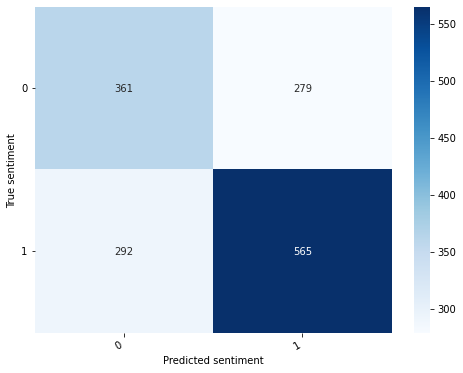

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

plt.figure(figsize=(8, 6))
y_pred = [1 if p > 0.5 else 0 for p in new_preds[0].ravel()]
accuracy_score(test_targets.ravel(), y_pred)

cm = confusion_matrix(test_targets.ravel(), y_pred)
class_names = ['False', 'True']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(cm)

In [ ]:
print(classification_report(test_targets.ravel(), y_pred)) #target_names=class_names

              precision    recall  f1-score   support

           0       0.55      0.56      0.56       640
           1       0.67      0.66      0.66       857

    accuracy                           0.62      1497
   macro avg       0.61      0.61      0.61      1497
weighted avg       0.62      0.62      0.62      1497



(1, 7126, 16)


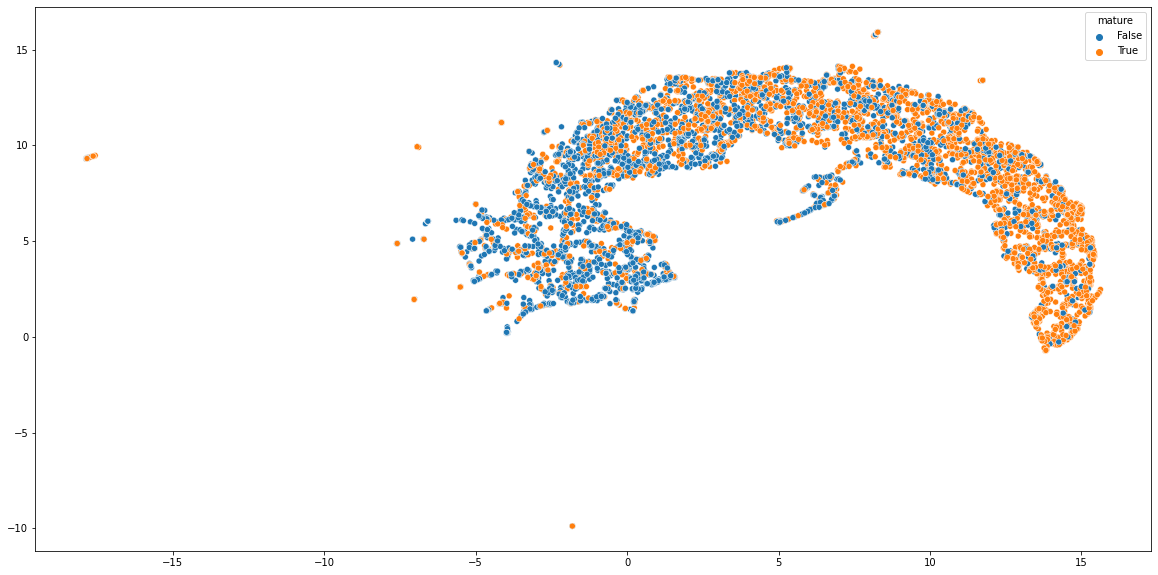

In [ ]:
# Define the embedding model
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)

# Get indices of all nodes
all_indices = get_node_indices(G, targets.index)

#Get embeddings
emb = embedding_model.predict([features_input, all_indices, A_input])
print(emb.shape)
# Shape: (1, 7126, 16)

# UMAP for visualisation
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(emb[0])

#Plot the embeddingsembe
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = targets['mature'])

### 4. Node2Vec

In [ ]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [ ]:
import json
from tqdm import tqdm
import pandas as pd
import numpy as np

edges_path = '/content/gdrive/My Drive/STAT8306/Project/musae_ENGB_edges.csv'
targets_path = '/content/gdrive/My Drive/STAT8306/Project/musae_ENGB_target.csv'
features_path = '/content/gdrive/My Drive/STAT8306/Project/musae_ENGB_features.json'

# Read in edges
edges = pd.read_csv(edges_path)
edges.columns = ['source', 'target'] # renaming for StellarGraph compatibility

# Read in features
with open(features_path) as json_data:
    features = json.load(json_data)

#number of columns in features matrix
max_feature = np.max([v for v_list in features.values() for v in v_list])
#create empty array 
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

node_features = pd.DataFrame(features_matrix, index = features.keys()) # into dataframe for StellarGraph

# Read in edges
edges = pd.read_csv(edges_path)
edges.columns = ['source', 'target'] # renaming for StellarGraph compatibility
display(edges.head())

targets = pd.read_csv(targets_path)
targets.index = targets.new_id
display(targets.head())
#Get the targets in correct order
y = targets.loc[[int(i) for i in list(features.keys())], 'mature']

100%|██████████| 7126/7126 [00:00<00:00, 150623.94it/s]


,source,target
0,6194,255
1,6194,980
2,6194,2992
3,6194,2507
4,6194,986


,id,days,mature,views,partner,new_id
new_id,,,,,,
2299,73045350,1459,False,9528,False,2299
153,61573865,1629,True,3615,False,153
397,171688860,411,True,46546,False,397
5623,117338954,953,True,5863,False,5623
5875,135804217,741,True,5594,False,5875


In [ ]:
import networkx as nx
#read in the graph
graph = nx.convert_matrix.from_pandas_edgelist(edges)

In [ ]:
G = sg.StellarGraph(node_features, edges.astype(str))
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 7126, Edges: 35324

 Node types:
  default: [7126]
    Features: float32 vector, length 3170
    Edge types: default-default->default

 Edge types:
    default-default->default: [35324]
        Weights: all 1 (default)
        Features: none


In [ ]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=200,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 71260


In [ ]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=256, window=5, min_count=0, sg=1, workers=2)

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = y[[int(node_id) for node_id in node_ids]]

In [ ]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


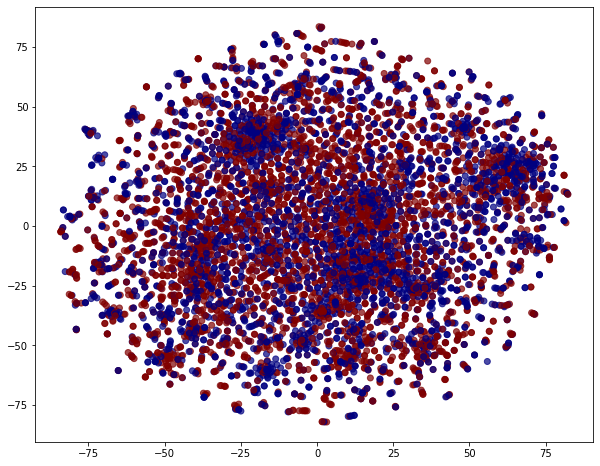

In [ ]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [ ]:
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=None)

In [ ]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (5700, 256)
 y_train = (5700,)
 X_test = (1426, 256)
 y_test = (1426,)


In [ ]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, scoring='accuracy', verbose=False)

In [ ]:
y_pred_lr = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_lr)

0.5953716690042076

In [ ]:
evaluate_preds(y_test, y_pred_lr)

ROC AUC: 0.5805722430115307
PR AUC: 0.5793418782005603
F1 score: 0.6767507002801121
Accuracy 0.5953716690042076
[[0.36953243 0.63046757]
 [0.20838794 0.79161206]]


(0.5805722430115307,
 0.5793418782005603,
 0.6767507002801121,
 0.5953716690042076)

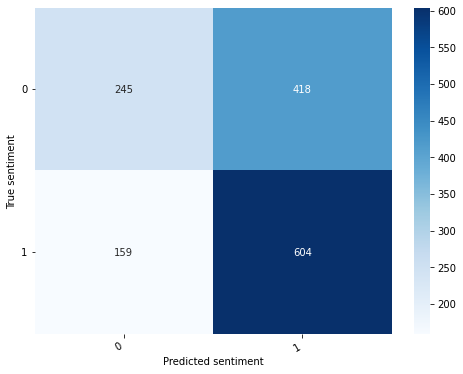

In [ ]:
plt.figure(figsize=(8, 6))

cm_lr = confusion_matrix(y_test, y_pred_lr)
class_names = ['False', 'True']
df_cm_lr = pd.DataFrame(cm_lr, index=class_names, columns=class_names)
show_confusion_matrix(cm_lr)

In [ ]:
print(classification_report(y_test, y_pred_lr)) #target_names=class_names

              precision    recall  f1-score   support

       False       0.61      0.37      0.46       663
        True       0.59      0.79      0.68       763

    accuracy                           0.60      1426
   macro avg       0.60      0.58      0.57      1426
weighted avg       0.60      0.60      0.58      1426

